Dependencies checked/installed.
Mounted at /content/drive
Google Drive mounted successfully.

[1] Extracting parameters from filename...
      -> Voxel size detected: 40.0 microns.

[2] Loading 3D image from: /content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.tif
      -> Image loaded successfully. Dimensions: (300, 531, 546), Data Type: uint16

[3] Applying 3D Median Filter with kernel size 3...
      -> Denoising complete.
      -> Memory Optimized: Raw image array released.

[4] Performing automatic segmentation via Otsu's method...
      -> Automatic threshold determined: 13370.00
      -> Segmentation complete.

[5] Cropping binarized volume to a 300x300x300 cube...
      -> Volume successfully cropped to (300, 300, 300).

[6] Generating visualization dashboard...


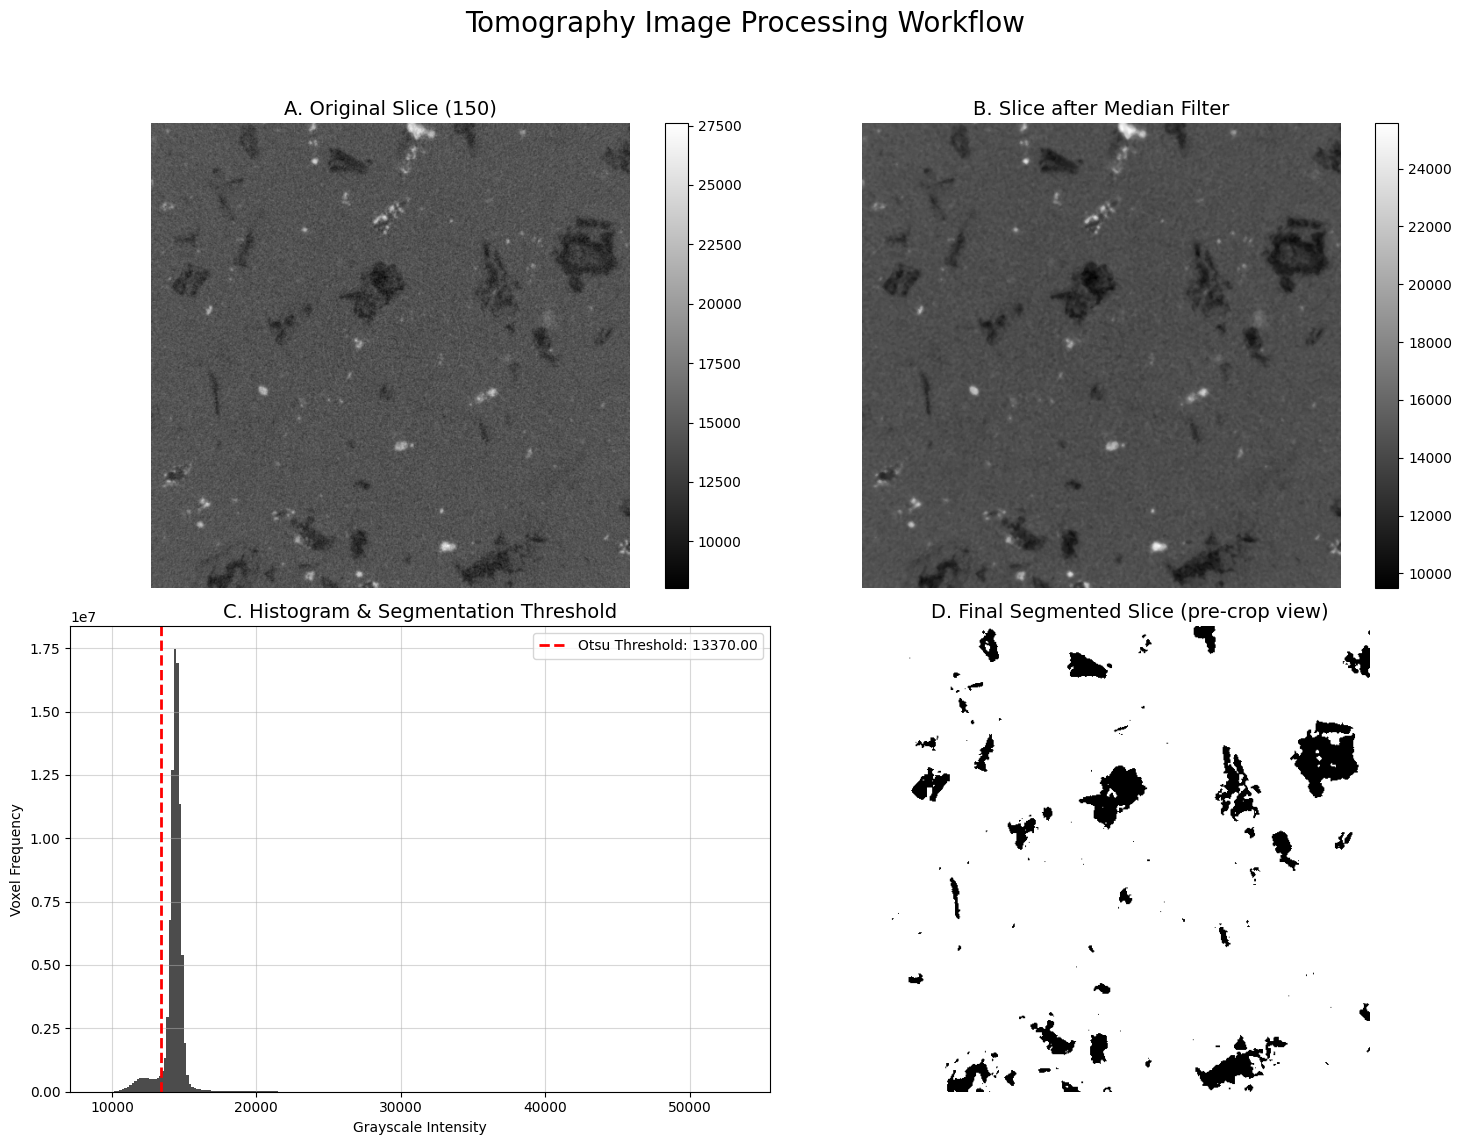

      -> Memory Optimized: Filtered image array released.

--- WORKFLOW COMPLETE ---
The final CUBIC binarized 3D image is now available.
Variable Name: binarized_3d_image
Extracted Voxel Size (variable 'voxel_size'): 40.0 microns
Final Dimensions (Z, Y, X): (300, 300, 300)
Data Type: bool (True = Solid Phase, False = Pore Space)


In [1]:
# =============================================================================
#
# SCRIPT FOR 3D TOMOGRAPHY IMAGE PROCESSING AND SEGMENTATION (MODIFIED FOR CUBIC CROP)
#
# WORKFLOW:
# This script executes a complete pipeline for processing a 3D tomographic
# image volume from a TIFF file. The key stages are:
#   1. Dependency Installation: Ensures all required libraries are present.
#   2. Configuration: User-defined parameters are set, including the
#      side length for the final cubic volume.
#   3. Google Drive Authentication: Mounts the user's Google Drive.
#   4. Image Processing:
#      a. Loads the 3D image volume.
#      b. Applies a 3D median filter for denoising.
#      c. Performs segmentation via Otsu's thresholding.
#   5. Post-processing: Crops the binarized volume to a specified
#      cubic size (e.g., 300x300x300) from the center.
#   6. Visualization: Generates a plot showing the results of each
#      processing stage on a central slice of the *original* volume.
#   7. Memory Optimization: Releases RAM from large intermediate arrays.
#
# OUTPUT:
# A final, cropped cubic binarized 3D NumPy array (`binarized_3d_image`)
# with dimensions 200x200x200, ready for petrophysical analysis.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# Ensure all necessary libraries are installed in the environment.
!pip install imageio scikit-image tifffile -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import gc
import re
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spim
from skimage.filters import threshold_otsu
from google.colab import drive
from typing import Optional

# ===== 3. HELPER FUNCTIONS =====

def extract_voxel_size_from_filename(filename: str) -> Optional[float]:
    """
    Parses a filename to find and extract the voxel size in microns.
    """
    match = re.search(r'(\d+\.?\d*)um', filename, re.IGNORECASE)
    if match:
        try:
            return float(match.group(1))
        except (ValueError, IndexError):
            return None
    return None

# ===== 4. CONFIGURATION =====
# All user-adjustable parameters are defined in this section.
FILE_PATH = '/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.tif'
MEDIAN_FILTER_SIZE = 3
DEFAULT_VOXEL_SIZE = 1.0 # Fallback value if not found in filename.
CROP_SIDE_LENGTH = 300 # NOVA ALTERAÇÃO: Define o tamanho do lado do cubo final.

# ===== 5. GOOGLE DRIVE AUTHENTICATION =====
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"CRITICAL ERROR: Failed to mount Google Drive. {e}")

# ===== 6. MAIN PROCESSING WORKFLOW =====
try:
    # --- 6.1. Automated Parameter Extraction ---
    print("\n[1] Extracting parameters from filename...")
    voxel_size = extract_voxel_size_from_filename(FILE_PATH)
    if voxel_size is None:
        voxel_size = DEFAULT_VOXEL_SIZE
        print(f"      -> WARNING: Voxel size could not be determined from filename.")
        print(f"               Using default value: {voxel_size} microns.")
    else:
        print(f"      -> Voxel size detected: {voxel_size} microns.")

    # --- 6.2. Image Loading ---
    print(f"\n[2] Loading 3D image from: {FILE_PATH}")
    raw_3d_image = imageio.volread(FILE_PATH)
    print(f"      -> Image loaded successfully. Dimensions: {raw_3d_image.shape}, Data Type: {raw_3d_image.dtype}")

    slice_index = raw_3d_image.shape[0] // 2
    original_slice_for_plot = raw_3d_image[slice_index, :, :].copy()

    # --- 6.3. Pre-processing: Denoising ---
    print(f"\n[3] Applying 3D Median Filter with kernel size {MEDIAN_FILTER_SIZE}...")
    filtered_3d_image = spim.median_filter(raw_3d_image, size=MEDIAN_FILTER_SIZE)
    print("      -> Denoising complete.")

    del raw_3d_image
    gc.collect()
    print("      -> Memory Optimized: Raw image array released.")

    filtered_slice_for_plot = filtered_3d_image[slice_index, :, :].copy()

    # --- 6.4. Segmentation: Binarization ---
    print("\n[4] Performing automatic segmentation via Otsu's method...")
    otsu_threshold = threshold_otsu(filtered_3d_image)
    print(f"      -> Automatic threshold determined: {otsu_threshold:.2f}")

    binarized_3d_image = filtered_3d_image > otsu_threshold
    print("      -> Segmentation complete.")

    binarized_slice_for_plot = binarized_3d_image[slice_index, :, :].copy()

    # --- 6.5. Pós-processamento: Recorte do Volume Cúbico (LÓGICA ALTERADA) ---
    print(f"\n[5] Cropping binarized volume to a {CROP_SIDE_LENGTH}x{CROP_SIDE_LENGTH}x{CROP_SIDE_LENGTH} cube...")

    original_dims = binarized_3d_image.shape

    # Verifica se o volume original é grande o suficiente para o recorte
    if all(dim >= CROP_SIDE_LENGTH for dim in original_dims):
        # Calcula o centro para cada eixo
        center_z = original_dims[0] // 2
        center_y = original_dims[1] // 2
        center_x = original_dims[2] // 2

        # Calcula os índices de início e fim para cada eixo
        start_z = center_z - (CROP_SIDE_LENGTH // 2)
        end_z = start_z + CROP_SIDE_LENGTH
        start_y = center_y - (CROP_SIDE_LENGTH // 2)
        end_y = start_y + CROP_SIDE_LENGTH
        start_x = center_x - (CROP_SIDE_LENGTH // 2)
        end_x = start_x + CROP_SIDE_LENGTH

        # Realiza o recorte (slicing) nos três eixos
        binarized_3d_image = binarized_3d_image[start_z:end_z, start_y:end_y, start_x:end_x]
        print(f"      -> Volume successfully cropped to {binarized_3d_image.shape}.")
    else:
        print(f"      -> CRITICAL WARNING: Original volume dimensions {original_dims} are too small")
        print(f"                         to extract a {CROP_SIDE_LENGTH}x{CROP_SIDE_LENGTH}x{CROP_SIDE_LENGTH} cube. No crop performed.")

    # --- 6.6. Visualization ---
    print("\n[6] Generating visualization dashboard...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Tomography Image Processing Workflow', fontsize=20, y=0.95)
    # (O restante do código de visualização permanece o mesmo)
    ax1 = axes[0, 0]
    im1 = ax1.imshow(original_slice_for_plot, cmap='gray')
    ax1.set_title(f'A. Original Slice ({slice_index})', fontsize=14)
    ax1.axis('off')
    fig.colorbar(im1, ax=ax1)
    ax2 = axes[0, 1]
    im2 = ax2.imshow(filtered_slice_for_plot, cmap='gray')
    ax2.set_title('B. Slice after Median Filter', fontsize=14)
    ax2.axis('off')
    fig.colorbar(im2, ax=ax2)
    ax3 = axes[1, 0]
    ax3.hist(filtered_3d_image.ravel(), bins=256, color='black', alpha=0.7)
    ax3.axvline(otsu_threshold, color='red', linestyle='--', linewidth=2, label=f'Otsu Threshold: {otsu_threshold:.2f}')
    ax3.set_title('C. Histogram & Segmentation Threshold', fontsize=14)
    ax3.set_xlabel('Grayscale Intensity')
    ax3.set_ylabel('Voxel Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.5)
    ax4 = axes[1, 1]
    ax4.imshow(binarized_slice_for_plot, cmap='gray')
    ax4.set_title('D. Final Segmented Slice (pre-crop view)', fontsize=14)
    ax4.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    del filtered_3d_image
    gc.collect()
    print("      -> Memory Optimized: Filtered image array released.")

    # --- 6.7. Final Output ---
    print("\n--- WORKFLOW COMPLETE ---")
    print("The final CUBIC binarized 3D image is now available.")
    print(f"Variable Name: binarized_3d_image")
    print(f"Extracted Voxel Size (variable 'voxel_size'): {voxel_size} microns")
    print(f"Final Dimensions (Z, Y, X): {binarized_3d_image.shape}")
    print(f"Data Type: {binarized_3d_image.dtype} (True = Solid Phase, False = Pore Space)")

except FileNotFoundError:
    print(f"\nCRITICAL ERROR: The file was not found at the specified path.")
    print(f"Path: '{FILE_PATH}'")
    print("Please ensure the path is correct and the file is present in your Google Drive.")
except Exception as e:
    print(f"\nCRITICAL ERROR: An unexpected error occurred during the workflow: {e}")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 24.0 MB/s eta 0:00:00
Dependencies checked/installed.
Input 3D image confirmed.
   -> Analyzing the fractal dimension of the 'Solid' phase.

[1] Initiating fractal dimension calculation via the box-counting method...
    This process may take several minutes depending on t

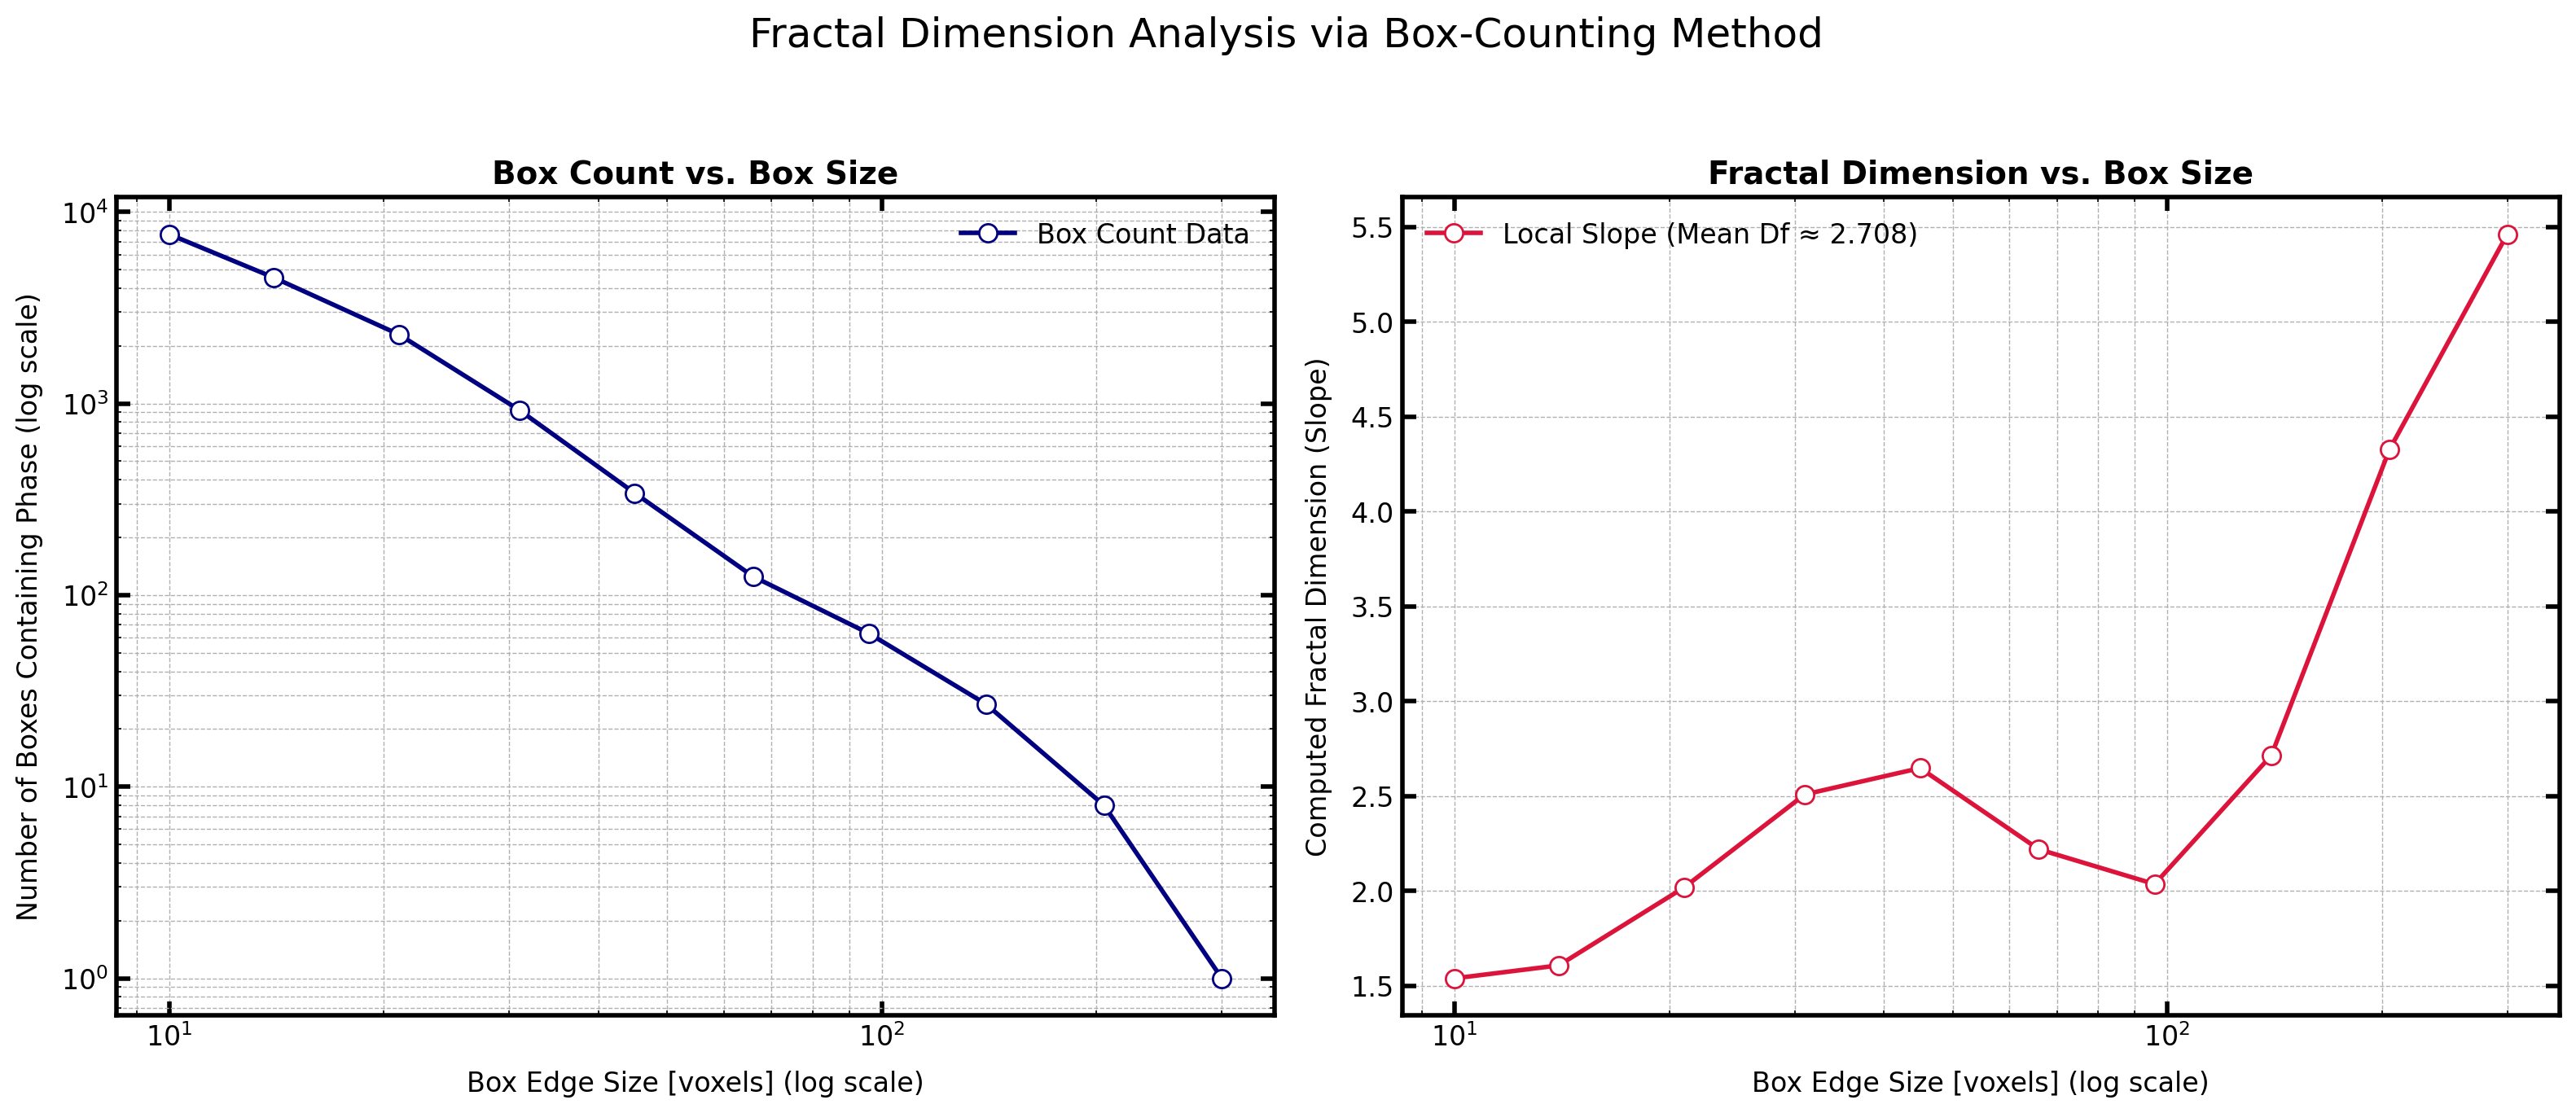

In [2]:
# =============================================================================
#
# SCRIPT FOR FRACTAL DIMENSION ANALYSIS OF A 3D POROUS MEDIUM
#
# WORKFLOW:
# This script calculates the fractal dimension of a binarized 3D image
# using the box-counting method provided by the PoreSpy library. The fractal
# dimension is a key metric for characterizing the geometric complexity and
# space-filling capacity of the pore network.
#
#   1. Dependency Installation: Ensures the PoreSpy library is available.
#   2. Input Data Verification: Assumes a 3D binarized NumPy array
#      (`binarized_3d_image`) is present in the environment.
#   3. Fractal Dimension Calculation: Employs the `porespy.metrics.boxcount`
#      function to perform the analysis.
#   4. Visualization: Generates two standard plots for interpreting the
#      box-counting results:
#      a. Log-log plot of box count vs. box size.
#      b. Plot of the local slope (fractal dimension) vs. box size.
#
# OUTPUT:
# A comprehensive visualization of the box-counting analysis and the resulting
# fractal dimension data, which is stored in the `fractal_data` variable.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# Ensure the PoreSpy library, which contains the box-counting algorithm, is installed.
!pip install pypardiso porespy -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that a 3D binarized NumPy array named 'binarized_3d_image'
# exists in the current runtime environment.

if 'binarized_3d_image' in locals() or 'binarized_3d_image' in globals():

    # --- 3.1. Input Data Confirmation ---
    # Assign the input image to a clearly named variable for this analysis.
    # The box-counting algorithm typically analyzes the complexity of the 'True' phase.
    # The user's convention is True=Solid, so this calculates the fractal dimension
    # of the solid matrix. To analyze the pore space, use `image = ~binarized_3d_image`.
    image_to_analyze = binarized_3d_image
    print("Input 3D image confirmed.")
    print(f"   -> Analyzing the fractal dimension of the '{'Solid' if np.all(image_to_analyze == binarized_3d_image) else 'Pore'}' phase.")

    # --- 3.2. Fractal Dimension Calculation ---
    print("\n[1] Initiating fractal dimension calculation via the box-counting method...")
    print("    This process may take several minutes depending on the image dimensions.")

    # The porespy.metrics.boxcount function efficiently handles both 2D and 3D images.
    # It returns a pandas DataFrame containing the box sizes, counts, and local slopes.
    fractal_data = ps.metrics.boxcount(im=image_to_analyze)

    print("    -> Calculation completed successfully.")

    # The overall fractal dimension is often taken as the average slope over the linear region.
    # Here, we calculate the mean of the computed slopes as a representative value.
    mean_fractal_dimension = fractal_data.slope.mean()
    print(f"    -> Mean Fractal Dimension (Average Slope): {mean_fractal_dimension:.4f}")


    # --- 3.3. Results Visualization ---
    print("\n[2] Generating analysis plots...")

    # Set the plotting style for consistency.
    ps.visualization.set_mpl_style()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('Fractal Dimension Analysis via Box-Counting Method', fontsize=18, y=0.98)

    # Plot 1: Log-Log plot of Box Count vs. Box Edge Size
    # The slope of the linear region in this plot corresponds to the fractal dimension.
    ax1.plot(fractal_data.size, fractal_data.count, 'o-', color='navy', label='Box Count Data')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel('Box Edge Size [voxels] (log scale)', fontsize=12)
    ax1.set_ylabel('Number of Boxes Containing Phase (log scale)', fontsize=12)
    ax1.set_title('Box Count vs. Box Size', fontsize=14, fontweight='bold')
    ax1.grid(True, which="both", ls="--", linewidth=0.5)
    ax1.legend()

    # Plot 2: Local Slope (Fractal Dimension) vs. Box Edge Size
    # This plot helps identify the stable plateau where the fractal dimension is most representative.
    ax2.plot(fractal_data.size, fractal_data.slope, 'o-', color='crimson', label=f'Local Slope (Mean Df ≈ {mean_fractal_dimension:.3f})')
    ax2.set_xlabel('Box Edge Size [voxels] (log scale)', fontsize=12)
    ax2.set_ylabel('Computed Fractal Dimension (Slope)', fontsize=12)
    ax2.set_title('Fractal Dimension vs. Box Size', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, which="both", ls="--", linewidth=0.5)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

else:
    # Error message if the prerequisite variable is not found.
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.
Input image inverted to analyze the pore space (True = Pore).

[1] Initiating lineal path transform calculation for all 3 axes...
    -> Processing axis Z (slice-direction)...
       ...done. Memory released.
    -> Processing axis Y (height)...
       ...done. Memory released.
    -> Processing axis X (width)...
       ...done. Memory released.
    -> All axes processed successfully.

[2] Generating lineal path distribution plot...


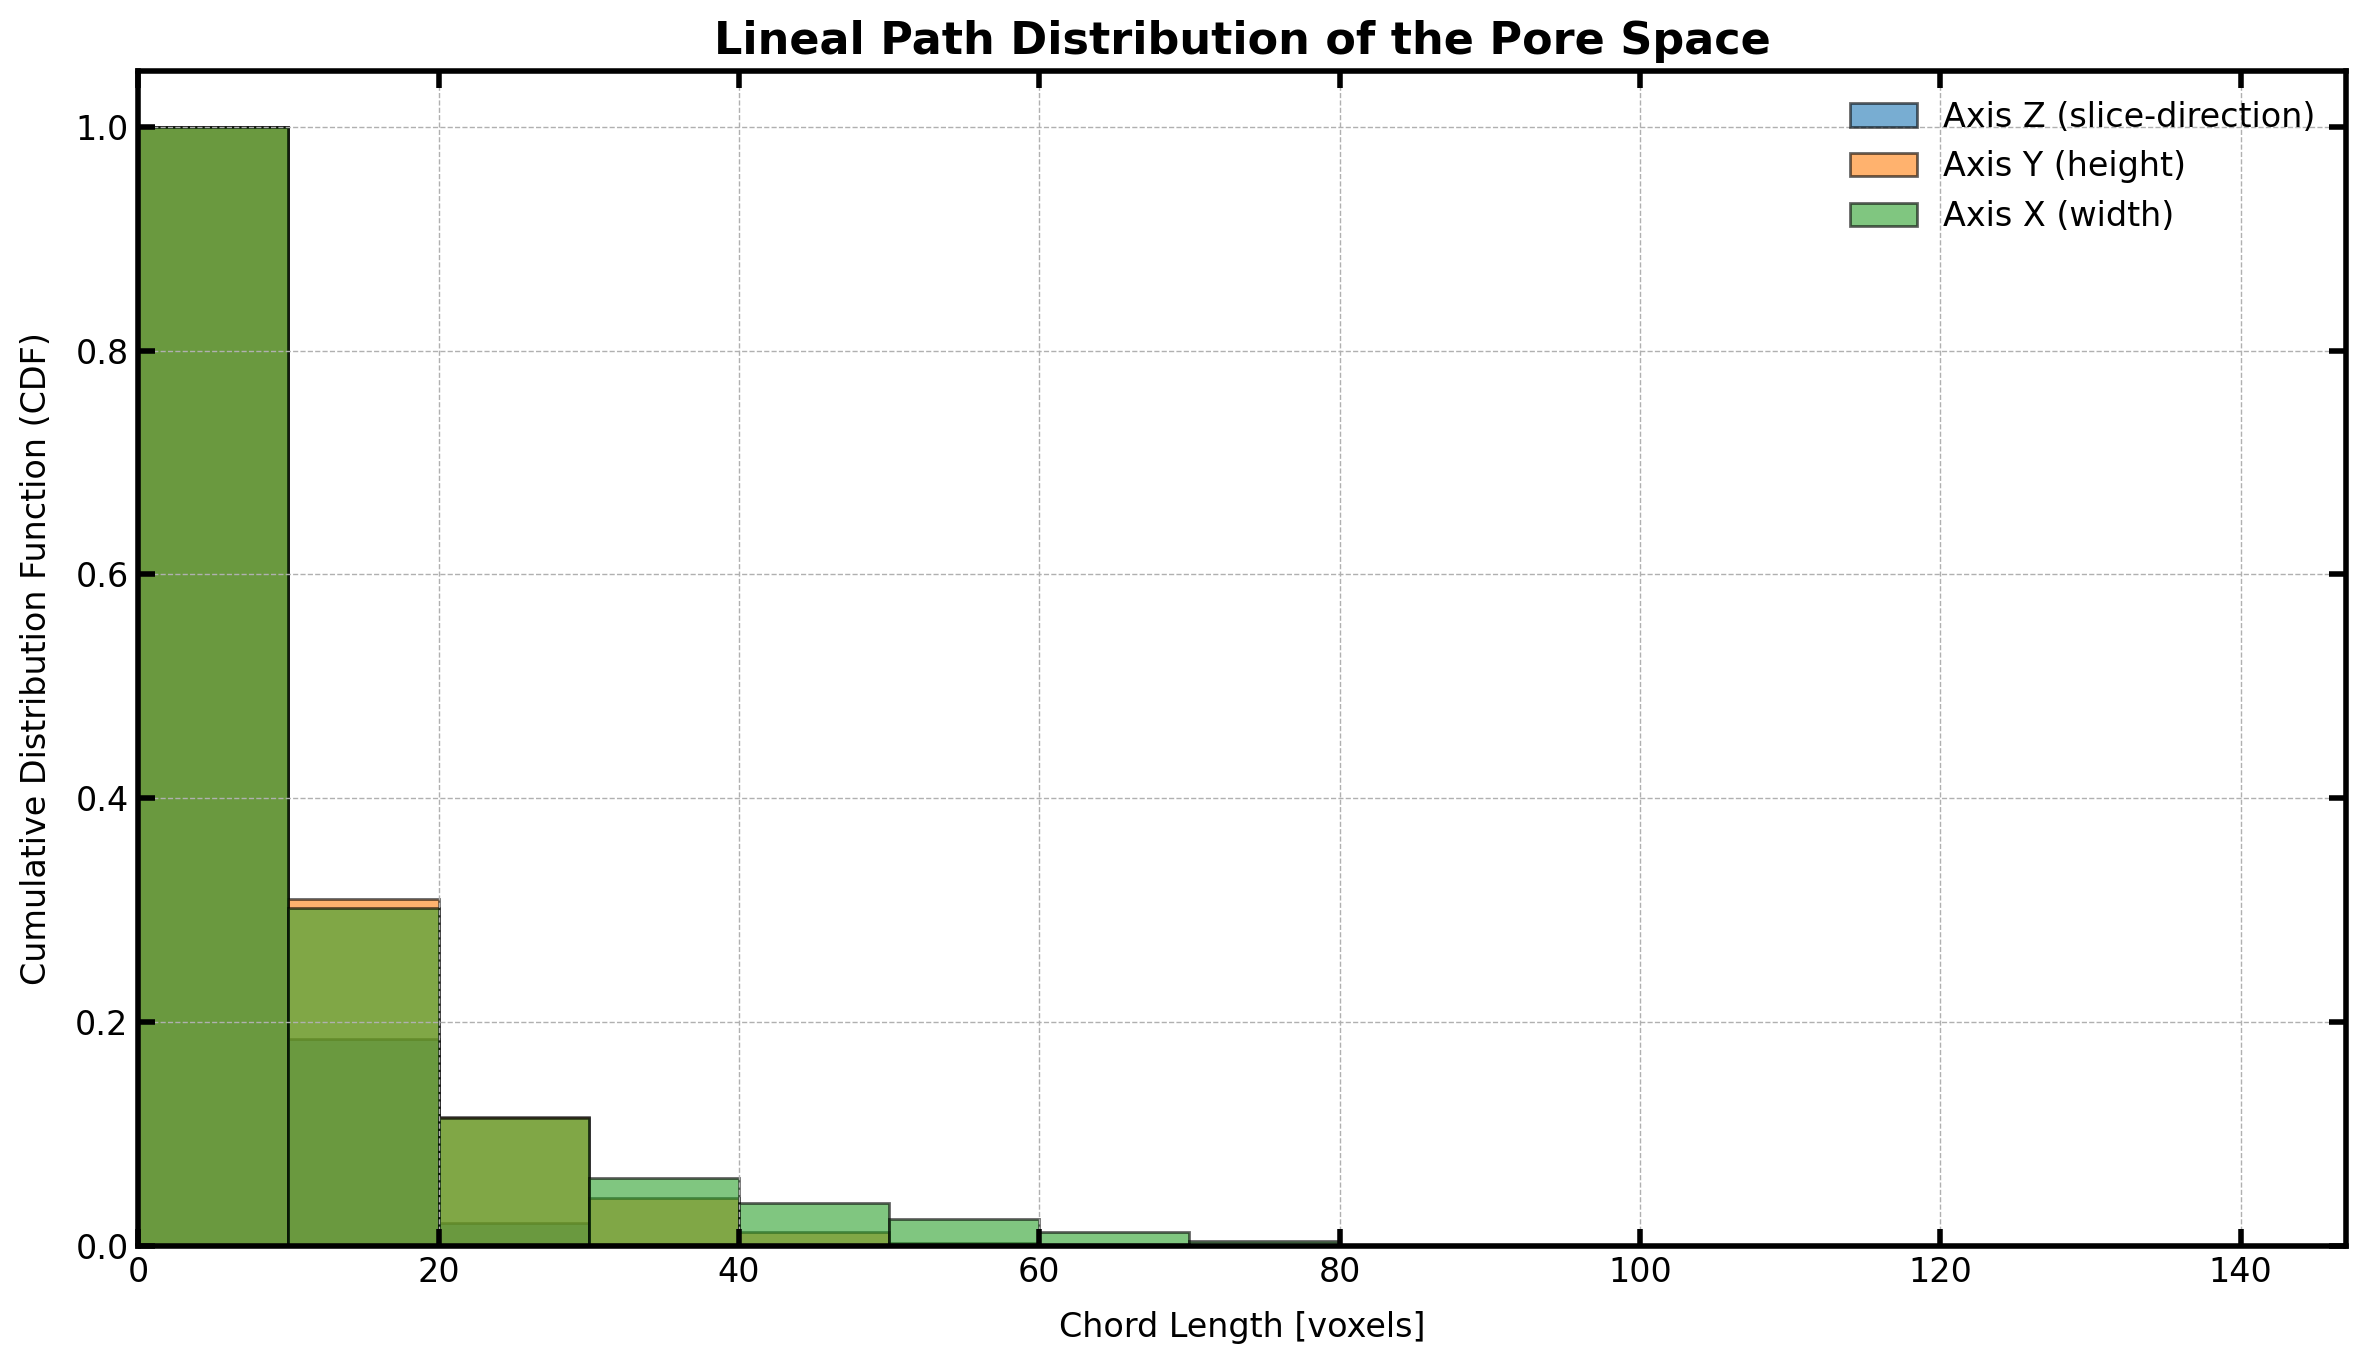

In [3]:
# =============================================================================
#
# SCRIPT FOR LINEAL PATH DISTRIBUTION ANALYSIS OF A 3D POROUS MEDIUM
#
# WORKFLOW:
# This script calculates the lineal path distribution, a metric characterizing
# the chord length distribution within the pore space of a 3D binarized image.
# This analysis is crucial for understanding transport properties and the
# anisotropic nature of the porous medium.
#
#   1. Dependency Installation: Ensures the PoreSpy library is available.
#   2. Input Preparation: Assumes a 3D binarized NumPy array
#      (`binarized_3d_image`) is present and prepares it for analysis.
#   3. Lineal Path Calculation: Sequentially computes the linear distance
#      transform for each of the three principal axes (X, Y, Z).
#      This process is memory-optimized to handle large images.
#   4. Distribution Analysis: Calculates the cumulative distribution function (CDF)
#      of chord lengths for each axis.
#   5. Visualization: Generates a comparative bar chart of the lineal path
#      CDFs, allowing for a direct assessment of anisotropy.
#
# OUTPUT:
# A plot illustrating the lineal path distribution for the X, Y, and Z axes.
# The calculated distribution data is stored in the `lineal_path_data` dictionary.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# Ensure the PoreSpy library is installed in the environment.
!pip install porespy -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that a 3D binarized NumPy array named 'binarized_3d_image'
# exists in the current runtime environment.

if 'binarized_3d_image' in locals() or 'binarized_3d_image' in globals():

    # --- 3.1. Input Data Preparation ---
    # The PoreSpy distance transform functions operate on the 'True' phase.
    # The input image convention is True=Solid, False=Pore. Therefore, the image
    # must be inverted to analyze the pore space.
    pore_space = ~binarized_3d_image
    print("Input image inverted to analyze the pore space (True = Pore).")

    # --- 3.2. Lineal Path Calculation (Memory Optimized) ---
    print("\n[1] Initiating lineal path transform calculation for all 3 axes...")

    lineal_path_data = {}
    axes_map = {
        0: 'Z (slice-direction)',
        1: 'Y (height)',
        2: 'X (width)'
    }

    # Define the bins for the histogram based on image size.
    max_path_length = np.max(pore_space.shape) // 2
    histogram_bins = np.arange(0, max_path_length, 10)

    # Process each axis sequentially to minimize peak RAM usage.
    for axis_index, axis_name in axes_map.items():
        print(f"    -> Processing axis {axis_name}...")

        # Calculate the linear distance transform for the current axis.
        # This determines, for each pore voxel, the length of the chord
        # passing through it along the specified axis.
        path_map = ps.filters.distance_transform_lin(im=pore_space, axis=axis_index)

        # Calculate the lineal path distribution from the generated map.
        lpf_result = ps.metrics.lineal_path_distribution(path_map, bins=histogram_bins)
        lineal_path_data[axis_name] = lpf_result

        # RAM Optimization: Delete the large intermediate array before the next iteration.
        del path_map
        gc.collect()
        print(f"       ...done. Memory released.")

    print("    -> All axes processed successfully.")

    # --- 3.3. Results Visualization ---
    print("\n[2] Generating lineal path distribution plot...")

    # The plot displays the Cumulative Distribution Function (CDF), representing
    # the probability that a randomly chosen voxel in the pore space belongs to a
    # chord of at least length L.

    ps.visualization.set_mpl_style()
    fig, ax = plt.subplots(figsize=(12, 7))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green
    for color, (axis_name, data) in zip(colors, lineal_path_data.items()):
        ax.bar(
            x=data.L,
            height=data.cdf,
            width=data.bin_widths,
            edgecolor='k',
            alpha=0.6,
            label=f'Axis {axis_name}'
        )

    ax.set_xlabel('Chord Length [voxels]', fontsize=12)
    ax.set_ylabel('Cumulative Distribution Function (CDF)', fontsize=12)
    ax.set_title('Lineal Path Distribution of the Pore Space', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    ax.set_xlim(left=0)

    plt.tight_layout()
    plt.show()

else:
    # Error message if the prerequisite variable is not found.
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Input image inverted for pore space analysis (True = Pore).

--- GLOBAL SAMPLE INFORMATION ---
Overall mean porosity of the 3D sample: 0.0636 (or 6.36%)

[1] Calculating porosity profiles along each principal axis...
    -> Calculation complete.

[2] Generating analysis plots...


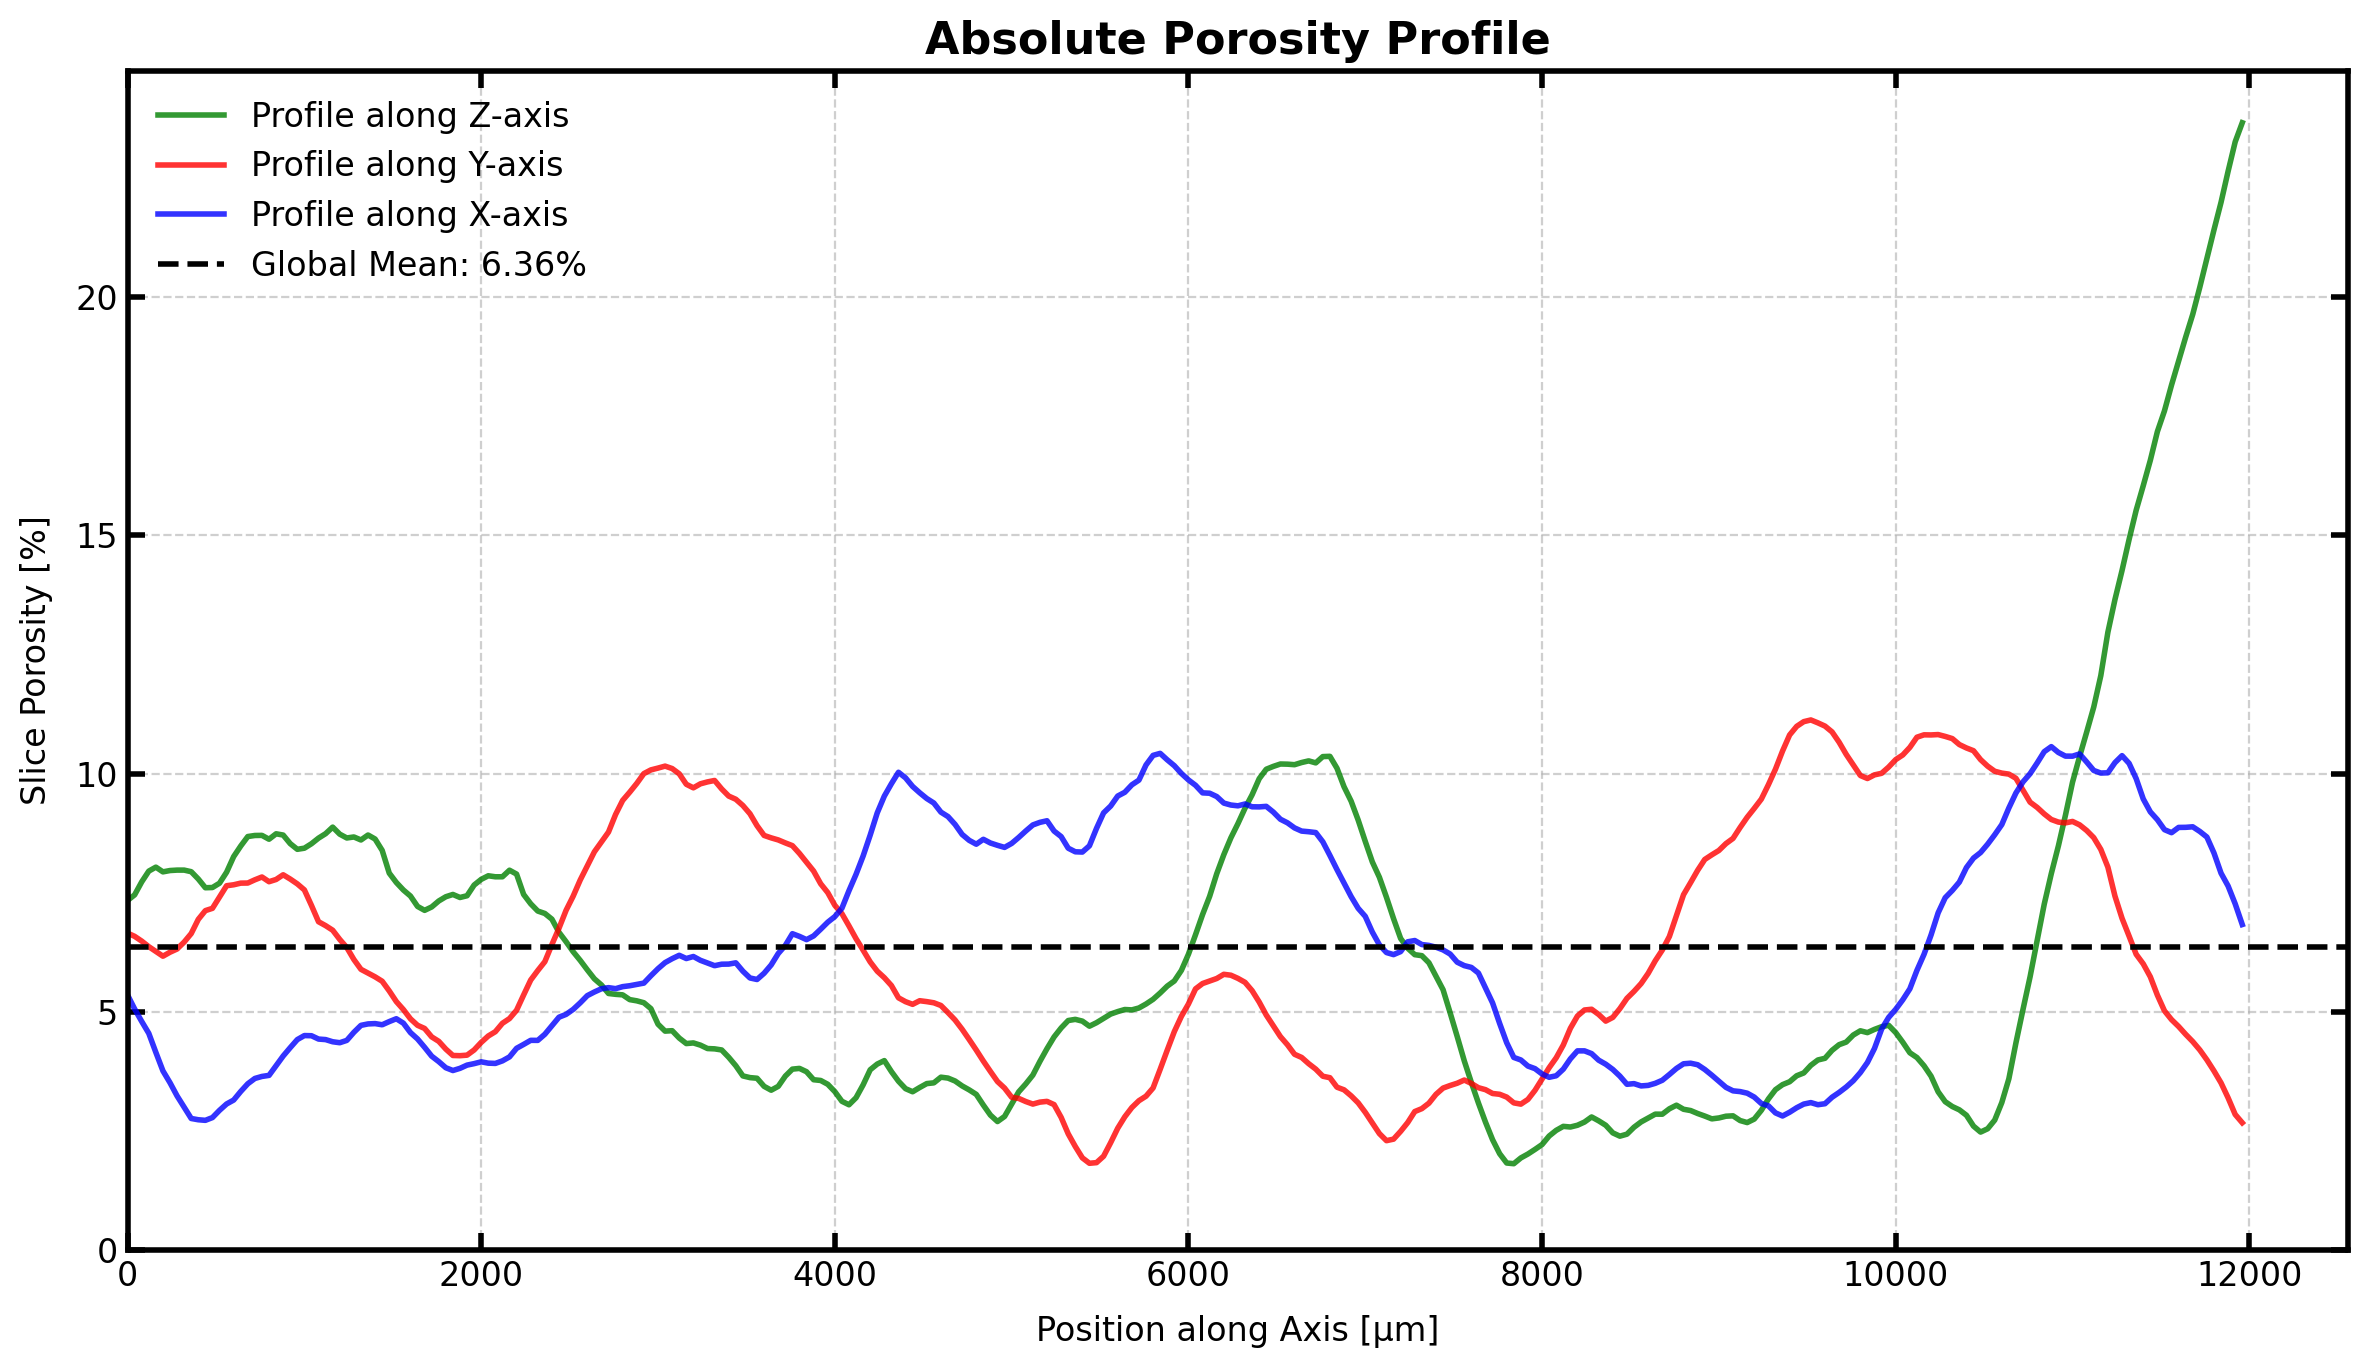

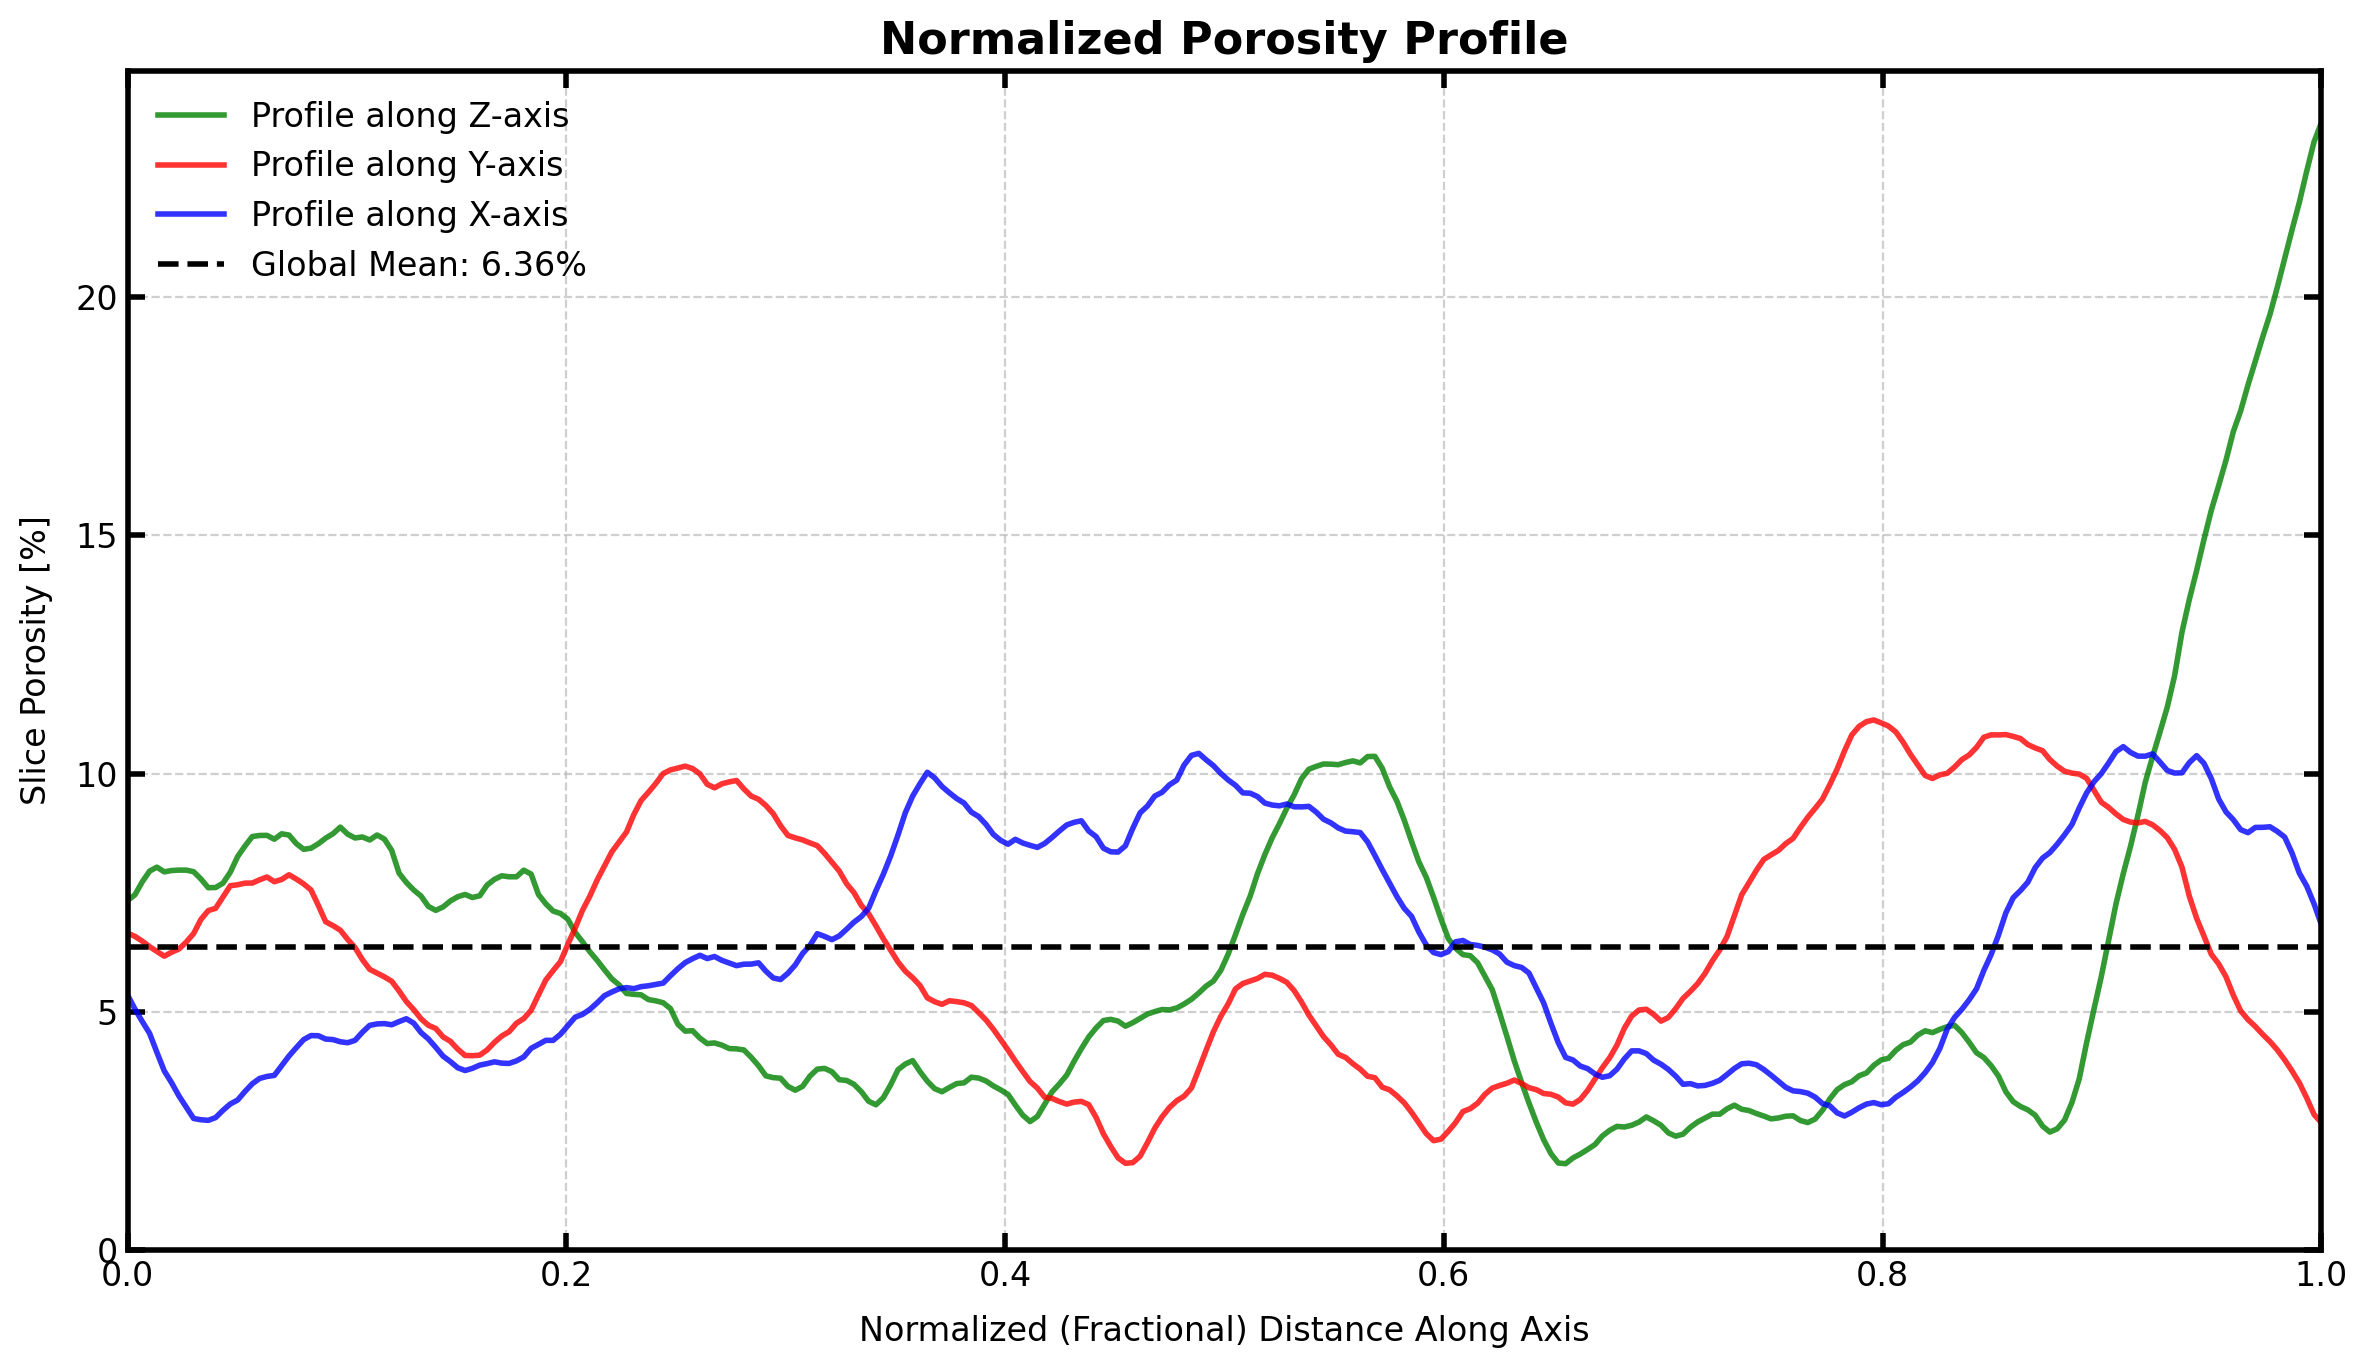

In [4]:
# =============================================================================
#
# SCRIPT FOR POROSITY PROFILE ANALYSIS OF A 3D POROUS MEDIUM
#
# WORKFLOW:
# This script calculates the slice-wise porosity along the three principal axes
# (X, Y, Z) of a binarized 3D image. This analysis is fundamental for assessing
# sample homogeneity and identifying any directional trends or layering.
#
#   1. Input Preparation: Assumes that a 3D binarized NumPy array
#      (`binarized_3d_image`) and the `voxel_size` are present in the
#      environment.
#   2. Global Porosity Calculation: Computes the overall average porosity of the
#      entire 3D sample.
#   3. Profile Calculation: A helper function computes the porosity for each
#      slice along the X, Y, and Z axes.
#   4. Visualization: Generates two comprehensive plots:
#      a. Porosity vs. Absolute Position (in microns).
#      b. Porosity vs. Normalized (Fractional) Distance.
#      Both plots include the global average porosity for reference.
#
# OUTPUT:
# Two plots illustrating the porosity profiles and a printed statement of the
# overall sample porosity.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. LIBRARY IMPORTS =====
# PoreSpy is used here to set a consistent plotting style.
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# ===== 2. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment from the previous processing steps.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 2.1. Helper Function Definition ---
    def calculate_porosity_profile(pore_space_image: np.ndarray, axis: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculates the slice-wise porosity profile along a specified axis.

        Args:
            pore_space_image (np.ndarray): A boolean 3D array where True indicates
                                           the pore phase.
            axis (int): The axis along which to calculate the profile (0 for Z,
                        1 for Y, 2 for X).

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing two arrays:
                                           - positions: 1D array of slice indices.
                                           - porosities: 1D array of corresponding
                                             slice porosity values.
        """
        if axis not in [0, 1, 2]:
            raise ValueError("Axis must be an integer: 0, 1, or 2.")

        # Define the axes of the 2D slices over which to average.
        slice_axes = tuple(ax for ax in [0, 1, 2] if ax != axis)

        # np.mean on a boolean array treats True as 1 and False as 0,
        # efficiently calculating porosity for each slice.
        porosities = np.mean(pore_space_image, axis=slice_axes)
        positions = np.arange(len(porosities))

        return (positions, porosities)

    # --- 2.2. Input Data Preparation ---
    # The input image convention is True=Solid, False=Pore.
    # Invert the image to analyze the pore space (True = Pore).
    # NOTE: The memory-intensive '.astype(int)' conversion is not necessary.
    pore_space = ~binarized_3d_image
    print("Input image inverted for pore space analysis (True = Pore).")

    # --- 2.3. Global Porosity Calculation ---
    # The mean of the entire boolean pore space array is the global porosity.
    global_mean_porosity = np.mean(pore_space)

    print("\n--- GLOBAL SAMPLE INFORMATION ---")
    print(f"Overall mean porosity of the 3D sample: {global_mean_porosity:.4f} (or {global_mean_porosity:.2%})")

    # --- 2.4. Porosity Profile Calculation ---
    print("\n[1] Calculating porosity profiles along each principal axis...")
    profile_z = calculate_porosity_profile(pore_space, axis=0)
    profile_y = calculate_porosity_profile(pore_space, axis=1)
    profile_x = calculate_porosity_profile(pore_space, axis=2)
    print("    -> Calculation complete.")

    # --- 2.5. Results Visualization ---
    print("\n[2] Generating analysis plots...")

    # Set a consistent plotting style
    ps.visualization.set_mpl_style()

    # --- Plot 1: Porosity vs. Absolute Position ---
    fig1, ax1 = plt.subplots(figsize=(12, 7))

    # Plot data in percent for easier interpretation
    ax1.plot(profile_z[0] * voxel_size, profile_z[1] * 100, 'g-', label='Profile along Z-axis', alpha=0.8)
    ax1.plot(profile_y[0] * voxel_size, profile_y[1] * 100, 'r-', label='Profile along Y-axis', alpha=0.8)
    ax1.plot(profile_x[0] * voxel_size, profile_x[1] * 100, 'b-', label='Profile along X-axis', alpha=0.8)

    # Add the global average porosity as a reference line
    ax1.axhline(y=global_mean_porosity * 100, color='k', linestyle='--', linewidth=2,
                label=f'Global Mean: {global_mean_porosity:.2%}')

    ax1.set_ylabel('Slice Porosity [%]', fontsize=12)
    ax1.set_xlabel('Position along Axis [µm]', fontsize=12)
    ax1.set_title('Absolute Porosity Profile', fontsize=16, fontweight='bold')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_ylim(bottom=0)
    ax1.set_xlim(left=0)
    plt.show()

    # --- Plot 2: Porosity vs. Normalized (Fractional) Distance ---
    fig2, ax2 = plt.subplots(figsize=(12, 7))

    ax2.plot(profile_z[0] / profile_z[0].max(), profile_z[1] * 100, 'g-', label='Profile along Z-axis', alpha=0.8)
    ax2.plot(profile_y[0] / profile_y[0].max(), profile_y[1] * 100, 'r-', label='Profile along Y-axis', alpha=0.8)
    ax2.plot(profile_x[0] / profile_x[0].max(), profile_x[1] * 100, 'b-', label='Profile along X-axis', alpha=0.8)

    ax2.axhline(y=global_mean_porosity * 100, color='k', linestyle='--', linewidth=2,
                label=f'Global Mean: {global_mean_porosity:.2%}')

    ax2.set_ylabel('Slice Porosity [%]', fontsize=12)
    ax2.set_xlabel('Normalized (Fractional) Distance Along Axis', fontsize=12)
    ax2.set_title('Normalized Porosity Profile', fontsize=16, fontweight='bold')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(0, 1)
    plt.show()

else:
    # Error message if the prerequisite variables are not found.
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.
Input image inverted for pore space analysis (True = Pore).

[1] Segmenting the pore space using the SNOW algorithm...
    Settings: r_max=4, sigma=0.4. This may take several minutes.
    -> Segmentation complete. Found 927 distinct pore regions.

[2] Extracting geometric properties for each pore region...
    -> Property extraction complete.

[3] Organizing results into a pandas DataFrame...
    -> DataFrame created successfully.

    Displaying properties for the first 5 discovered pores:


label  volume  bbox_volume  sphericity  surface_area  convex_volume  \
0      1   225.0         4320    0.365959    488.847168         1224.0   
1      2  9172.0       110823    0.574312   3689.598877        26337.0   
2      3   590.0         1980    0.731881    464.813232          879.0   
3      4   908.0         3240    0.681269    665.614136         1350.0   
4      5  1187.0         3240    0.705710    768.230713         1598.0   

   num_pixels    area  area_bbox  area_convex  equivalent_diameter_area  \
0         225   225.0     4320.0       1224.0                  7.546194   
1        9172  9172.0   110823.0      26337.0                 25.970988   
2         590   590.0     1980.0        879.0                 10.406015   
3         908   908.0     3240.0       1350.0                 12.014224   
4        1187  1187.0     3240.0       1598.0                 13.136632   

   euler_number    extent  feret_diameter_max  area_filled  axis_major_length  \
0             4  0.052083           27.367864        225.0          39.719876   
1             7  0.082763           72.924619       9172.0          41.109751   
2             2  0.297980           17.748239        590.0          14.193159   
3             1  0.280247           19.824228        908.0          17.206529   
4             1  0.366358           27.092434       1187.0          25.593770   

   axis_minor_length  solidity  
0           5.658482  0.183824  
1          19.039322  0.348255  
2          10.287323  0.671217  
3           9.749996  0.672593  
4           8.496629  0.742804


[4] Generating analysis plots...


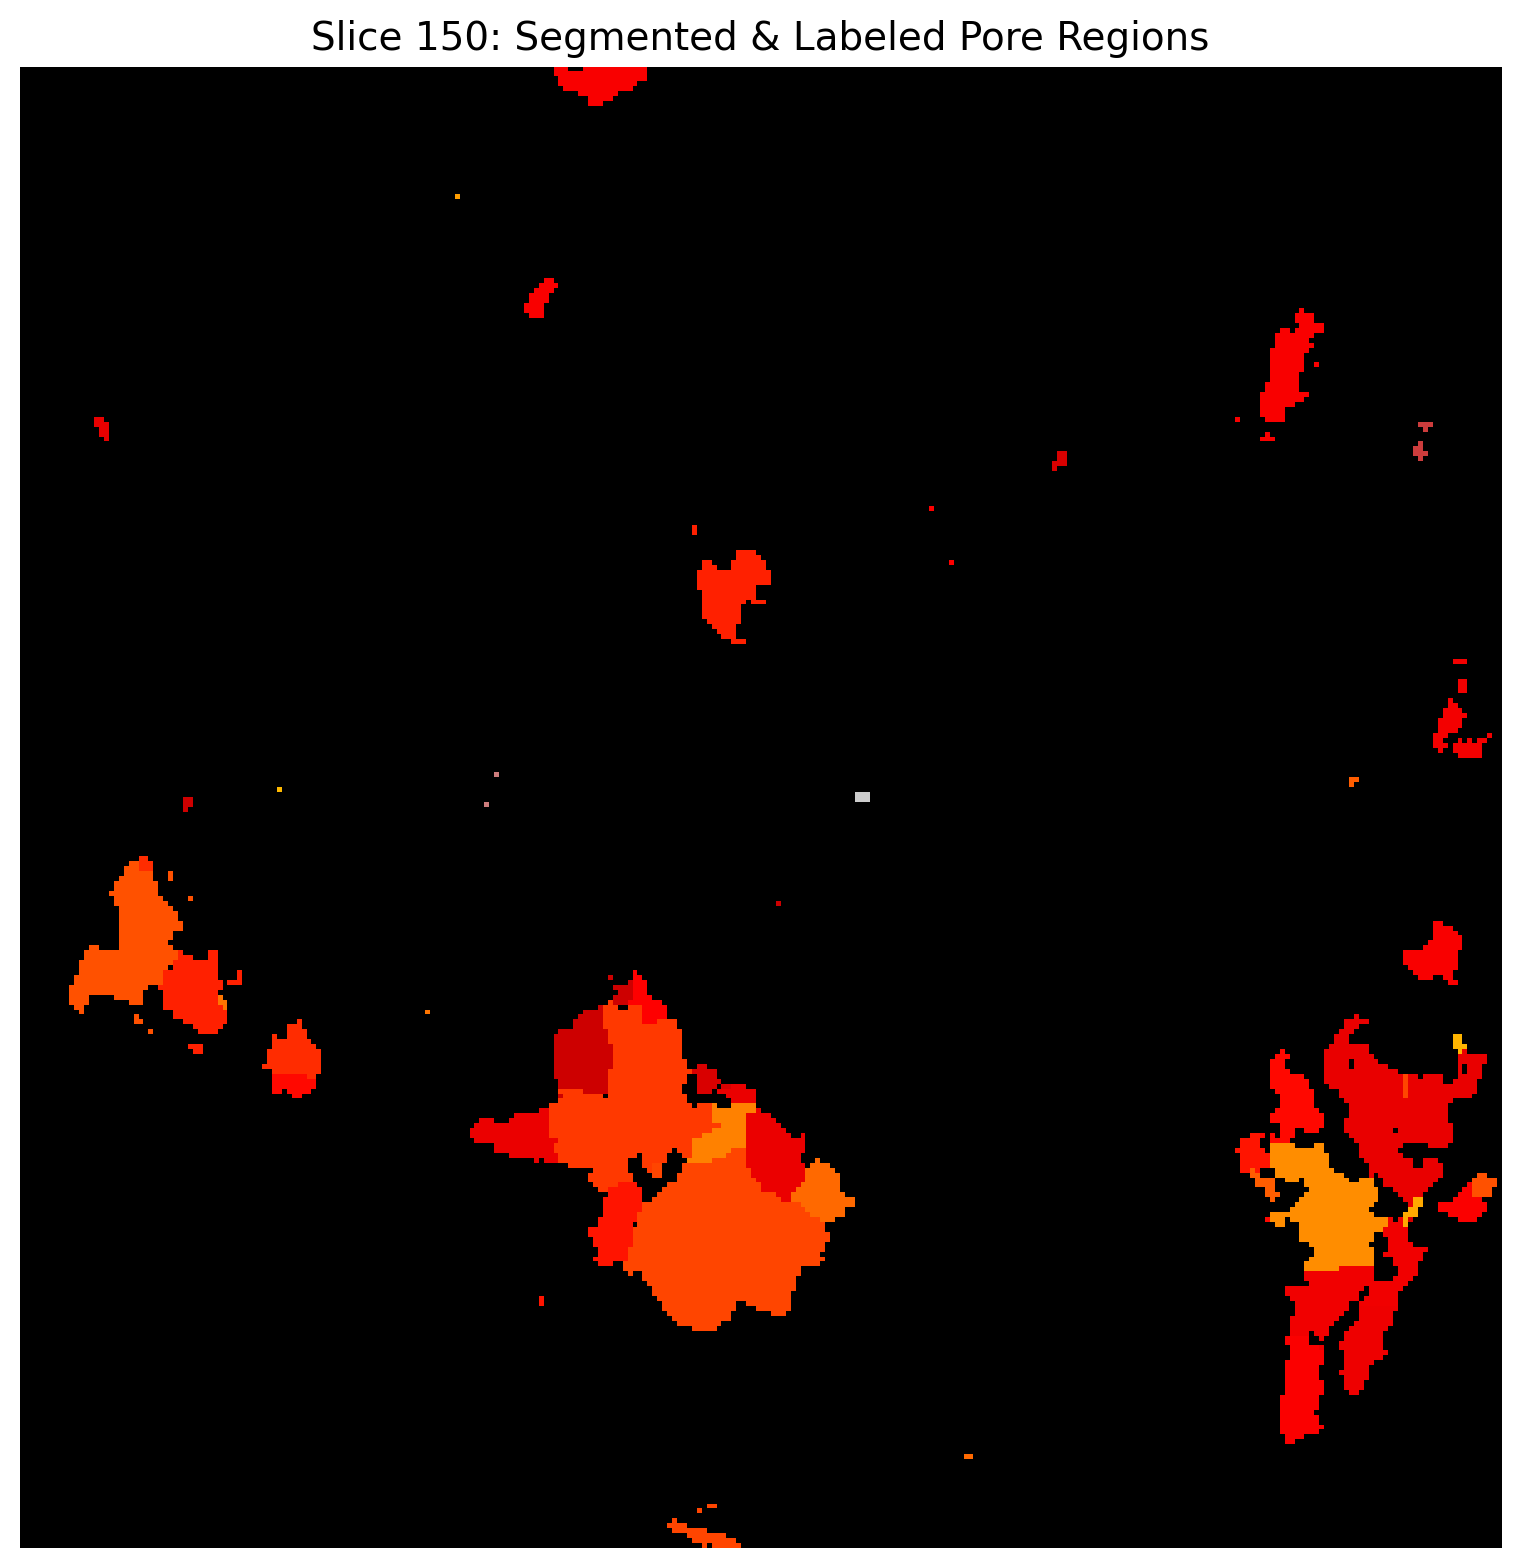

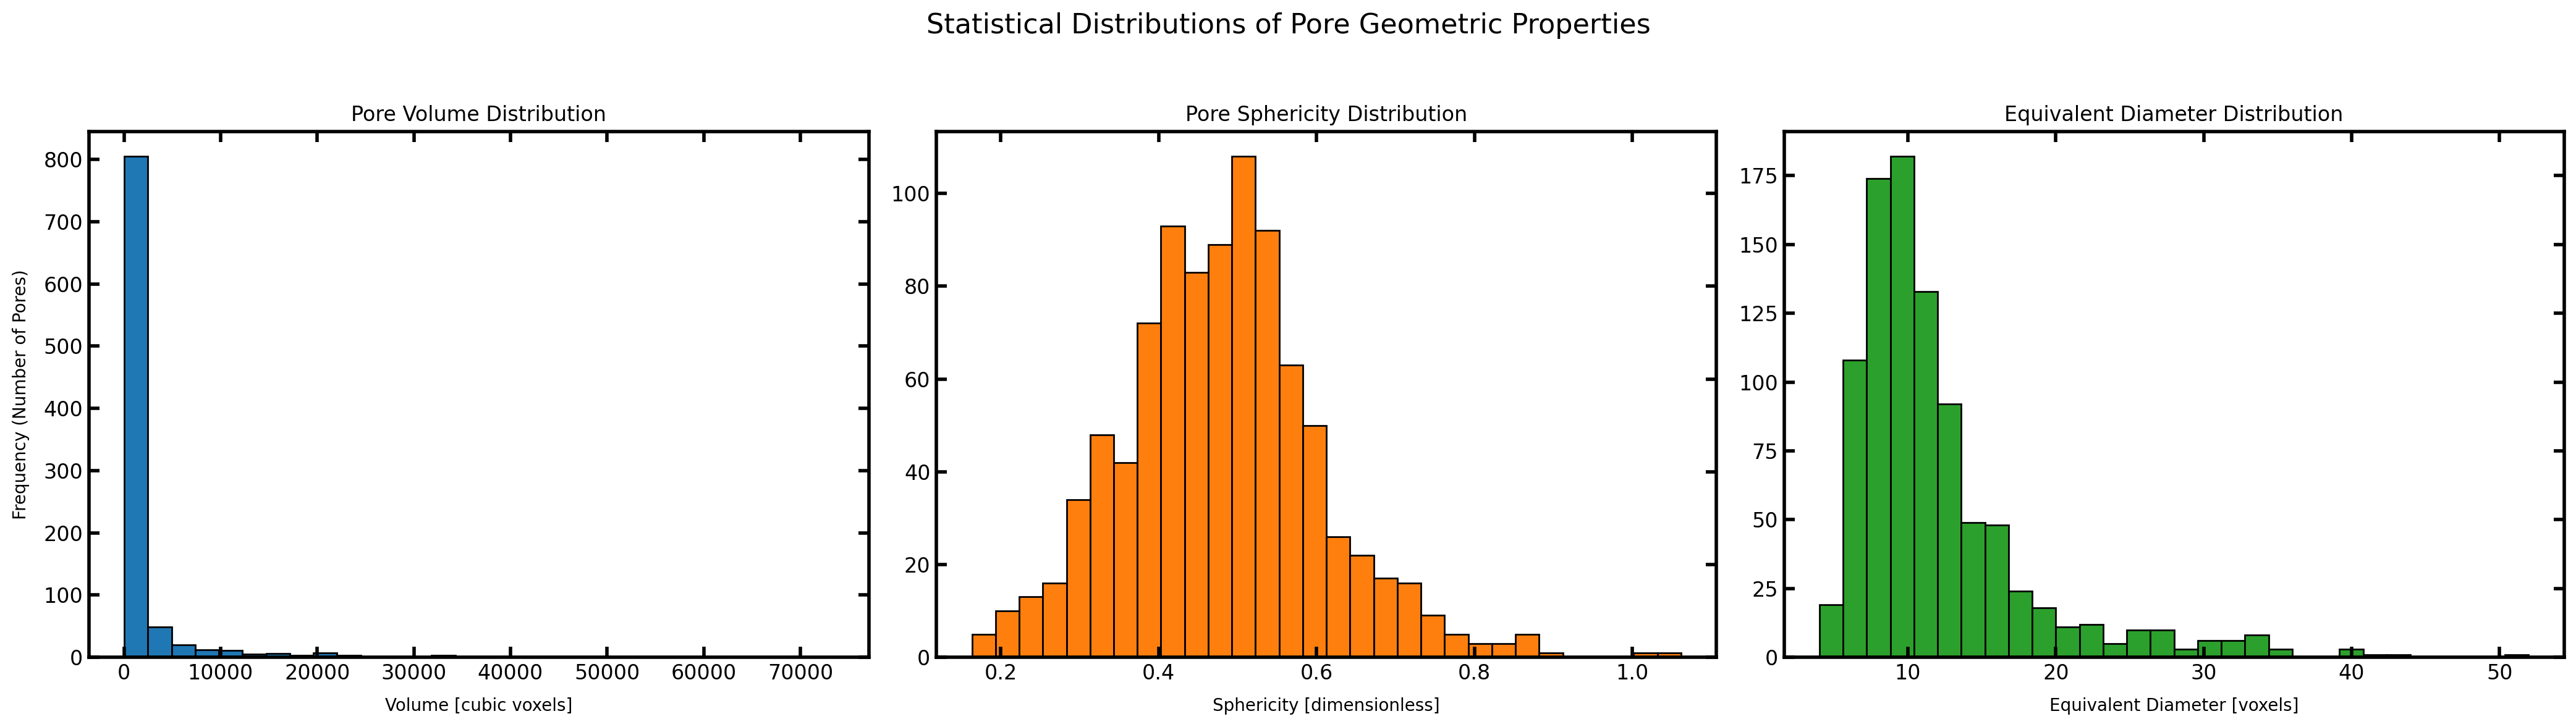


[5] Generating 3D image colored by pore diameter...


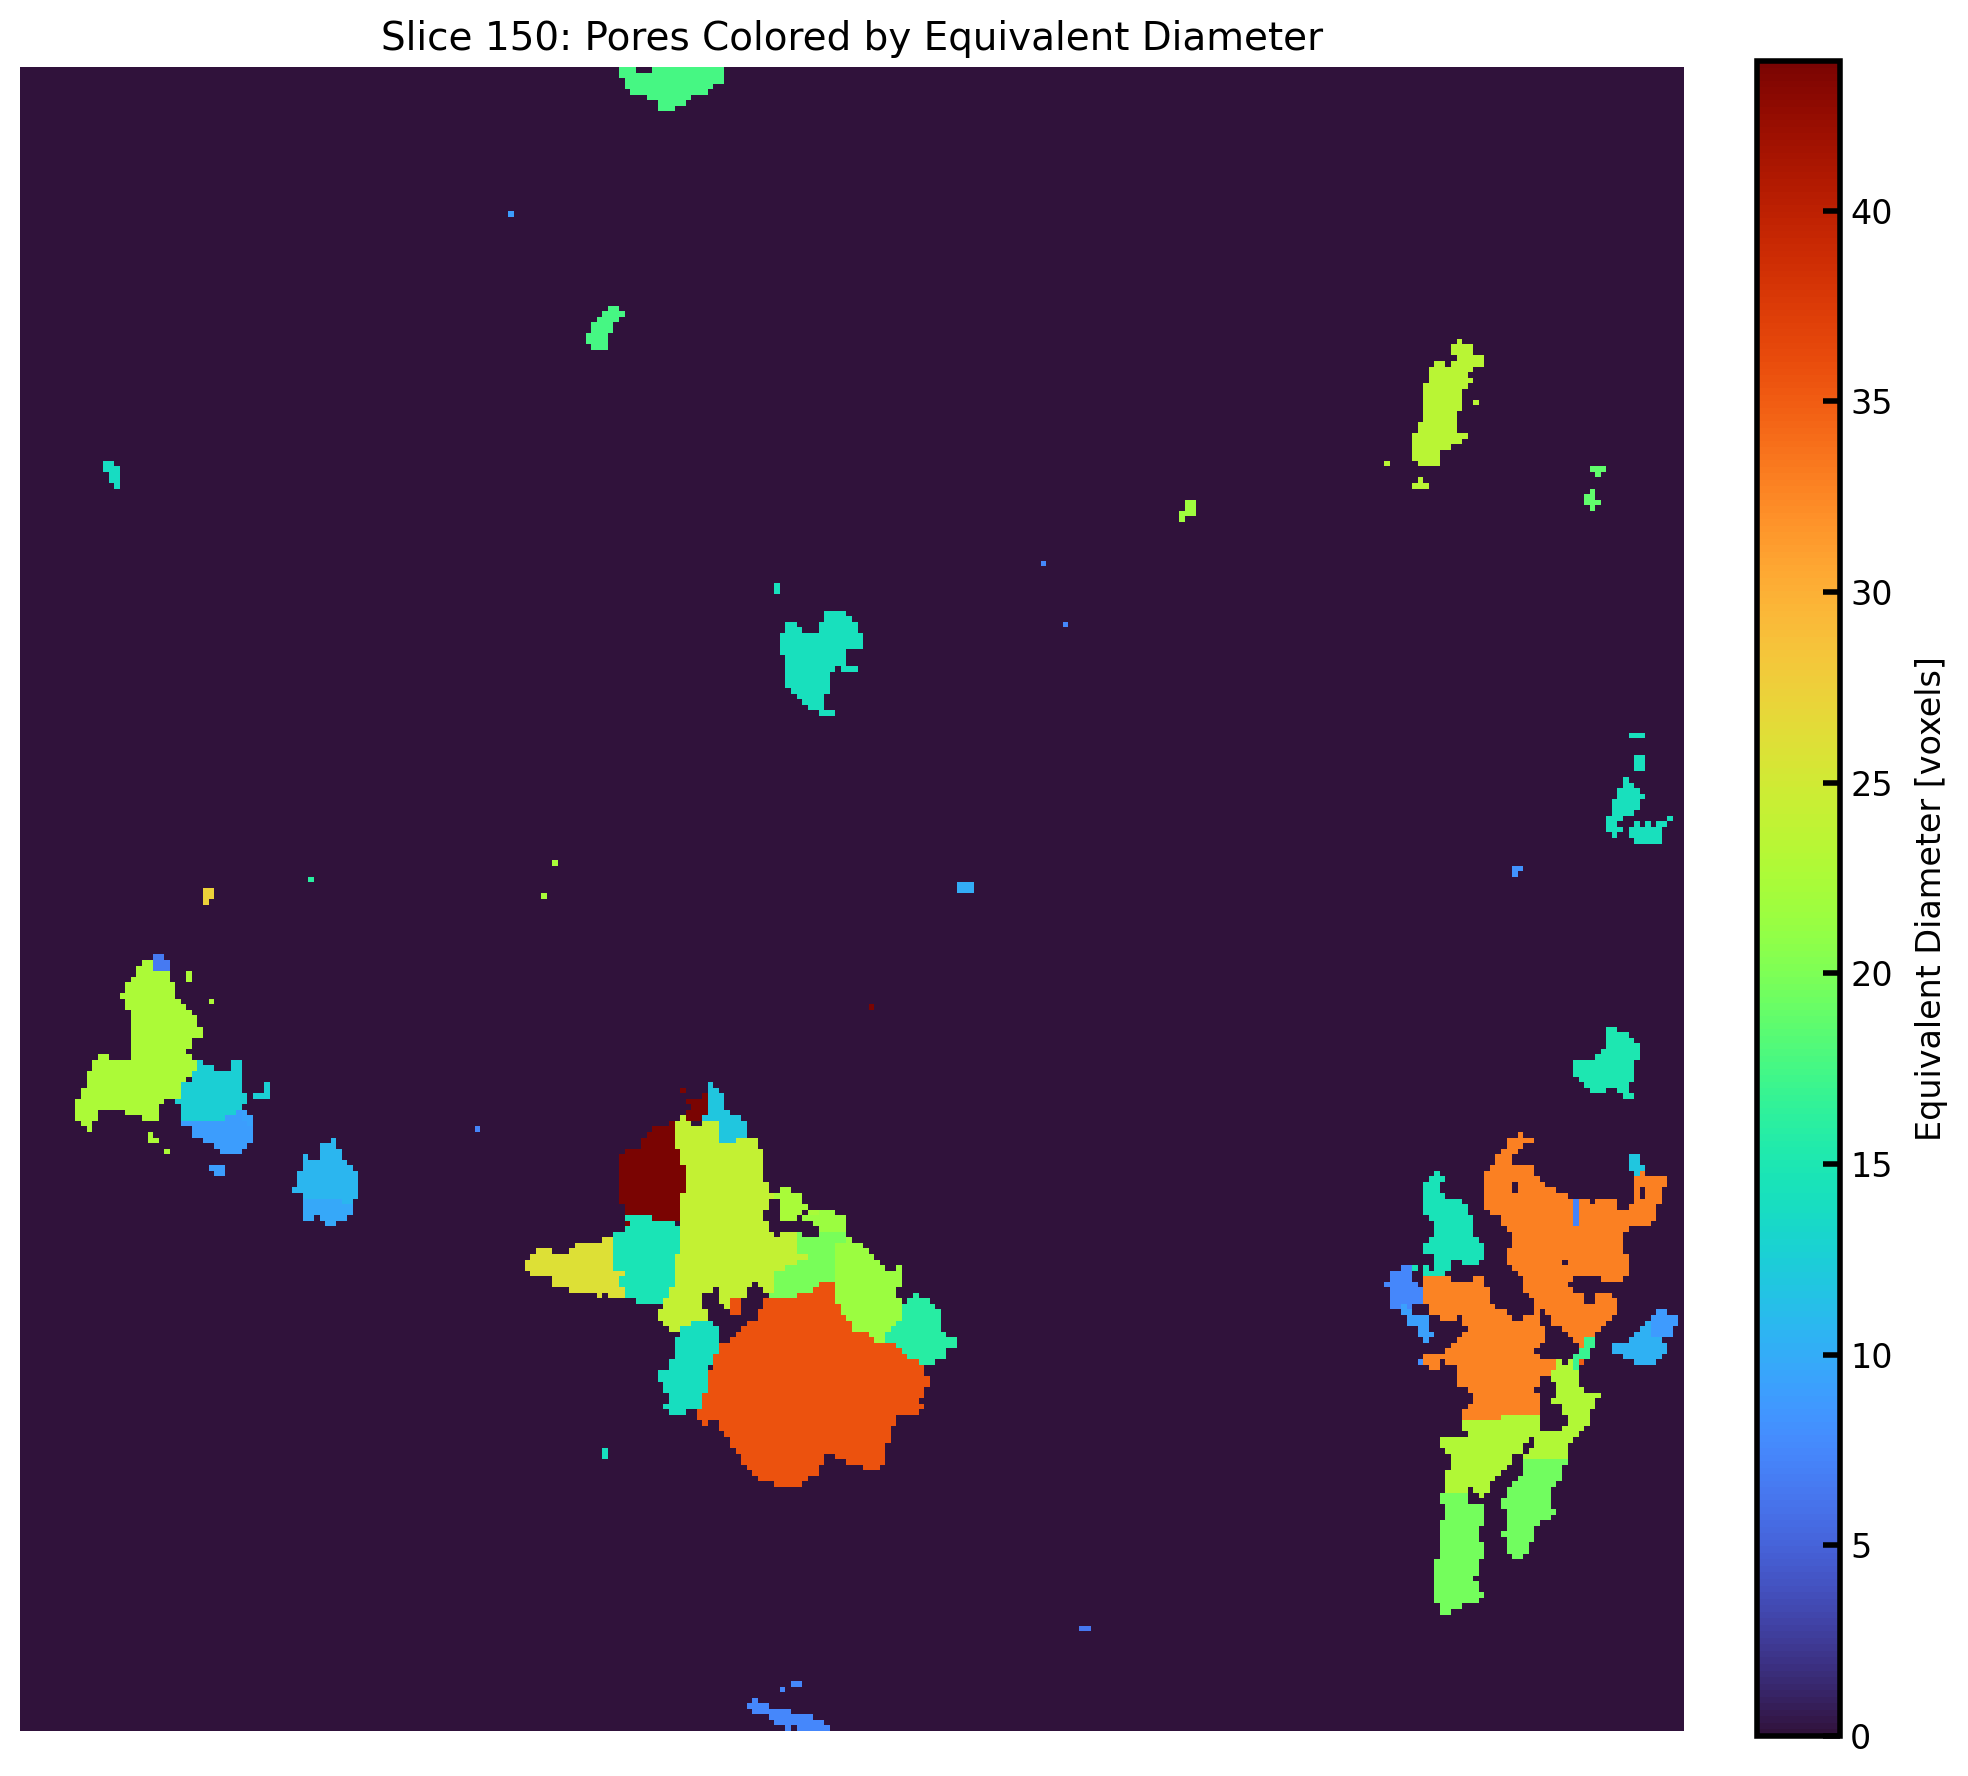

    -> Memory Optimized: Large 3D image arrays released.

[6] Exporting pore properties to an Excel file...

--- WORKFLOW COMPLETE ---
Success: Pore properties data has been exported to:
/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/properties_BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.xlsx


In [5]:
# =============================================================================
#
# SCRIPT FOR PORE SPACE SEGMENTATION AND GEOMETRIC PROPERTY ANALYSIS
#
# WORKFLOW:
# This script takes a binarized 3D image of a porous medium and performs a
# detailed analysis of the pore space. The key stages are:
#   1. Dependency Installation: Ensures the PoreSpy library is available.
#   2. Input Preparation: Assumes a 3D binarized NumPy array
#      (`binarized_3d_image`) is present in the environment.
#   3. Pore Space Segmentation: Employs the SNOW (Sub-Network of an Over-
#      segmented Watershed) algorithm to partition the continuous pore space
#      into distinct, labeled pore regions (or "pore bodies").
#   4. Geometric Property Extraction: Calculates a comprehensive set of
#      geometric properties for each individual pore region.
#   5. Data Visualization: Generates plots to visualize the segmentation results
#      and the statistical distributions of key pore properties.
#   6. Data Export: Saves the extracted properties to an Excel file with a
#      descriptive name derived from the original input file.
#
# OUTPUT:
# - Visualizations of the segmented pore space and property distributions.
# - A pandas DataFrame (`pore_properties_df`) containing the geometric data.
# - An Excel file (`.xlsx`) with the saved pore properties.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# Ensure the PoreSpy library, which contains the analysis algorithms, is installed.
!pip install porespy pandas openpyxl -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import porespy as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'FILE_PATH' variables
# exist in the current runtime environment from the image processing script.

if 'binarized_3d_image' in locals() and 'FILE_PATH' in locals():

    # --- 3.1. Configuration and Input Preparation ---
    # Parameters for the SNOW (Sub-Network of an Over-segmented Watershed) algorithm.
    SNOW_SETTINGS = {
        'r_max': 4,      # The radius of the morphological opening operation.
        'sigma': 0.4   # The standard deviation of the Gaussian blur.
    }

    # The input image convention is True=Solid, False=Pore.
    # Invert the image to analyze the pore space, where True=Pore.
    pore_space = ~binarized_3d_image
    print("Input image inverted for pore space analysis (True = Pore).")

    # --- 3.2. Pore Space Segmentation ---
    print("\n[1] Segmenting the pore space using the SNOW algorithm...")
    print(f"    Settings: r_max={SNOW_SETTINGS['r_max']}, sigma={SNOW_SETTINGS['sigma']}. This may take several minutes.")

    # SNOW partitioning segments the pore space into individual, labeled regions.
    snow_output = ps.filters.snow_partitioning(pore_space, **SNOW_SETTINGS)
    pore_regions = snow_output.regions

    # RAM Optimization: The 'snow_output' object is a container. We only need
    # the 'regions' array, so the container can be deleted.
    del snow_output
    gc.collect()

    print(f"    -> Segmentation complete. Found {pore_regions.max()} distinct pore regions.")

    # --- 3.3. Geometric Property Extraction ---
    print("\n[2] Extracting geometric properties for each pore region...")
    # 'regionprops_3D' calculates metrics like volume, sphericity, diameter, etc.
    pore_props_list = ps.metrics.regionprops_3D(pore_regions)
    print("    -> Property extraction complete.")

    print("\n[3] Organizing results into a pandas DataFrame...")
    # Convert the list of properties into a structured and user-friendly DataFrame.
    pore_properties_df = ps.metrics.props_to_DataFrame(pore_props_list)
    print("    -> DataFrame created successfully.")
    print("\n    Displaying properties for the first 5 discovered pores:")
    display(pore_properties_df.head())

    # --- 3.4. Results Visualization ---
    print("\n[4] Generating analysis plots...")
    ps.visualization.set_mpl_style()
    slice_index = pore_regions.shape[0] // 2

    # Plot 1: Labeled Pore Regions
    plt.figure(figsize=(8, 8))
    plt.imshow(pore_regions[slice_index, :, :], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Slice {slice_index}: Segmented & Labeled Pore Regions', fontsize=14)
    plt.show()

    # Plot 2: Histograms of Key Pore Properties
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle('Statistical Distributions of Pore Geometric Properties', fontsize=16)

    axes[0].hist(pore_properties_df['volume'], bins=30, edgecolor="k", color='#1f77b4')
    axes[0].set_title("Pore Volume Distribution", fontsize=12)
    axes[0].set_xlabel("Volume [cubic voxels]", fontsize=10)
    axes[0].set_ylabel("Frequency (Number of Pores)", fontsize=10)

    axes[1].hist(pore_properties_df['sphericity'], bins=30, edgecolor="k", color='#ff7f0e')
    axes[1].set_title("Pore Sphericity Distribution", fontsize=12)
    axes[1].set_xlabel("Sphericity [dimensionless]", fontsize=10)

    axes[2].hist(pore_properties_df['equivalent_diameter_area'], bins=30, edgecolor="k", color='#2ca02c')
    axes[2].set_title("Equivalent Diameter Distribution", fontsize=12)
    axes[2].set_xlabel("Equivalent Diameter [voxels]", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot 3: Image Colored by Pore Diameter
    print("\n[5] Generating 3D image colored by pore diameter...")
    diameter_image = ps.metrics.prop_to_image(
        regionprops=pore_props_list,
        shape=pore_space.shape,
        prop='equivalent_diameter_area'
    )

    plt.figure(figsize=(10, 10))
    im = plt.imshow(diameter_image[slice_index, :, :], cmap='turbo')
    plt.axis('off')
    plt.title(f'Slice {slice_index}: Pores Colored by Equivalent Diameter', fontsize=14)
    plt.colorbar(im, fraction=0.046, pad=0.04, label='Equivalent Diameter [voxels]')
    plt.show()

    # RAM Optimization: The large 3D arrays are no longer needed.
    del pore_regions, diameter_image, pore_space
    gc.collect()
    print("    -> Memory Optimized: Large 3D image arrays released.")

    # --- 3.5. Data Export ---
    print("\n[6] Exporting pore properties to an Excel file...")
    try:
        # Generate a descriptive output filename based on the input file.
        # This section now correctly uses the consistent 'FILE_PATH' variable.
        base_name = os.path.basename(FILE_PATH)
        name_without_ext = os.path.splitext(base_name)[0]
        output_filename = f'properties_{name_without_ext}.xlsx'
        output_directory = os.path.dirname(FILE_PATH)
        output_excel_path = os.path.join(output_directory, output_filename)

        # Save the DataFrame to a sheet named 'Pore Properties'.
        pore_properties_df.to_excel(output_excel_path, sheet_name='Pore Properties', index=False)

        print("\n--- WORKFLOW COMPLETE ---")
        print(f"Success: Pore properties data has been exported to:")
        print(f"{output_excel_path}")

    except Exception as e:
        print("\nWARNING: Could not save file to the original directory.")
        fallback_path = '/content/drive/MyDrive/pore_properties_fallback.xlsx'
        pore_properties_df.to_excel(fallback_path, sheet_name='Pore Properties', index=False)
        print(f"As a fallback, the file was saved to: {fallback_path}")
        print(f"Error details: {e}")

else:
    # Error message if the prerequisite variables are not found.
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'FILE_PATH' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.

[1] Loading pore properties from: '/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/properties_BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.xlsx'
    -> Success. Loaded data for 927 pores.

[2] Converting voxel-based metrics to physical units (voxel size: 40.0 µm)...
    -> Unit conversion complete.

--- A. Descriptive Statistics (Physical Units) ---



--- B. Correlation Analysis ---


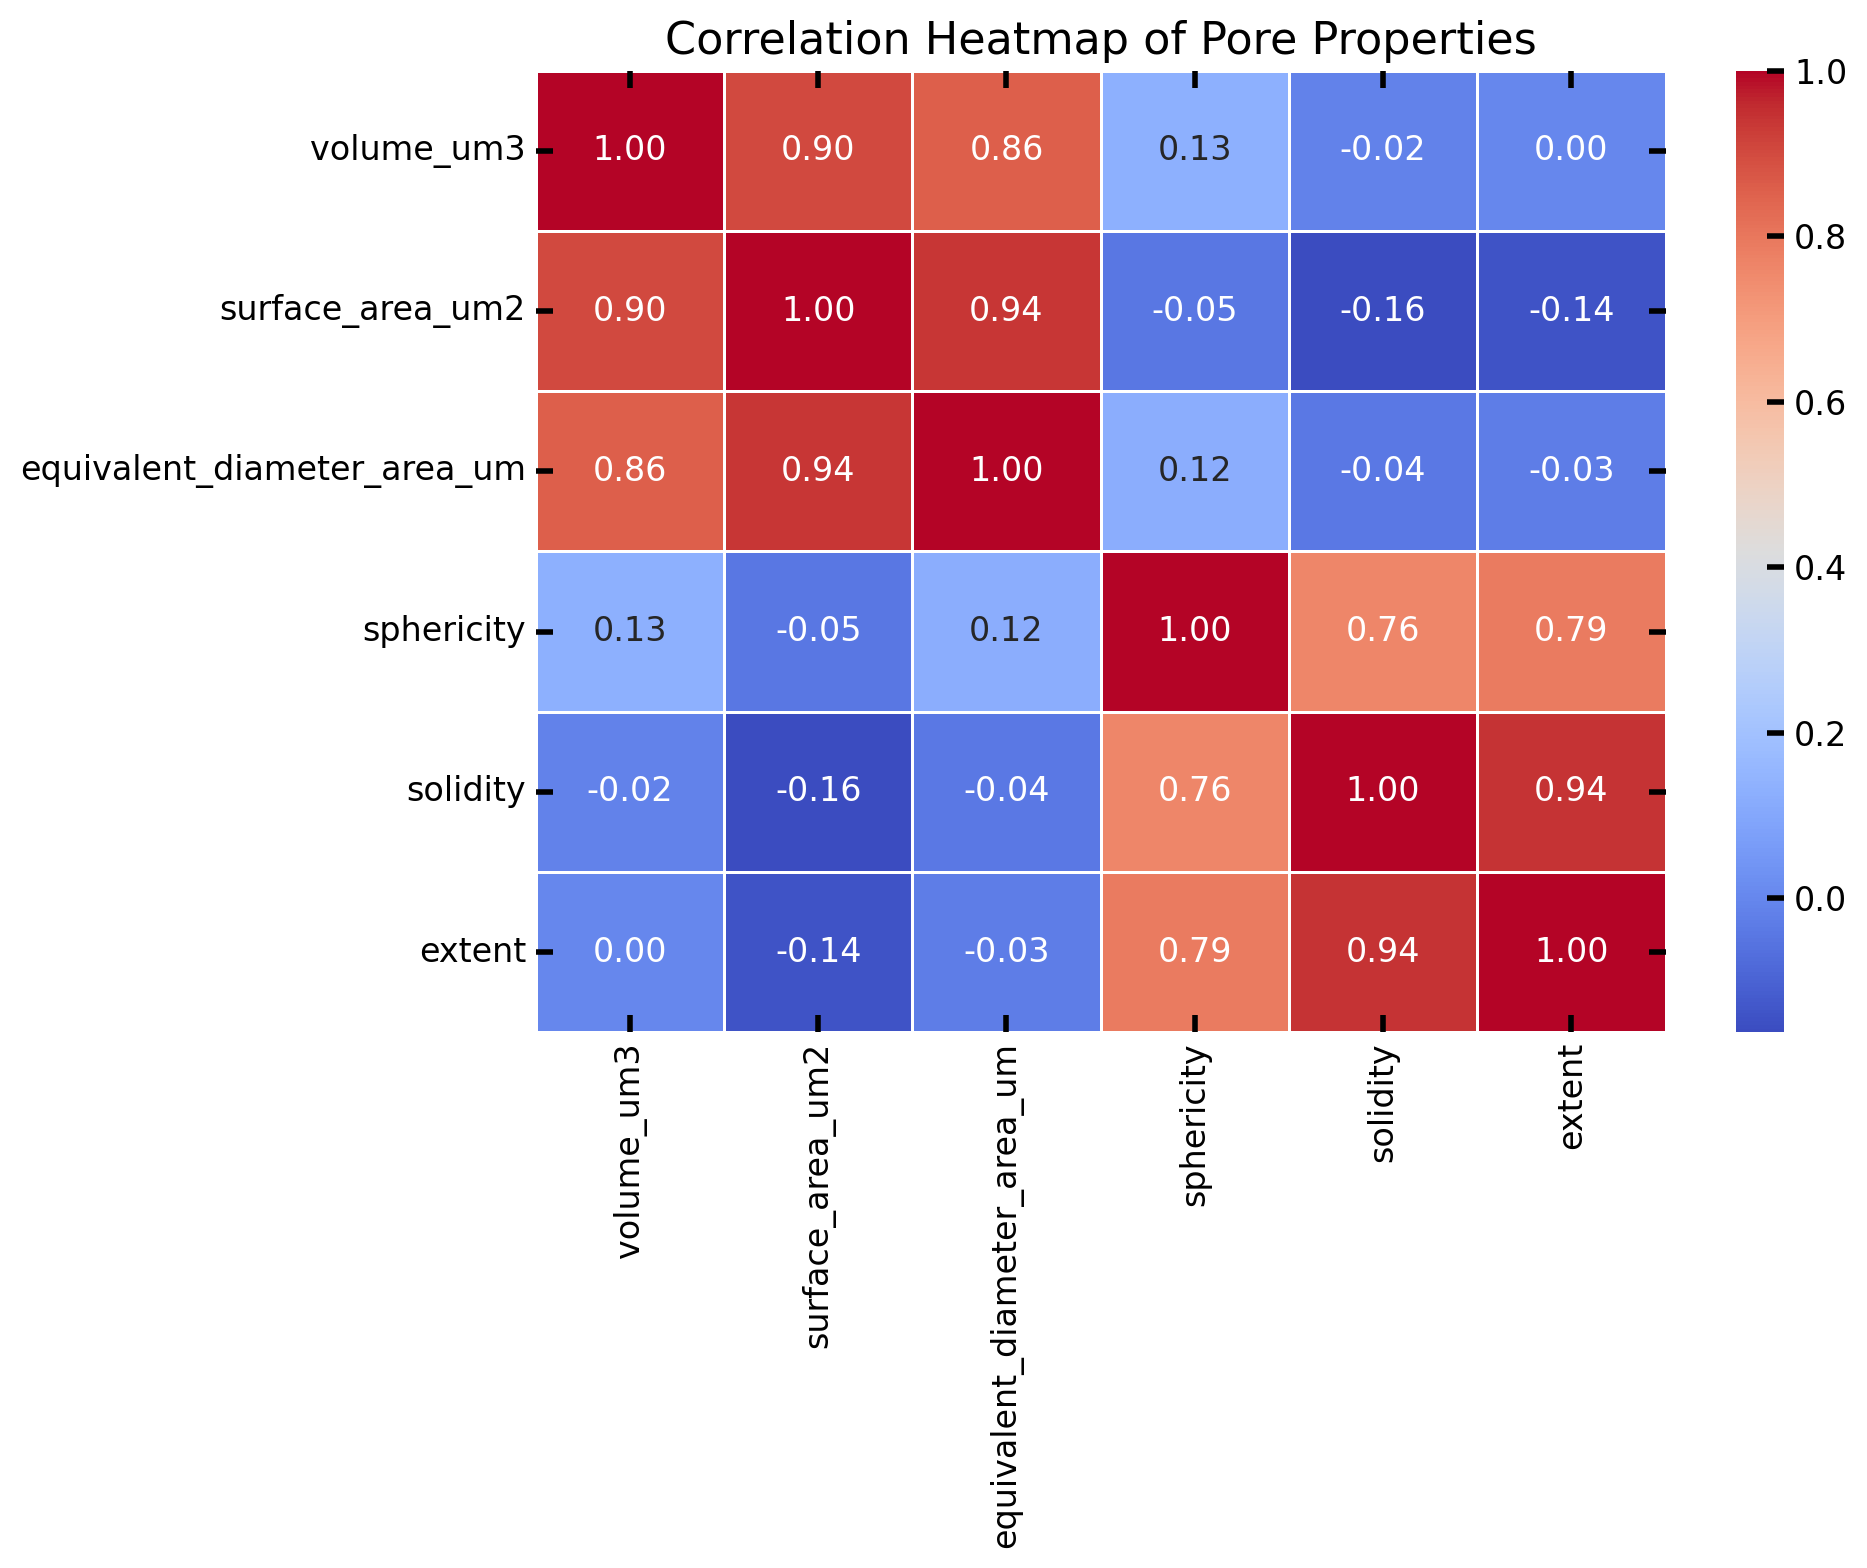


--- C. Pore Size Distribution (PSD) Analysis ---


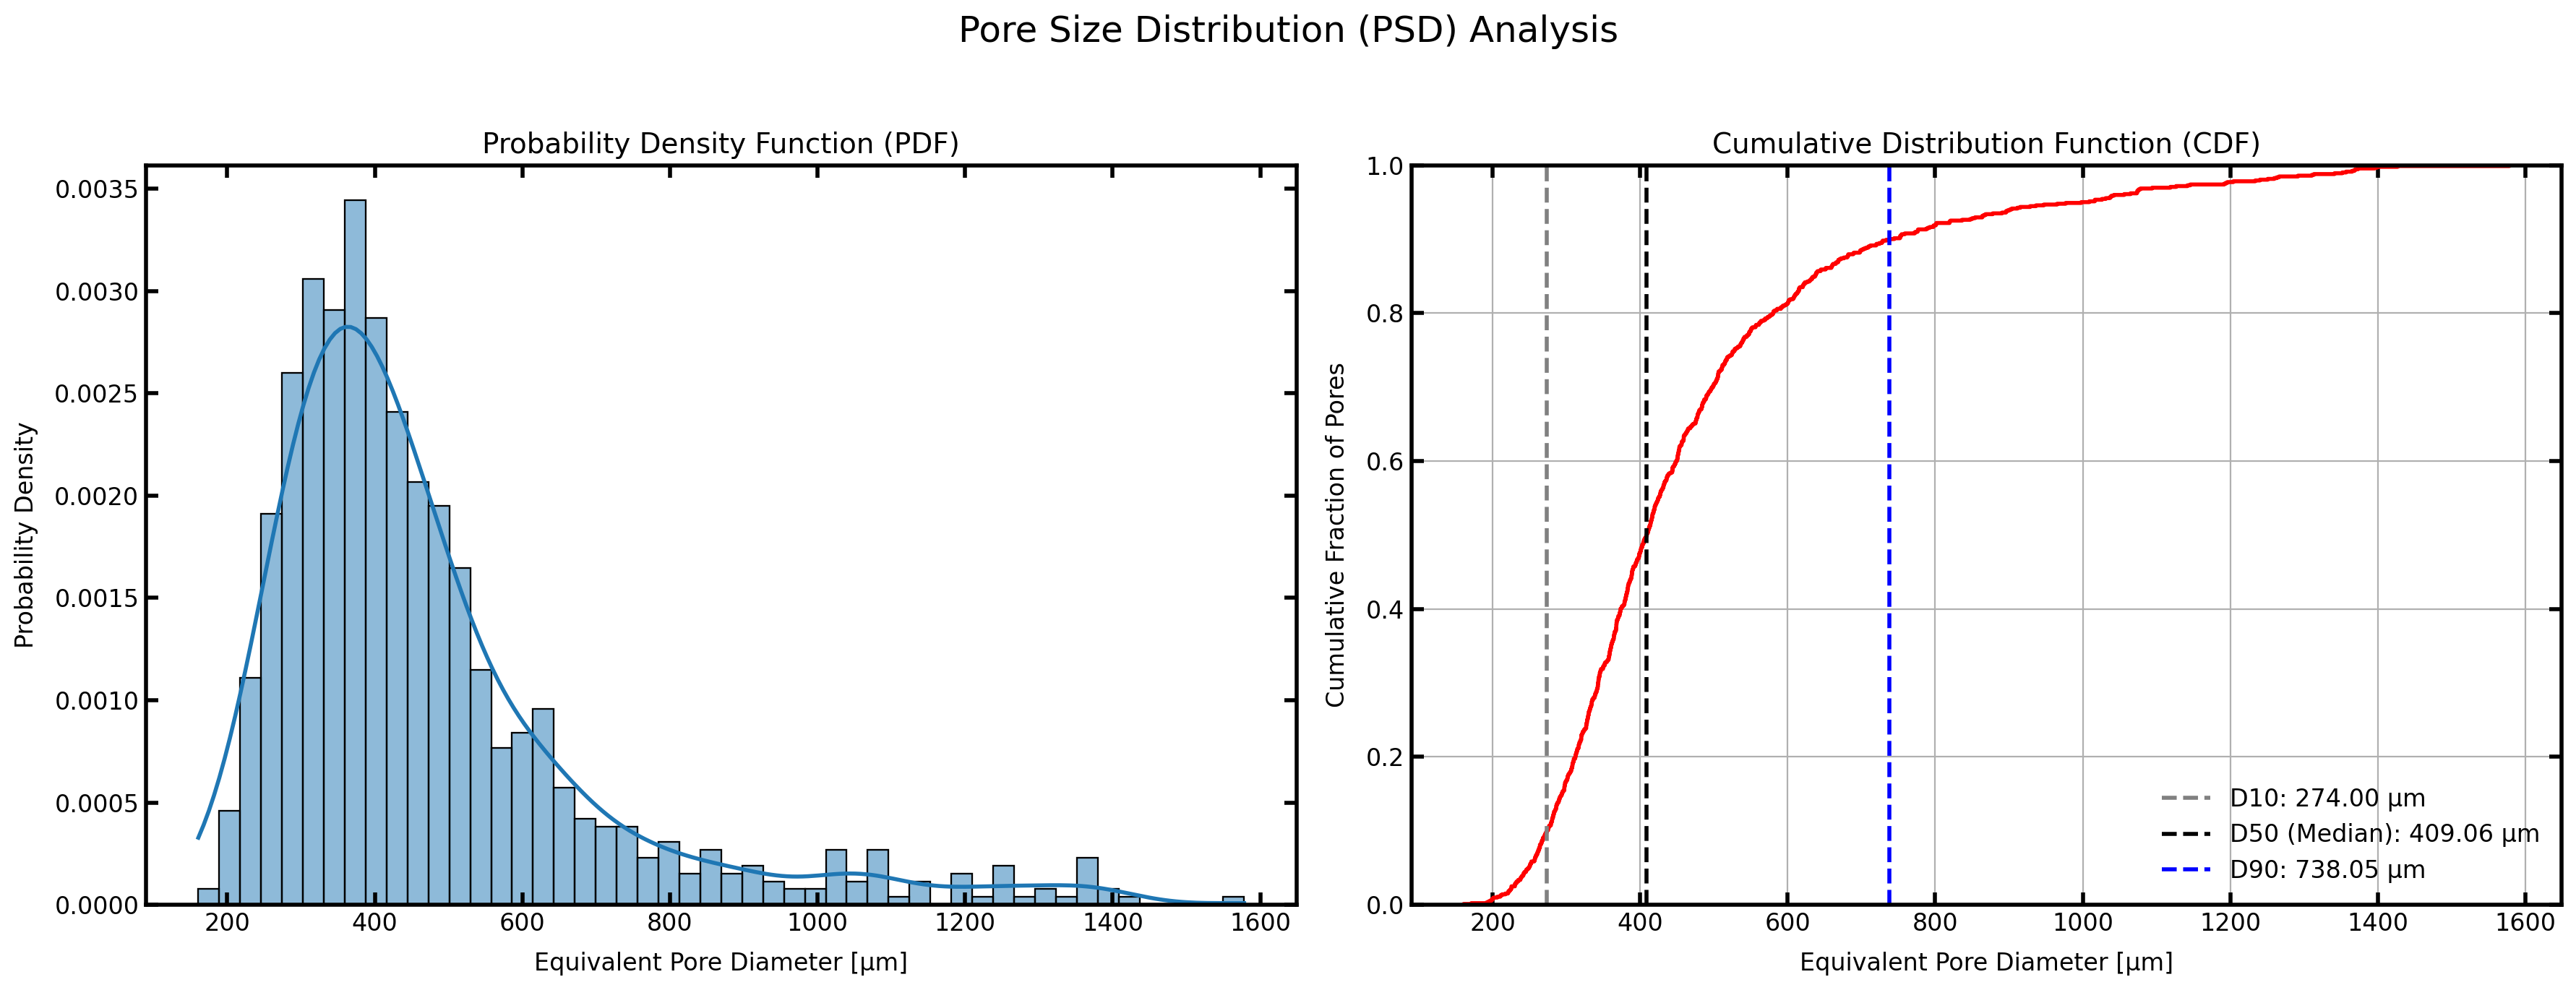


--- D. Morphological Classification ---


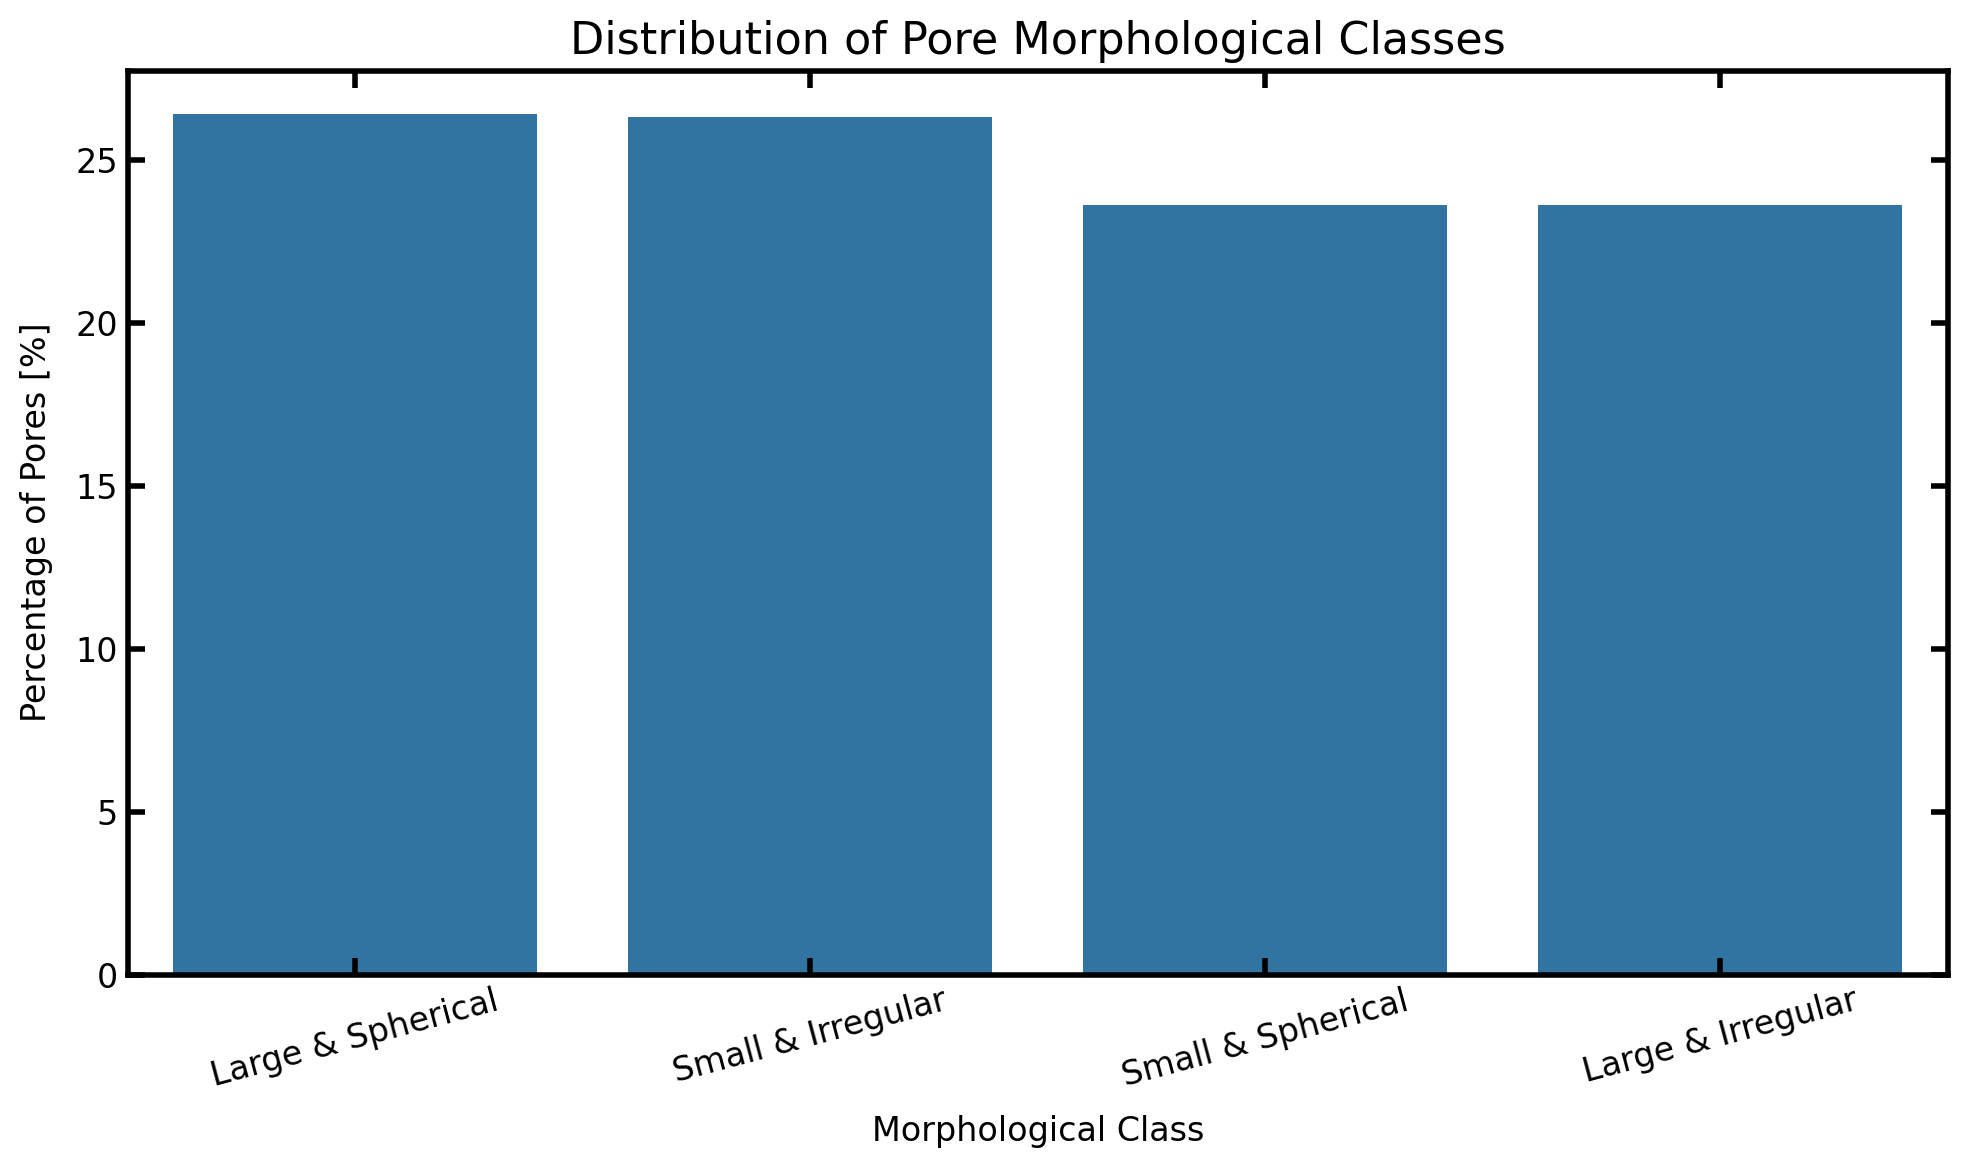


--- E. Analysis of Pore Elongation (Aspect Ratio) ---


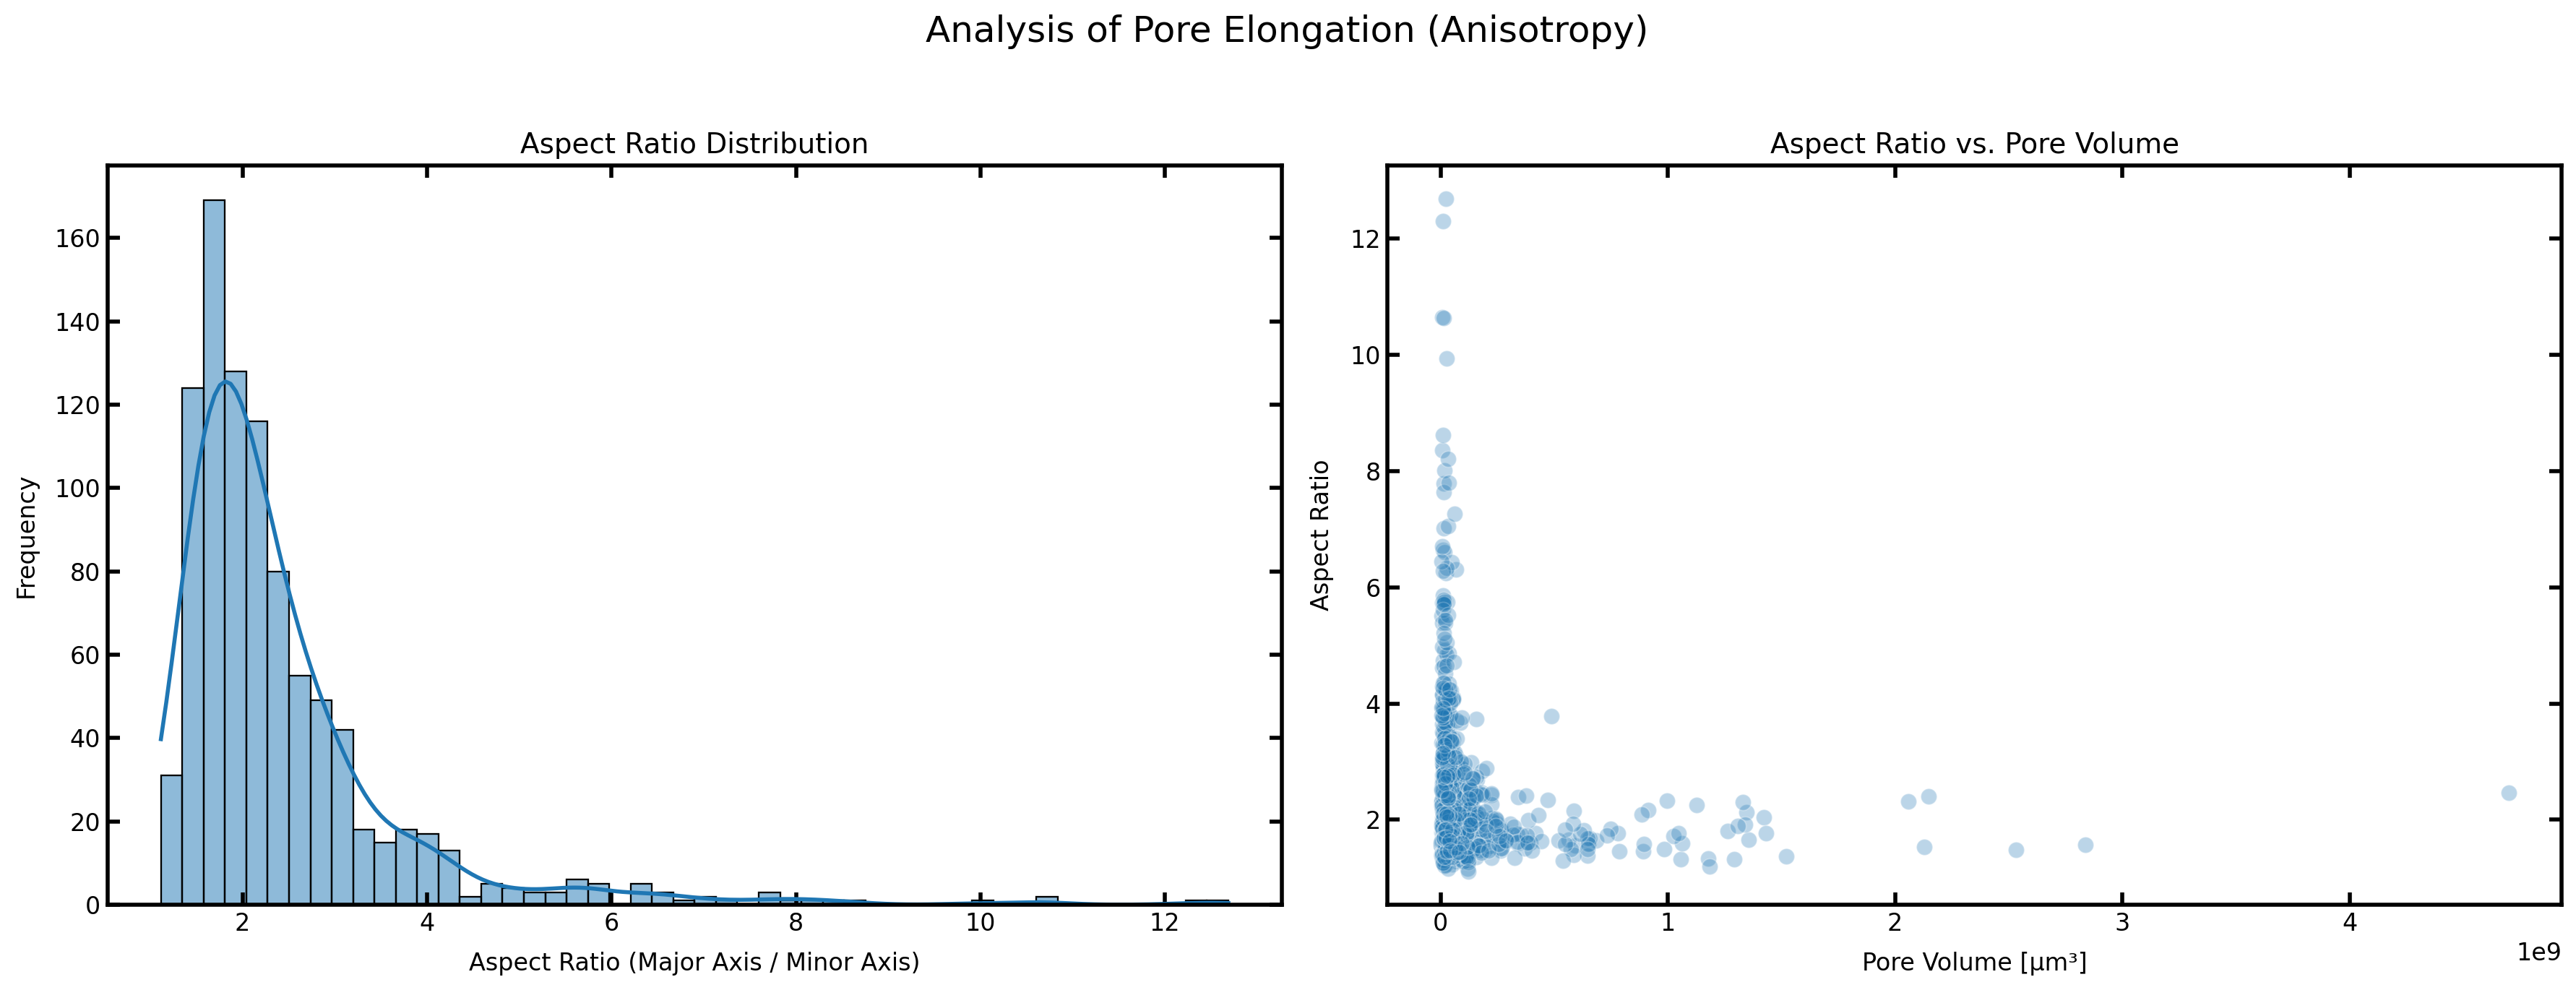


--- F. Analysis of Topological Complexity (Euler Number) ---


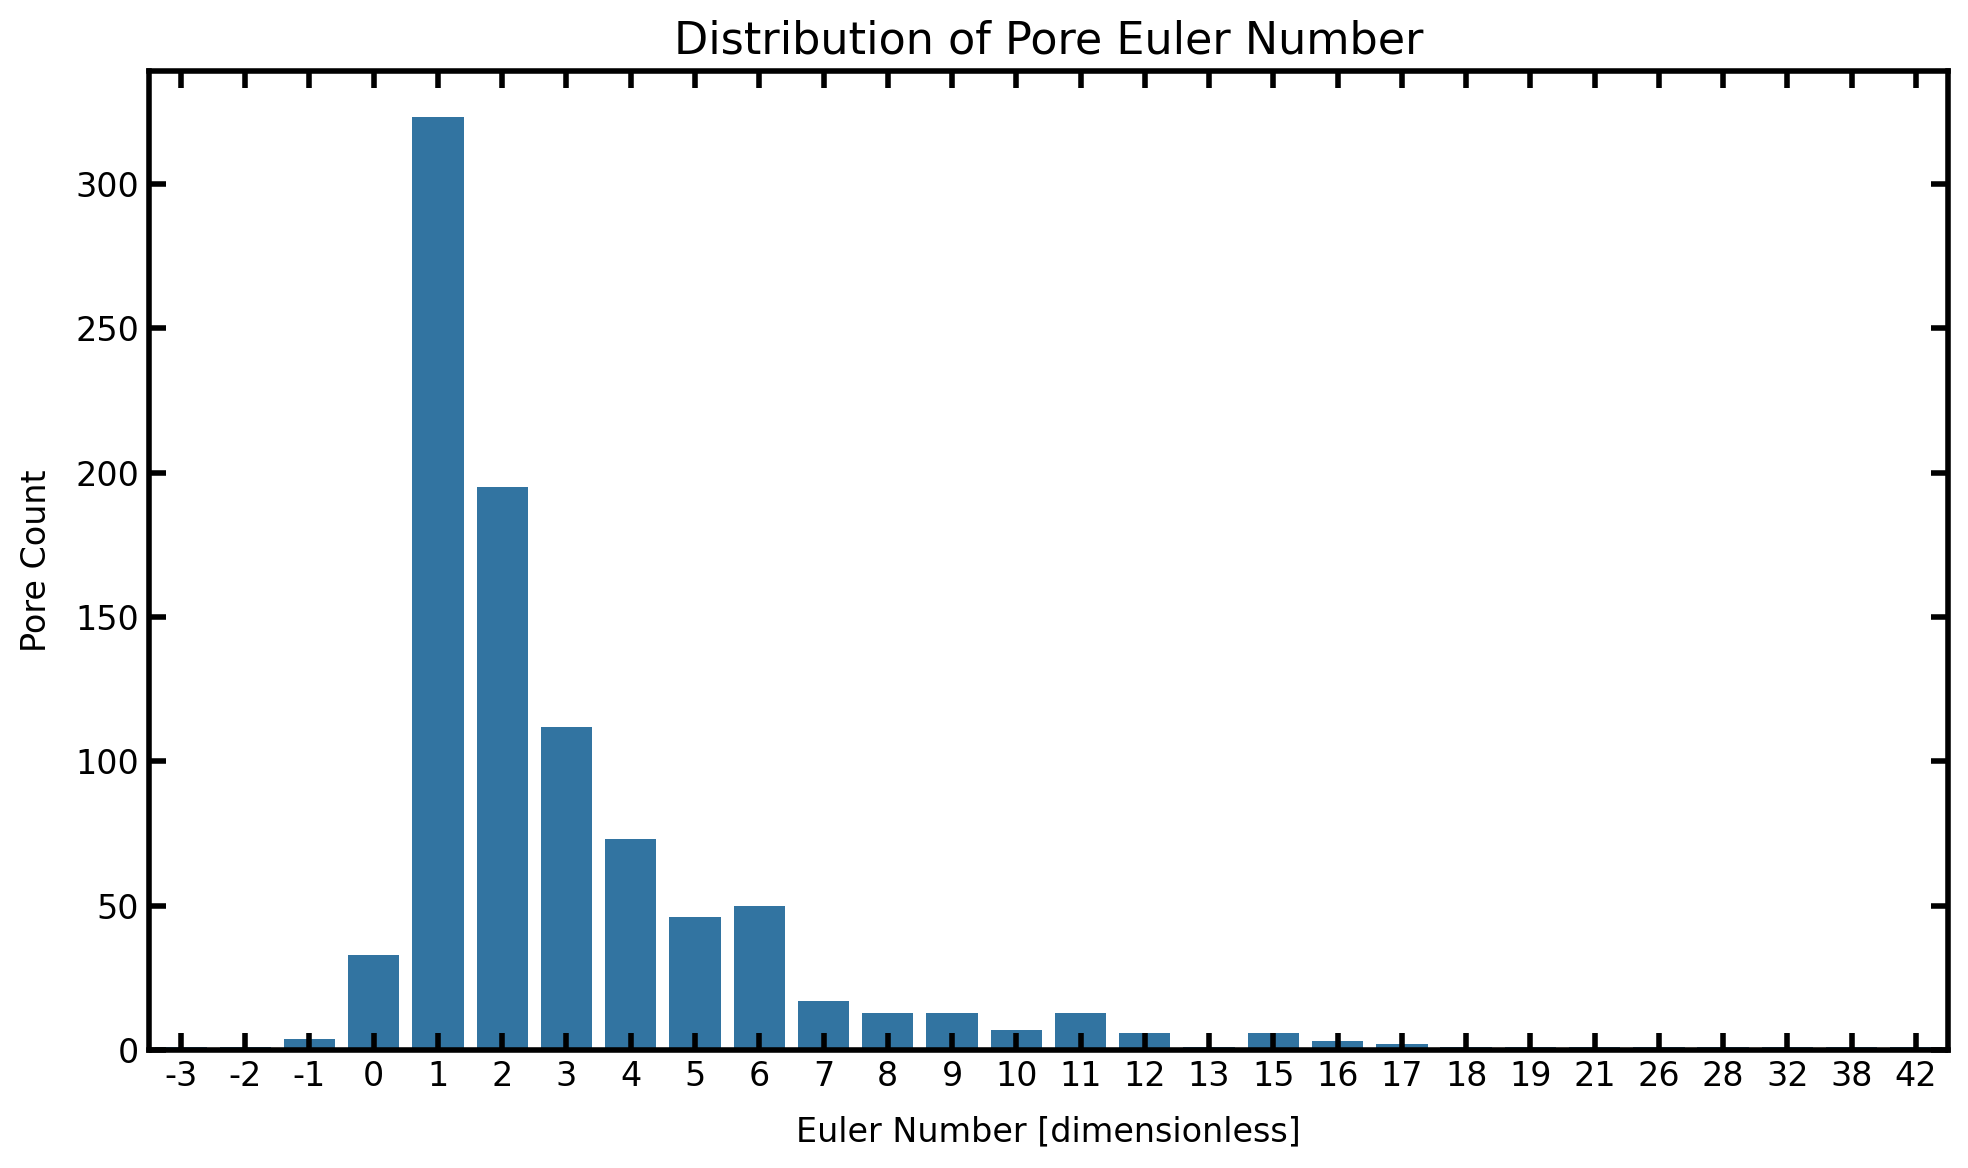


Pore counts by topological complexity:
euler_number
 1     323
 2     195
 3     112
 4      73
 6      50
 5      46
 0      33
 7      17
 9      13
 11     13
 8      13
 10      7
 15      6
 12      6
-1       4
 16      3
 17      2
-2       1
 38      1
 13      1
 26      1
 18      1
 42      1
 21      1
-3       1
 19      1
 28      1
 32      1
Name: count, dtype: int64

--- G. Analysis of Volumetric Filling Efficiency (Extent) ---


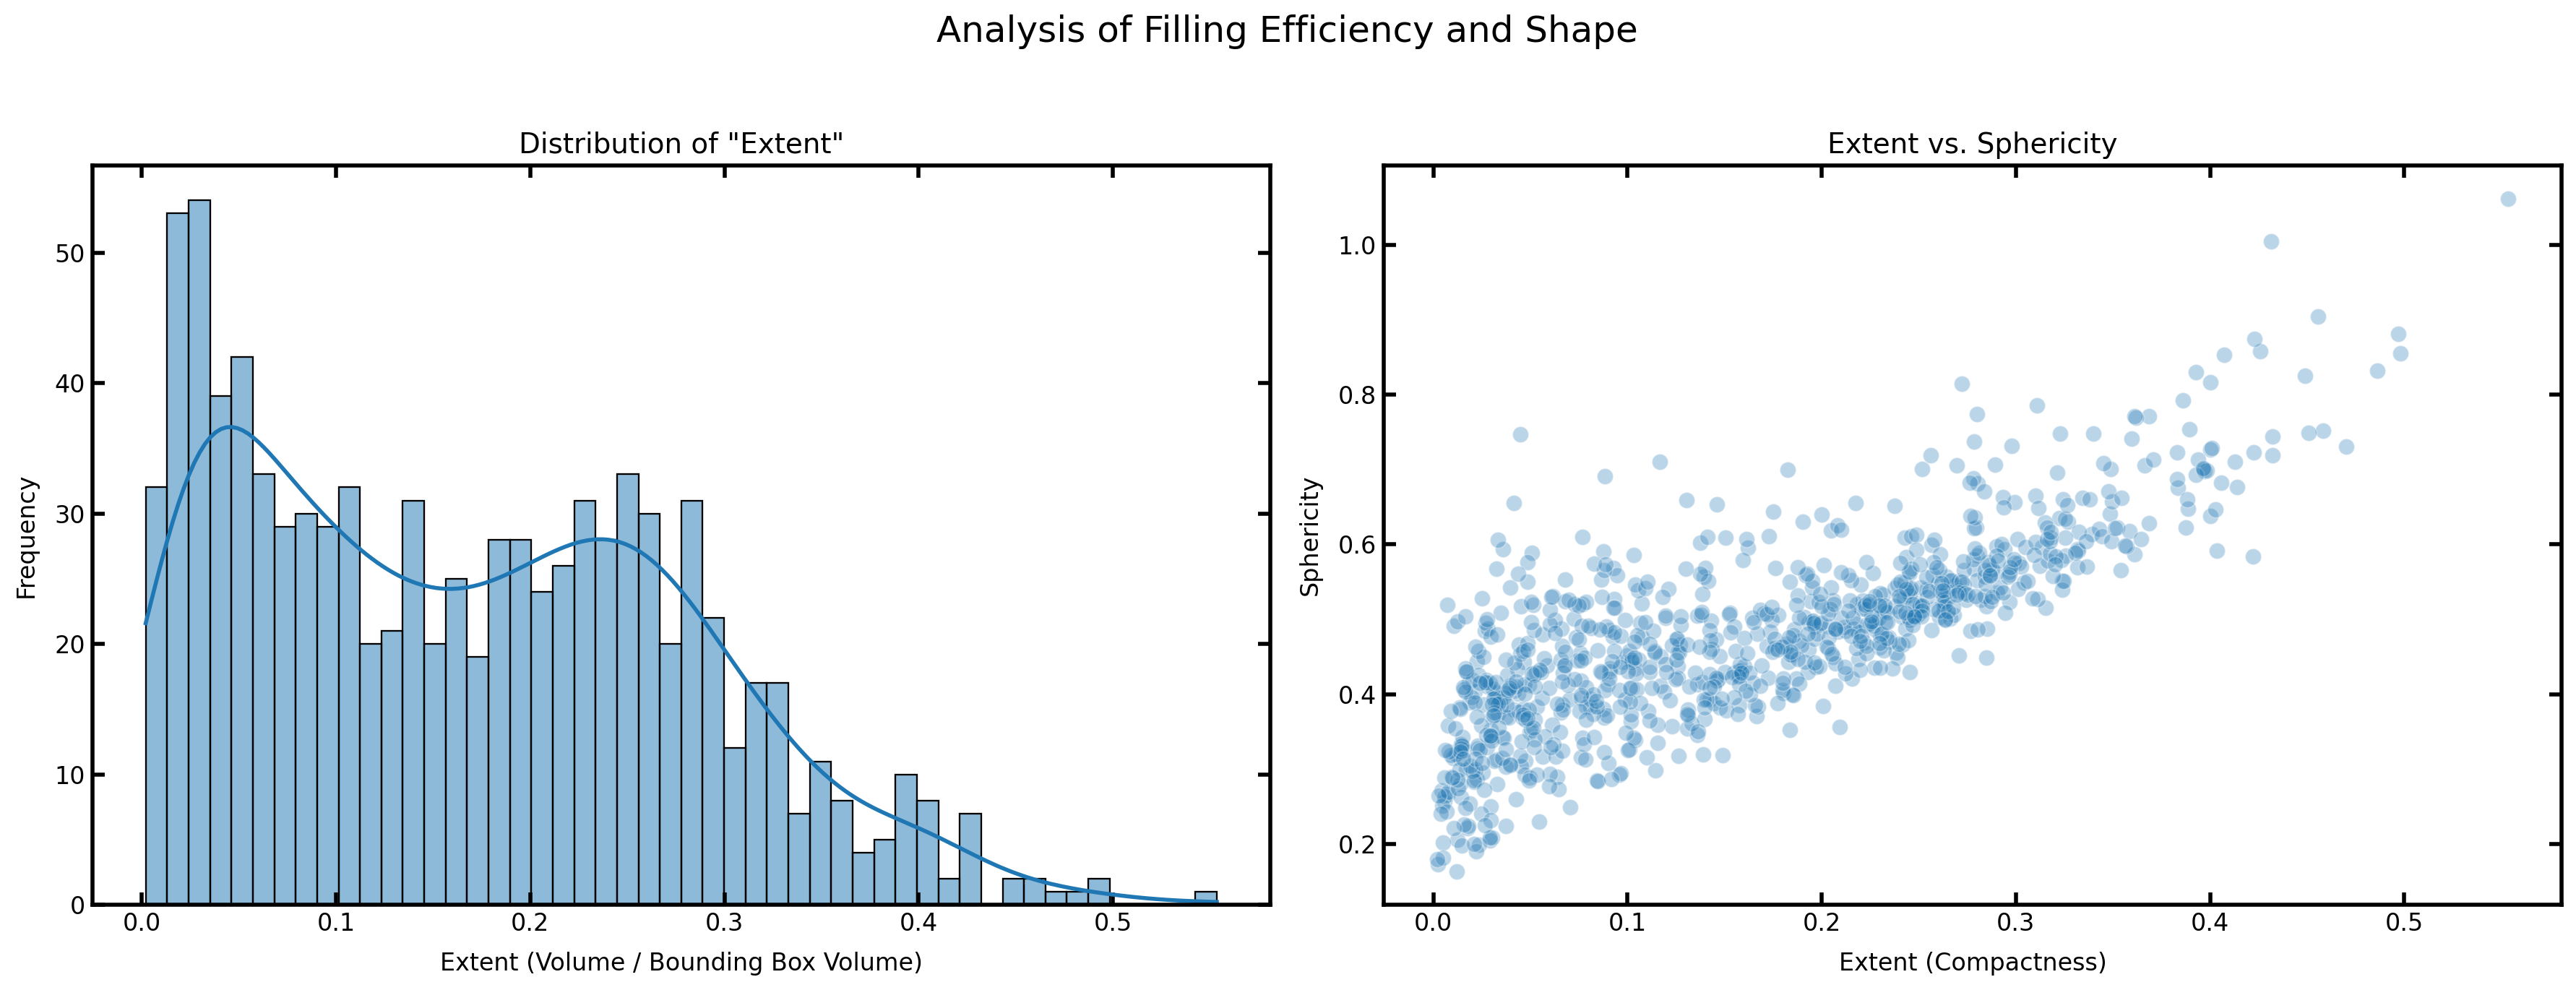

In [6]:
# =============================================================================
#
# SCRIPT FOR STATISTICAL ANALYSIS OF EXTRACTED PORE PROPERTIES
#
# WORKFLOW:
# This script loads the geometric properties of a pore network from an Excel
# file (generated by a previous analysis step) and performs a comprehensive
# statistical and visual analysis. The key stages are:
#
#   1. Dependency Installation: Ensures all required data analysis and
#      visualization libraries are present.
#   2. Input and Configuration: Assumes the Excel file path and voxel size
#      are available from previous steps.
#   3. Data Loading and Unit Conversion: Loads the data and converts voxel-based
#      metrics to physical units (microns).
#   4. Statistical Analysis & Visualization: A series of analyses are performed:
#      a. Descriptive Statistics Summary.
#      b. Correlation analysis between key geometric properties.
#      c. Pore Size Distribution (PSD) analysis (PDF and CDF).
#      d. Morphological classification of pores.
#      e. Advanced analysis of pore shape: aspect ratio, topological complexity
#         (Euler number), and volumetric efficiency (extent).
#
# OUTPUT:
# A comprehensive suite of tables and plots providing a deep insight into the
# geometric and topological characteristics of the analyzed pore network.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install pandas openpyxl seaborn -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'output_excel_path' and 'voxel_size' variables
# exist in the current runtime environment from the previous scripts.

if 'output_excel_path' in locals() and 'voxel_size' in locals():

    # --- 3.1. Configuration and Helper Functions ---
    CONFIG = {
        'descriptive_cols': ['volume_um3', 'surface_area_um2', 'equivalent_diameter_area_um', 'sphericity', 'solidity'],
        'correlation_cols': ['volume_um3', 'surface_area_um2', 'equivalent_diameter_area_um', 'sphericity', 'solidity', 'extent'],
        'psd_outlier_quantile': 0.995,
        'scatter_sample_size': 5000
    }

    def classify_pore_morphology(row: pd.Series, median_diameter: float, median_sphericity: float) -> str:
        """Classifies a pore based on its size and sphericity relative to median values."""
        is_large = row['equivalent_diameter_area_um'] >= median_diameter
        is_spherical = row['sphericity'] >= median_sphericity
        if is_large and is_spherical: return 'Large & Spherical'
        if is_large and not is_spherical: return 'Large & Irregular'
        if not is_large and is_spherical: return 'Small & Spherical'
        return 'Small & Irregular'

    def calculate_aspect_ratio(row: pd.Series) -> float:
        """Calculates the aspect ratio, handling potential division by zero."""
        if row['axis_minor_length_um'] > 0:
            return row['axis_major_length_um'] / row['axis_minor_length_um']
        return np.nan

    # --- 3.2. Data Loading and Preparation ---
    try:
        print(f"\n[1] Loading pore properties from: '{output_excel_path}'")
        df_analysis = pd.read_excel(output_excel_path)
        print(f"    -> Success. Loaded data for {len(df_analysis)} pores.")

        print(f"\n[2] Converting voxel-based metrics to physical units (voxel size: {voxel_size} µm)...")
        df_analysis['volume_um3'] = df_analysis['volume'] * (voxel_size ** 3)
        df_analysis['surface_area_um2'] = df_analysis['surface_area'] * (voxel_size ** 2)
        df_analysis['equivalent_diameter_area_um'] = df_analysis['equivalent_diameter_area'] * voxel_size
        df_analysis['axis_major_length_um'] = df_analysis['axis_major_length'] * voxel_size
        df_analysis['axis_minor_length_um'] = df_analysis['axis_minor_length'] * voxel_size
        print("    -> Unit conversion complete.")

        # --- 3.3. Descriptive Statistics ---
        print("\n--- A. Descriptive Statistics (Physical Units) ---")
        descriptive_stats = df_analysis[CONFIG['descriptive_cols']].describe()
        display(descriptive_stats.style.format("{:,.2f}"))

        # --- 3.4. Correlation Analysis ---
        print("\n--- B. Correlation Analysis ---")
        correlation_matrix = df_analysis[CONFIG['correlation_cols']].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Heatmap of Pore Properties', fontsize=16)
        plt.show()

        # --- 3.5. Pore Size Distribution (PSD) Analysis ---
        print("\n--- C. Pore Size Distribution (PSD) Analysis ---")
        pore_diameters = df_analysis['equivalent_diameter_area_um']
        # Filter out extreme outliers for better visualization
        upper_limit = pore_diameters.quantile(CONFIG['psd_outlier_quantile'])
        filtered_diameters = pore_diameters[pore_diameters < upper_limit]

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        fig.suptitle('Pore Size Distribution (PSD) Analysis', fontsize=18)

        sns.histplot(filtered_diameters, bins=50, kde=True, stat="density", ax=axes[0])
        axes[0].set_title('Probability Density Function (PDF)', fontsize=14)
        axes[0].set_xlabel('Equivalent Pore Diameter [µm]')
        axes[0].set_ylabel('Probability Density')

        sns.ecdfplot(filtered_diameters, ax=axes[1], color='r')
        axes[1].set_title('Cumulative Distribution Function (CDF)', fontsize=14)
        axes[1].set_xlabel('Equivalent Pore Diameter [µm]')
        axes[1].set_ylabel('Cumulative Fraction of Pores')
        d10, d50, d90 = filtered_diameters.quantile([0.1, 0.5, 0.9])
        axes[1].axvline(d10, color='gray', linestyle='--', label=f'D10: {d10:.2f} µm')
        axes[1].axvline(d50, color='black', linestyle='--', label=f'D50 (Median): {d50:.2f} µm')
        axes[1].axvline(d90, color='blue', linestyle='--', label=f'D90: {d90:.2f} µm')
        axes[1].legend(); axes[1].grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

        # --- 3.6. Morphological Classification ---
        print("\n--- D. Morphological Classification ---")
        median_diameter = df_analysis['equivalent_diameter_area_um'].median()
        median_sphericity = df_analysis['sphericity'].median()
        df_analysis['morphological_class'] = df_analysis.apply(
            classify_pore_morphology,
            axis=1,
            median_diameter=median_diameter,
            median_sphericity=median_sphericity
        )
        class_counts = df_analysis['morphological_class'].value_counts(normalize=True) * 100
        plt.figure(figsize=(10, 6))
        sns.barplot(x=class_counts.index, y=class_counts.values)
        plt.title('Distribution of Pore Morphological Classes', fontsize=16)
        plt.ylabel('Percentage of Pores [%]'); plt.xlabel('Morphological Class')
        plt.xticks(rotation=15); plt.show()

        # --- 3.7. Advanced Analysis: Elongation (Aspect Ratio) ---
        print("\n--- E. Analysis of Pore Elongation (Aspect Ratio) ---")
        df_analysis['aspect_ratio'] = df_analysis.apply(calculate_aspect_ratio, axis=1)
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        fig.suptitle('Analysis of Pore Elongation (Anisotropy)', fontsize=18)

        sns.histplot(df_analysis['aspect_ratio'].dropna(), bins=50, kde=True, ax=axes[0])
        axes[0].set_title('Aspect Ratio Distribution', fontsize=14)
        axes[0].set_xlabel('Aspect Ratio (Major Axis / Minor Axis)'); axes[0].set_ylabel('Frequency')

        sample_data = df_analysis.sample(n=min(CONFIG['scatter_sample_size'], len(df_analysis)))
        sns.scatterplot(data=sample_data, x='volume_um3', y='aspect_ratio', alpha=0.3, ax=axes[1])
        axes[1].set_title('Aspect Ratio vs. Pore Volume', fontsize=14)
        axes[1].set_xlabel('Pore Volume [µm³]'); axes[1].set_ylabel('Aspect Ratio')
        axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

        # --- 3.8. Advanced Analysis: Topological Complexity (Euler Number) ---
        print("\n--- F. Analysis of Topological Complexity (Euler Number) ---")
        # The Euler number relates to the connectivity of an object. For a 3D pore:
        # 1 = simple sphere, 0 = torus (one hole), <0 = more complex handles/tunnels.
        euler_counts = df_analysis['euler_number'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=euler_counts.index, y=euler_counts.values)
        plt.title('Distribution of Pore Euler Number', fontsize=16)
        plt.xlabel('Euler Number [dimensionless]'); plt.ylabel('Pore Count')
        plt.show()
        print("\nPore counts by topological complexity:"); print(euler_counts)

        # --- 3.9. Advanced Analysis: Volumetric Efficiency (Extent) ---
        print("\n--- G. Analysis of Volumetric Filling Efficiency (Extent) ---")
        # Extent is the ratio of the pore's volume to the volume of its bounding box.
        # Values near 1 are compact (e.g., cube), low values are sparse or elongated.
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        fig.suptitle('Analysis of Filling Efficiency and Shape', fontsize=18)

        sns.histplot(df_analysis['extent'], bins=50, kde=True, ax=axes[0])
        axes[0].set_title('Distribution of "Extent"', fontsize=14)
        axes[0].set_xlabel('Extent (Volume / Bounding Box Volume)'); axes[0].set_ylabel('Frequency')

        sns.scatterplot(data=sample_data, x='extent', y='sphericity', alpha=0.3, ax=axes[1])
        axes[1].set_title('Extent vs. Sphericity', fontsize=14)
        axes[1].set_xlabel('Extent (Compactness)'); axes[1].set_ylabel('Sphericity')
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

    except FileNotFoundError:
        print(f"CRITICAL ERROR: The file '{output_excel_path}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

else:
    print("CRITICAL ERROR: Prerequisite variables 'output_excel_path' and/or 'voxel_size' were not found.")
    print("Please ensure the previous scripts have been executed successfully.")

env: OMP_NUM_THREADS=1
Dependencies checked/installed.

[1] Loading data from '/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/properties_BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.xlsx'...
    -> Success. Loaded data for 927 pores.

[2] Preprocessing features for analysis...
    -> Preprocessing complete. 927 valid pores remain.

[3] Scaling data using StandardScaler...
    -> Data scaling complete.

[4] Building and training the Autoencoder model...
    -> Autoencoder architecture defined.
    -> Autoencoder training complete. Final validation loss: 0.3652

[5] Extracting latent space representation (encoded features)...
    -> Data transformed from 8D to 3D.

[6] Determining optimal number of clusters via the Elbow Method...
    -> Optimal number of clusters (k) found at: 4


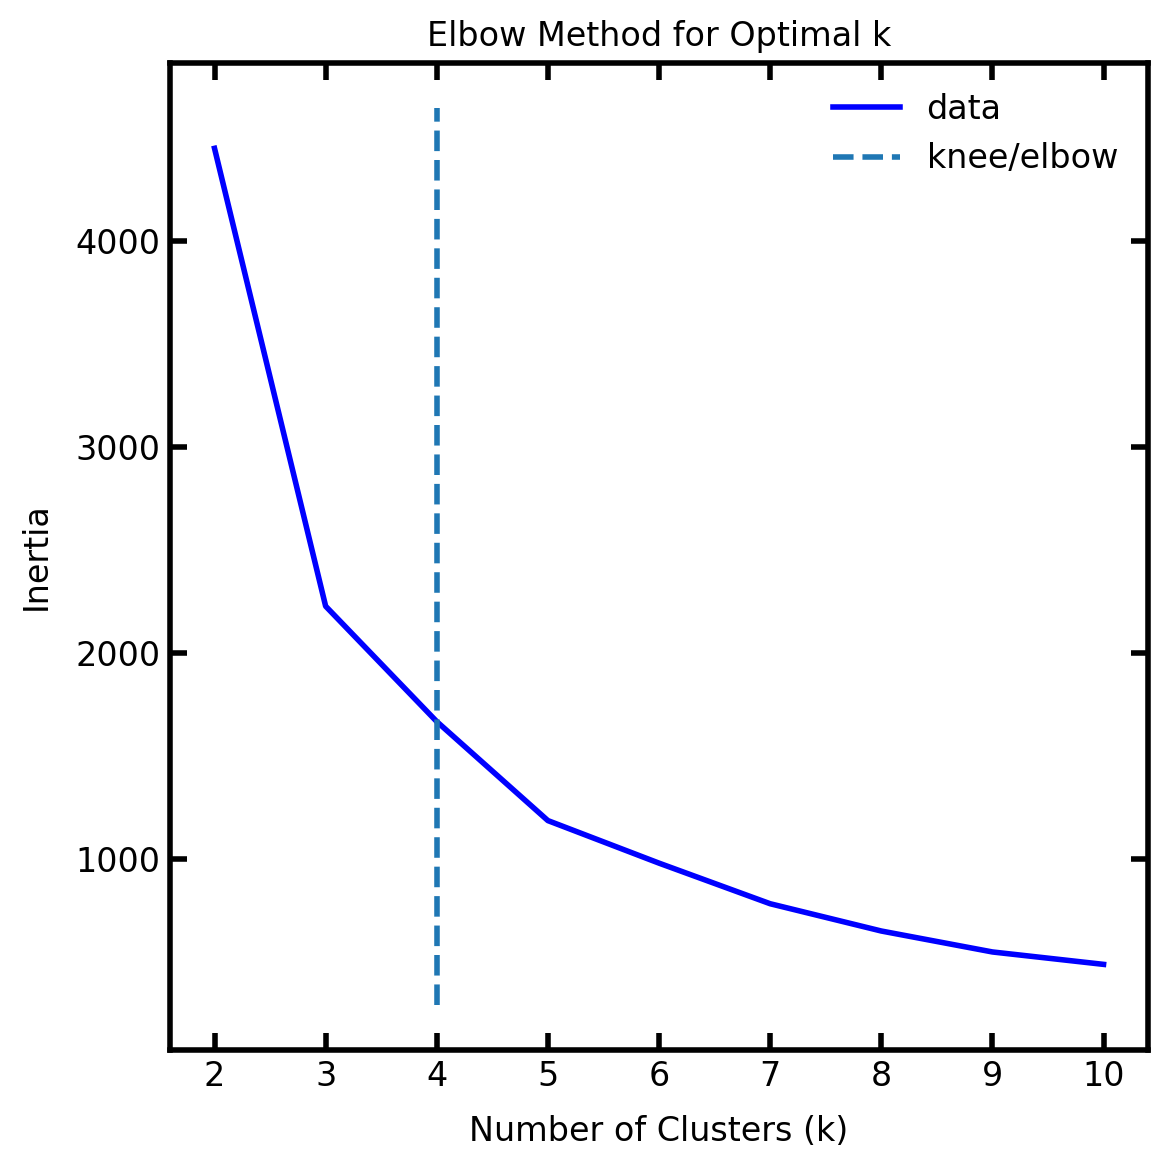


[7] Performing final K-Means clustering with k=4...
    -> Clustering complete and labels assigned.

--- A. Mean Properties of Each Pore Cluster ---



--- B. Cluster Profile Visualization (Parallel Coordinates) ---


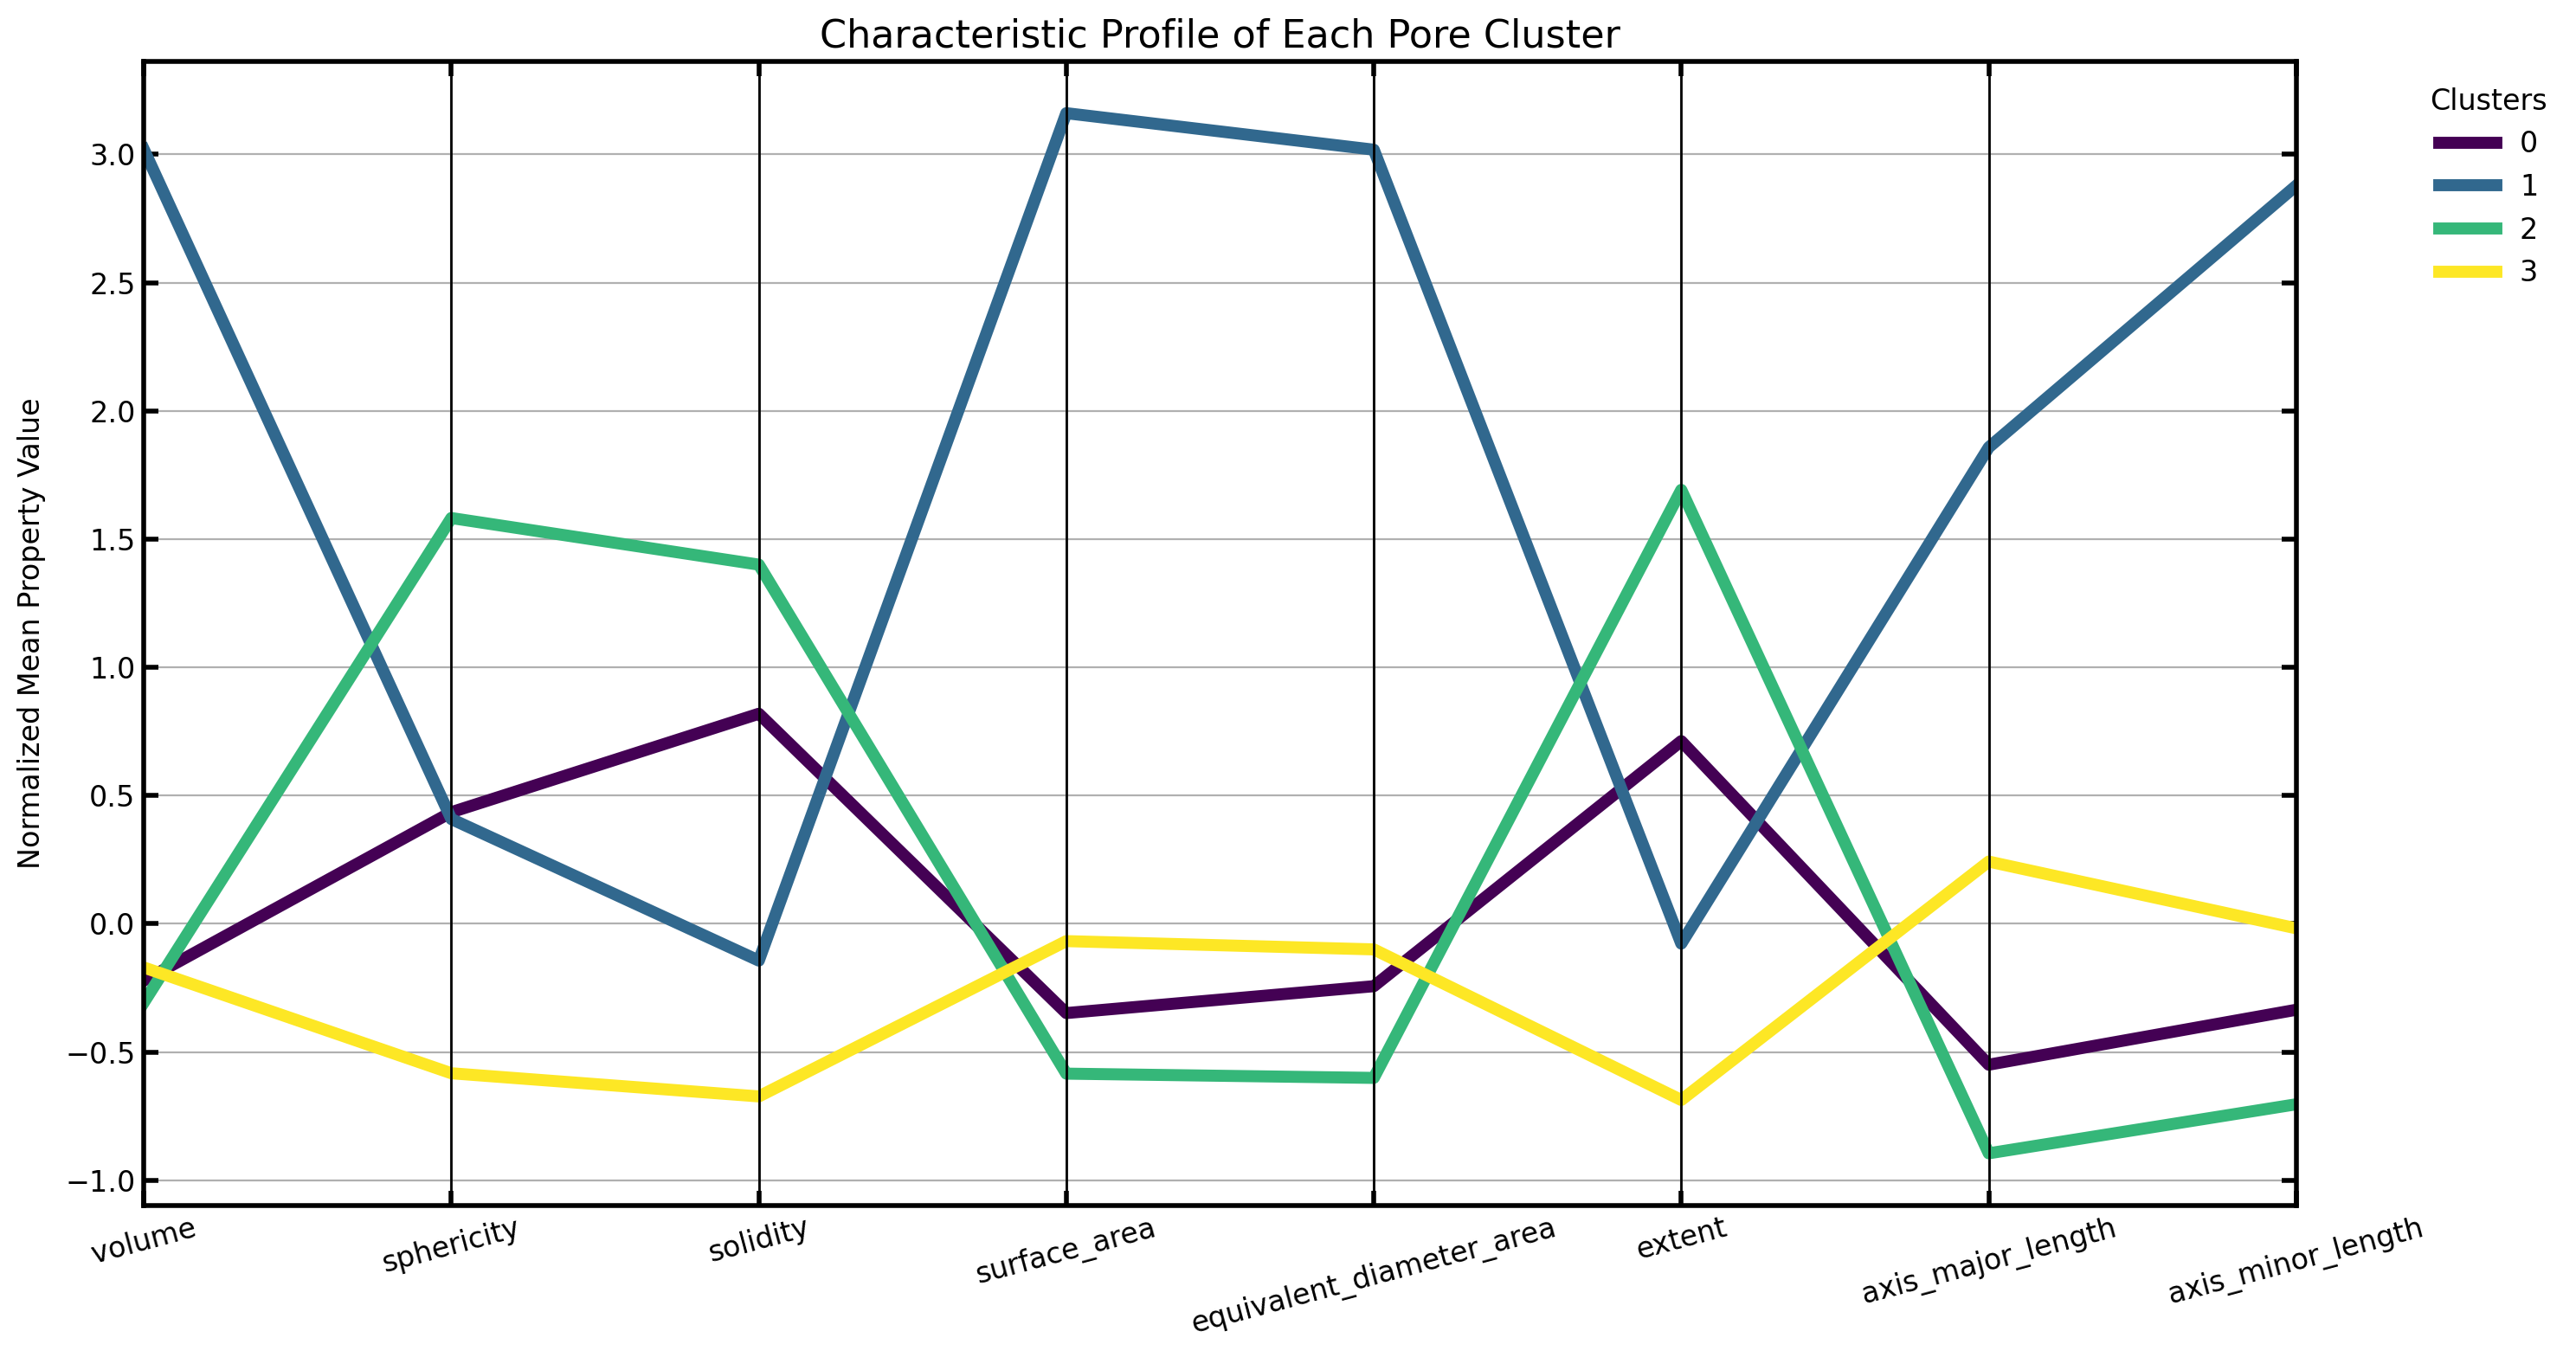


--- C. Cluster Visualization in Original Feature Space ---


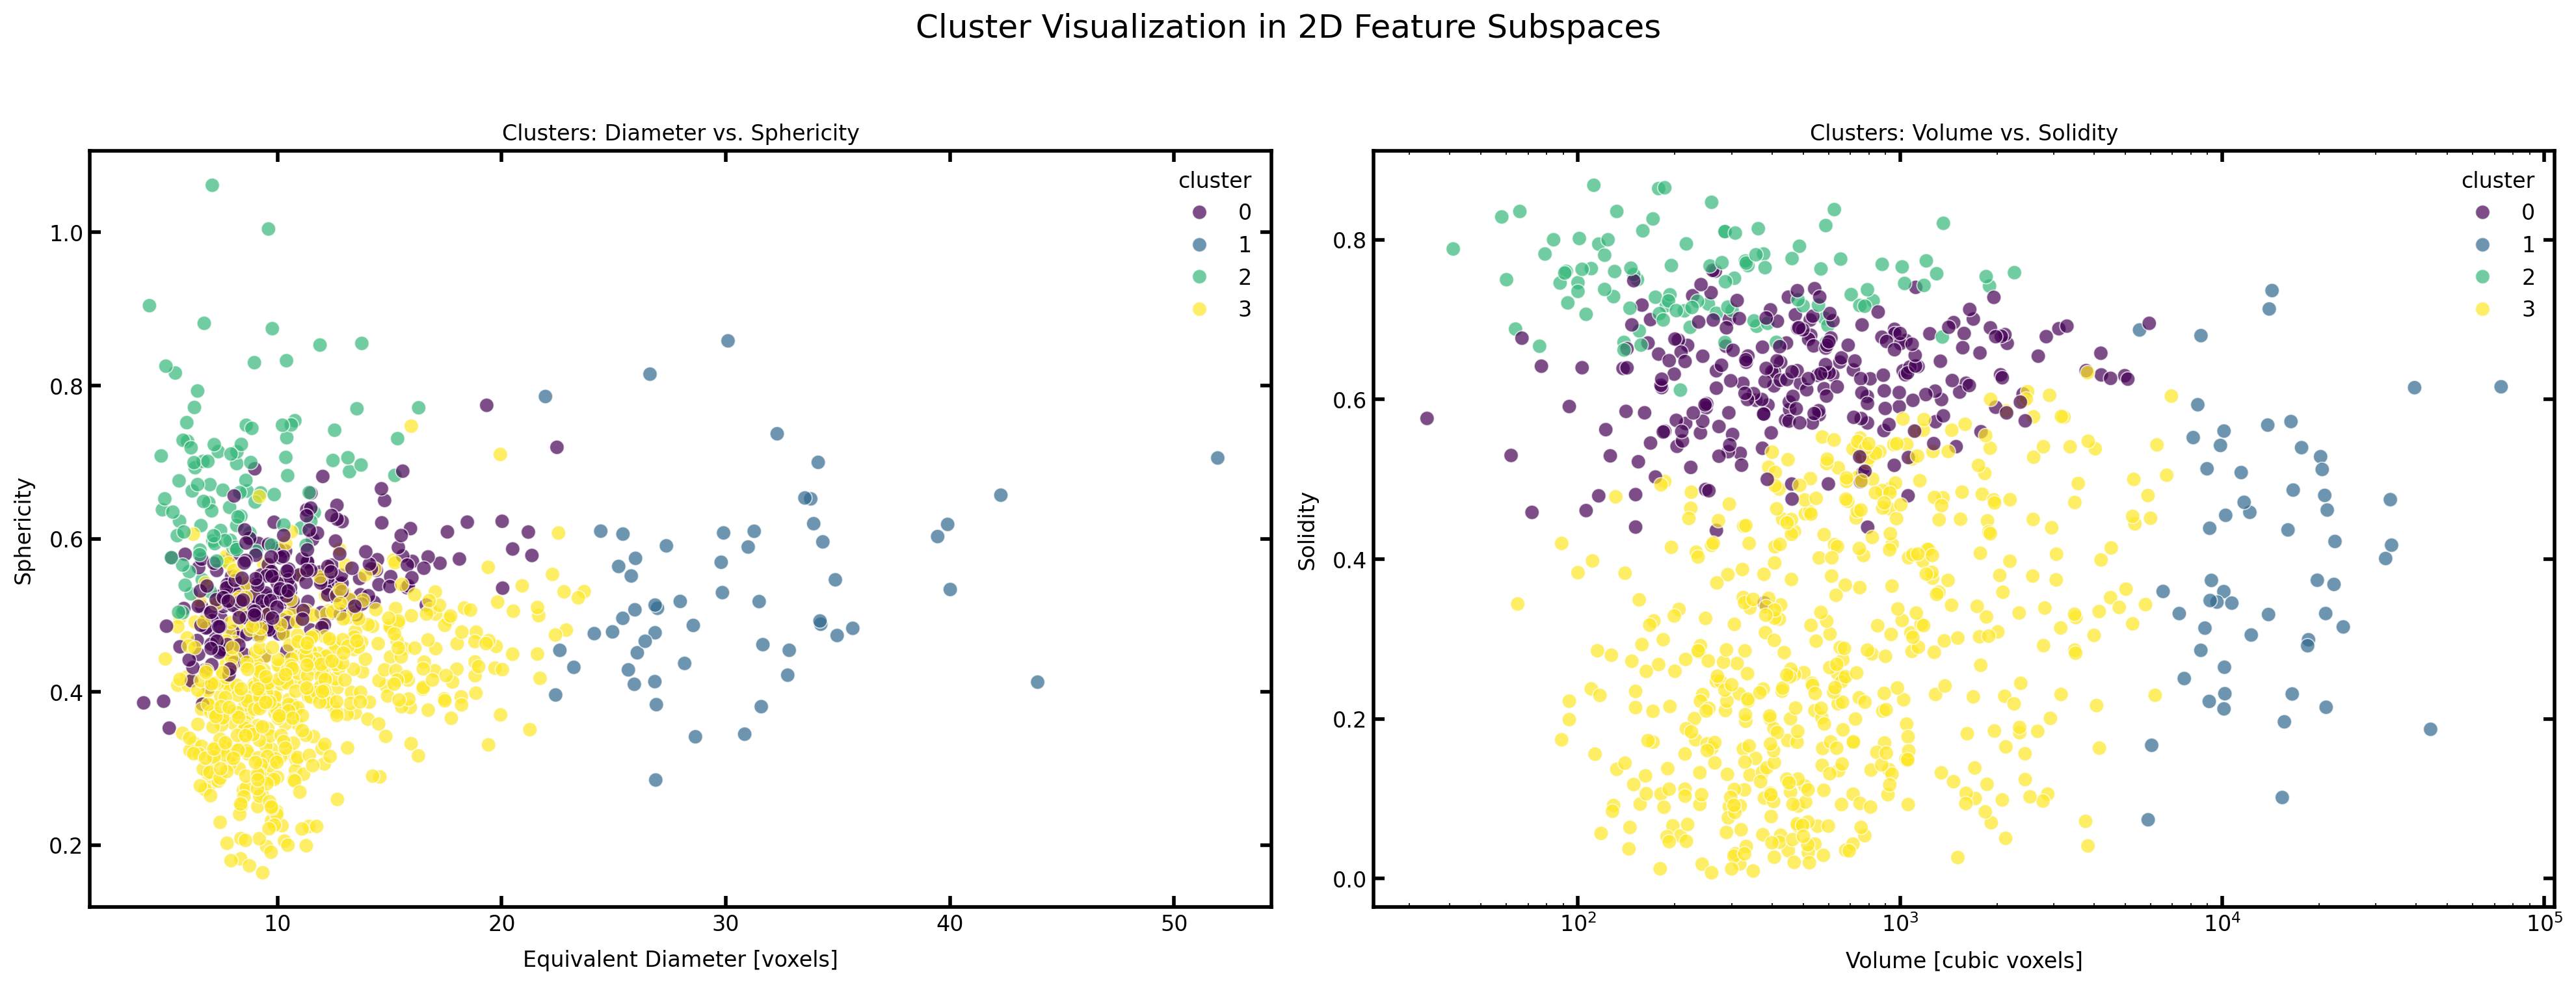


--- WORKFLOW COMPLETE ---


In [7]:
# =============================================================================
#
# SCRIPT FOR UNSUPERVISED PORE-TYPE CLASSIFICATION VIA MACHINE LEARNING
#
# METHODOLOGY:
# This script applies an advanced unsupervised machine learning workflow to
# classify pore types based on their geometric properties. The process involves
# two main stages:
#
#   1. Non-Linear Dimensionality Reduction (Autoencoder):
#      A deep autoencoder is trained on the high-dimensional pore property data.
#      The purpose is not to reconstruct the input, but to learn a compressed,
#      meaningful representation (the "latent space" or "encoding"). This
#      captures the most salient non-linear relationships between features,
#      which is more powerful than linear methods like PCA.
#
#   2. Clustering (K-Means):
#      The K-Means algorithm is applied to the low-dimensional latent space
#      representation of the pores. The optimal number of clusters (k) is
#      determined automatically using the "Elbow Method" and the Kneed library.
#      This partitions the pores into distinct groups, or "rock types," based
#      on their fundamental geometric signatures.
#
# OUTPUT:
# - A determination of the optimal number of pore clusters.
# - A statistical and visual analysis of the characteristic properties of each cluster.
# - The original DataFrame augmented with a 'cluster' label for each pore.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. ENVIRONMENT SETUP AND DEPENDENCY INSTALLATION =====
# Set OMP_NUM_THREADS to prevent potential conflicts with TensorFlow.
%env OMP_NUM_THREADS=1

!pip install tensorflow kneed openpyxl -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from typing import List, Dict

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'output_excel_path' variable, containing the
# path to the pore properties file, exists from a previous script.

if 'output_excel_path' in locals():

    # --- 3.1. Configuration ---
    CONFIG = {
        'excel_path': output_excel_path,
        'features_for_analysis': [
            'volume', 'sphericity', 'solidity', 'surface_area',
            'equivalent_diameter_area', 'extent', 'axis_major_length', 'axis_minor_length'
        ],
        'encoding_dimension': 3,
        'autoencoder_epochs': 50,
        'kmeans_k_range': range(2, 11),
        'random_state': 42  # For reproducible results
    }

    # Set random seeds for reproducibility
    tf.random.set_seed(CONFIG['random_state'])
    np.random.seed(CONFIG['random_state'])
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    try:
        # --- 3.2. Data Loading and Preprocessing ---
        print(f"\n[1] Loading data from '{CONFIG['excel_path']}'...")
        df = pd.read_excel(CONFIG['excel_path'])
        print(f"    -> Success. Loaded data for {len(df)} pores.")

        print("\n[2] Preprocessing features for analysis...")
        df_features = df[CONFIG['features_for_analysis']].copy()
        df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_features.dropna(inplace=True)
        print(f"    -> Preprocessing complete. {len(df_features)} valid pores remain.")

        print("\n[3] Scaling data using StandardScaler...")
        # Scaling is critical for neural networks and distance-based algorithms like K-Means.
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_features)
        print("    -> Data scaling complete.")

        # --- 3.3. Dimensionality Reduction with an Autoencoder ---
        print("\n[4] Building and training the Autoencoder model...")
        input_dim = X_scaled.shape[1]

        # Define Architecture
        input_layer = Input(shape=(input_dim,))
        # Encoder
        encoded = Dense(16, activation='relu')(input_layer)
        encoded = Dense(8, activation='relu')(encoded)
        encoder_output = Dense(CONFIG['encoding_dimension'], activation='relu')(encoded)
        # Decoder
        decoded = Dense(8, activation='relu')(encoder_output)
        decoded = Dense(16, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        # Define Models
        autoencoder = Model(input_layer, decoded, name='Autoencoder')
        encoder = Model(input_layer, encoder_output, name='Encoder')

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        print("    -> Autoencoder architecture defined.")

        history = autoencoder.fit(X_scaled, X_scaled,
                                  epochs=CONFIG['autoencoder_epochs'],
                                  batch_size=256,
                                  shuffle=True,
                                  validation_split=0.1,
                                  verbose=0)
        print(f"    -> Autoencoder training complete. Final validation loss: {history.history['val_loss'][-1]:.4f}")

        print("\n[5] Extracting latent space representation (encoded features)...")
        X_encoded = encoder.predict(X_scaled, verbose=0)
        print(f"    -> Data transformed from {input_dim}D to {CONFIG['encoding_dimension']}D.")

        # --- 3.4. Optimal Cluster Number Determination (Elbow Method) ---
        print("\n[6] Determining optimal number of clusters via the Elbow Method...")
        inertia = []
        for k in CONFIG['kmeans_k_range']:
            kmeans = KMeans(n_clusters=k, random_state=CONFIG['random_state'], n_init=10)
            kmeans.fit(X_encoded)
            inertia.append(kmeans.inertia_)

        kn = KneeLocator(CONFIG['kmeans_k_range'], inertia, curve='convex', direction='decreasing')
        optimal_k = kn.elbow if kn.elbow else 4  # Fallback to k=4 if knee is not found

        print(f"    -> Optimal number of clusters (k) found at: {optimal_k}")
        kn.plot_knee()
        plt.xlabel('Number of Clusters (k)'); plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k'); plt.show()

        # --- 3.5. Final Clustering and Results Analysis ---
        print(f"\n[7] Performing final K-Means clustering with k={optimal_k}...")
        kmeans = KMeans(n_clusters=optimal_k, random_state=CONFIG['random_state'], n_init=10)
        clusters = kmeans.fit_predict(X_encoded)

        # Add cluster labels to the original (unscaled) feature set for interpretation
        df_analysis = df_features.copy()
        df_analysis['cluster'] = clusters
        print("    -> Clustering complete and labels assigned.")

        print("\n--- A. Mean Properties of Each Pore Cluster ---")
        cluster_summary = df_analysis.groupby('cluster').mean()
        display(cluster_summary.style.format("{:,.2f}"))

        print("\n--- B. Cluster Profile Visualization (Parallel Coordinates) ---")
        # This plot shows the characteristic "signature" of each cluster.
        df_summary_scaled = pd.DataFrame(scaler.transform(cluster_summary), columns=CONFIG['features_for_analysis'])
        df_summary_scaled['cluster'] = cluster_summary.index

        plt.figure(figsize=(15, 8))
        pd.plotting.parallel_coordinates(df_summary_scaled, 'cluster', colormap='viridis', linewidth=5)
        plt.title('Characteristic Profile of Each Pore Cluster', fontsize=16)
        plt.ylabel('Normalized Mean Property Value'); plt.xticks(rotation=15)
        plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True); plt.show()

        print("\n--- C. Cluster Visualization in Original Feature Space ---")
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Cluster Visualization in 2D Feature Subspaces', fontsize=18)

        sample_data = df_analysis.sample(n=min(5000, len(df_analysis)), random_state=CONFIG['random_state'])

        sns.scatterplot(data=sample_data, x='equivalent_diameter_area', y='sphericity',
                        hue='cluster', palette='viridis', alpha=0.7, ax=axes[0])
        axes[0].set_title('Clusters: Diameter vs. Sphericity'); axes[0].set_xlabel('Equivalent Diameter [voxels]')
        axes[0].set_ylabel('Sphericity')

        sns.scatterplot(data=sample_data, x='volume', y='solidity',
                        hue='cluster', palette='viridis', alpha=0.7, ax=axes[1])
        axes[1].set_title('Clusters: Volume vs. Solidity'); axes[1].set_xlabel('Volume [cubic voxels]')
        axes[1].set_ylabel('Solidity'); axes[1].set_xscale('log')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

        print("\n--- WORKFLOW COMPLETE ---")

    except FileNotFoundError:
        print(f"\nCRITICAL ERROR: The file '{CONFIG['excel_path']}' was not found.")
    except Exception as e:
        print(f"\nCRITICAL ERROR: An unexpected error occurred: {e}")

else:
    print("CRITICAL ERROR: The prerequisite variable 'output_excel_path' was not found.")
    print("Please ensure the previous scripts have been executed successfully.")

env: OMP_NUM_THREADS=1
Dependencies checked/installed.

[1] Loading and preparing data from '/content/drive/MyDrive/pesquisa_mestrado_2025/dados_mestrado/properties_BC23_TQ-07_40_RECORTADO_300_IMAGENS_40um.xlsx'...
    -> Loaded data for 927 pores.
    -> Preprocessing complete. 927 valid pores remain for analysis.
    -> Feature scaling complete.

[2] Building and training the Autoencoder model...
    -> Autoencoder architecture defined.
    -> Training complete. Final validation loss: 0.5308

[3] Calculating reconstruction errors to identify anomalies...
    -> Anomaly analysis complete.

--- A. Distribution of Reconstruction Errors ---


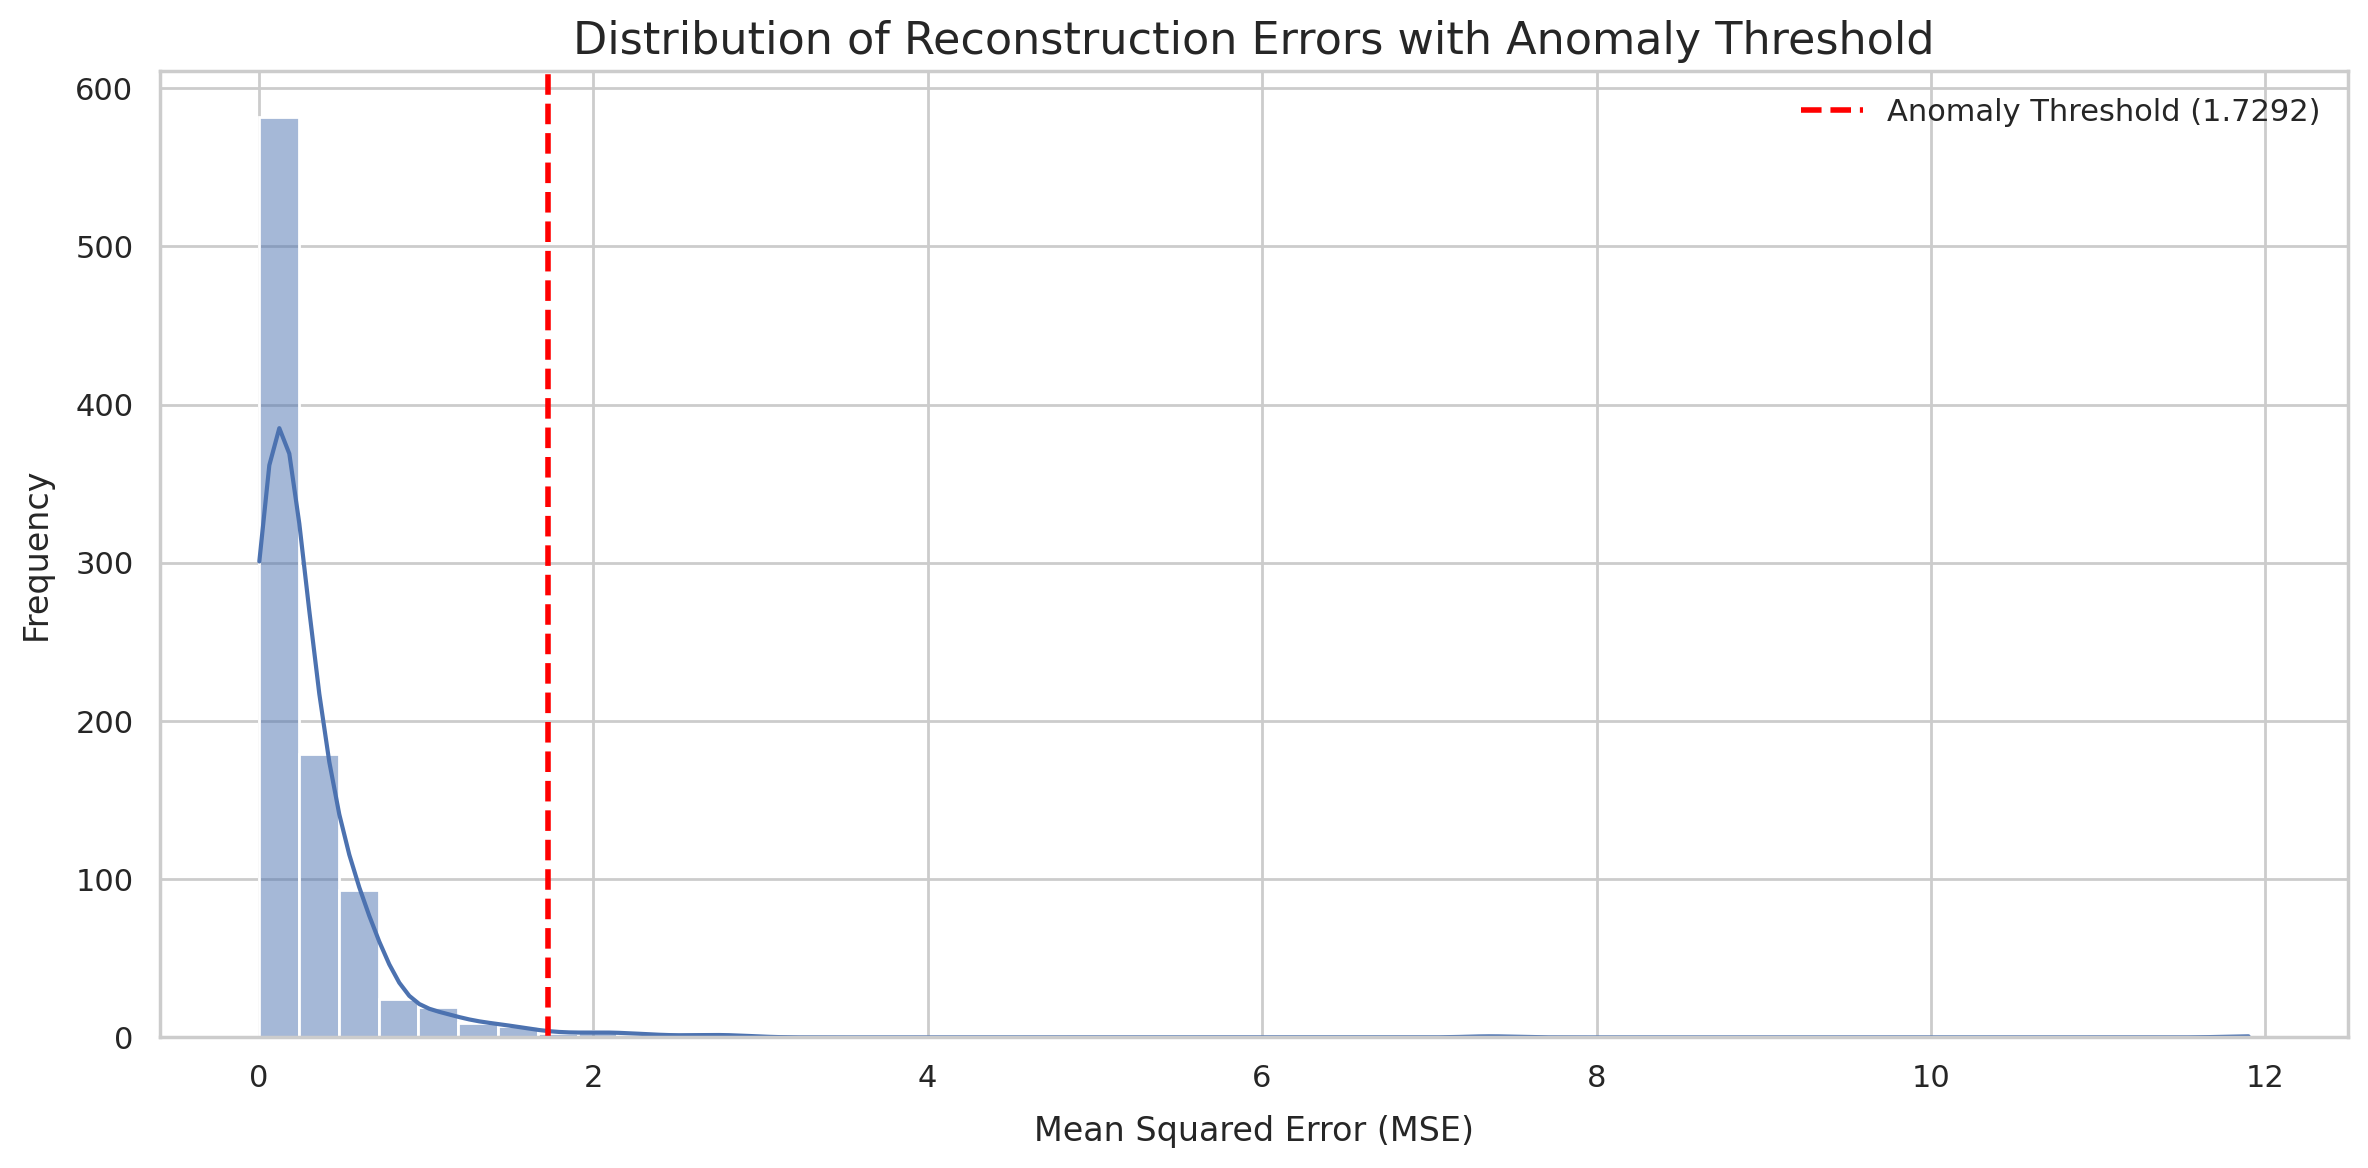


--- B. Comparative Statistics: Typical vs. Anomalous Pores ---



--- C. Latent Space Visualization ---


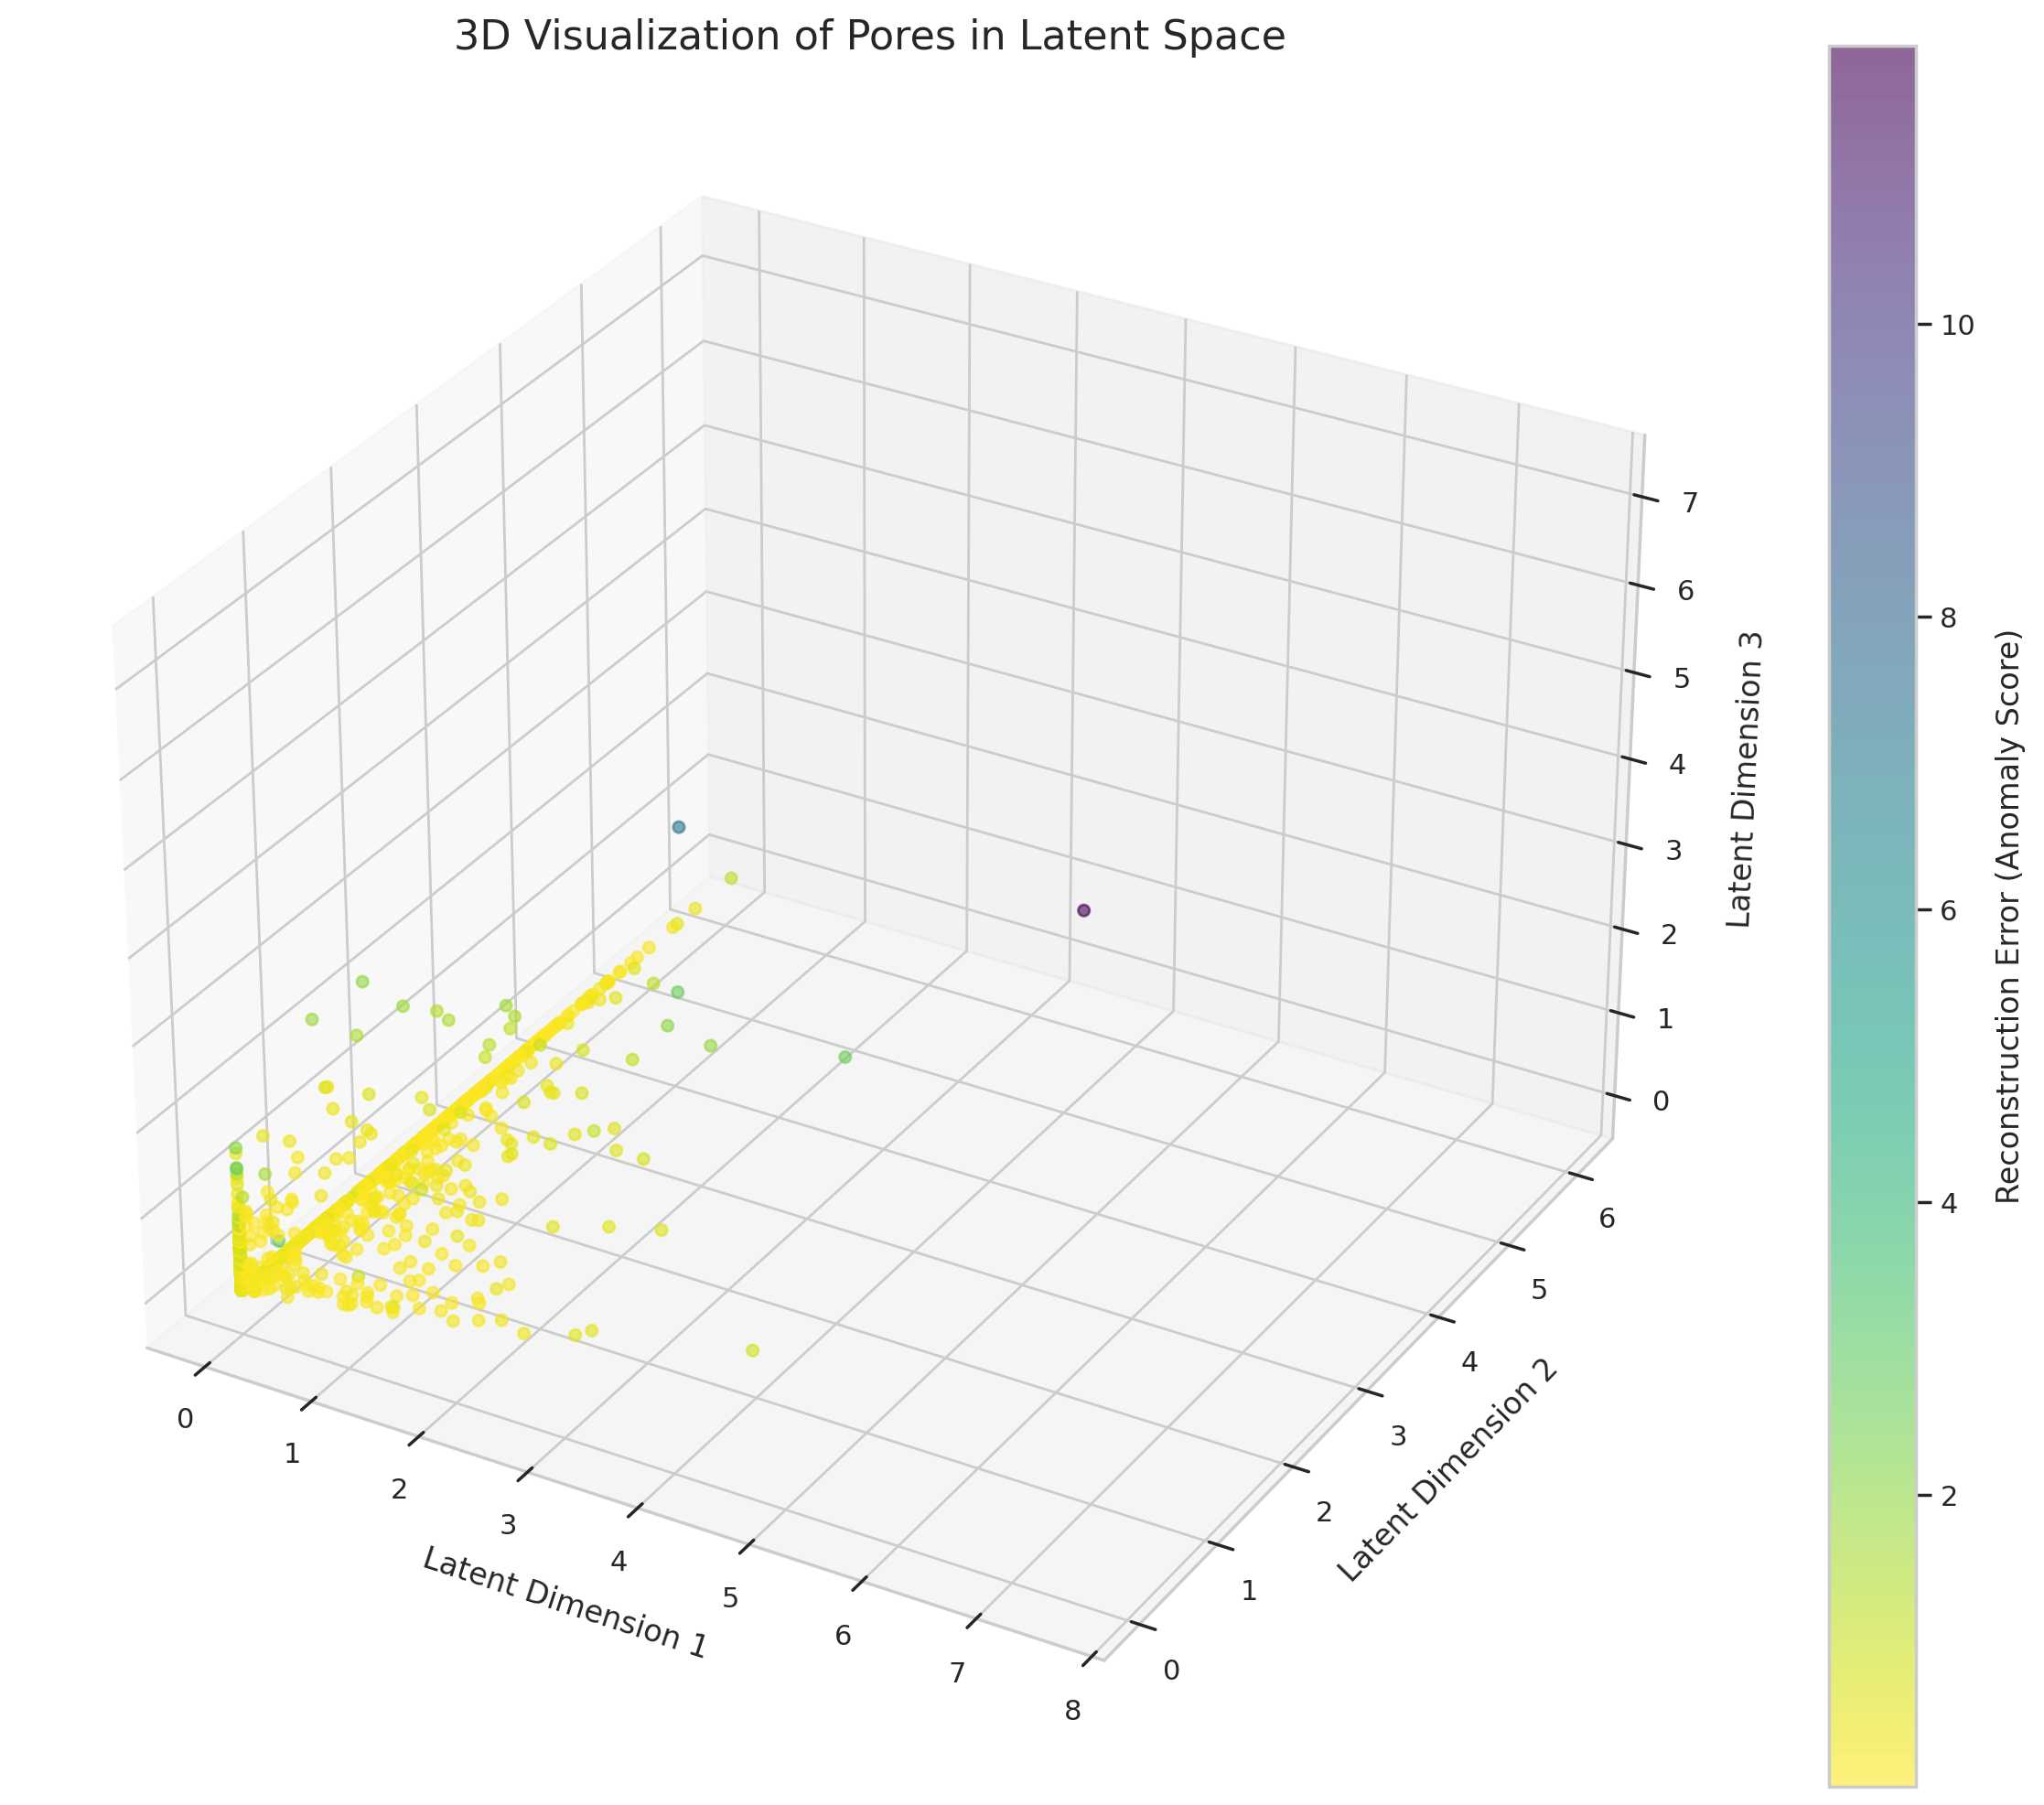


--- D. Feature Reconstruction Error Analysis ---


/tmp/ipython-input-621193963.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_feature_error.values, y=mean_feature_error.index, palette='rocket')


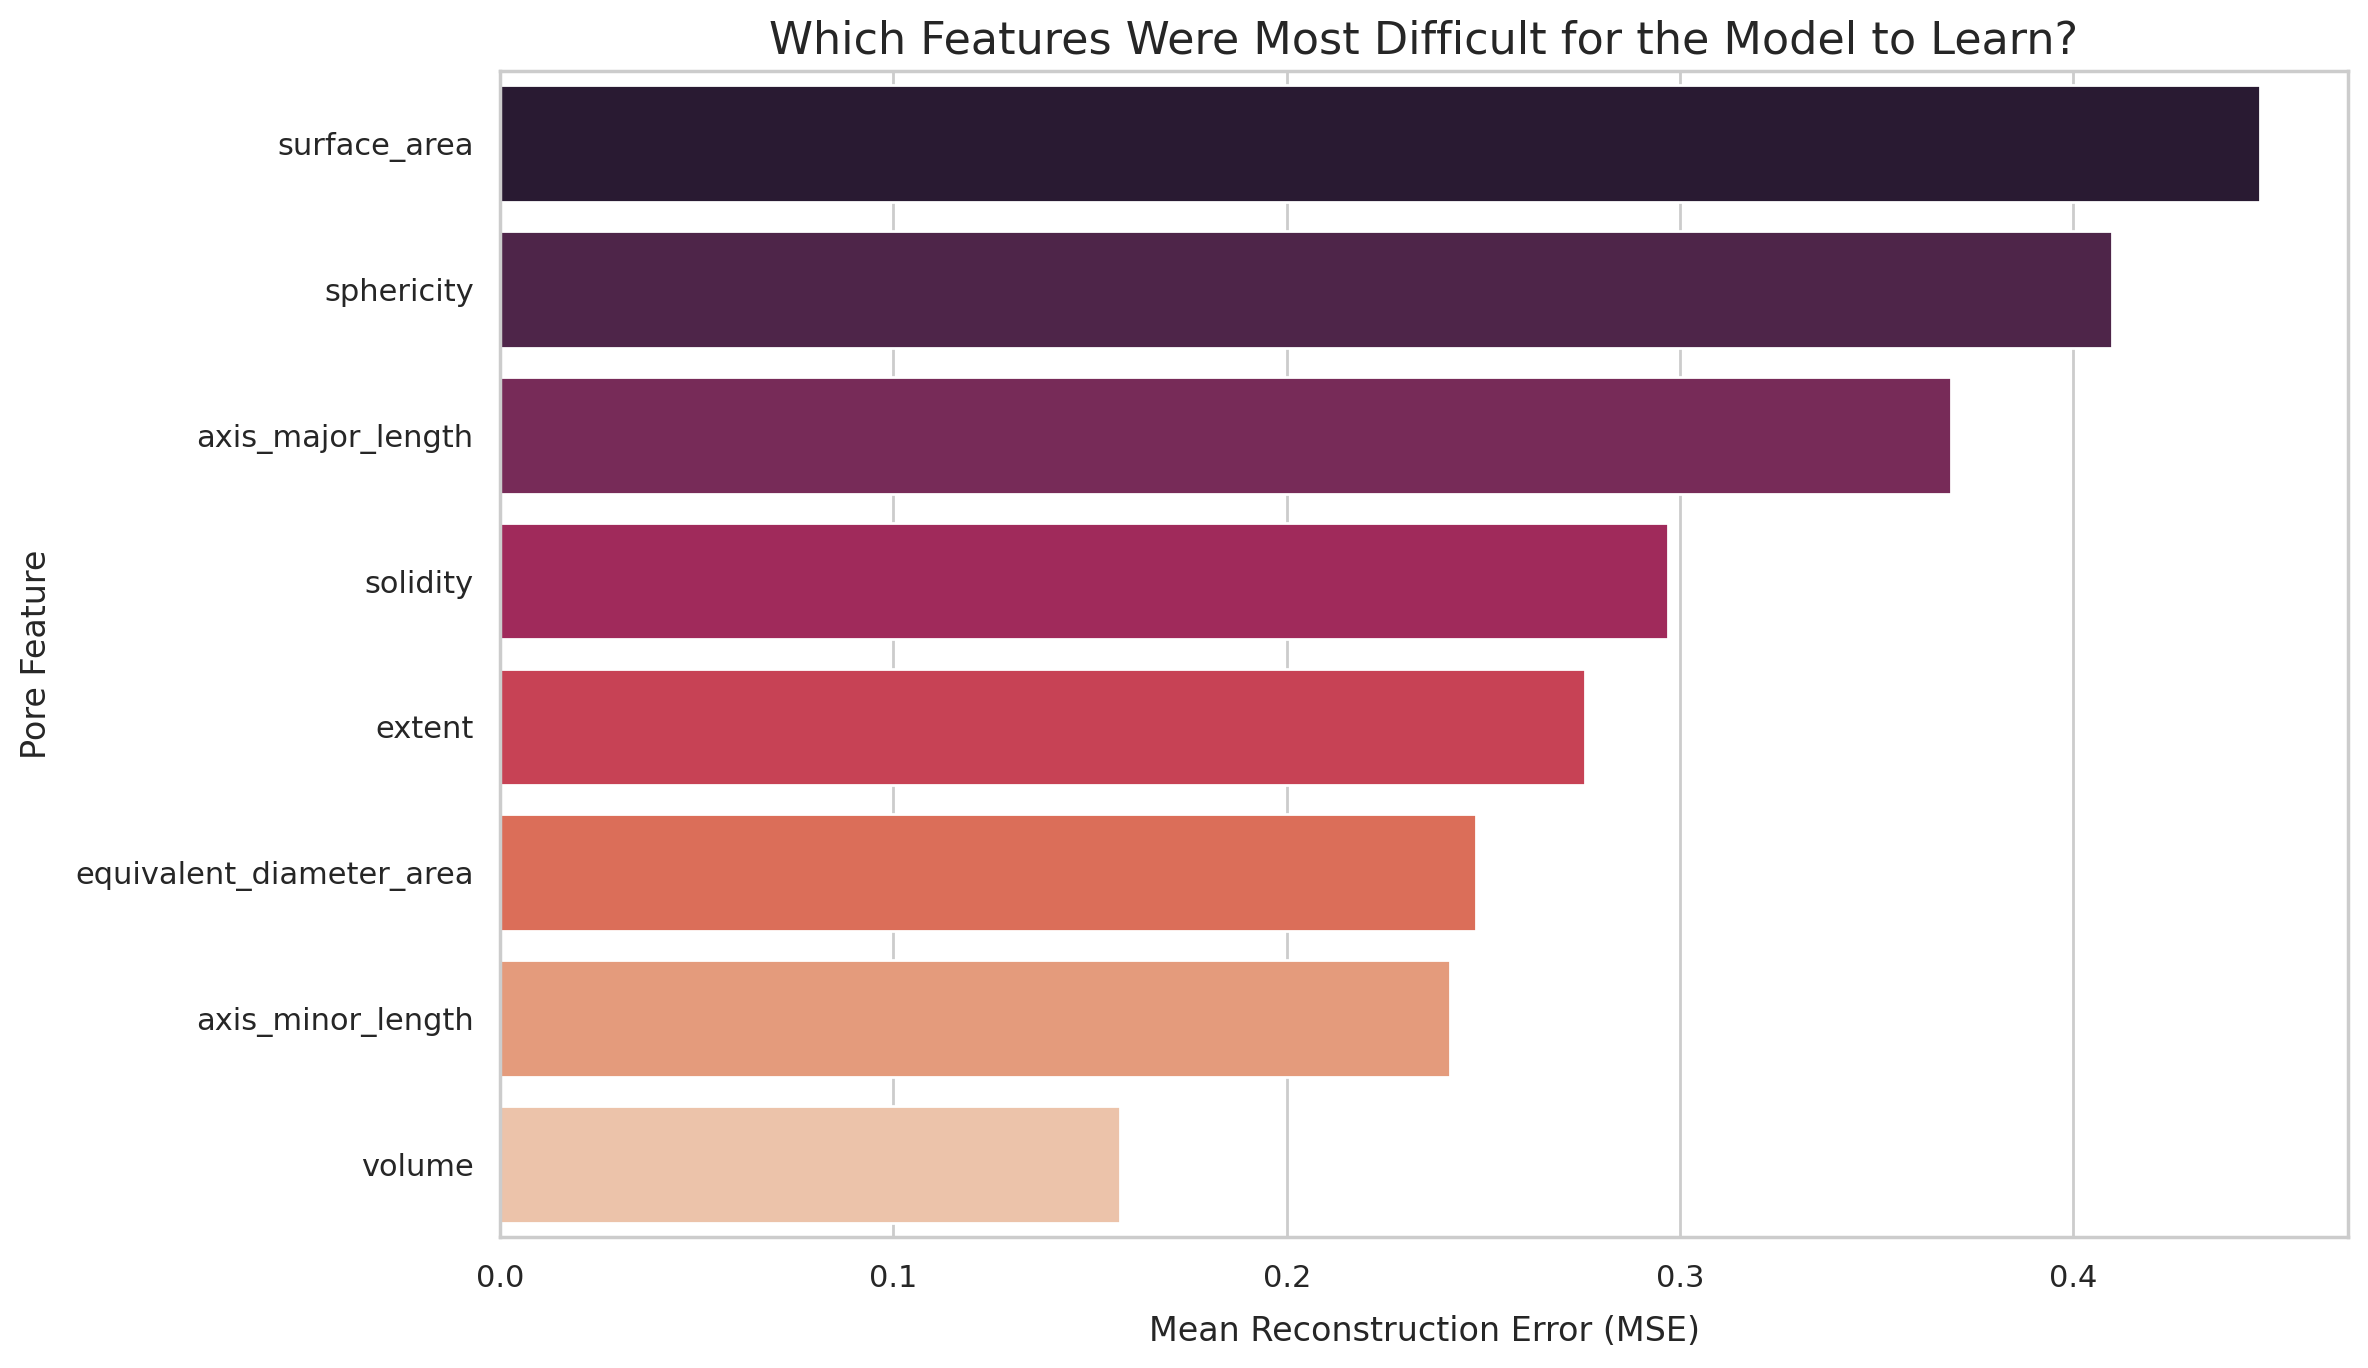


--- E. Top 10 Most Anomalous Pores (Ranked by Error) ---


label  reconstruction_error      anomaly_cause  volume  sphericity  \
916    917             11.898887             volume   73428    0.705389   
575    576              7.367207       surface_area   44351    0.412669   
851    852              2.864997  axis_major_length     356    0.481222   
899    900              2.738917       surface_area   33553    0.533645   
921    922              2.587584       surface_area   39558    0.656812   
75      76              2.349057  axis_major_length     329    0.206014   
724    725              2.277564  axis_major_length     518    0.308012   
396    397              2.132646  axis_major_length     350    0.172787   
660    661              2.105490  axis_major_length     239    0.326961   
7        8              2.041560       surface_area   32159    0.602772   

     solidity  surface_area  equivalent_diameter_area    extent  \
916  0.615898  12021.619141                 51.954244  0.269619   
575  0.187022  14683.103516                 43.917229  0.069396   
851  0.150592    504.783264                  8.793271  0.062787   
899  0.417565   9427.260742                 40.016974  0.199043   
921  0.614789   8548.022461                 42.274509  0.299464   
75   0.031099   1118.710449                  8.565100  0.012247   
724  0.111183   1012.675537                  9.964229  0.025024   
396  0.009607   1390.014893                  8.743590  0.002418   
660  0.092924    569.621460                  7.699569  0.022981   
7    0.400890   8113.341309                 39.454932  0.137439   

     axis_major_length  axis_minor_length  
916          85.976255          34.781039  
575          61.838563          39.432411  
851          78.905596           6.218925  
899          68.034030          28.332420  
921          52.610957          35.487423  
75           74.692441          12.954049  
724          77.161275           9.391394  
396          68.662254          21.218194  
660          69.856238           6.566192  
7            63.362052          27.392215

In [8]:
# =============================================================================
#
# SCRIPT FOR UNSUPERVISED ANOMALY DETECTION IN PORE PROPERTIES
#                          USING A DEEP AUTOENCODER
#
# METHODOLOGY:
# This script applies an unsupervised deep learning approach to identify anomalous
# or outlier pores within a dataset of geometric properties. The core of this
# method is an Autoencoder neural network.
#
#   1. Autoencoder Training: The model is trained to reconstruct the input
#      pore property data. It learns the general, underlying patterns of
#      "typical" pores present in the majority of the dataset.
#
#   2. Anomaly Scoring via Reconstruction Error: After training, the model is
#      used to reconstruct every data point. Pores that are significantly
#      different from the norm (i.e., anomalies) will be poorly reconstructed,
#      resulting in a high Mean Squared Error (MSE). This reconstruction error
#      serves as a powerful anomaly score.
#
#   3. Anomaly Identification: A statistical threshold (e.g., mean error +
#      x * standard deviations) is applied to the reconstruction errors to
#      formally classify pores as either 'Typical' or 'Anomalous'.
#
#   4. Analysis & Visualization: The script provides a detailed analysis,
#      comparing the statistical properties of typical vs. anomalous pores,
#      visualizing the latent space, and identifying the primary causes of
#      anomalies.
#
# OUTPUT:
# - A classification of each pore as 'Typical' or 'Anomalous'.
# - A comprehensive suite of plots for interpreting the anomalies.
# - A ranked list of the most anomalous pores and their likely causes.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. ENVIRONMENT SETUP AND DEPENDENCY INSTALLATION =====
# Set OMP_NUM_THREADS to prevent potential OpenMP-related warnings with TensorFlow.
%env OMP_NUM_THREADS=1

!pip install tensorflow openpyxl -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'output_excel_path' variable, containing the
# path to the pore properties file, exists from a previous script.

if 'output_excel_path' in locals():

    # --- 3.1. Configuration and Helper Functions ---
    CONFIG = {
        'excel_path': output_excel_path,
        'features_for_analysis': [
            'volume', 'sphericity', 'solidity', 'surface_area',
            'equivalent_diameter_area', 'extent', 'axis_major_length', 'axis_minor_length'
        ],
        'encoding_dimension': 3,
        'autoencoder_epochs': 50,
        'anomaly_threshold_std_dev': 2.5,  # Defines anomaly threshold (mean + N * std)
        'random_state': 42
    }

    # Set random seeds for reproducible machine learning results
    tf.random.set_seed(CONFIG['random_state'])
    np.random.seed(CONFIG['random_state'])
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    def prepare_data(file_path: str, feature_cols: List[str]) -> Tuple:
        """Loads, cleans, and scales the pore property data from an Excel file."""
        print(f"\n[1] Loading and preparing data from '{file_path}'...")
        df = pd.read_excel(file_path)
        print(f"    -> Loaded data for {len(df)} pores.")

        df_features = df[feature_cols].copy()
        df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Keep track of original indices to map results back to the full dataset
        original_indices = df_features.dropna().index
        df_features.dropna(inplace=True)

        clean_original_df = df.loc[original_indices].copy()
        print(f"    -> Preprocessing complete. {len(df_features)} valid pores remain for analysis.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_features)
        print("    -> Feature scaling complete.")

        return X_scaled, clean_original_df, scaler, feature_cols

    def build_and_train_autoencoder(X_scaled: np.ndarray, encoding_dim: int, epochs: int) -> Tuple[Model, Model]:
        """Defines, compiles, and trains the autoencoder model."""
        print("\n[2] Building and training the Autoencoder model...")
        input_dim = X_scaled.shape[1]

        # Architecture
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(16, activation='relu')(input_layer)
        encoded = Dense(8, activation='relu')(encoded)
        encoder_output = Dense(encoding_dim, activation='relu')(encoded)
        decoded = Dense(8, activation='relu')(encoder_output)
        decoded = Dense(16, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        # Models
        autoencoder = Model(input_layer, decoded, name="Autoencoder")
        encoder = Model(input_layer, encoder_output, name="Encoder")

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        print("    -> Autoencoder architecture defined.")

        history = autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=256,
                                  shuffle=True, validation_split=0.1, verbose=0)
        print(f"    -> Training complete. Final validation loss: {history.history['val_loss'][-1]:.4f}")

        return autoencoder, encoder

    try:
        # --- 3.2. Execute Main Workflow ---
        X_scaled, df_original_clean, scaler, features = prepare_data(CONFIG['excel_path'], CONFIG['features_for_analysis'])
        autoencoder, encoder = build_and_train_autoencoder(X_scaled, CONFIG['encoding_dimension'], CONFIG['autoencoder_epochs'])

        print("\n[3] Calculating reconstruction errors to identify anomalies...")
        X_reconstructed = autoencoder.predict(X_scaled, verbose=0)

        # Calculate Mean Squared Error for each pore (row)
        mse_per_pore = np.mean(np.power(X_scaled - X_reconstructed, 2), axis=1)

        results_df = df_original_clean.copy()
        results_df['reconstruction_error'] = mse_per_pore

        # Define anomaly threshold and classify pores
        error_mean = results_df['reconstruction_error'].mean()
        error_std = results_df['reconstruction_error'].std()
        anomaly_threshold = error_mean + CONFIG['anomaly_threshold_std_dev'] * error_std

        results_df['status'] = np.where(results_df['reconstruction_error'] > anomaly_threshold, 'Anomalous', 'Typical')

        # Identify the feature contributing most to the anomaly
        mse_per_feature = np.power(X_scaled - X_reconstructed, 2)
        feature_error_df = pd.DataFrame(mse_per_feature, index=results_df.index, columns=features)
        results_df['anomaly_cause'] = feature_error_df.idxmax(axis=1)
        print("    -> Anomaly analysis complete.")

        # --- 3.3. Visualization and Interpretation ---
        sns.set_theme(style="whitegrid")

        print("\n--- A. Distribution of Reconstruction Errors ---")
        plt.figure(figsize=(12, 6))
        sns.histplot(results_df['reconstruction_error'], bins=50, kde=True)
        plt.axvline(anomaly_threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold ({anomaly_threshold:.4f})')
        plt.title('Distribution of Reconstruction Errors with Anomaly Threshold', fontsize=16)
        plt.xlabel('Mean Squared Error (MSE)'); plt.ylabel('Frequency'); plt.legend(); plt.show()

        print("\n--- B. Comparative Statistics: Typical vs. Anomalous Pores ---")
        desc_typical = results_df[results_df['status'] == 'Typical'][features].describe().T
        desc_anomalous = results_df[results_df['status'] == 'Anomalous'][features].describe().T
        comparison_table = pd.concat([desc_typical, desc_anomalous], axis=1, keys=['Typical Pores', 'Anomalous Pores'])
        display(comparison_table.style.format("{:,.2f}"))

        print("\n--- C. Latent Space Visualization ---")
        X_encoded = encoder.predict(X_scaled, verbose=0)
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(X_encoded[:, 0], X_encoded[:, 1], X_encoded[:, 2], c=results_df['reconstruction_error'], cmap='viridis_r', alpha=0.6)
        ax.set_title('3D Visualization of Pores in Latent Space', fontsize=16)
        ax.set_xlabel('Latent Dimension 1'); ax.set_ylabel('Latent Dimension 2'); ax.set_zlabel('Latent Dimension 3')
        fig.colorbar(p, label='Reconstruction Error (Anomaly Score)'); plt.show()

        print("\n--- D. Feature Reconstruction Error Analysis ---")
        mean_feature_error = feature_error_df.mean().sort_values(ascending=False)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=mean_feature_error.values, y=mean_feature_error.index, palette='rocket')
        plt.title('Which Features Were Most Difficult for the Model to Learn?', fontsize=16)
        plt.xlabel('Mean Reconstruction Error (MSE)'); plt.ylabel('Pore Feature'); plt.show()

        print(f"\n--- E. Top 10 Most Anomalous Pores (Ranked by Error) ---")
        anomalies = results_df[results_df['status'] == 'Anomalous'].sort_values(by='reconstruction_error', ascending=False)
        display(anomalies[['label', 'reconstruction_error', 'anomaly_cause'] + features].head(10))

    except FileNotFoundError:
        print(f"\nCRITICAL ERROR: The file '{CONFIG['excel_path']}' was not found.")
    except Exception as e:
        print(f"\nCRITICAL ERROR: An unexpected error occurred: {e}")

else:
    print("CRITICAL ERROR: The prerequisite variable 'output_excel_path' was not found.")
    print("Please ensure the previous scripts have been executed successfully.")

env: OMP_NUM_THREADS=1
Dependencies checked/installed.

[1] Preparing Data for Supervised Learning...
    -> Loaded data for 927 pores.
    -> Preprocessing complete. 927 valid pores remain for analysis.
    -> Data split into 741 training and 186 testing samples.
    -> Features (X) and target (y) have been scaled.

[2] Constructing the DNN model architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)


[3] Training the DNN model...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 1.2986 - mean_absolute_error: 0.5808 - val_loss: 0.6072 - val_mean_absolute_error: 0.4491
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0255 - mean_absolute_error: 0.5246 - val_loss: 0.4492 - val_mean_absolute_error: 0.4042
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7093 - mean_absolute_error: 0.4638 - val_loss: 0.3211 - val_mean_absolute_error: 0.3563
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4924 - mean_absolute_error: 0.3964 - val_loss: 0.2192 - val_mean_absolute_error: 0.3042
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4040 - mean_absolute_error: 0.3475 - val_loss: 0.1399 - val_mean_absolute_error: 0.2496
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2915 - mean_absolute_error: 0.3074 - val_loss: 0.0839 - val_mean_absolute_error: 0.1984
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1776 - mean_absolute

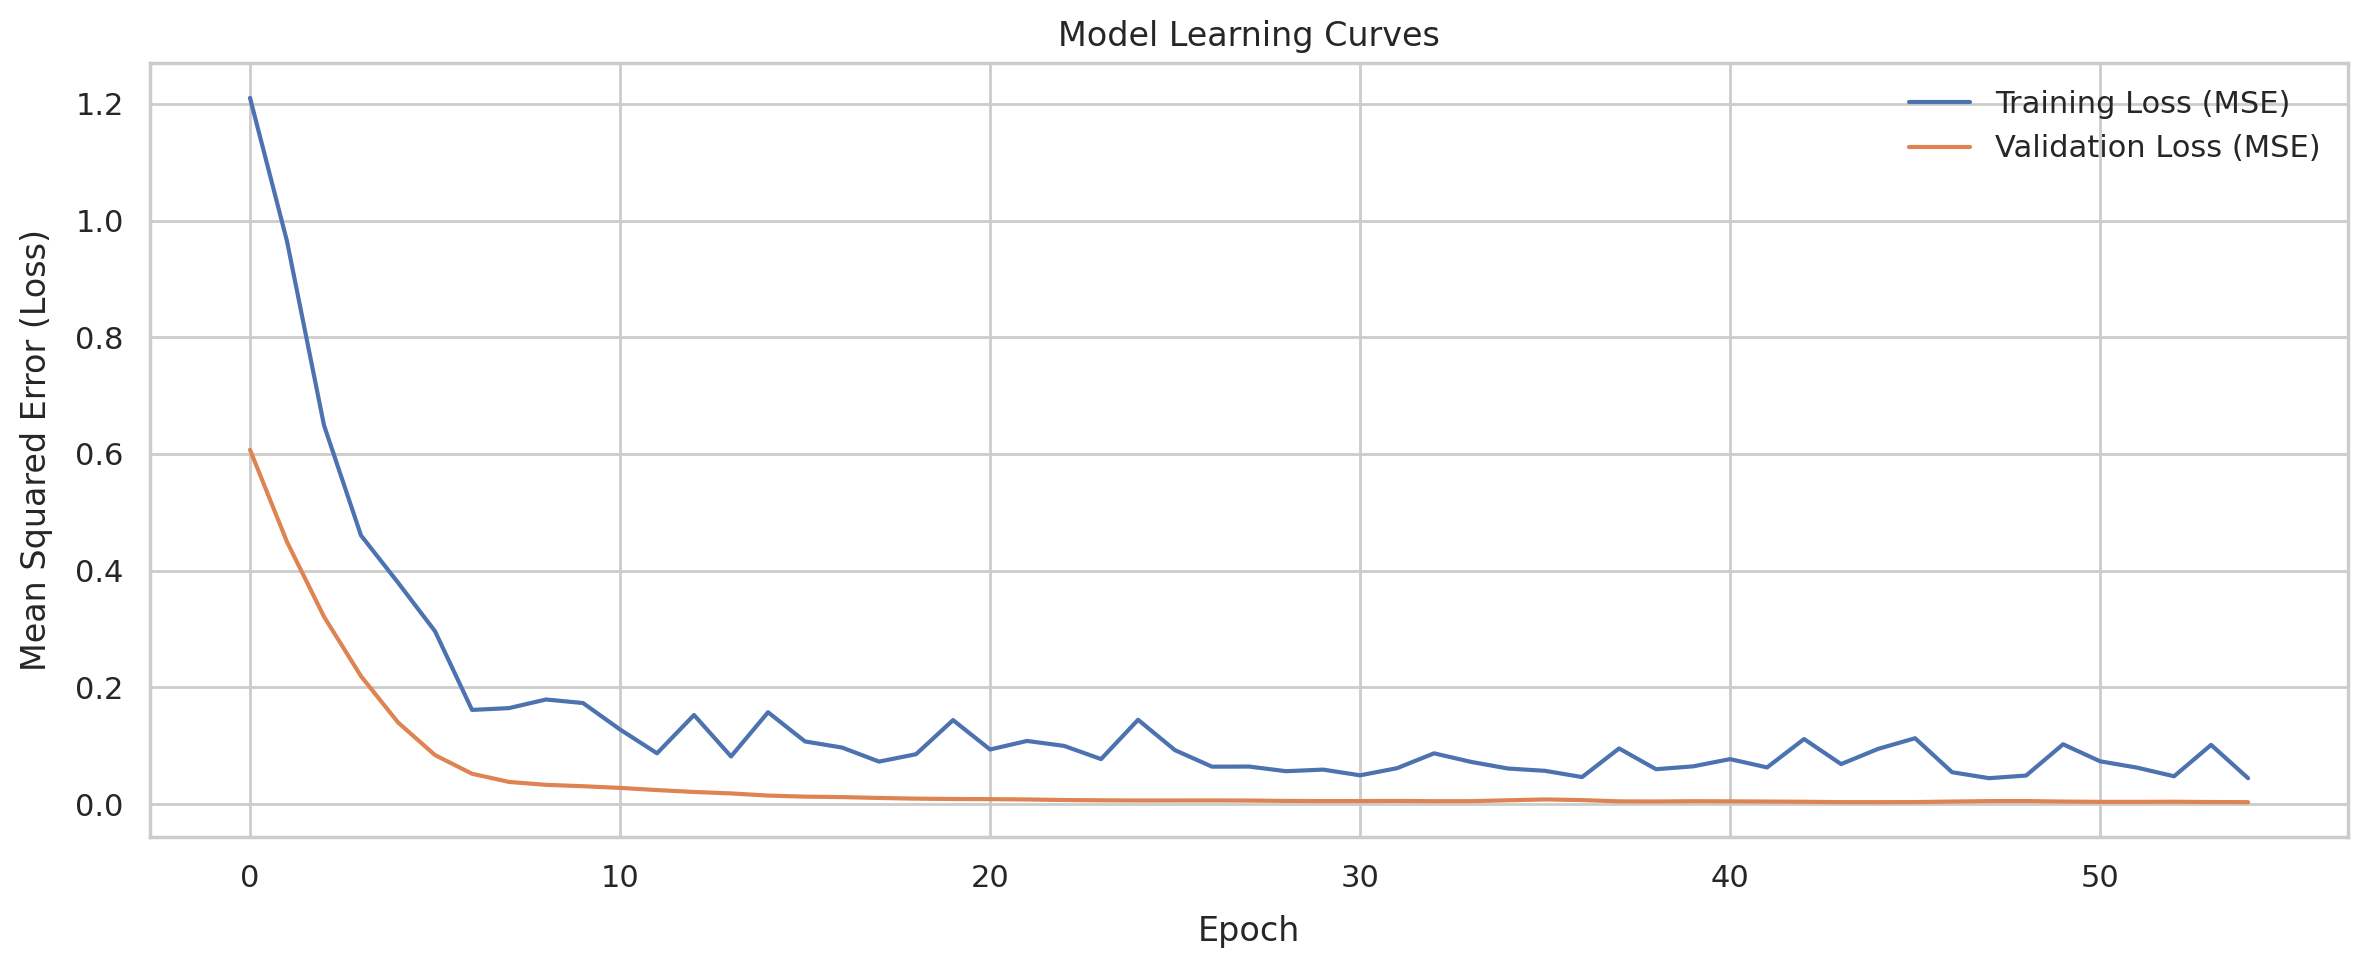


    -> Mean Absolute Error (MAE) on test set: 123,670.08 µm²
    -> Coefficient of Determination (R²) on test set: 0.9876


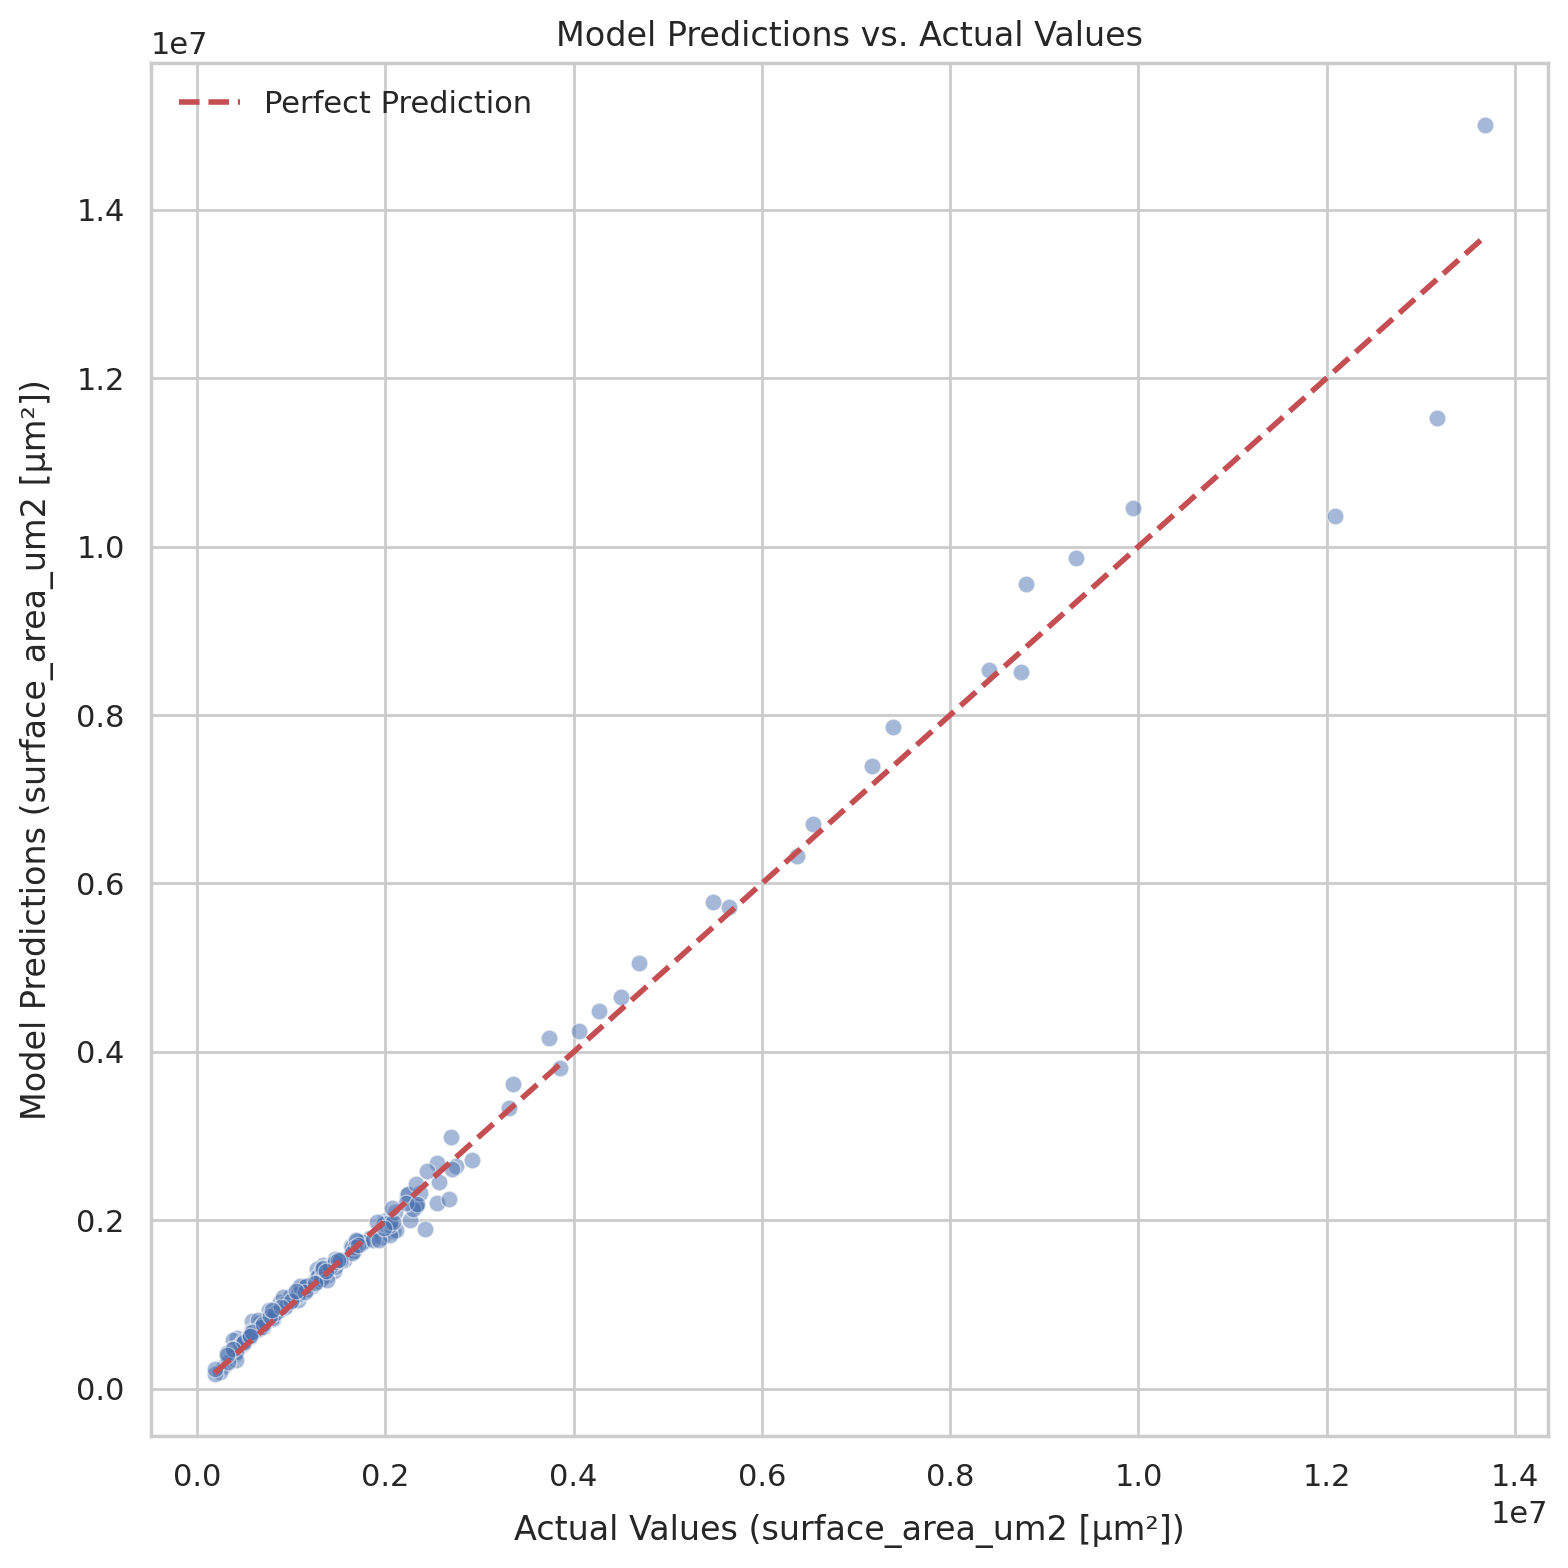

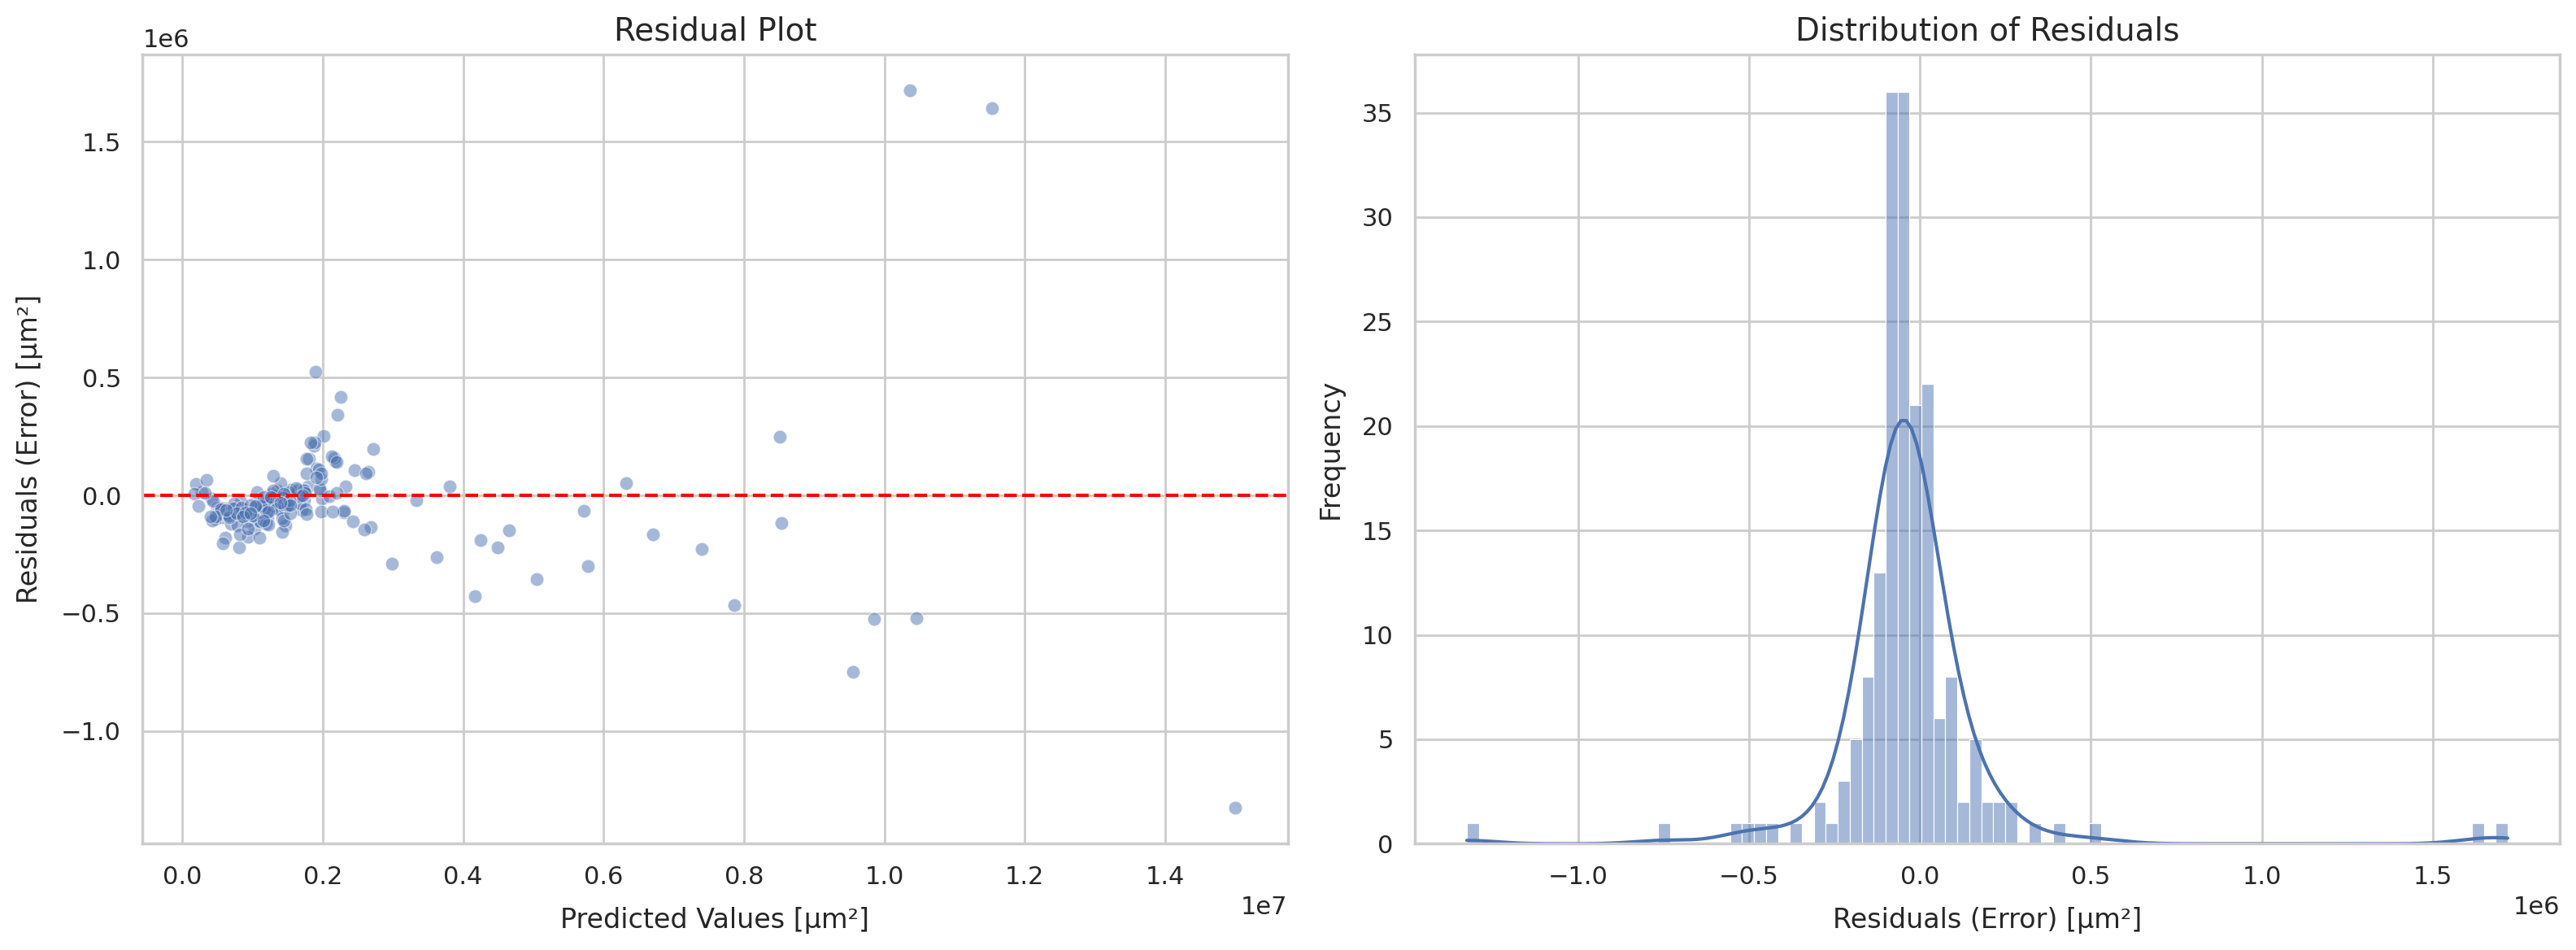


[5] Calculating Permutation Feature Importance...


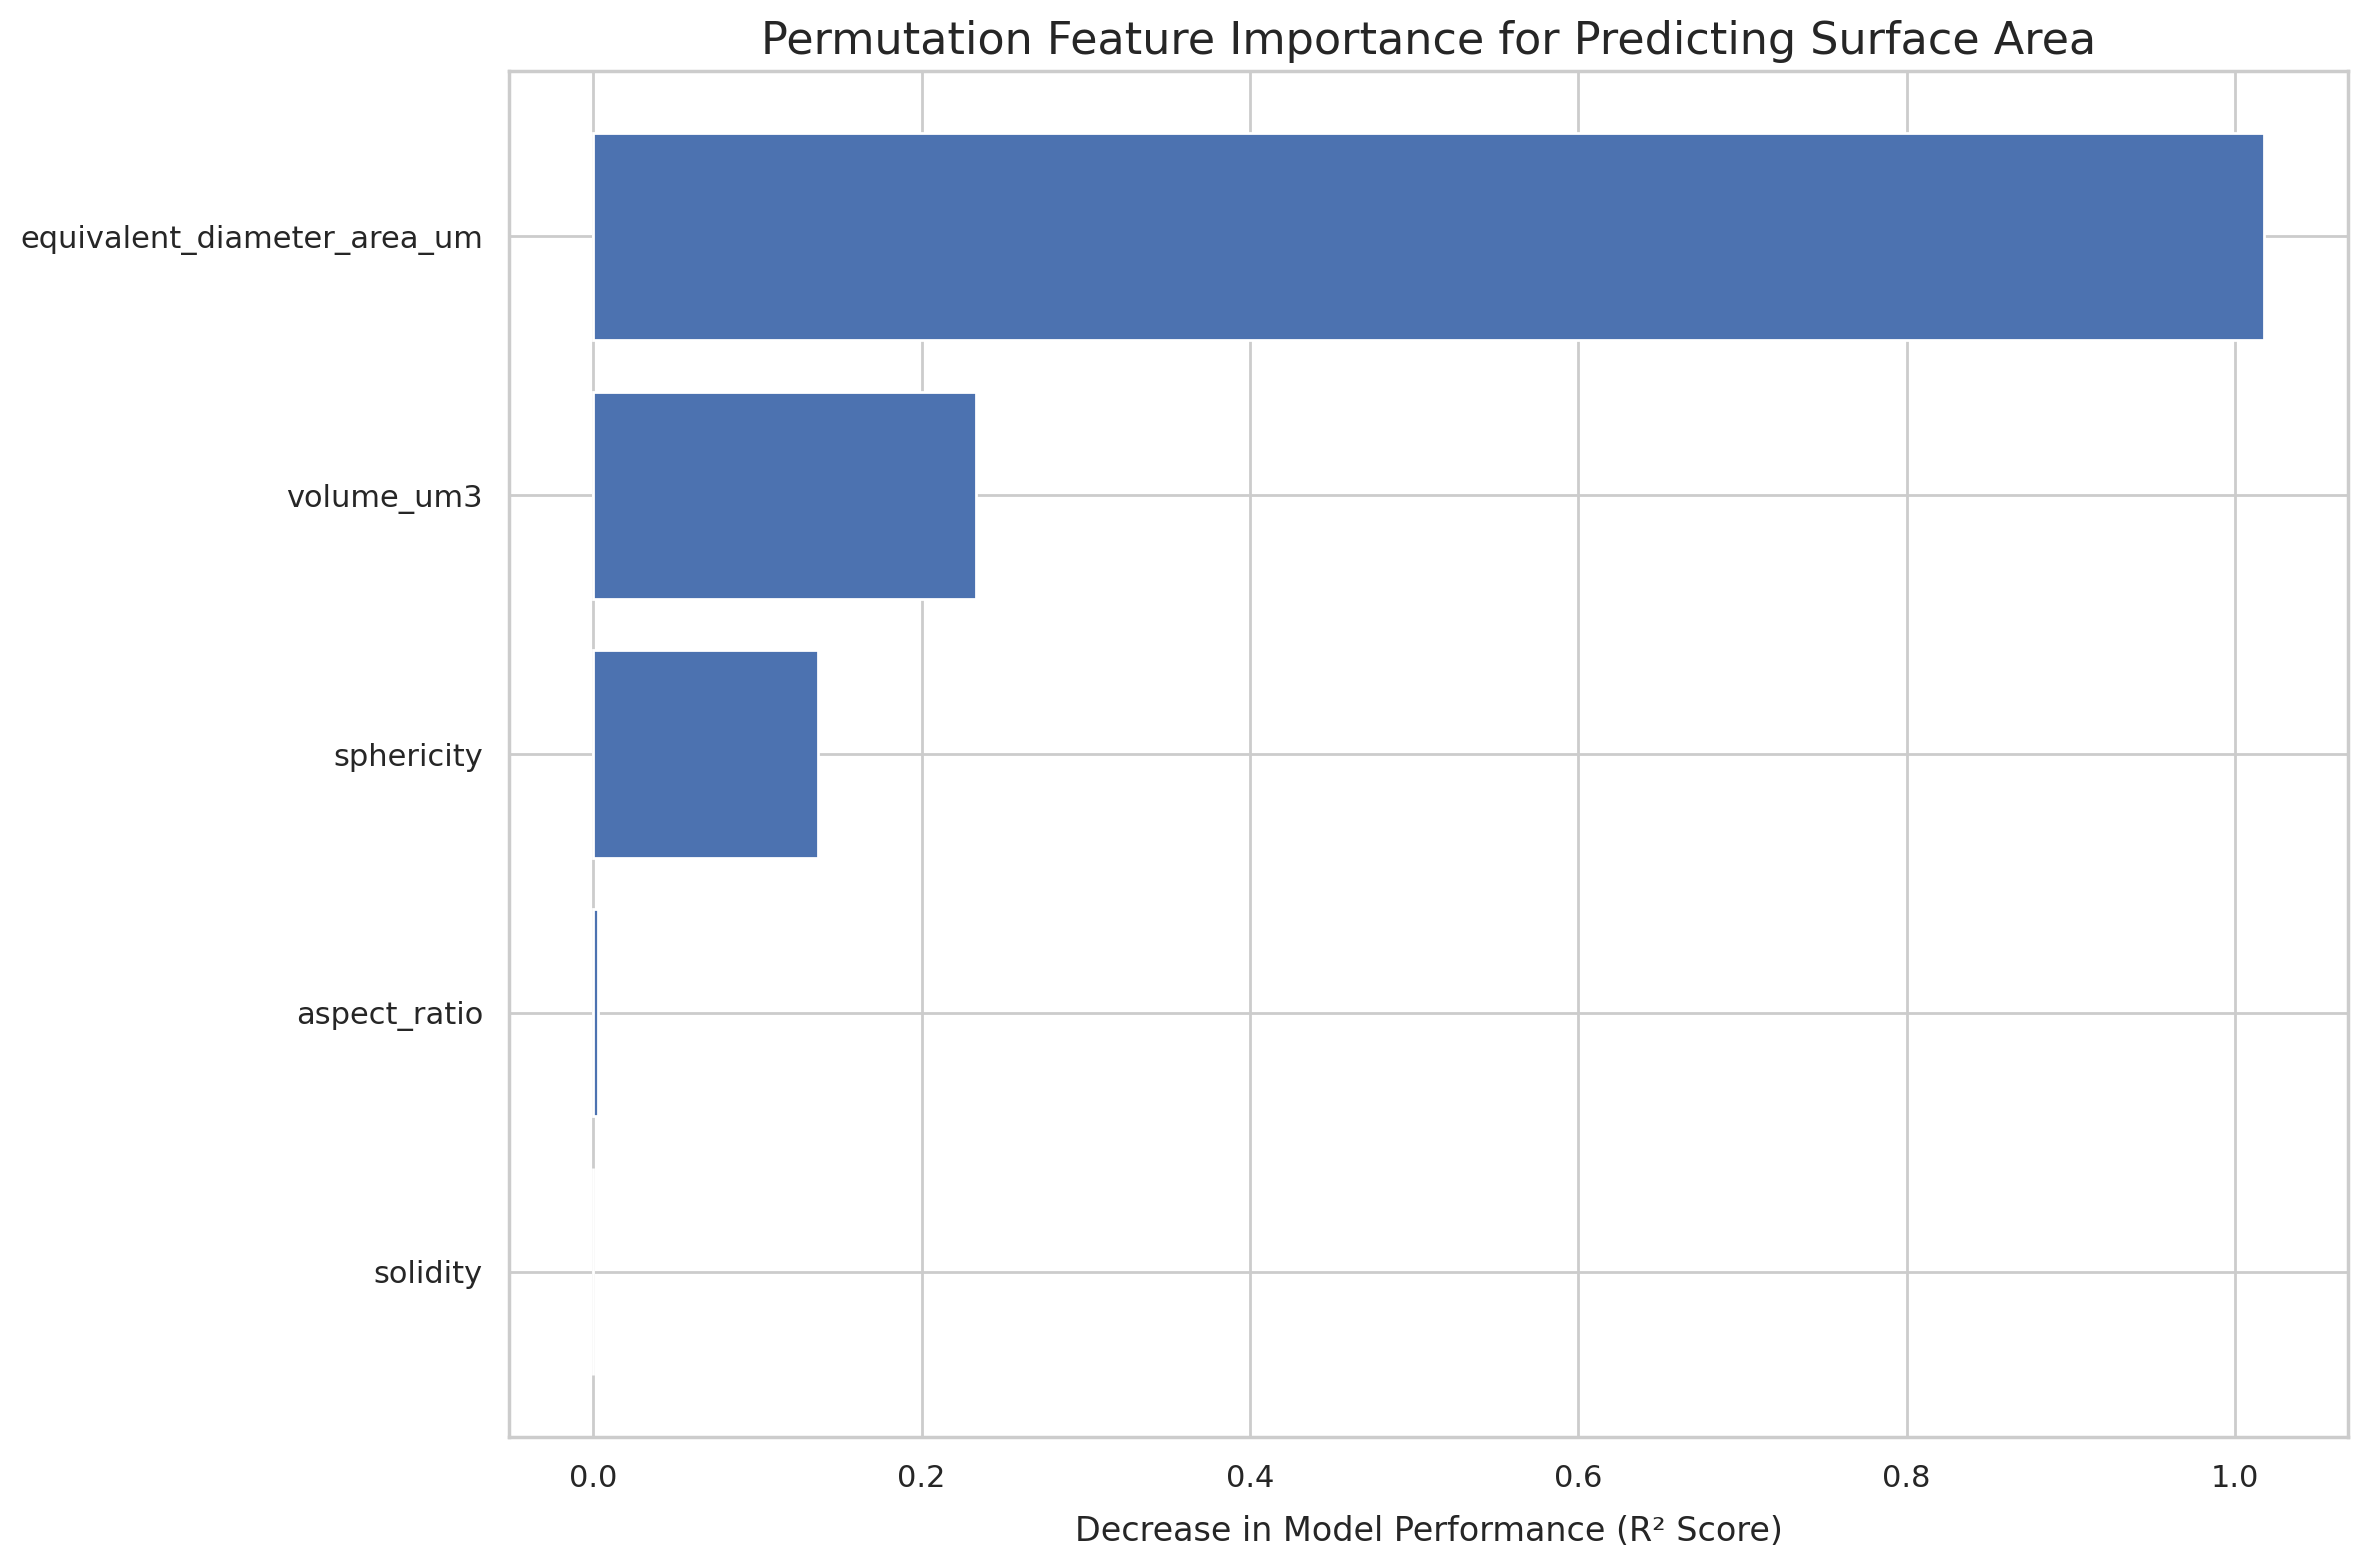


--- WORKFLOW COMPLETE ---


In [9]:
# =============================================================================
#
# SCRIPT FOR SUPERVISED PREDICTIVE MODELING OF PORE PROPERTIES
#                       USING A DEEP NEURAL NETWORK
#
# METHODOLOGY:
# This script applies a supervised machine learning workflow to predict a
# complex geometric property (surface area) from a set of simpler, more
# fundamental properties (e.g., volume, sphericity). This demonstrates the
# potential to create surrogate models for properties that may be difficult
# to measure directly.
#
#   1. Data Preparation: The script loads the full pore properties dataset,
#      performs unit conversions, and separates the data into features (X)
#      and a target variable (y). The data is then split into training and
#      testing sets and scaled.
#
#   2. DNN Model Construction: A feed-forward Deep Neural Network (DNN) is
#      constructed using TensorFlow/Keras. The architecture includes dense
#      layers with ReLU activation and Dropout for regularization.
#
#   3. Model Training: The model is trained on the training dataset. Early
#      stopping is employed to prevent overfitting by monitoring performance
#      on a validation set.
#
#   4. Performance Evaluation: The trained model's predictive accuracy is
#      evaluated on the unseen test set using metrics like Mean Absolute
#      Error (MAE) and the Coefficient of Determination (R²). A comprehensive
#      suite of visualizations, including learning curves, prediction vs.
#      actual plots, and residual analysis, is generated.
#
#   5. Feature Importance Analysis: Permutation feature importance is calculated
#      to determine which input features have the most significant impact on the
#      model's predictions.
#
# OUTPUT:
# - A trained and evaluated DNN model.
# - A quantitative and visual assessment of the model's predictive performance.
# - An analysis of the relative importance of each input feature.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. ENVIRONMENT SETUP AND DEPENDENCY INSTALLATION =====
# Set OMP_NUM_THREADS to prevent potential OpenMP-related warnings with TensorFlow.
%env OMP_NUM_THREADS=1

!pip install tensorflow openpyxl -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'output_excel_path' and 'voxel_size' variables
# exist in the current runtime environment.

if 'output_excel_path' in locals() and 'voxel_size' in locals():

    # --- 3.1. Configuration ---
    CONFIG = {
        'excel_path': output_excel_path,
        'target_variable': 'surface_area_um2',
        'feature_variables': ['volume_um3', 'sphericity', 'solidity', 'equivalent_diameter_area_um', 'aspect_ratio'],
        'test_set_size': 0.2,
        'random_state': 42,
        'epochs': 100,
        'patience': 10  # For early stopping
    }

    # Set random seeds for reproducible machine learning results
    tf.random.set_seed(CONFIG['random_state'])
    np.random.seed(CONFIG['random_state'])
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    try:
        # --- 3.2. Data Loading and Preparation ---
        print("\n[1] Preparing Data for Supervised Learning...")
        raw_df = pd.read_excel(CONFIG['excel_path'])
        print(f"    -> Loaded data for {len(raw_df)} pores.")

        # Perform unit conversions and create analysis DataFrame
        df = pd.DataFrame()
        df['volume_um3'] = raw_df['volume'] * (voxel_size ** 3)
        df['surface_area_um2'] = raw_df['surface_area'] * (voxel_size ** 2)
        df['equivalent_diameter_area_um'] = raw_df['equivalent_diameter_area'] * voxel_size
        df['aspect_ratio'] = raw_df['axis_major_length'] / raw_df['axis_minor_length'].replace(0, np.nan)
        df['sphericity'] = raw_df['sphericity'] # Already dimensionless
        df['solidity'] = raw_df['solidity']     # Already dimensionless

        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        print(f"    -> Preprocessing complete. {len(df)} valid pores remain for analysis.")

        # Define features (X) and target (y)
        X = df[CONFIG['feature_variables']]
        y = df[[CONFIG['target_variable']]]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=CONFIG['test_set_size'], random_state=CONFIG['random_state']
        )
        print(f"    -> Data split into {len(X_train)} training and {len(X_test)} testing samples.")

        # Scale features and target variable
        scaler_X = StandardScaler().fit(X_train)
        X_train_scaled = scaler_X.transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        scaler_y = StandardScaler().fit(y_train)
        y_train_scaled = scaler_y.transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)
        print("    -> Features (X) and target (y) have been scaled.")

        # --- 3.3. Deep Neural Network (DNN) Model Construction ---
        print("\n[2] Constructing the DNN model architecture...")
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1)  # Output layer for regression (linear activation)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
        model.summary()

        # --- 3.4. Model Training ---
        print("\n[3] Training the DNN model...")
        early_stopping = EarlyStopping(monitor='val_loss', patience=CONFIG['patience'], restore_best_weights=True)

        history = model.fit(
            X_train_scaled, y_train_scaled,
            epochs=CONFIG['epochs'],
            batch_size=128,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        print(f"    -> Training complete. Stopped after {len(history.history['loss'])} epochs.")

        # --- 3.5. Model Evaluation and Results Visualization ---
        print("\n[4] Evaluating model performance on the test set...")

        # Plot learning curves
        plt.figure(figsize=(12, 5))
        plt.plot(history.history['loss'], label='Training Loss (MSE)')
        plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
        plt.title('Model Learning Curves'); plt.xlabel('Epoch'); plt.ylabel('Mean Squared Error (Loss)')
        plt.legend(); plt.grid(True); plt.show()

        # Make predictions and inverse transform to original scale
        y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()
        y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_test_original = y_test.values.flatten()

        # Calculate and print performance metrics
        mae = np.mean(np.abs(y_pred_original - y_test_original))
        r2 = r2_score(y_test_original, y_pred_original)
        print(f"\n    -> Mean Absolute Error (MAE) on test set: {mae:,.2f} µm²")
        print(f"    -> Coefficient of Determination (R²) on test set: {r2:.4f}")

        # Plot predicted vs. actual values
        plt.figure(figsize=(8, 8))
        sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.5)
        plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()],
                 '--r', lw=2, label='Perfect Prediction')
        plt.xlabel(f'Actual Values ({CONFIG["target_variable"]} [µm²])')
        plt.ylabel(f'Model Predictions ({CONFIG["target_variable"]} [µm²])')
        plt.title('Model Predictions vs. Actual Values'); plt.legend()
        plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0)); plt.grid(True); plt.show()

        # Plot residual analysis
        residuals = y_test_original - y_pred_original
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        sns.scatterplot(ax=axes[0], x=y_pred_original, y=residuals, alpha=0.5)
        axes[0].axhline(0, color='red', linestyle='--'); axes[0].set_title('Residual Plot', fontsize=14)
        axes[0].set_xlabel('Predicted Values [µm²]'); axes[0].set_ylabel('Residuals (Error) [µm²]')

        sns.histplot(ax=axes[1], x=residuals, kde=True); axes[1].set_title('Distribution of Residuals', fontsize=14)
        axes[1].set_xlabel('Residuals (Error) [µm²]'); axes[1].set_ylabel('Frequency')
        plt.show()

        # --- 3.6. Feature Importance Analysis ---
        print("\n[5] Calculating Permutation Feature Importance...")

        # Define a scorer wrapper for permutation_importance
        def keras_r2_scorer(model, X, y):
            y_pred = model.predict(X, verbose=0).flatten()
            return r2_score(y.flatten(), y_pred)

        perm_importance = permutation_importance(
            model, X_test_scaled, y_test_scaled,
            n_repeats=10, random_state=CONFIG['random_state'], scoring=keras_r2_scorer
        )
        sorted_idx = perm_importance.importances_mean.argsort()

        plt.figure(figsize=(12, 8))
        plt.barh(np.array(CONFIG['feature_variables'])[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.xlabel("Decrease in Model Performance (R² Score)")
        plt.title("Permutation Feature Importance for Predicting Surface Area", fontsize=16)
        plt.show()

        print("\n--- WORKFLOW COMPLETE ---")

    except NameError as e:
        print(f"CRITICAL ERROR: A prerequisite variable was not defined. Check 'output_excel_path' and 'voxel_size'. Details: {e}")
    except FileNotFoundError:
        print(f"CRITICAL ERROR: The file '{CONFIG['excel_path']}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

else:
    print("CRITICAL ERROR: Prerequisite variables 'output_excel_path' and/or 'voxel_size' were not found.")
    print("Please ensure the previous scripts have been executed successfully.")

Dependencies checked/installed.

[1] Preparing Input Data...
    -> Analyzing subvolume of shape: (300, 300, 300)

[2] Enforcing Connectivity to Inlet Face...
    -> Found 2832 distinct pore clusters.
    -> Connectivity check complete.
       Original Subvolume Porosity: 0.0636
       Connected Porosity:          0.0114

[3] Executing Multi-Scenario Drainage Simulations...

    Processing Scenario: Air-Water
     - Simulating with gravity...
     - Simulating without gravity...

    Processing Scenario: Oil-Water
     - Simulating with gravity...
     - Simulating without gravity...

    Processing Scenario: Gas-Oil
     - Simulating with gravity...
     - Simulating without gravity...

--- All simulations completed successfully. ---

[4] Generating Comparative Plot...


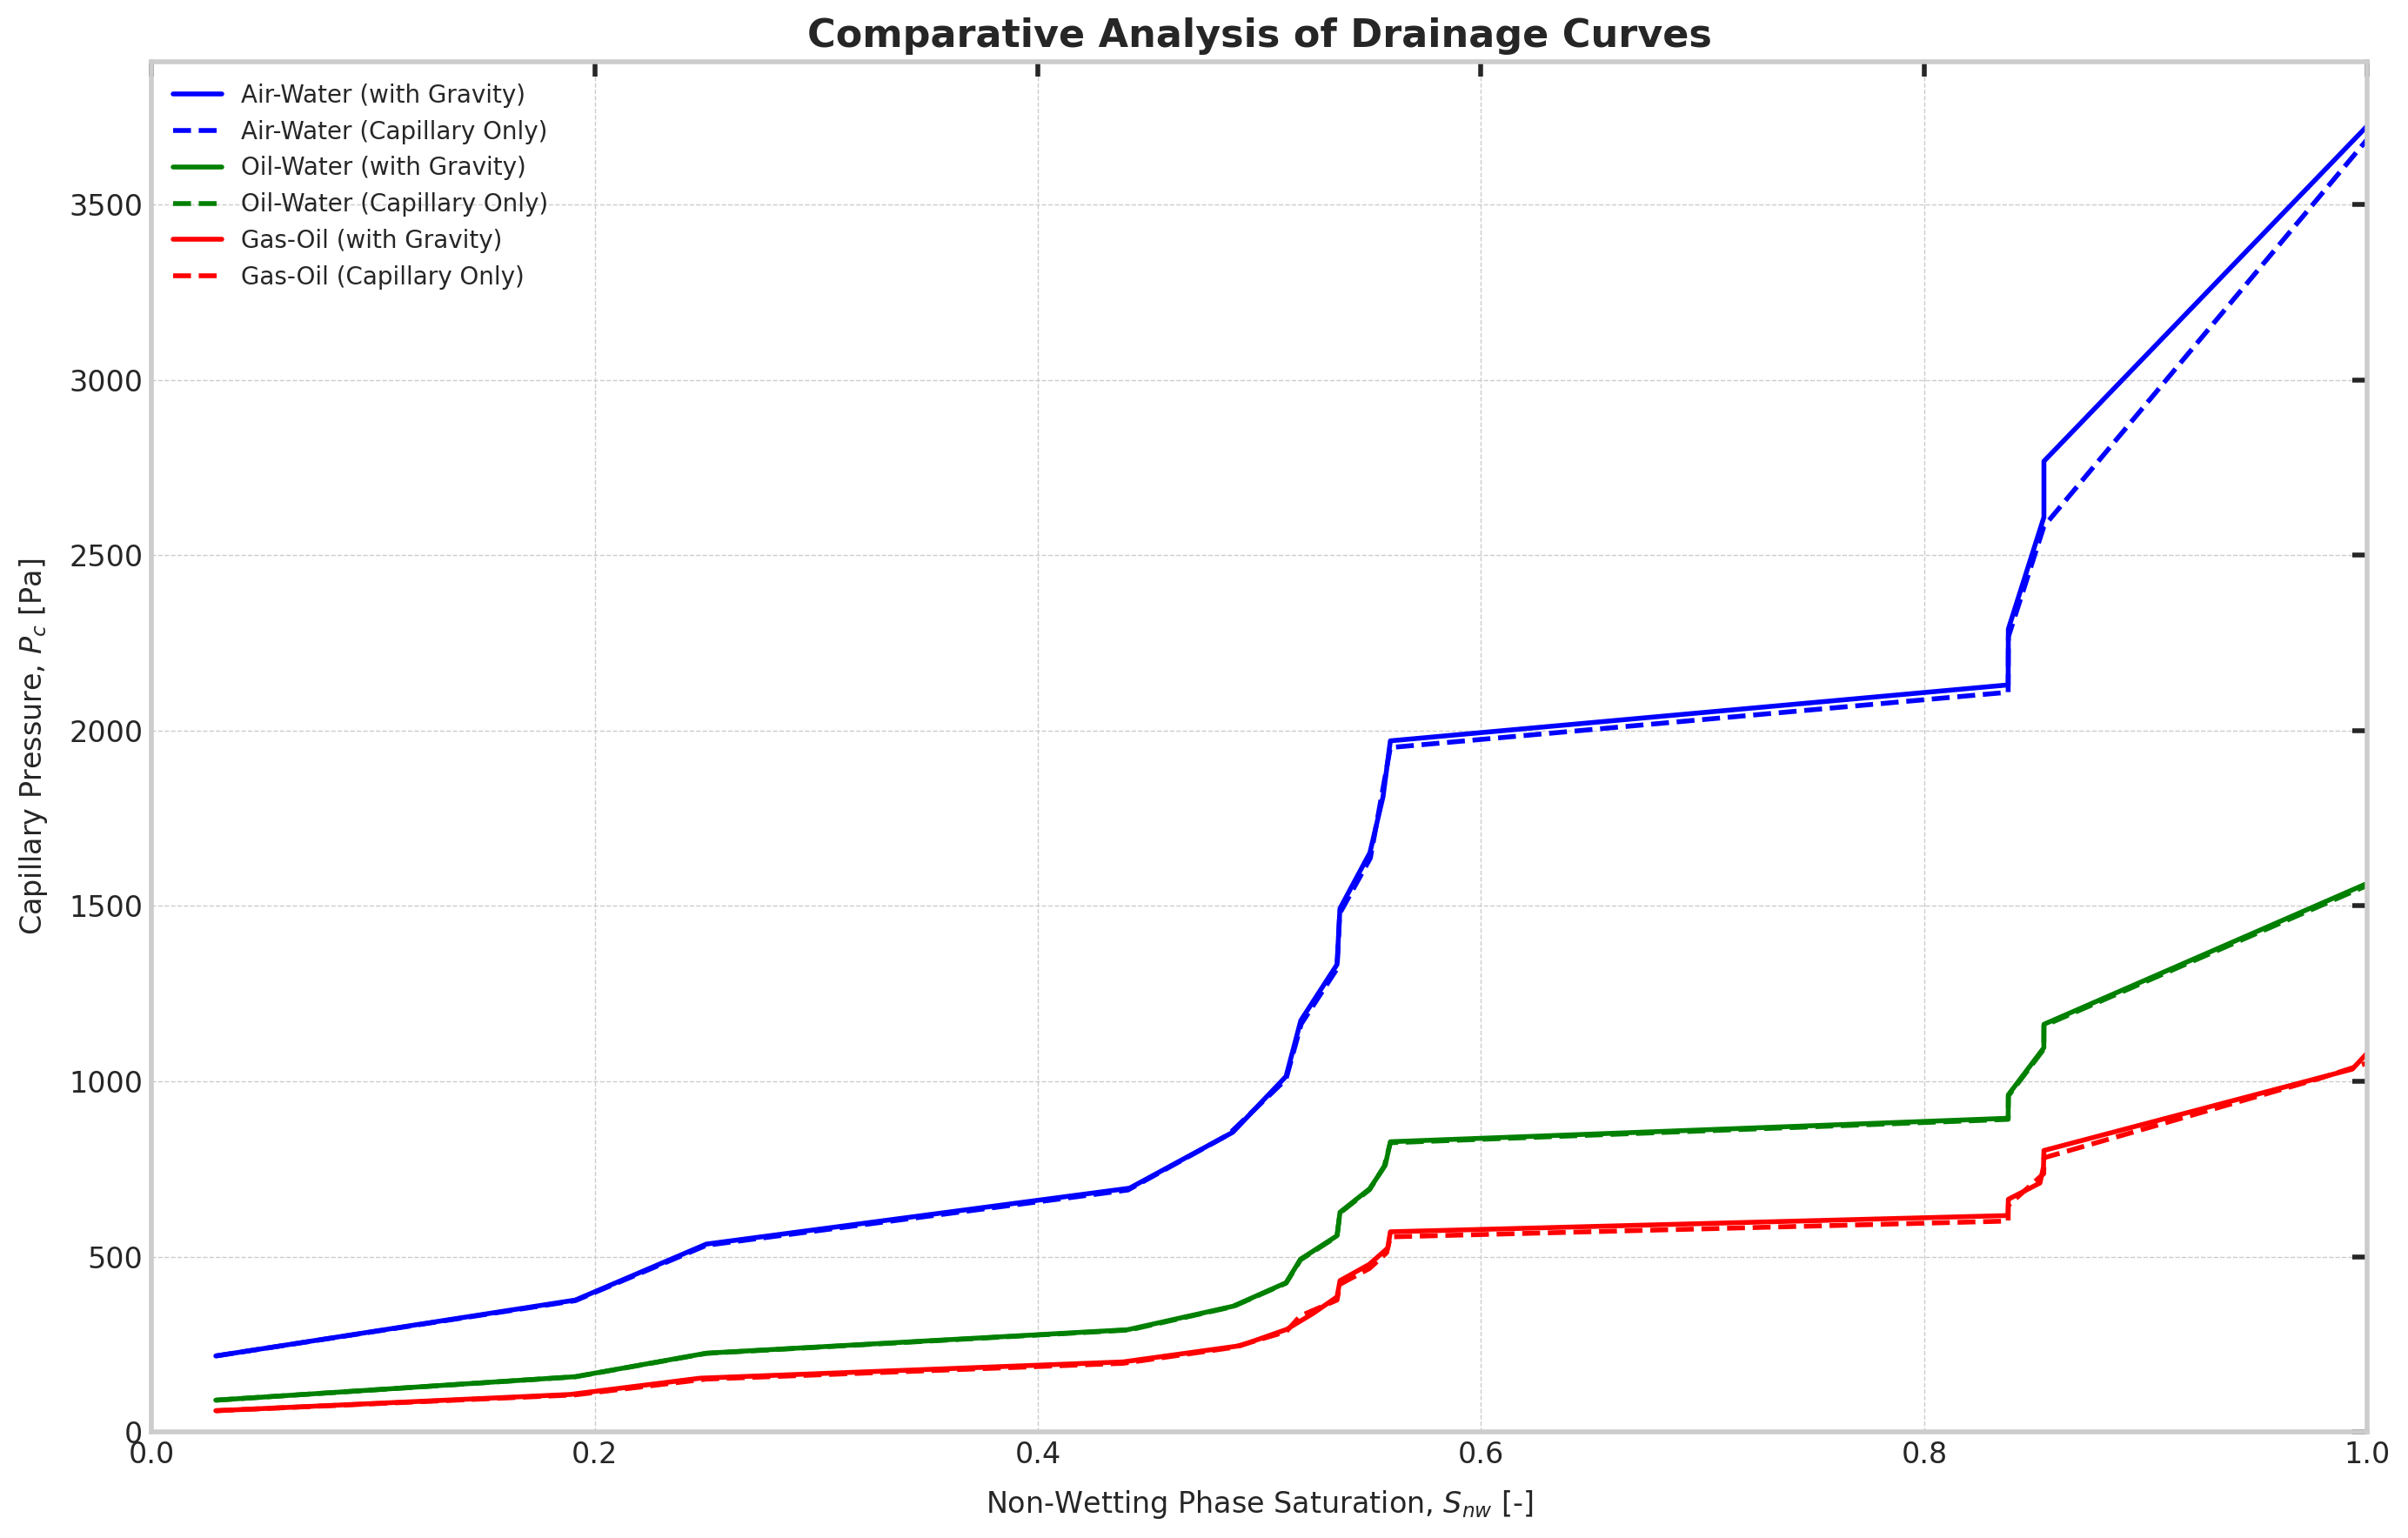


--- ANALYSIS COMPLETE ---


In [10]:
# =============================================================================
#
# SCRIPT FOR COMPARATIVE ANALYSIS OF CAPILLARY DRAINAGE SIMULATIONS
#
# METHODOLOGY:
# This script performs a series of advanced drainage simulations on a 3D porous
# medium to investigate the influence of fluid properties and gravitational
# forces on capillary pressure curves.
#
# The workflow is as follows:
#   1. Input Preparation: A subvolume is cropped from the full binarized image
#      to ensure computational feasibility.
#   2. Connectivity Enforcement: The script identifies and isolates the
#      "percolating cluster" – the portion of the pore space that is
#      connected to the inlet face, which is the only volume that can
#      participate in the drainage process.
#   3. Multi-Scenario Simulation: A core simulation function is executed
#      iteratively for several predefined fluid systems (e.g., Air-Water,
#      Oil-Water). For each system, two simulations are run:
#      a. With Capillary Forces Only.
#      b. With Combined Capillary and Gravitational Forces. The total
#         pressure field is Pc_total = Pc_geometric + Pc_gravity, where
#         Pc_gravity = Δρ * g * h.
#   4. Comparative Visualization: All resulting capillary pressure curves are
#      plotted on a single graph, allowing for a direct comparison of the
#      effects of fluid type and gravity.
#
# OUTPUT:
# - A comprehensive plot comparing the drainage curves for all simulated scenarios.
# - A nested dictionary (`results`) containing the raw data for each curve.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install porespy edt -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
from edt import edt
import gc
import scipy.ndimage as spim
from typing import Dict

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 3.1. Configuration ---
    SIMULATION_CONFIG = {
        'subvolume_shape': (300, 300, 300),
        'fluid_scenarios': {
            "Air-Water": {'sigma': 0.072, 'delta_rho': 997.0},
            "Oil-Water": {'sigma': 0.030, 'delta_rho': 150.0},
            "Gas-Oil":   {'sigma': 0.020, 'delta_rho': 750.0}
        },
        'contact_angle_degrees': 180.0, # Simulates a non-wetting fluid
        'gravity_constant': 9.81  # m/s^2
    }

    # --- 3.2. Helper Function Definition ---
    def run_drainage_simulation(
        pore_image: np.ndarray,
        voxel_size_m: float,
        fluid_props: Dict,
        include_gravity: bool = True
    ) -> pd.DataFrame:
        """
        Executes a single drainage simulation for a given scenario.

        Args:
            pore_image (np.ndarray): The 3D boolean image of the pore space (True=Pore).
            voxel_size_m (float): The voxel resolution in meters.
            fluid_props (Dict): A dictionary with 'sigma' (interfacial tension)
                                and 'delta_rho' (density difference).
            include_gravity (bool): If True, adds the gravitational pressure
                                    term to the capillary pressure field.

        Returns:
            pd.DataFrame: A DataFrame containing the capillary pressure curve
                          (pressure vs. non-wetting phase saturation).
        """
        # Calculate the geometric capillary pressure map based on local pore radius
        # The edt function computes the Euclidean distance transform.
        distance_map = edt(pore_image) * voxel_size_m
        distance_map[distance_map == 0] = np.inf # Avoid division by zero in solid phase

        pc_geometric = -2 * fluid_props['sigma'] * np.cos(np.deg2rad(SIMULATION_CONFIG['contact_angle_degrees'])) / distance_map

        total_pc_field = pc_geometric

        if include_gravity:
            # Calculate the gravitational pressure head map
            height_map_seed = np.ones_like(pore_image)
            height_map_seed[0, :, :] = False # Define z=0 as the top
            height_map = edt(height_map_seed) * voxel_size_m
            pc_gravity = fluid_props['delta_rho'] * SIMULATION_CONFIG['gravity_constant'] * height_map
            total_pc_field = pc_geometric + pc_gravity

        # Ensure float32 for PoreSpy compatibility and memory efficiency
        total_pc_field = total_pc_field.astype(np.float32)

        # Define the inlet face for the non-wetting fluid
        inlets = np.zeros_like(pore_image, dtype=bool)
        inlets[0, :, :] = True

        # Run the PoreSpy drainage simulation
        drainage_sim = ps.simulations.drainage(im=pore_image, pc=total_pc_field, inlets=inlets, voxel_size=voxel_size_m)

        # Convert the resulting saturation map into a Pc-Sw curve
        pc_curve = ps.metrics.pc_map_to_pc_curve(pc=drainage_sim.im_pc, im=pore_image)

        # RAM Optimization: Clean up large intermediate arrays
        del distance_map, pc_geometric, total_pc_field, drainage_sim
        gc.collect()

        return pc_curve

    # --- 3.3. Input Data Preparation ---
    print("\n[1] Preparing Input Data...")
    pore_space_full = ~binarized_3d_image

    # Crop a subvolume for computationally feasible analysis
    s_y = pore_space_full.shape[1] // 2 - SIMULATION_CONFIG['subvolume_shape'][1] // 2
    s_x = pore_space_full.shape[2] // 2 - SIMULATION_CONFIG['subvolume_shape'][2] // 2
    subvolume = pore_space_full[:, s_y:s_y + SIMULATION_CONFIG['subvolume_shape'][1], s_x:s_x + SIMULATION_CONFIG['subvolume_shape'][2]].copy()
    print(f"    -> Analyzing subvolume of shape: {subvolume.shape}")

    # RAM Optimization
    del pore_space_full
    gc.collect()

    # --- 3.4. Connectivity Enforcement ---
    print("\n[2] Enforcing Connectivity to Inlet Face...")
    # This step removes all pore regions that are not connected to the inlet,
    # as they would not participate in the drainage process.
    inlet_seed = np.zeros_like(subvolume, dtype=bool)
    inlet_seed[0, :, :] = True

    # Label all distinct pore clusters
    pore_labels, num_labels = spim.label(subvolume)
    print(f"    -> Found {num_labels} distinct pore clusters.")

    # Find the labels of clusters that touch the inlet face
    inlet_cluster_labels = np.unique(pore_labels[inlet_seed])
    inlet_cluster_labels = inlet_cluster_labels[inlet_cluster_labels > 0] # Remove background label 0

    # Create a new image containing only the connected pore clusters
    connected_pore_space = np.isin(pore_labels, inlet_cluster_labels)

    original_porosity = np.mean(subvolume)
    connected_porosity = np.mean(connected_pore_space)
    print(f"    -> Connectivity check complete.")
    print(f"       Original Subvolume Porosity: {original_porosity:.4f}")
    print(f"       Connected Porosity:          {connected_porosity:.4f}")

    # --- 3.5. Execute Simulation Scenarios ---
    print("\n[3] Executing Multi-Scenario Drainage Simulations...")
    voxel_size_meters = voxel_size * 1e-6
    results = {}

    for name, props in SIMULATION_CONFIG['fluid_scenarios'].items():
        print(f"\n    Processing Scenario: {name}")
        results[name] = {}
        print("     - Simulating with gravity...")
        results[name]['with_gravity'] = run_drainage_simulation(connected_pore_space, voxel_size_meters, props, include_gravity=True)
        print("     - Simulating without gravity...")
        results[name]['without_gravity'] = run_drainage_simulation(connected_pore_space, voxel_size_meters, props, include_gravity=False)

    print("\n--- All simulations completed successfully. ---")

    # --- 3.6. Results Visualization ---
    print("\n[4] Generating Comparative Plot...")
    ps.visualization.set_mpl_style()
    plt.figure(figsize=(14, 9))

    colors = {'Air-Water': 'blue', 'Oil-Water': 'green', 'Gas-Oil': 'red'}
    linestyles = {'with_gravity': '-', 'without_gravity': '--'}

    for scenario_name, scenario_results in results.items():
        # Plot with gravity (solid line)
        curve_g = scenario_results['with_gravity']
        plt.plot(curve_g.snwp, curve_g.pc, linestyle=linestyles['with_gravity'], color=colors[scenario_name],
                 label=f'{scenario_name} (with Gravity)')

        # Plot without gravity (dashed line)
        curve_no_g = scenario_results['without_gravity']
        plt.plot(curve_no_g.snwp, curve_no_g.pc, linestyle=linestyles['without_gravity'], color=colors[scenario_name],
                 label=f'{scenario_name} (Capillary Only)')

    plt.xlabel("Non-Wetting Phase Saturation, $S_{nw}$ [-]", fontsize=12)
    plt.ylabel("Capillary Pressure, $P_c$ [Pa]", fontsize=12)
    plt.title("Comparative Analysis of Drainage Curves", fontsize=16, fontweight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(bottom=0)
    plt.show()

    print("\n--- ANALYSIS COMPLETE ---")

else:
    print("CRITICAL ERROR: Prerequisite variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure prior scripts have been executed successfully.")

In [11]:
# =============================================================================
#
# SCRIPT FOR ANISOTROPIC TORTUOSITY ANALYSIS IN A 3D POROUS MEDIUM
#
# METHODOLOGY:
# This script calculates the tortuosity of a porous medium, a key parameter
# that describes the convolutedness of pore pathways. The analysis is performed
# independently along the three principal axes (X, Y, Z) to assess the
# sample's anisotropy.
#
# WORKFLOW:
#   1. Input Preparation: A subvolume is cropped for efficient analysis.
#   2. Connectivity Enforcement: For each axis, the script identifies and
#      isolates the "percolating cluster" – the portion of the pore space
#      forming a continuous path from the inlet to the outlet face.
#   3. Tortuosity Simulation: A steady-state diffusion process is simulated
#      through the connected pore space to calculate effective diffusivity,
#      from which tortuosity (τ) is derived.
#   4. Results Analysis: The script reports tortuosity, formation factor (F),
#      and effective (connected) porosity for each direction.
#   5. Visualization: A cross-section of the simulated concentration field is
#      plotted to visualize the diffusion pathways.
#
# OUTPUT:
# - A summary of the anisotropic tortuosity and related properties.
# - A plot of the concentration gradient for one of the simulated directions.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# PoreSpy requires OpenPNM for this simulation.
!pip install porespy openpnm -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spim
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'binarized_3d_image' variable exists
# in the current runtime environment from the image processing script.

if 'binarized_3d_image' in locals():

    # --- 3.1. Configuration and Input Preparation ---
    CONFIG = {
        'subvolume_shape': (300, 300, 300) # Define a cubic subvolume for analysis
    }

    print("[1] Preparing Input Data for Tortuosity Analysis...")
    # Invert the image to analyze the pore space (True = Pore).
    pore_space_full = ~binarized_3d_image

    # Crop a subvolume for a computationally feasible analysis.
    s_y = pore_space_full.shape[1] // 2 - CONFIG['subvolume_shape'][1] // 2
    s_x = pore_space_full.shape[2] // 2 - CONFIG['subvolume_shape'][2] // 2
    subvolume = pore_space_full[:, s_y:s_y + CONFIG['subvolume_shape'][1], s_x:s_x + CONFIG['subvolume_shape'][2]].copy()
    print(f"    -> Analysis will be performed on a subvolume of shape: {subvolume.shape}")

    # RAM Optimization: The full-sized image is no longer needed.
    del pore_space_full
    gc.collect()

    # --- 3.2. Connectivity Enforcement ---
    print("\n[2] Enforcing Connectivity for each axis...")
    # This step is critical to ensure a percolating pathway exists.

    connected_spaces = {}
    original_porosity = np.mean(subvolume)

    for axis_index, axis_name in enumerate(['Z', 'Y', 'X']):
        inlet_face_seed = np.zeros_like(subvolume, dtype=bool)
        if axis_index == 0: inlet_face_seed[0, :, :] = True
        elif axis_index == 1: inlet_face_seed[:, 0, :] = True
        else: inlet_face_seed[:, :, 0] = True

        connected_space = spim.binary_propagation(input=inlet_face_seed, mask=subvolume)

        connected_spaces[axis_name] = connected_space

        effective_porosity = np.mean(connected_space)
        print(f"    -> Axis {axis_name}: Original Porosity={original_porosity:.4f}, Effective (Connected) Porosity={effective_porosity:.4f}")
        if effective_porosity == 0:
            print(f"       WARNING: No percolating pathway found for the {axis_name}-axis.")

    # --- 3.3. Execute Tortuosity Simulations ---
    print("\n[3] Executing Tortuosity Simulations...")
    tortuosity_results = {}

    for axis_index, axis_name in enumerate(['Z', 'Y', 'X']):
        print(f"\n    Calculating tortuosity for the {axis_name}-axis (axis={axis_index})...")

        # Select the pre-calculated connected space for the current direction
        image_to_run = connected_spaces[axis_name]

        if np.any(image_to_run): # Proceed only if a connected path exists
            try:
                # tortuosity_fd simulates diffusion and calculates tortuosity
                results = ps.simulations.tortuosity_fd(im=image_to_run, axis=axis_index)
                tortuosity_results[axis_name] = results
                print(f"    -> Calculation for {axis_name}-axis completed.")
            except Exception as e:
                print(f"    -> ERROR during simulation on {axis_name}-axis: {e}")
                tortuosity_results[axis_name] = None
        else:
            print("    -> SKIPPED: No connected pore space available for this axis.")
            tortuosity_results[axis_name] = None

    # --- 3.4. Summarize and Visualize Results ---
    print("\n\n--- FINAL ANALYSIS RESULTS ---")
    ps.visualization.set_mpl_style()

    has_successful_run = False
    for axis_name, res in tortuosity_results.items():
        if res:
            has_successful_run = True
            print(f"\nResults for {axis_name}-Direction:")
            print(f"  - Tortuosity (τ):                {res.tortuosity:.4f}")
            print(f"  - Original Subvolume Porosity:   {res.original_porosity:.4f}")
            print(f"  - Effective (Connected) Porosity:{res.effective_porosity:.4f}")
            print(f"  - Formation Factor (F):          {res.formation_factor:.4f}")
        else:
            print(f"\nResults for {axis_name}-Direction: Not computed (non-percolating).")

    # Visualize the concentration field of the first successful simulation
    if has_successful_run:
        # Find the first valid result to plot
        for axis_name in ['Z', 'Y', 'X']:
            if tortuosity_results.get(axis_name):
                res_to_plot = tortuosity_results[axis_name]

                # Determine a central slice perpendicular to the flow direction
                if axis_name == 'Z':   # Flow along Z, slice in Y
                    slice_axis = 1; slice_index = res_to_plot.im_conc.shape[slice_axis] // 2
                    x_label, y_label = 'X-axis', 'Z-axis'
                elif axis_name == 'Y': # Flow along Y, slice in Z
                    slice_axis = 0; slice_index = res_to_plot.im_conc.shape[slice_axis] // 2
                    x_label, y_label = 'X-axis', 'Y-axis'
                else:                  # Flow along X, slice in Y
                    slice_axis = 1; slice_index = res_to_plot.im_conc.shape[slice_axis] // 2
                    x_label, y_label = 'X-axis', 'Z-axis'

                # Slicing the concentration map for visualization
                if slice_axis == 0: conc_slice = res_to_plot.im_conc[slice_index, :, :]
                elif slice_axis == 1: conc_slice = res_to_plot.im_conc[:, slice_index, :]
                else: conc_slice = res_to_plot.im_conc[:, :, slice_index]

                plt.figure(figsize=(8, 8))
                plt.imshow(conc_slice.T, origin='lower', cmap=plt.cm.plasma)
                plt.colorbar(label='Normalized Concentration')
                plt.title(f'Concentration Field for Simulation along {axis_name}-axis')
                plt.xlabel(x_label); plt.ylabel(y_label)
                plt.show()
                break # Show only one plot

    print("\n--- ANALYSIS COMPLETE ---")

else:
    # Error message if the prerequisite variable is not found.
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.
[1] Preparing Input Data for Tortuosity Analysis...
    -> Analysis will be performed on a subvolume of shape: (300, 300, 300)

[2] Enforcing Connectivity for each axis...
    -> Axis Z: Original Porosity=0.0636, Effective (Connected) Porosity=0.0145
    -> Axis Y: Original Porosity=0.0636, Effective (Connected) Porosity=0.0091
    -> Axis X: Original Porosity=0.0636, Effective (Connected) Porosity=0.0049

[3] Executing Tortuosity Simulations...

    Calculating tortuosity for the Z-axis (axis=0)...
    -> ERROR during simulation on Z-axis: No pores remain after trimming floating pores

    Calculating tortuosity for the Y-axis (axis=1)...
    -> ERROR during simulation on Y-axis: No pores remain after trimming floating pores

    Calculating tortuosity for the X-axis (axis=2)...
    -> ERROR during simulation on X-axis: No pores remain after trimming floating pores


--- FINAL ANALYSIS RESULTS ---

Results for Z-Direction: Not computed (non-percolating)

In [12]:
# =============================================================================
#
# SCRIPT FOR ABSOLUTE PERMEABILITY CALCULATION VIA PORE NETWORK MODELING
#
# METHODOLOGY:
# This script calculates the absolute permeability of a 3D porous medium by
# performing a Stokes flow simulation on an extracted pore network model (PNM).
#
#   1. Pore Network Extraction: The `porespy.networks.snow2` algorithm is used
#      to extract a representative pore network from the 3D image.
#   2. Network Refinement (Connectivity Enforcement): All pores not part of a
#      continuous path between the main inlet and outlet faces are identified
#      and trimmed from the network. This is a critical step for resolving
#      simulation errors.
#   3. Physics and Geometry Assignment: The OpenPNM framework is used to assign
#      geometric properties and physical models to the network elements.
#   4. Stokes Flow Simulation: A single-phase Stokes flow simulation is run
#      independently along the three principal axes (X, Y, Z).
#   5. Permeability Calculation: The permeability (K) is calculated from the
#      total flow rate (Q) using Darcy's law.
#
# OUTPUT:
# - A summary of the calculated absolute permeability for the X, Y, and Z axes.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install porespy openpnm -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 3.1. Configuration and Input Preparation ---
    print("\n[1] Preparing Input Data for Pore Network Modeling...")

    pore_space = ~binarized_3d_image
    print(f"    -> Analyzing full image with dimensions: {pore_space.shape}")

    voxel_size_meters = voxel_size * 1e-6
    print(f"    -> Voxel size defined: {voxel_size} µm ({voxel_size_meters:.2e} m)")

    # --- 3.2. Pore Network Extraction ---
    print("\n[2] Extracting pore network using the SNOW algorithm...")
    print("    -> This is a computationally intensive step and may take several minutes.")

    snow_output = ps.networks.snow2(phases=pore_space, voxel_size=voxel_size_meters)
    pn = op.io.network_from_porespy(snow_output.network)
    proj = pn.project
    print("    -> Network extraction and import to OpenPNM complete.")
    print(f"       Initial network contains {pn.Np} pores and {pn.Nt} throats.")

    del pore_space, snow_output
    gc.collect()
    print("    -> Memory Optimized: Large 3D image arrays released.")

    # --- 3.3. Network Refinement and Physics Assignment ---
    print("\n[3] Refining Network and Assigning Physics...")

    # Label boundary faces for applying boundary conditions
    op.topotools.label_faces(network=pn)

    # Assign geometric models to the network elements (pores and throats)
    pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
    pn.regenerate_models()
    print("    -> Geometric models assigned.")

    # Define the fluid phase and its physical properties
    water = op.phase.Water(network=pn)
    water.add_model(propname='throat.hydraulic_conductance',
                    model=op.models.physics.hydraulic_conductance.hagen_poiseuille)
    water.regenerate_models()
    print("    -> Fluid phase and physics models configured.")

    # --- 3.4. Execute Anisotropic Permeability Simulations ---
    print("\n[4] Initiating Stokes flow simulations...")
    permeability_results = {}

    flow_axes = {
        'X': ('front', 'back'),
        'Y': ('left', 'right'),
        'Z': ('top', 'bottom')
    }

    for axis, (inlet_face, outlet_face) in flow_axes.items():
        print(f"\n    Calculating permeability for the {axis}-axis...")
        try:

            pn_trimmed = proj.clone()
            inlet_pores = pn_trimmed.pores(inlet_face)
            outlet_pores = pn_trimmed.pores(outlet_face)

            op.topotools.trim_disconnected_pores(
                network=pn_trimmed,
                inlets=inlet_pores,
                outlets=outlet_pores
            )
            print(f"       Network trimmed for {axis}-axis flow. Pores remaining: {pn_trimmed.Np}")
            # -----------------------------------------------------------------

            # The simulation must now be run on the trimmed network (pn_trimmed)
            flow = op.algorithms.StokesFlow(network=pn_trimmed, phase=water)

            P_in, P_out = 1.0, 0.0
            # Use the trimmed network's face labels for boundary conditions
            flow.set_value_BC(pores=pn_trimmed.pores(inlet_face), values=P_in)
            flow.set_value_BC(pores=pn_trimmed.pores(outlet_face), values=P_out)

            flow.run()

            Q = flow.rate(pores=pn_trimmed.pores(inlet_face))[0]

            # The domain area and length should be taken from the original network
            # to represent the full sample dimensions.
            A = op.topotools.get_domain_area(pn, inlets=pn.pores(inlet_face), outlets=pn.pores(outlet_face))
            L = op.topotools.get_domain_length(pn, inlets=pn.pores(inlet_face), outlets=pn.pores(outlet_face))

            mu = water['pore.viscosity'].mean()
            delta_P = P_in - P_out
            K_m2 = (Q * mu * L) / (A * delta_P)

            mD_conversion_factor = 1 / (0.986923e-15)
            K_mD = K_m2 * mD_conversion_factor

            permeability_results[axis] = K_mD
            print(f"    -> Calculation for {axis}-axis complete.")

        except Exception as e:
            print(f"    -> ERROR during {axis}-axis calculation: {e}")
            permeability_results[axis] = None

    # --- 3.5. Summarize Results ---
    print("\n\n--- FINAL PERMEABILITY RESULTS ---")
    for axis, K in permeability_results.items():
        if K is not None:
            print(f"  - Permeability along {axis}-axis (K_{axis.lower()}): {K:.4f} mD")
        else:
            print(f"  - Permeability along {axis}-axis: Calculation failed.")

    print("\n--- ANALYSIS COMPLETE ---")

else:
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure prior scripts have been executed successfully.")

Dependencies checked/installed.

[1] Preparing Input Data for Pore Network Modeling...
    -> Analyzing full image with dimensions: (300, 300, 300)
    -> Voxel size defined: 40.0 µm (4.00e-05 m)

[2] Extracting pore network using the SNOW algorithm...
    -> This is a computationally intensive step and may take several minutes.
5it [00:00, 45.93it/s]
10it [00:00, 38.54it/s]
14it [00:00, 33.41it/s]
18it [00:00, 32.40it/s]
22it [00:00, 31.24it/s]
27it [00:00, 34.56it/s]
31it [00:00, 35.42it/s]
35it [00:01, 30.54it/s]
26it [00:00, 27.62it/s]
39it [00:01, 25.30it/s]
42it [00:01, 20.57it/s]
45it [00:01, 18.25it/s]
48it [00:01, 18.75it/s]
52it [00:01, 22.73it/s]
56it [00:02, 25.57it/s]
47it [00:01, 21.32it/s]
59it [00:02, 20.72it/s]
62it [00:02, 20.50it/s]
66it [00:02, 24.56it/s]
69it [00:02, 24.74it/s]
72it [00:02, 22.06it/s]
77it [00:02, 28.11it/s]
81it [00:03, 29.91it/s]
88it [00:03, 20.39it/s]
95it [00:03, 24.16it/s]
99it [00:03, 27.37it/s]
103it [00:04, 25.24it/s]
107it [00:04, 27.78it

# Propriedades Geométricas e Estruturais

In [13]:
# =============================================================================
#
# SCRIPT FOR TOTAL AND EFFECTIVE POROSITY CALCULATION
#
# METHODOLOGY:
# This script calculates two fundamental types of porosity from a binarized
# 3D image of a porous medium.
#
#   1. Total Porosity (Φ_total):
#      This represents the fraction of the total volume of the sample that is
#      occupied by void space (pores), regardless of whether these pores are
#      interconnected. It is calculated as:
#      Φ_total = (Volume of all pores) / (Total volume of the sample)
#
#   2. Effective Porosity (Φ_effective):
#      This is a more practical metric representing the fraction of the total
#      volume occupied by the *interconnected* pore space. In this script, it
#      is estimated by identifying all disconnected pore clusters and
#      considering only the volume of the single largest cluster. This largest
#      cluster is often assumed to be the main percolating pathway that
#      contributes to fluid flow. It is calculated as:
#      Φ_effective = (Volume of largest pore cluster) / (Total volume of the sample)
#
# OUTPUT:
# - A printed summary of the calculated Total and Effective Porosity values.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. LIBRARY IMPORTS =====
import numpy as np
from scipy.ndimage import label
import gc

# ===== 2. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'binarized_3d_image' variable exists in the
# current runtime environment from the initial image processing script.

if 'binarized_3d_image' in locals():

    print("--- Initiating Porosity Calculation ---")

    # --- 2.1. Input Data Preparation ---
    # The input image convention is True=Solid, False=Pore.
    # Invert the image to create a boolean mask of the pore space (True = Pore).
    pore_space = ~binarized_3d_image

    # --- 2.2. Total Porosity Calculation ---
    # The mean of a boolean array, where True=1 and False=0, directly yields
    # the volume fraction of the True phase (i.e., the total porosity).
    total_porosity = np.mean(pore_space)

    # --- 2.3. Effective Porosity Calculation ---
    # Use connected-component labeling to identify all distinct pore clusters.
    # The `label` function returns a new array with each cluster assigned a
    # unique integer ID.
    print("\n[1] Identifying connected pore clusters...")
    labeled_pore_space, num_clusters = label(pore_space)

    effective_porosity = 0.0  # Default value

    if num_clusters > 0:
        print(f"    -> Found {num_clusters} distinct pore clusters.")

        # Get the unique label IDs and the voxel count for each.
        cluster_labels, cluster_counts = np.unique(labeled_pore_space, return_counts=True)

        # RAM Optimization: The large integer label array is no longer needed.
        del labeled_pore_space
        gc.collect()

        # The background (solid phase) has label 0. We find the maximum count
        # among the actual pore clusters (labels > 0).
        if len(cluster_counts) > 1:
            largest_cluster_volume_voxels = np.max(cluster_counts[1:])

            # Calculate effective porosity based on the largest cluster.
            total_volume_voxels = pore_space.size
            effective_porosity = largest_cluster_volume_voxels / total_volume_voxels
        else:
            print("    -> No pore clusters found after labeling.")

    else:
        print("    -> No pore phase found. Porosity is 0%.")

    # --- 2.4. Final Results Summary ---
    print("\n--- Porosity Analysis Results ---")
    print(f"  - Total Porosity (Φ_total):       {total_porosity:.4f} (or {total_porosity:.2%})")
    print(f"  - Effective Porosity (Φ_effective): {effective_porosity:.4f} (or {effective_porosity:.2%})")
    print("-" * 35)

else:
    # Error message if the prerequisite variable is not found.
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

--- Initiating Porosity Calculation ---

[1] Identifying connected pore clusters...
    -> Found 2832 distinct pore clusters.

--- Porosity Analysis Results ---
  - Total Porosity (Φ_total):       0.0636 (or 6.36%)
  - Effective Porosity (Φ_effective): 0.0111 (or 1.11%)
-----------------------------------


Dependencies checked/installed.
Analyzing full image with dimensions: (300, 300, 300)

[1] Initiating custom Finite Difference solver on the full image...
    -> Note: Progress will be printed periodically by the Numba-jitted function.

Simulation completed in 0.11 hours.
    -> Convergence reached at iteration 1050 (Difference: 8.58e-06)

[2] Calculating physical properties from simulation results...

--- Final Results for Z-Direction ---
  - Porosity (Φ):                    0.0636
  - Effective Diffusivity (D_eff/D₀):6.9461
  - Formation Factor (F):            0.1440
  - Tortuosity (τ):                  0.0957
----------------------------------------

[3] Generating concentration map visualization...


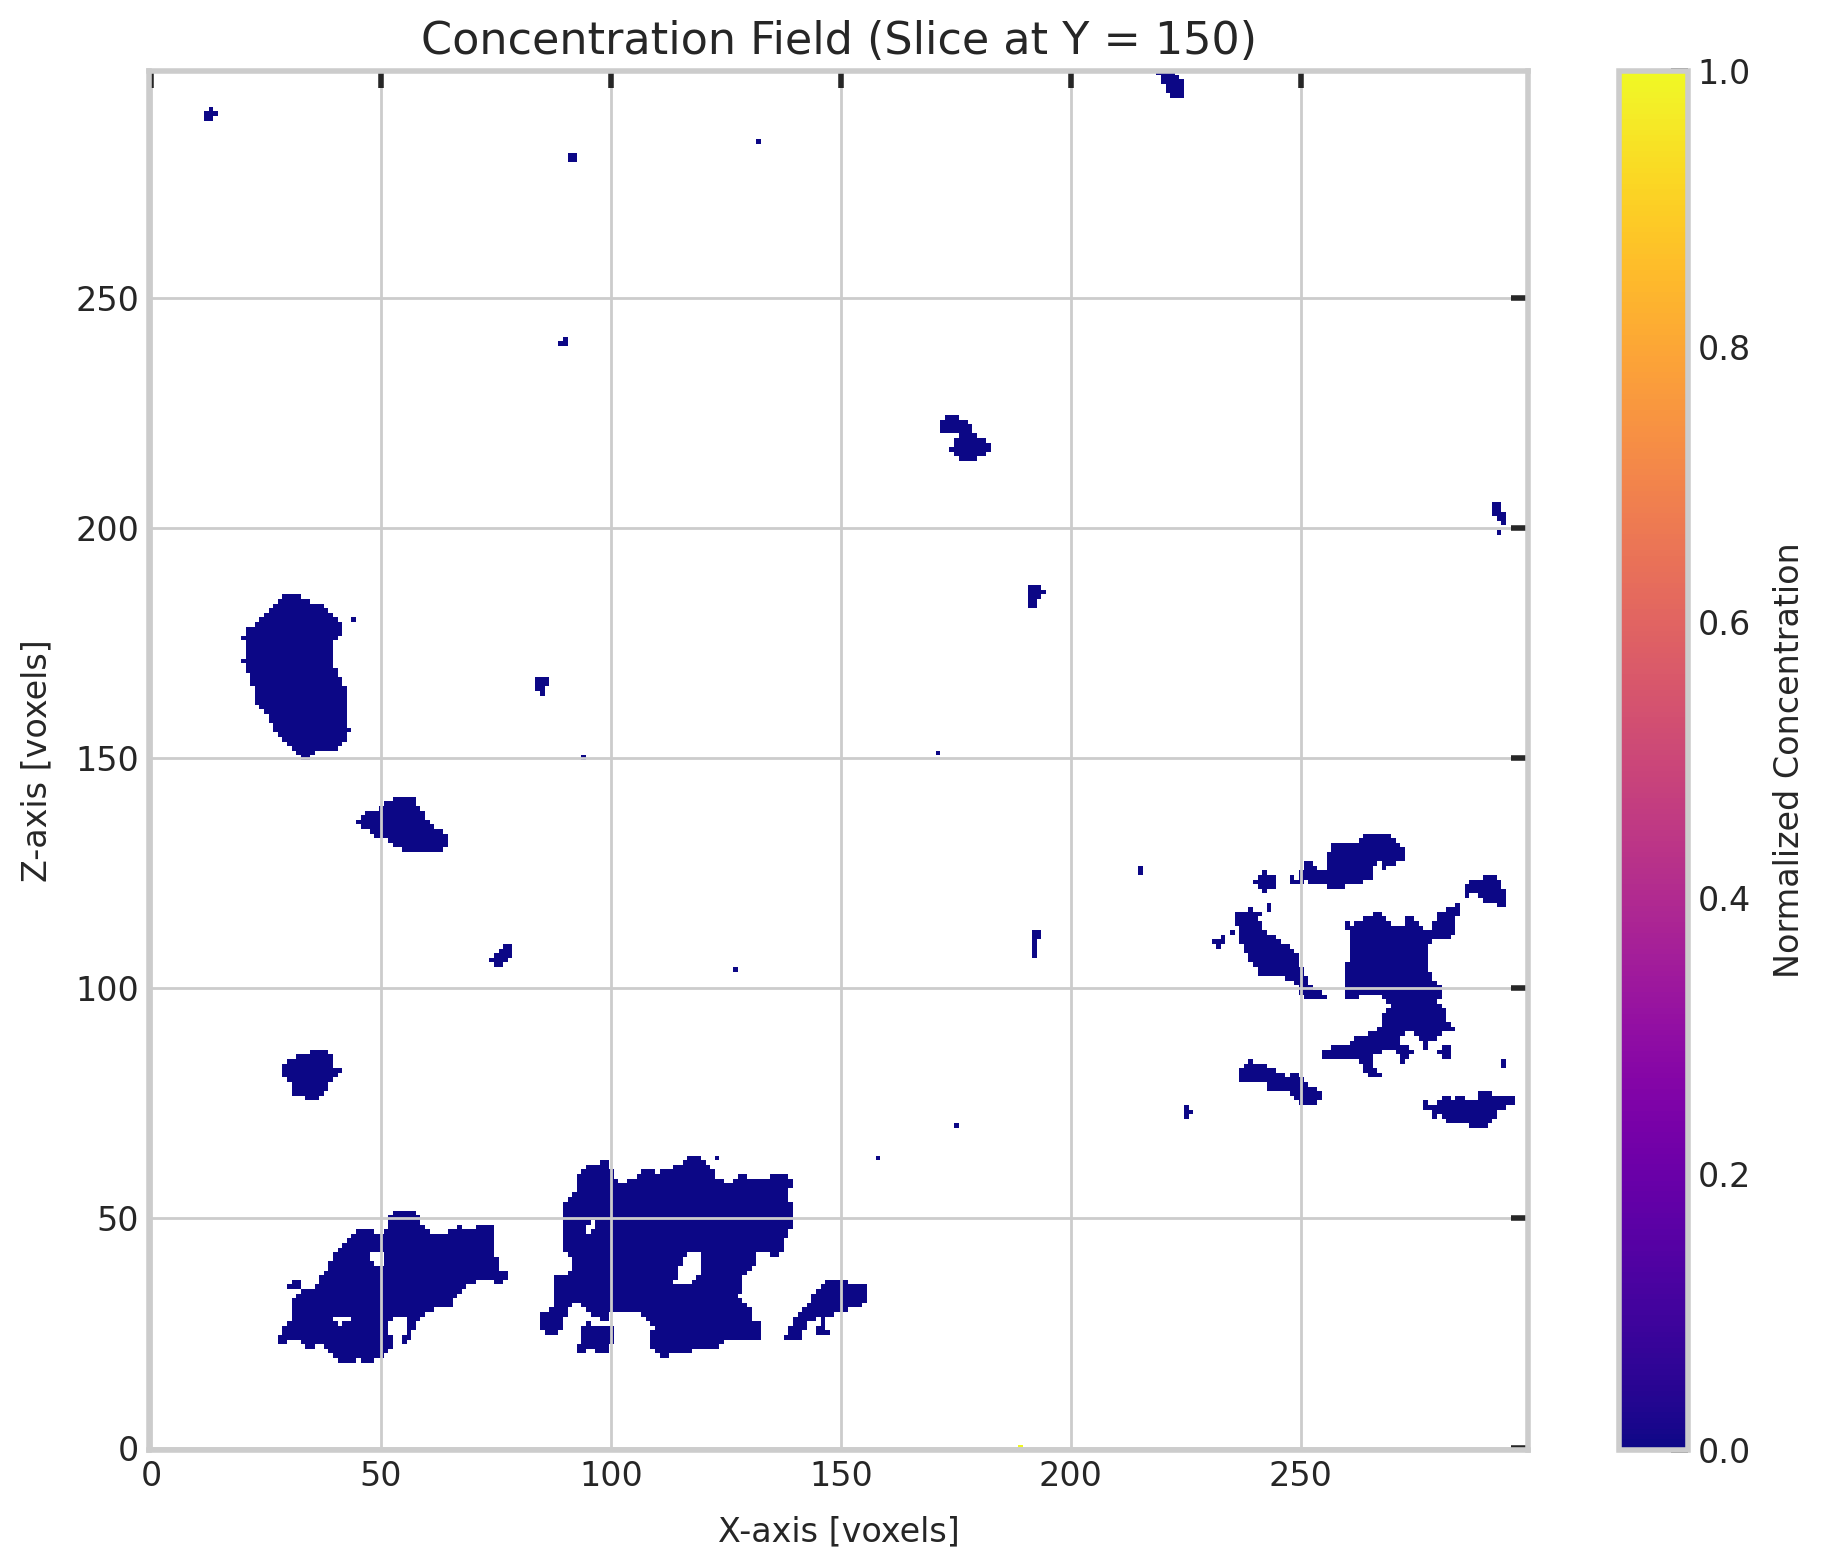


--- ANALYSIS COMPLETE ---


In [14]:
# =============================================================================
#
# SCRIPT FOR TORTUOSITY CALCULATION VIA A CUSTOM FINITE DIFFERENCE SOLVER
#
# METHODOLOGY:
# This script calculates the tortuosity of a 3D porous medium by implementing a
# custom, from-scratch solver for the steady-state diffusion equation, which
# is mathematically described by the Laplace equation (∇²C = 0). This serves as
# a fundamental alternative to pre-packaged library functions.
#
#   1. Solver Implementation: A Numba-accelerated function (`solve_laplace_3d`)
#      implements a finite difference method with a Jacobi iterative scheme to
#      solve for the concentration field (C) within the pore space. Dirichlet
#      boundary conditions (C=1 at inlet, C=0 at outlet) are applied.
#
#   2. Simulation Execution: The solver is run on the full 3D pore space image
#      until the concentration field converges below a specified tolerance.
#
#   3. Post-Processing & Physical Property Calculation:
#      a. The total diffusive flux is calculated from the concentration gradient
#         at the inlet using Fick's First Law.
#      b. The Formation Factor (F), a key dimensionless property, is calculated
#         from the total flux (F = D₀/D_eff).
#      c. The Tortuosity (τ) is then derived from the relationship between
#         Formation Factor and porosity (τ² = F * Φ).
#
#   4. Visualization: A cross-section of the final, converged concentration
#      field is plotted to visualize the diffusion pathways.
#
# OUTPUT:
# - Key physical properties: Porosity (Φ), Formation Factor (F), and Tortuosity (τ).
# - A plot of the simulated concentration field.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install numba -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
import numba
import matplotlib.pyplot as plt
import time

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'binarized_3d_image' variable exists in the
# current runtime environment from the image processing script.

if 'binarized_3d_image' in locals():

    # --- 3.1. Solver Function Definition ---
    @numba.jit(nopython=True)
    def solve_laplace_diffusion(pore_image: np.ndarray, max_iter: int, tolerance: float) -> tuple:
        """
        Solves the 3D Laplace equation using a Jacobi iterative finite difference method.

        Args:
            pore_image (np.ndarray): A boolean 3D array where True represents the pore phase.
            max_iter (int): The maximum number of iterations to perform.
            tolerance (float): The convergence criterion.

        Returns:
            tuple: A tuple containing the final concentration map, the number of
                   iterations performed, and the final difference.
        """
        # Initialize concentration array
        concentration = np.zeros_like(pore_image, dtype=np.float64)

        # Apply Dirichlet boundary condition at the inlet (Z=0)
        for y in range(pore_image.shape[1]):
            for x in range(pore_image.shape[2]):
                if pore_image[0, y, x]:
                    concentration[0, y, x] = 1.0

        final_iter, final_diff = max_iter, 0.0
        for i in range(1, max_iter + 1):
            C_old = concentration.copy()
            # Iterate over interior nodes
            for z in range(1, concentration.shape[0] - 1):
                for y in range(1, concentration.shape[1] - 1):
                    for x in range(1, concentration.shape[2] - 1):
                        if pore_image[z, y, x]:
                            # Standard 7-point stencil for 3D Laplace equation
                            concentration[z, y, x] = (C_old[z-1, y, x] + C_old[z+1, y, x] +
                                                      C_old[z, y-1, x] + C_old[z, y+1, x] +
                                                      C_old[z, y, x-1] + C_old[z, y, x+1]) / 6.0

            # Check for convergence periodically to save computation time
            if i % 50 == 0:
                diff = np.max(np.abs(concentration - C_old))
                if diff < tolerance:
                    final_iter, final_diff = i, diff
                    break

        # A final check for difference if max_iter is reached before a periodic check
        if final_iter == max_iter:
            final_diff = np.max(np.abs(concentration - C_old))

        return concentration, final_iter, final_diff

    # --- 3.2. Configuration and Data Preparation ---
    print(f"Analyzing full image with dimensions: {binarized_3d_image.shape}")
    CONFIG = {
        'max_iterations': 10000,
        'tolerance': 1e-5
    }

    # Invert image for pore space analysis (True = Pore)
    pore_space = ~binarized_3d_image

    # --- 3.3. Simulation Execution ---
    print("\n[1] Initiating custom Finite Difference solver on the full image...")
    print("    -> Note: Progress will be printed periodically by the Numba-jitted function.")

    start_time = time.time()

    # Run the Numba-accelerated solver
    # NOTE: The solver function itself contains print statements for progress.
    # This is unconventional for Numba but is kept here as per the original code's structure.
    concentration_map, iters_done, final_diff = solve_laplace_diffusion(
        pore_space, CONFIG['max_iterations'], CONFIG['tolerance']
    )

    end_time = time.time()

    print(f"\nSimulation completed in {(end_time - start_time)/3600:.2f} hours.")
    if iters_done < CONFIG['max_iterations']:
        print(f"    -> Convergence reached at iteration {iters_done} (Difference: {final_diff:.2e})")
    else:
        print(f"    -> Maximum iterations reached (Difference: {final_diff:.2e})")

    # --- 3.4. Post-Processing and Physical Property Calculation ---
    print("\n[2] Calculating physical properties from simulation results...")

    # Calculate total flux based on Fick's Law at the second slice (z=1)
    # Flux = D₀ * (C(z=0) - C(z=1)) / Δz. Assuming D₀=1, Δz=1, and C(z=0)=1, Flux = 1 - C(z=1).
    total_flux = np.sum(1.0 - concentration_map[1, :, :][pore_space[1, :, :]])

    # Define domain properties
    length = pore_space.shape[0]
    cross_sectional_area = pore_space.shape[1] * pore_space.shape[2]
    porosity = np.mean(pore_space)

    # --- PHYSICS CORRECTION ---
    # Calculate Formation Factor (F = D_bulk / D_effective)
    # For this simulation setup, F = (Area * ΔC_macro) / (Total_Flux * Length)
    # Here, ΔC_macro = 1, D_bulk is assumed 1.
    formation_factor = (cross_sectional_area * 1.0) / (total_flux * length)

    # Calculate Effective Diffusivity (normalized by bulk diffusivity)
    effective_diffusivity = 1 / formation_factor

    # Calculate Tortuosity from the relationship τ² = F * Φ
    tortuosity = np.sqrt(formation_factor * porosity)

    print("\n--- Final Results for Z-Direction ---")
    print(f"  - Porosity (Φ):                    {porosity:.4f}")
    print(f"  - Effective Diffusivity (D_eff/D₀):{effective_diffusivity:.4f}")
    print(f"  - Formation Factor (F):            {formation_factor:.4f}")
    print(f"  - Tortuosity (τ):                  {tortuosity:.4f}")
    print("-" * 40)

    # --- 3.5. Visualization ---
    print("\n[3] Generating concentration map visualization...")

    # Select a central slice perpendicular to the flow (Z) direction
    slice_to_view = concentration_map.shape[1] // 2
    concentration_slice_2d = concentration_map[:, slice_to_view, :]

    # Set solid phase to NaN for clean visualization (so it appears white)
    concentration_slice_2d[binarized_3d_image[:, slice_to_view, :]] = np.nan

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(concentration_slice_2d, cmap='plasma', interpolation='none', origin='lower')
    ax.set_title(f'Concentration Field (Slice at Y = {slice_to_view})', fontsize=16)
    ax.set_xlabel('X-axis [voxels]'); ax.set_ylabel('Z-axis [voxels]')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Normalized Concentration'); plt.show()

    print("\n--- ANALYSIS COMPLETE ---")

else:
    # Error message if the prerequisite variable is not found.
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

In [15]:
# =============================================================================
#
# SCRIPT FOR TOPOLOGICAL ANALYSIS OF A 3D POROUS MEDIUM
#                VIA EULER CHARACTERISTIC
#
# METHODOLOGY:
# This script quantifies the topological connectivity of a 3D pore network by
# calculating its Euler characteristic (χ). This is a fundamental topological
# invariant that provides insight into the structure's complexity.
#
# For a 3D surface mesh, the Euler characteristic is related to the Betti
# numbers (β₀, β₁, β₂) by the Poincaré-Euler formula: χ = β₀ - β₁ + β₂
#   - β₀ (Betti-0): Number of connected components (i.e., separate pore bodies).
#   - β₁ (Betti-1): Number of redundant loops or tunnels (handles).
#   - β₂ (Betti-2): Number of enclosed voids or cavities.
#
# Interpretation in Porous Media:
#   - A large POSITIVE χ suggests a structure dominated by many disconnected
#     pore components (high β₀).
#   - A large NEGATIVE χ suggests a highly connected, sponge-like structure with
#     many redundant pathways and loops (high β₁).
#
# WORKFLOW:
#   1. Input Preparation: A central subvolume is extracted from the full
#      binarized image to ensure computational feasibility.
#   2. Voxel-to-Mesh Conversion: The `skimage.measure.marching_cubes` algorithm
#      is used to generate a triangulated surface mesh of the pore-solid interface.
#   3. Topological Calculation: The `trimesh` library is used to load the mesh
#      and compute its Euler characteristic.
#
# OUTPUT:
# - A summary of the generated mesh properties.
# - The calculated Euler characteristic and its physical interpretation.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install scikit-image trimesh -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
from skimage import measure
import trimesh
import time
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 3.1. Configuration and Input Preparation ---
    CONFIG = {
        # Define the size of the cubic subvolume for analysis.
        # This is the most critical optimization for this memory-intensive task.
        'subvolume_size': 200
    }

    print("[1] Preparing Input Data for Meshing...")
    # Invert the image to analyze the pore space (True = Pore).
    pore_space_full = ~binarized_3d_image

    # Extract a central subvolume to make the computation tractable.
    sz, sy, sx = pore_space_full.shape
    c = CONFIG['subvolume_size']
    subvolume = pore_space_full[
        sz//2 - c//2 : sz//2 + c//2,
        sy//2 - c//2 : sy//2 + c//2,
        sx//2 - c//2 : sx//2 + c//2
    ].copy()
    print(f"    -> Analysis will be performed on a central subvolume of shape: {subvolume.shape}")

    # RAM Optimization: The full-sized image is no longer required.
    del pore_space_full
    gc.collect()

    # --- 3.2. Voxel-to-Mesh Conversion (Marching Cubes) ---
    print("\n[2] Generating 3D surface mesh from voxel data via Marching Cubes...")
    print("    -> This step can be memory intensive.")
    start_time = time.time()

    # The `marching_cubes` algorithm generates a triangular mesh of the
    # isosurface (in this case, the boundary between pore and solid).
    # The `spacing` argument ensures the mesh vertices have correct physical units.
    verts, faces, normals, values = measure.marching_cubes(
        volume=subvolume,
        level=0.5,  # The isovalue to contour (0.5 is standard for boolean images)
        spacing=(voxel_size, voxel_size, voxel_size)
    )
    end_time = time.time()
    print(f"    -> Mesh generation completed in {end_time - start_time:.2f} seconds.")

    # --- 3.3. Mesh Loading and Topological Analysis ---
    print("\n[3] Loading mesh and computing topological properties...")
    start_time = time.time()

    # Create a Trimesh object from the vertices and faces.
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)

    # RAM Optimization: The raw vertex and face arrays are now stored in the
    # Trimesh object, so the original arrays can be released.
    del verts, faces, normals, values
    gc.collect()

    # Calculate the Euler characteristic of the mesh.
    euler_char = mesh.euler_number
    end_time = time.time()
    print(f"    -> Mesh analysis completed in {end_time - start_time:.2f} seconds.")

    # --- 3.4. Summarize and Interpret Results ---
    print("\n--- Topological Analysis Results ---")
    print(f"  - Subvolume Dimensions:     {subvolume.shape}")
    print(f"  - Generated Mesh Vertices:  {len(mesh.vertices):,}")
    print(f"  - Generated Mesh Faces:     {len(mesh.faces):,}")
    print(f"  - Euler Characteristic (χ): {euler_char:,}")

    print("\nInterpretation:")
    if euler_char > 2: # Technically > 2 for a single closed surface
        print("    -> The large POSITIVE value indicates that the pore space consists of many")
        print("       disconnected components (high β₀), characteristic of isolated or vuggy porosity.")
    elif euler_char < 0:
        print("    -> The NEGATIVE value indicates a highly connected, complex network with")
        print("       many redundant pathways or 'tunnels' (high β₁).")
    else:
        print("    -> A value near zero suggests a balance in topological features or a")
        print("       simpler, less complex pore structure.")

    print("\n--- ANALYSIS COMPLETE ---")

else:
    # Error message if the prerequisite variables are not found.
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 20.0 MB/s eta 0:00:00
Dependencies checked/installed.
[1] Preparing Input Data for Meshing...
    -> Analysis will be performed on a central subvolume of shape: (200, 200, 200)

[2] Generating 3D surface mesh from voxel data via Marching Cubes...
    -> This step can be memory intensive.
    -> Mesh generation completed in 0.63 seconds.

[3] Loading mesh and computing topological properties...
    -> Mesh analysis completed in 1.80 seconds.

--- Topological Analysis Results ---
  - Subvolume Dimensions:     (200, 200, 200)
  - Generated Mesh Vertices:  204,905
  - Generated Mesh Faces:     402,176
  - Euler Characteristic (χ): 1,250

Interpretation:
    -> The large POSITIVE value indicates that the pore space consists of many
       disconnected components (high β₀), characteristic of isolated or vuggy porosity.

--- ANALYSIS COMPLETE ---


Dependencies assumed to be installed.
[1] Preparing Input Data...
    -> Analysis will be performed on a central subvolume of shape: (200, 200, 200)

[2] Calculating the Two-Point Correlation Function via FFT...
    -> Calculation completed in 1.39 seconds.

[3] Generating analysis plot...


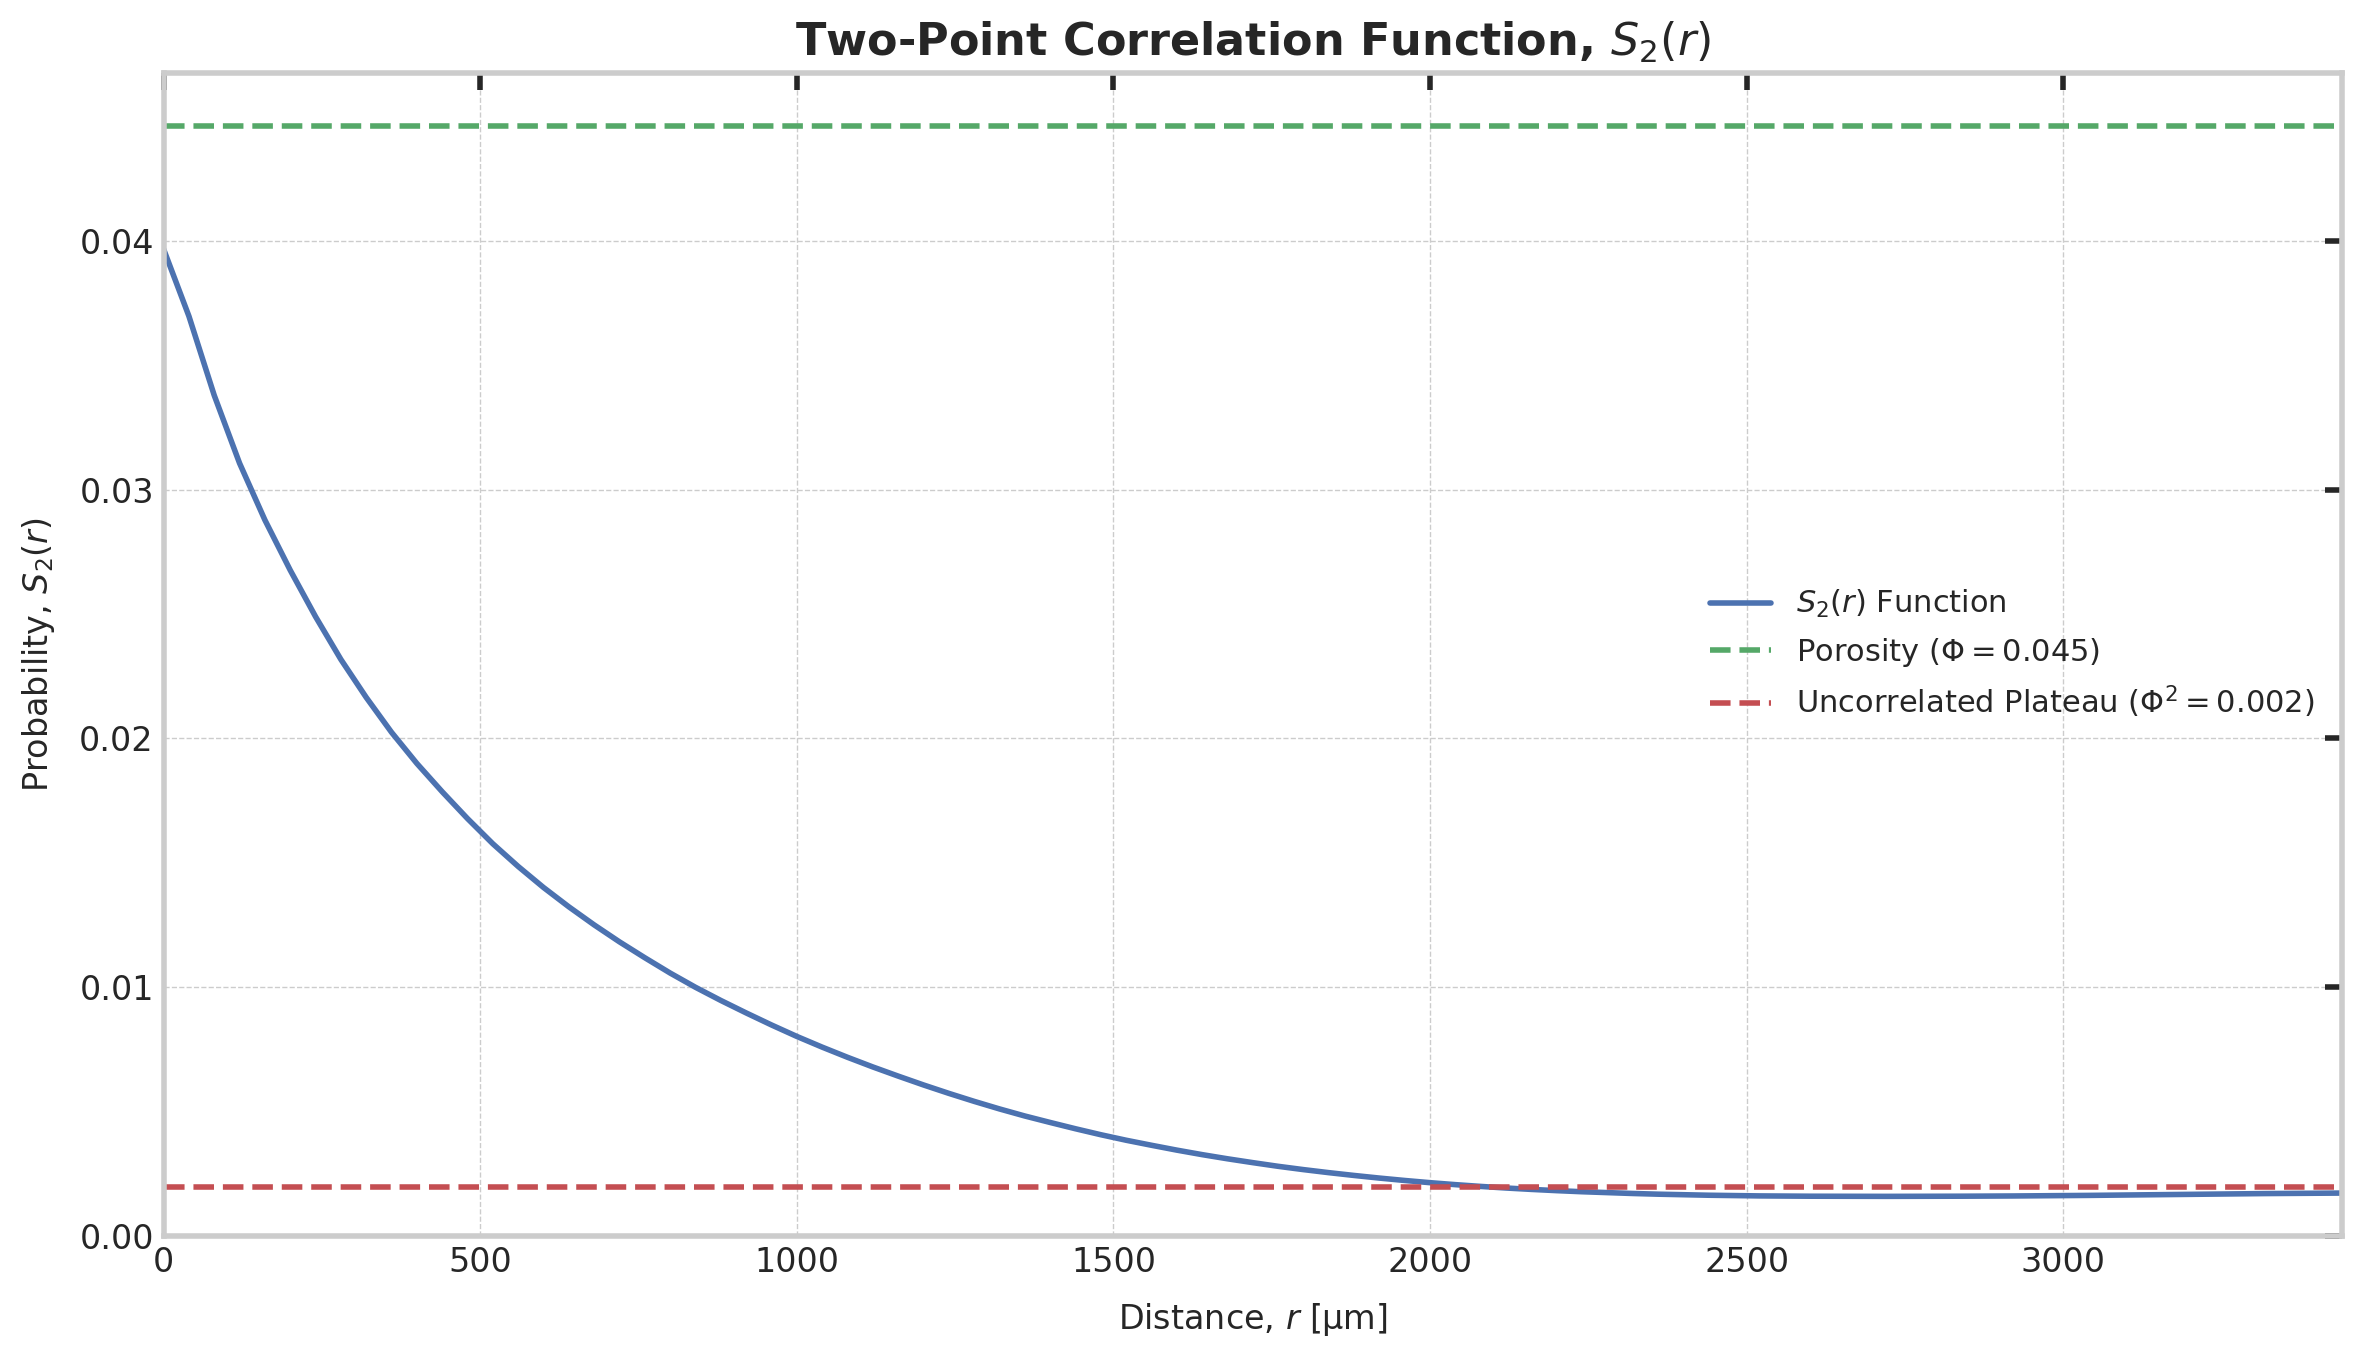


--- ANALYSIS COMPLETE ---


In [16]:
# =============================================================================
#
# SCRIPT FOR TWO-POINT CORRELATION FUNCTION (S2) ANALYSIS
#
# METHODOLOGY:
# This script calculates the two-point correlation function, S₂(r), for the
# pore phase of a 3D binarized image. S₂(r) is a fundamental statistical
# descriptor of a porous medium's microstructure.
#
# Definition:
#   S₂(r) represents the probability that two points, chosen at random and
#   separated by a vector of length r = |r|, will both fall within the pore phase.
#
# Interpretation:
#   - At r=0, S₂(0) is equal to the porosity (Φ).
#   - As r increases, S₂(r) typically decays, providing information about the
#     characteristic size of pores and grains.
#   - At large r, S₂(r) approaches a plateau equal to Φ², indicating that the
#     positions of the two points are statistically uncorrelated.
#
# WORKFLOW:
#   1. Input Preparation: A central subvolume is extracted from the full
#      image to perform a computationally efficient analysis.
#   2. Autocorrelation Calculation: The script computes the 3D autocorrelation
#      of the pore space image using the Wiener-Khinchin theorem (via FFT),
#      which is a highly efficient method.
#   3. Radial Averaging: The 3D autocorrelation map is radially averaged to
#      obtain the 1D function S₂(r).
#   4. Visualization: The resulting S₂(r) function is plotted against distance,
#      along with reference lines for porosity (Φ) and the uncorrelated
#      plateau (Φ²).
#
# OUTPUT:
# - A plot of the two-point correlation function S₂(r) vs. distance r.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
# No new installations are typically required if previous scripts were run.
print("Dependencies assumed to be installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
from scipy import fft
import matplotlib.pyplot as plt
import time
from typing import Tuple

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 3.1. Helper Function Definition ---
    def calculate_two_point_correlation(
        pore_space_image: np.ndarray,
        voxel_size_um: float
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculates the 1D two-point correlation function from a 3D binary image.

        This function combines the FFT-based autocorrelation with radial averaging.

        Args:
            pore_space_image (np.ndarray): A 3D boolean array where True represents
                                           the pore phase.
            voxel_size_um (float): The voxel resolution in microns.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing two arrays:
                                           - distances_um: 1D array of distances (r) in microns.
                                           - correlation_function: 1D array of S₂(r) values.
        """
        # Part A: 3D Autocorrelation via FFT (Wiener-Khinchin Theorem)
        img_float = pore_space_image.astype(float)
        fft_img = fft.fftn(img_float)
        power_spectrum = np.abs(fft_img)**2
        autocorr_map = np.real(fft.ifftn(power_spectrum))
        autocorr_map /= img_float.size
        autocorr_map = fft.fftshift(autocorr_map)

        # Part B: Radial Averaging of the 3D Autocorrelation Map
        center = np.array([(d - 1) / 2 for d in autocorr_map.shape])
        indices = np.indices(autocorr_map.shape)
        distances_vox = np.sqrt(
            (indices[0] - center[0])**2 +
            (indices[1] - center[1])**2 +
            (indices[2] - center[2])**2
        )
        distances_vox_int = distances_vox.astype(int)

        # Use np.bincount for efficient averaging at each integer radius
        sum_at_dist = np.bincount(distances_vox_int.ravel(), weights=autocorr_map.ravel())
        count_at_dist = np.bincount(distances_vox_int.ravel())

        # Avoid division by zero for distances with no samples
        count_at_dist[count_at_dist == 0] = 1

        correlation_function = sum_at_dist / count_at_dist
        radii_vox = np.arange(len(correlation_function))
        distances_um = radii_vox * voxel_size_um

        return distances_um, correlation_function

    # --- 3.2. Configuration and Input Preparation ---
    CONFIG = {
        'subvolume_size': 200
    }

    print("[1] Preparing Input Data...")
    # Invert the image to analyze the pore space (True = Pore).
    pore_space_full = ~binarized_3d_image

    # Extract a central subvolume for a computationally efficient analysis.
    sz, sy, sx = pore_space_full.shape
    c = CONFIG['subvolume_size']
    subvolume = pore_space_full[
        sz//2 - c//2 : sz//2 + c//2,
        sy//2 - c//2 : sy//2 + c//2,
        sx//2 - c//2 : sx//2 + c//2
    ]
    print(f"    -> Analysis will be performed on a central subvolume of shape: {subvolume.shape}")

    # --- 3.3. Execute Correlation Function Calculation ---
    print("\n[2] Calculating the Two-Point Correlation Function via FFT...")
    start_time = time.time()

    distances, s2_function = calculate_two_point_correlation(subvolume, voxel_size)

    end_time = time.time()
    print(f"    -> Calculation completed in {end_time - start_time:.2f} seconds.")

    # --- 3.4. Results Visualization ---
    print("\n[3] Generating analysis plot...")

    porosity = np.mean(subvolume)
    plateau = porosity**2

    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot the calculated S₂(r) function
    ax.plot(distances, s2_function, 'b-', label='$S_2(r)$ Function')

    # Plot reference lines for porosity and the uncorrelated plateau
    ax.axhline(y=porosity, color='g', linestyle='--', label=f'Porosity ($\\Phi = {porosity:.3f}$)')
    ax.axhline(y=plateau, color='r', linestyle='--', label=f'Uncorrelated Plateau ($\\Phi^2 = {plateau:.3f}$)')

    ax.set_title('Two-Point Correlation Function, $S_2(r)$', fontsize=16, fontweight='bold')
    ax.set_xlabel('Distance, $r$ [µm]', fontsize=12)
    ax.set_ylabel('Probability, $S_2(r)$', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set x-limit to half the box size to show the relevant part of the curve
    ax.set_xlim(0, distances[len(distances) // 2])
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

    print("\n--- ANALYSIS COMPLETE ---")

else:
    # Error message if the prerequisite variables are not found.
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

# Propriedades de Transporte

In [17]:
# =============================================================================
#
# SCRIPT FOR ABSOLUTE PERMEABILITY CALCULATION VIA THE LATTICE-BOLTZMANN METHOD
#
# METHODOLOGY:
# This script calculates the absolute permeability of a 3D porous medium by
# implementing a from-scratch Lattice-Boltzmann Method (LBM) solver. LBM is a
# powerful mesoscopic simulation technique for complex fluid dynamics.
#
# The workflow is as follows:
#   1. Pre-processing and Connectivity Check: The input 3D image is prepared
#      by smoothing the pore geometry (morphological opening) and, critically,
#      verifying the existence of a percolating (connected) pathway from the
#      inlet to the outlet. If no such path exists, the sample is identified
#      as impermeable, and the simulation is aborted.
#   2. LBM Solver: A Numba-accelerated D3Q19 LBM solver is employed. This model
#      simulates the evolution of particle distribution functions on a 3D,
#      19-velocity lattice. The BGK (Bhatnagar-Gross-Krook) collision operator
#      is used, and solid boundaries are handled via the bounce-back rule. A
#      body force is applied to drive the flow, simulating a pressure gradient.
#   3. Simulation Execution: The solver iterates until the average velocity of
#      the fluid reaches a steady-state (converged) condition.
#   4. Post-Processing & Permeability Calculation: The absolute permeability (K)
#      is calculated from the converged Darcy velocity using the relationship
#      derived from the Stokes equation, and the result is converted from
#      lattice units to physical units (m² and milliDarcy).
#
# OUTPUT:
# - The calculated absolute permeability in physical units (mD).
# - A report on the connectivity of the pore space.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install numba tqdm -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
import numba
from tqdm.notebook import tqdm  # Use notebook-friendly version of tqdm
from scipy import ndimage
import time

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 3.1. LBM Solver Definition ---
    # D3Q19 model constants
    c = np.array([
        [0,0,0],[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1],
        [1,1,0],[-1,-1,0],[1,-1,0],[-1,1,0],[1,0,1],[-1,0,-1],
        [1,0,-1],[-1,0,1],[0,1,1],[0,-1,-1],[0,1,-1],[0,-1,1]
    ], dtype=np.int32)
    w = np.array([
        1/3, 1/18,1/18,1/18,1/18,1/18,1/18, 1/36,1/36,1/36,1/36,
        1/36,1/36,1/36,1/36,1/36,1/36,1/36,1/36
    ], dtype=np.float64)
    opposite_indices = np.array([0,2,1,4,3,6,5,8,7,10,9,12,11,14,13,16,15,18,17], dtype=np.int32)

    @numba.jit(nopython=True, parallel=True)
    def lbm_stokes_solver(
        solid_mask: np.ndarray,
        relaxation_time: float,
        body_force_g: float,
        max_iters: int,
        convergence_crit: float
    ) -> float:
        """
        Numba-accelerated D3Q19 LBM solver for Stokes flow in a porous medium.
        """
        nz, ny, nx = solid_mask.shape
        f_in = np.zeros((19, nz, ny, nx), dtype=np.float64)
        f_out = np.zeros((19, nz, ny, nx), dtype=np.float64)

        # Initialize distribution functions to equilibrium
        for i in range(19):
            f_in[i] = w[i]
            f_out[i] = w[i]

        pore_mask = ~solid_mask
        avg_u_z_old = 0.0

        for it in range(max_iters):
            # Streaming (Propagation) Step
            for i in range(19):
                for z in numba.prange(nz):
                    for y in range(ny):
                        for x in range(nx):
                            z_prev = (z - c[i, 2])
                            y_prev = (y - c[i, 1])
                            x_prev = (x - c[i, 0])
                            # Periodic boundary conditions on side walls (X and Y)
                            if z_prev >= 0 and z_prev < nz:
                                f_in[i, z, y, x] = f_out[i, z_prev, (y_prev + ny) % ny, (x_prev + nx) % nx]

            # Bounce-back boundary condition on solid nodes
            for z in numba.prange(nz):
                for y in range(ny):
                    for x in range(nx):
                        if solid_mask[z, y, x]:
                            for i in range(19):
                                f_in[i, z, y, x] = f_out[opposite_indices[i], z, y, x]

            # Reset f_out and macroscopic variables for collision step
            f_out[:] = 0.0
            total_u_z, pore_count = 0.0, 0

            # Collision Step
            for z in numba.prange(nz):
                for y in range(ny):
                    for x in range(nx):
                        if pore_mask[z, y, x]:
                            # Calculate macroscopic variables (density, velocity)
                            rho, ux, uy, uz = 0.0, 0.0, 0.0, 0.0
                            for i in range(19):
                                rho += f_in[i, z, y, x]
                                ux += c[i, 0] * f_in[i, z, y, x]
                                uy += c[i, 1] * f_in[i, z, y, x]
                                uz += c[i, 2] * f_in[i, z, y, x]
                            ux /= rho; uy /= rho; uz /= rho

                            # Apply body force
                            uz += 0.5 * body_force_g
                            total_u_z += uz
                            pore_count += 1

                            # Calculate equilibrium distribution function (f_eq)
                            f_eq = np.zeros(19)
                            usq = ux**2 + uy**2 + uz**2
                            for i in range(19):
                                cu = c[i, 0] * ux + c[i, 1] * uy + c[i, 2] * uz
                                f_eq[i] = w[i] * rho * (1 + 3 * cu + 4.5 * cu**2 - 1.5 * usq)

                            # BGK collision
                            for i in range(19):
                                f_out[i, z, y, x] = f_in[i, z, y, x] - (1.0 / relaxation_time) * (f_in[i, z, y, x] - f_eq[i])

            # Check for convergence
            if pore_count > 0:
                avg_u_z = total_u_z / pore_count
                if it % 200 == 0:
                    # Check for numerical instability
                    if not np.isfinite(avg_u_z): return np.nan
                    # Check for convergence
                    if it > 100 and abs(avg_u_z - avg_u_z_old) / (abs(avg_u_z) + 1e-20) < convergence_crit:
                        return avg_u_z
                avg_u_z_old = avg_u_z
            else: # Should not happen if pre-check is done
                return 0.0

        return avg_u_z_old


    # --- 3.2. Configuration and Pre-processing ---
    print(f"\n[1] Preparing Input Data...")
    print(f"    -> Analyzing full image with dimensions: {binarized_3d_image.shape}")
    CONFIG = {
        'lbm_tau': 1.0,            # LBM relaxation time (controls viscosity)
        'lbm_force_g': 1e-7,       # Body force driving the flow
        'max_iterations': 20000,   # Maximum iterations for the solver
        'convergence_crit': 1e-8   # Convergence criterion for steady state
    }

    # Perform morphological opening to remove small, isolated features and smooth geometry
    print("    -> Applying morphological opening to smooth pore geometry...")
    initial_pore_space = ~binarized_3d_image
    structuring_element = ndimage.generate_binary_structure(3, 1) # Simple connectivity
    smoothed_pore_space = ndimage.binary_opening(initial_pore_space, structure=structuring_element)

    # CRITICAL STEP: Check for a percolating path before running the simulation
    print("    -> Checking for a percolating pathway along the Z-axis...")
    labeled_pores, _ = ndimage.label(smoothed_pore_space, structure=structuring_element)
    inlet_labels = np.unique(labeled_pores[0, :, :])
    outlet_labels = np.unique(labeled_pores[-1, :, :])
    percolating_labels = np.intersect1d(inlet_labels, outlet_labels)
    percolating_labels = percolating_labels[percolating_labels > 0] # Exclude background

    if len(percolating_labels) == 0:
        print("\n--- PHYSICAL DIAGNOSIS: NON-PERCOLATING SAMPLE ---")
        print("    No connected pore pathway was found from inlet to outlet.")
        print("    The permeability of the sample is effectively ZERO.")
        print("    Aborting computationally expensive LBM simulation.")
        permeability_mD = 0.0
    else:
        print(f"    -> Found {len(percolating_labels)} percolating cluster(s).")
        # Create a final mask containing only the percolating pore space
        connected_pore_mask = np.isin(labeled_pores, percolating_labels)
        final_solid_mask = ~connected_pore_mask

        # Report porosity values
        print(f"\n       Original Total Porosity: {np.mean(initial_pore_space):.4f}")
        print(f"       Porosity after Opening:  {np.mean(smoothed_pore_space):.4f}")
        print(f"       Final Connected Porosity:{np.mean(connected_pore_mask):.4f}")

        # --- 3.3. LBM Simulation Execution ---
        print("\n[2] Initiating LBM simulation on the connected pore space...")
        print("    -> This process is computationally intensive.")

        start_time = time.time()
        avg_velocity_lattice = lbm_stokes_solver(
            final_solid_mask,
            CONFIG['lbm_tau'],
            CONFIG['lbm_force_g'],
            CONFIG['max_iterations'],
            CONFIG['convergence_crit']
        )
        end_time = time.time()
        print(f"\n    -> Simulation finished in {(end_time - start_time)/3600:.2f} hours.")

        # --- 3.4. Post-Processing and Permeability Calculation ---
        if np.isnan(avg_velocity_lattice):
            print("\n--- SIMULATION FAILED ---")
            print("    The LBM simulation became numerically unstable.")
            permeability_mD = np.nan
        else:
            print("\n[3] Post-processing results...")
            # Convert LBM results to physical permeability
            lattice_speed_of_sound_sq = 1.0 / 3.0
            kinematic_viscosity_lattice = lattice_speed_of_sound_sq * (CONFIG['lbm_tau'] - 0.5)

            # The Darcy velocity is the average velocity minus the force term contribution
            darcy_velocity = avg_velocity_lattice - 0.5 * CONFIG['lbm_force_g']

            # Permeability in lattice units [voxel²]
            permeability_lattice = (darcy_velocity * kinematic_viscosity_lattice) / CONFIG['lbm_force_g']

            # Convert to physical units
            voxel_size_m = voxel_size * 1e-6
            permeability_m2 = permeability_lattice * (voxel_size_m ** 2)
            mD_conversion_factor = 1 / (0.986923e-15)
            permeability_mD = permeability_m2 * mD_conversion_factor

            print("    -> Physical properties calculated successfully.")

    # --- 3.5. Final Results Summary ---
    print("\n\n--- FINAL ABSOLUTE PERMEABILITY RESULT (Z-Direction) ---")
    print(f"  - Permeability in square meters [m²]: {permeability_m2:.3e}" if 'permeability_m2' in locals() else "  - Permeability [m²]: 0.000e+00")
    print(f"  - Permeability in milliDarcy [mD]:  {permeability_mD:.4f}" if 'permeability_mD' in locals() else "  - Permeability [mD]: 0.000")
    print("-" * 55)

else:
    print("CRITICAL ERROR: The variable 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.

[1] Preparing Input Data...
    -> Analyzing full image with dimensions: (300, 300, 300)
    -> Applying morphological opening to smooth pore geometry...
    -> Checking for a percolating pathway along the Z-axis...

--- PHYSICAL DIAGNOSIS: NON-PERCOLATING SAMPLE ---
    No connected pore pathway was found from inlet to outlet.
    The permeability of the sample is effectively ZERO.
    Aborting computationally expensive LBM simulation.


--- FINAL ABSOLUTE PERMEABILITY RESULT (Z-Direction) ---
  - Permeability [m²]: 0.000e+00
  - Permeability in milliDarcy [mD]:  0.0000
-------------------------------------------------------


Dependencies checked/installed.
[1] Preparing Input Data...
    -> Analyzing 3D image with dimensions: (300, 300, 300)
    -> Total Porosity (Φ_total) calculated: 0.0636

[2] Performing Connected-Component Analysis...
    -> Found 2472 distinct pore clusters.

    --- Analyzing percolation for X-axis ---
    RESULT: Sample is NON-PERCOLATING along the X-axis.

    --- Analyzing percolation for Y-axis ---
    RESULT: Sample is NON-PERCOLATING along the Y-axis.

    --- Analyzing percolation for Z-axis ---
    RESULT: Sample is NON-PERCOLATING along the Z-axis.

[3] Generating Final Summary and Visualization...

    --- Non-Percolating Sample Diagnosis ---
    Total number of disconnected pore clusters: 2472
    The largest cluster contains 298,455 voxels.
    This represents 17.37% of the total pore volume.


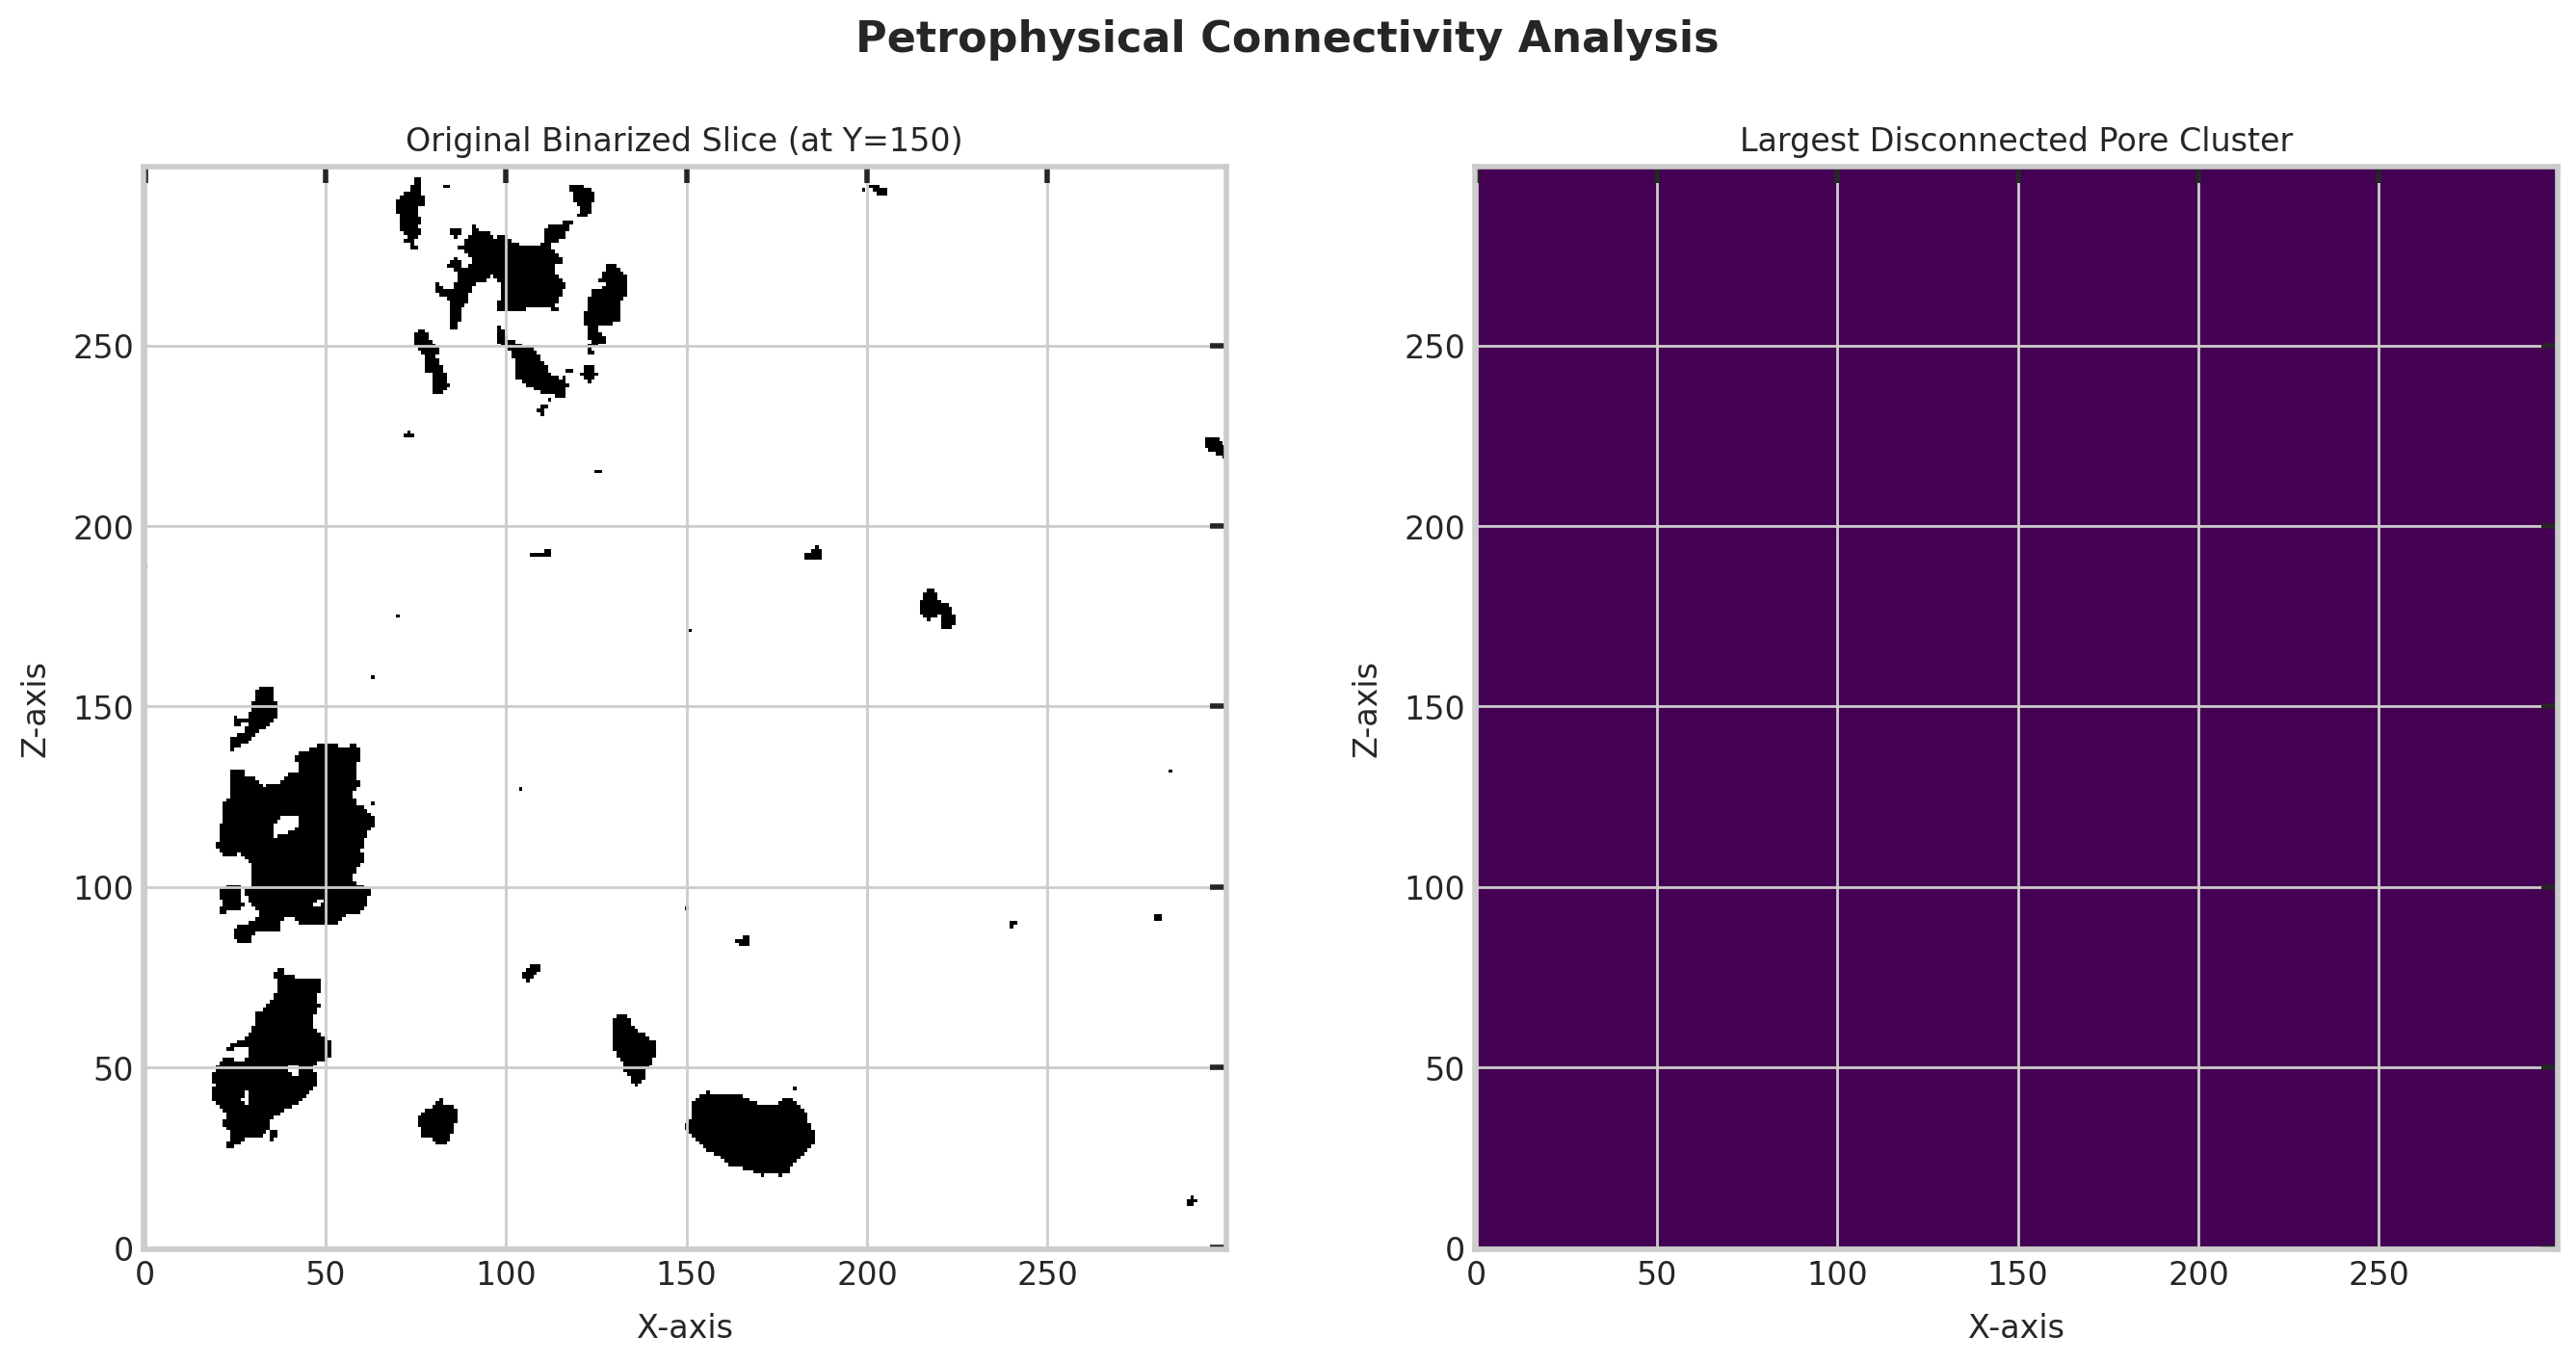


--- ANALYSIS COMPLETE ---


In [18]:
# =============================================================================
#
# SCRIPT FOR PRIMARY PETROPHYSICAL CHARACTERIZATION
#         (PERCOLATION AND TORTUOSITY ANALYSIS)
#
# METHODOLOGY:
# This script performs a primary characterization of a 3D porous medium to
# determine its connectivity and transport properties. It follows a robust,
# two-stage workflow:
#
#   1. Percolation Analysis: The script first uses a fast connected-component
#      labeling algorithm to determine if a continuous pore pathway (a
#      "percolating cluster") exists from inlet to outlet along each principal
#      axis. This is a critical diagnostic step.
#
#   2. Conditional Property Calculation:
#      a. IF PERCOLATING: For each percolating direction, a steady-state
#         diffusion simulation is performed on the isolated percolating cluster
#         to calculate Tortuosity (τ), Formation Factor (F), and Archie's
#         Cementation Exponent (m).
#      b. IF NON-PERCOLATING: If no percolating pathway is found, the script
#         switches to a cluster analysis, quantifying the size distribution of
#         the disconnected pore bodies and identifying the largest cluster.
#
#   3. Visualization: A summary plot is generated, displaying either the
#      concentration field of a successful simulation or an image of the
#      largest isolated pore cluster if the sample is non-percolating.
#
# OUTPUT:
# - A quantitative summary of the sample's percolation status and transport
#   properties (if percolating) or cluster statistics (if non-percolating).
# - A summary visualization.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install porespy openpnm -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import time
import gc

# ===== 3. ANALYSIS WORKFLOW =====
# This workflow assumes that the 'binarized_3d_image' variable exists
# in the current runtime environment.

if 'binarized_3d_image' in locals():

    # --- 3.1. Input Data Preparation ---
    print("[1] Preparing Input Data...")
    pore_space = ~binarized_3d_image
    print(f"    -> Analyzing 3D image with dimensions: {pore_space.shape}")
    total_porosity = np.mean(pore_space)
    print(f"    -> Total Porosity (Φ_total) calculated: {total_porosity:.4f}")

    # --- 3.2. Percolation and Cluster Analysis ---
    print("\n[2] Performing Connected-Component Analysis...")
    # Label all distinct pore clusters in the image.
    # The structuring element defines connectivity (face, edge, or corner).
    structuring_element = np.ones((3, 3, 3), dtype=bool)
    labeled_image, num_clusters = label(pore_space, structure=structuring_element)

    if num_clusters == 0:
        print("    -> No pore phase found in the image. Analysis cannot proceed.")
    else:
        print(f"    -> Found {num_clusters} distinct pore clusters.")

        # --- 3.3. Anisotropic Tortuosity Simulation (Conditional) ---
        tortuosity_results = {}
        percolation_found = False

        for axis_index, axis_name in enumerate(['X', 'Y', 'Z']):
            print(f"\n    --- Analyzing percolation for {axis_name}-axis ---")

            # Identify which cluster labels touch the inlet and outlet faces
            if axis_index == 0: # X-axis
                inlet_labels = np.unique(labeled_image[:, :, 0])
                outlet_labels = np.unique(labeled_image[:, :, -1])
            elif axis_index == 1: # Y-axis
                inlet_labels = np.unique(labeled_image[:, 0, :])
                outlet_labels = np.unique(labeled_image[:, -1, :])
            else: # Z-axis
                inlet_labels = np.unique(labeled_image[0, :, :])
                outlet_labels = np.unique(labeled_image[-1, :, :])

            # Find the labels that are present on BOTH inlet and outlet
            percolating_labels = np.intersect1d(inlet_labels, outlet_labels)
            percolating_labels = percolating_labels[percolating_labels > 0] # Exclude background label 0

            if len(percolating_labels) > 0:
                print(f"    RESULT: Sample PERCOLATES along the {axis_name}-axis.")
                percolation_found = True

                # Isolate the percolating pore space for efficient simulation
                percolating_pores = np.isin(labeled_image, percolating_labels)

                start_time = time.time()
                sim_result = ps.simulations.tortuosity_fd(im=percolating_pores, axis=axis_index)
                end_time = time.time()

                # --- Physics Correction ---
                # F = τ²/Φ_eff  and  m = -log(F)/log(Φ_eff)
                tortuosity = sim_result.tortuosity
                effective_porosity = sim_result.effective_porosity
                formation_factor = (tortuosity**2) / effective_porosity if effective_porosity > 0 else np.inf
                cementation_exp = -np.log(formation_factor) / np.log(effective_porosity) if effective_porosity > 0 and formation_factor > 0 else np.nan

                print(f"       - Simulation Time: {end_time - start_time:.2f} seconds.")
                print(f"       - Effective Porosity (Φ_eff): {effective_porosity:.4f}")
                print(f"       - Tortuosity (τ): {tortuosity:.4f}")
                print(f"       - Formation Factor (F): {formation_factor:.4f}")
                print(f"       - Cementation Exponent (m): {cementation_exp:.4f}")
                tortuosity_results[axis_name] = sim_result
            else:
                print(f"    RESULT: Sample is NON-PERCOLATING along the {axis_name}-axis.")
                tortuosity_results[axis_name] = None

        # --- 3.4. Final Diagnosis and Visualization ---
        print("\n[3] Generating Final Summary and Visualization...")

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        slice_axis = 1 # Choose a consistent axis for slicing (e.g., Y)
        slice_index = pore_space.shape[slice_axis] // 2

        # Plot the original binary slice
        binary_slice = np.take(pore_space, slice_index, axis=slice_axis)
        axes[0].imshow(binary_slice.T, cmap='gray_r', origin='lower')
        axes[0].set_title(f'Original Binarized Slice (at Y={slice_index})')
        axes[0].set_xlabel('X-axis'); axes[0].set_ylabel('Z-axis')

        if percolation_found:
            # Find the first valid result to visualize its concentration field
            first_valid_result = next(res for res in tortuosity_results.values() if res is not None)
            potential_field = first_valid_result.concentration

            potential_slice = np.take(potential_field, slice_index, axis=slice_axis)
            masked_potential = np.ma.masked_where(~binary_slice, potential_slice) # Hide solid phase

            im = axes[1].imshow(masked_potential.T, cmap='viridis', origin='lower')
            axes[1].set_title('Simulated Potential Field')
            fig.colorbar(im, ax=axes[1], label='Normalized Potential')
            axes[1].set_xlabel('X-axis'); axes[1].set_ylabel('Z-axis')
        else:
            print("\n    --- Non-Percolating Sample Diagnosis ---")
            cluster_sizes = np.bincount(labeled_image.ravel())[1:] # Exclude background
            largest_cluster_size = np.max(cluster_sizes)
            largest_cluster_label = np.argmax(cluster_sizes) + 1
            total_pore_voxels = np.sum(pore_space)
            largest_cluster_fraction = (largest_cluster_size / total_pore_voxels) * 100

            print(f"    Total number of disconnected pore clusters: {num_clusters}")
            print(f"    The largest cluster contains {largest_cluster_size:,} voxels.")
            print(f"    This represents {largest_cluster_fraction:.2f}% of the total pore volume.")

            # Visualize the largest cluster
            largest_cluster_image = (labeled_image == largest_cluster_label)
            largest_cluster_slice = np.take(largest_cluster_image, slice_index, axis=slice_axis)
            axes[1].imshow(largest_cluster_slice.T, cmap='viridis', origin='lower')
            axes[1].set_title('Largest Disconnected Pore Cluster')
            axes[1].set_xlabel('X-axis'); axes[1].set_ylabel('Z-axis')

        fig.suptitle('Petrophysical Connectivity Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # RAM Optimization
        del labeled_image, tortuosity_results
        gc.collect()

    print("\n--- ANALYSIS COMPLETE ---")

else:
    print("CRITICAL ERROR: The variable 'binarized_3d_image' was not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")

Dependencies checked/installed.
Sample porosity calculated: 0.0636

Initiating simulation on the full image...

Initiating effective thermal conductivity calculation for axis 0...
 -> Mapping material properties onto the domain...
 -> Starting solver (Numba JIT) with omega=1.85...
    Sample dimensions: (300, 300, 300)
    Calculation is in progress. Please await the completion message...

 -> Convergence achieved in 2811 iterations (Final Error: 9.9944e-06)
 -> Post-processing: Calculating total flux and effective property...
 -> Calculation completed in 26.69 minutes.

--- Final Results ---
   Domain Dimensions: (300, 300, 300), Voxel Size: 40.0 µm
   k_solid: 3.00 W/(m·K), k_fluid: 0.60 W/(m·K)
   Effective Thermal Conductivity (k_eff) along Z-axis: 0.8999 W/(m·K)


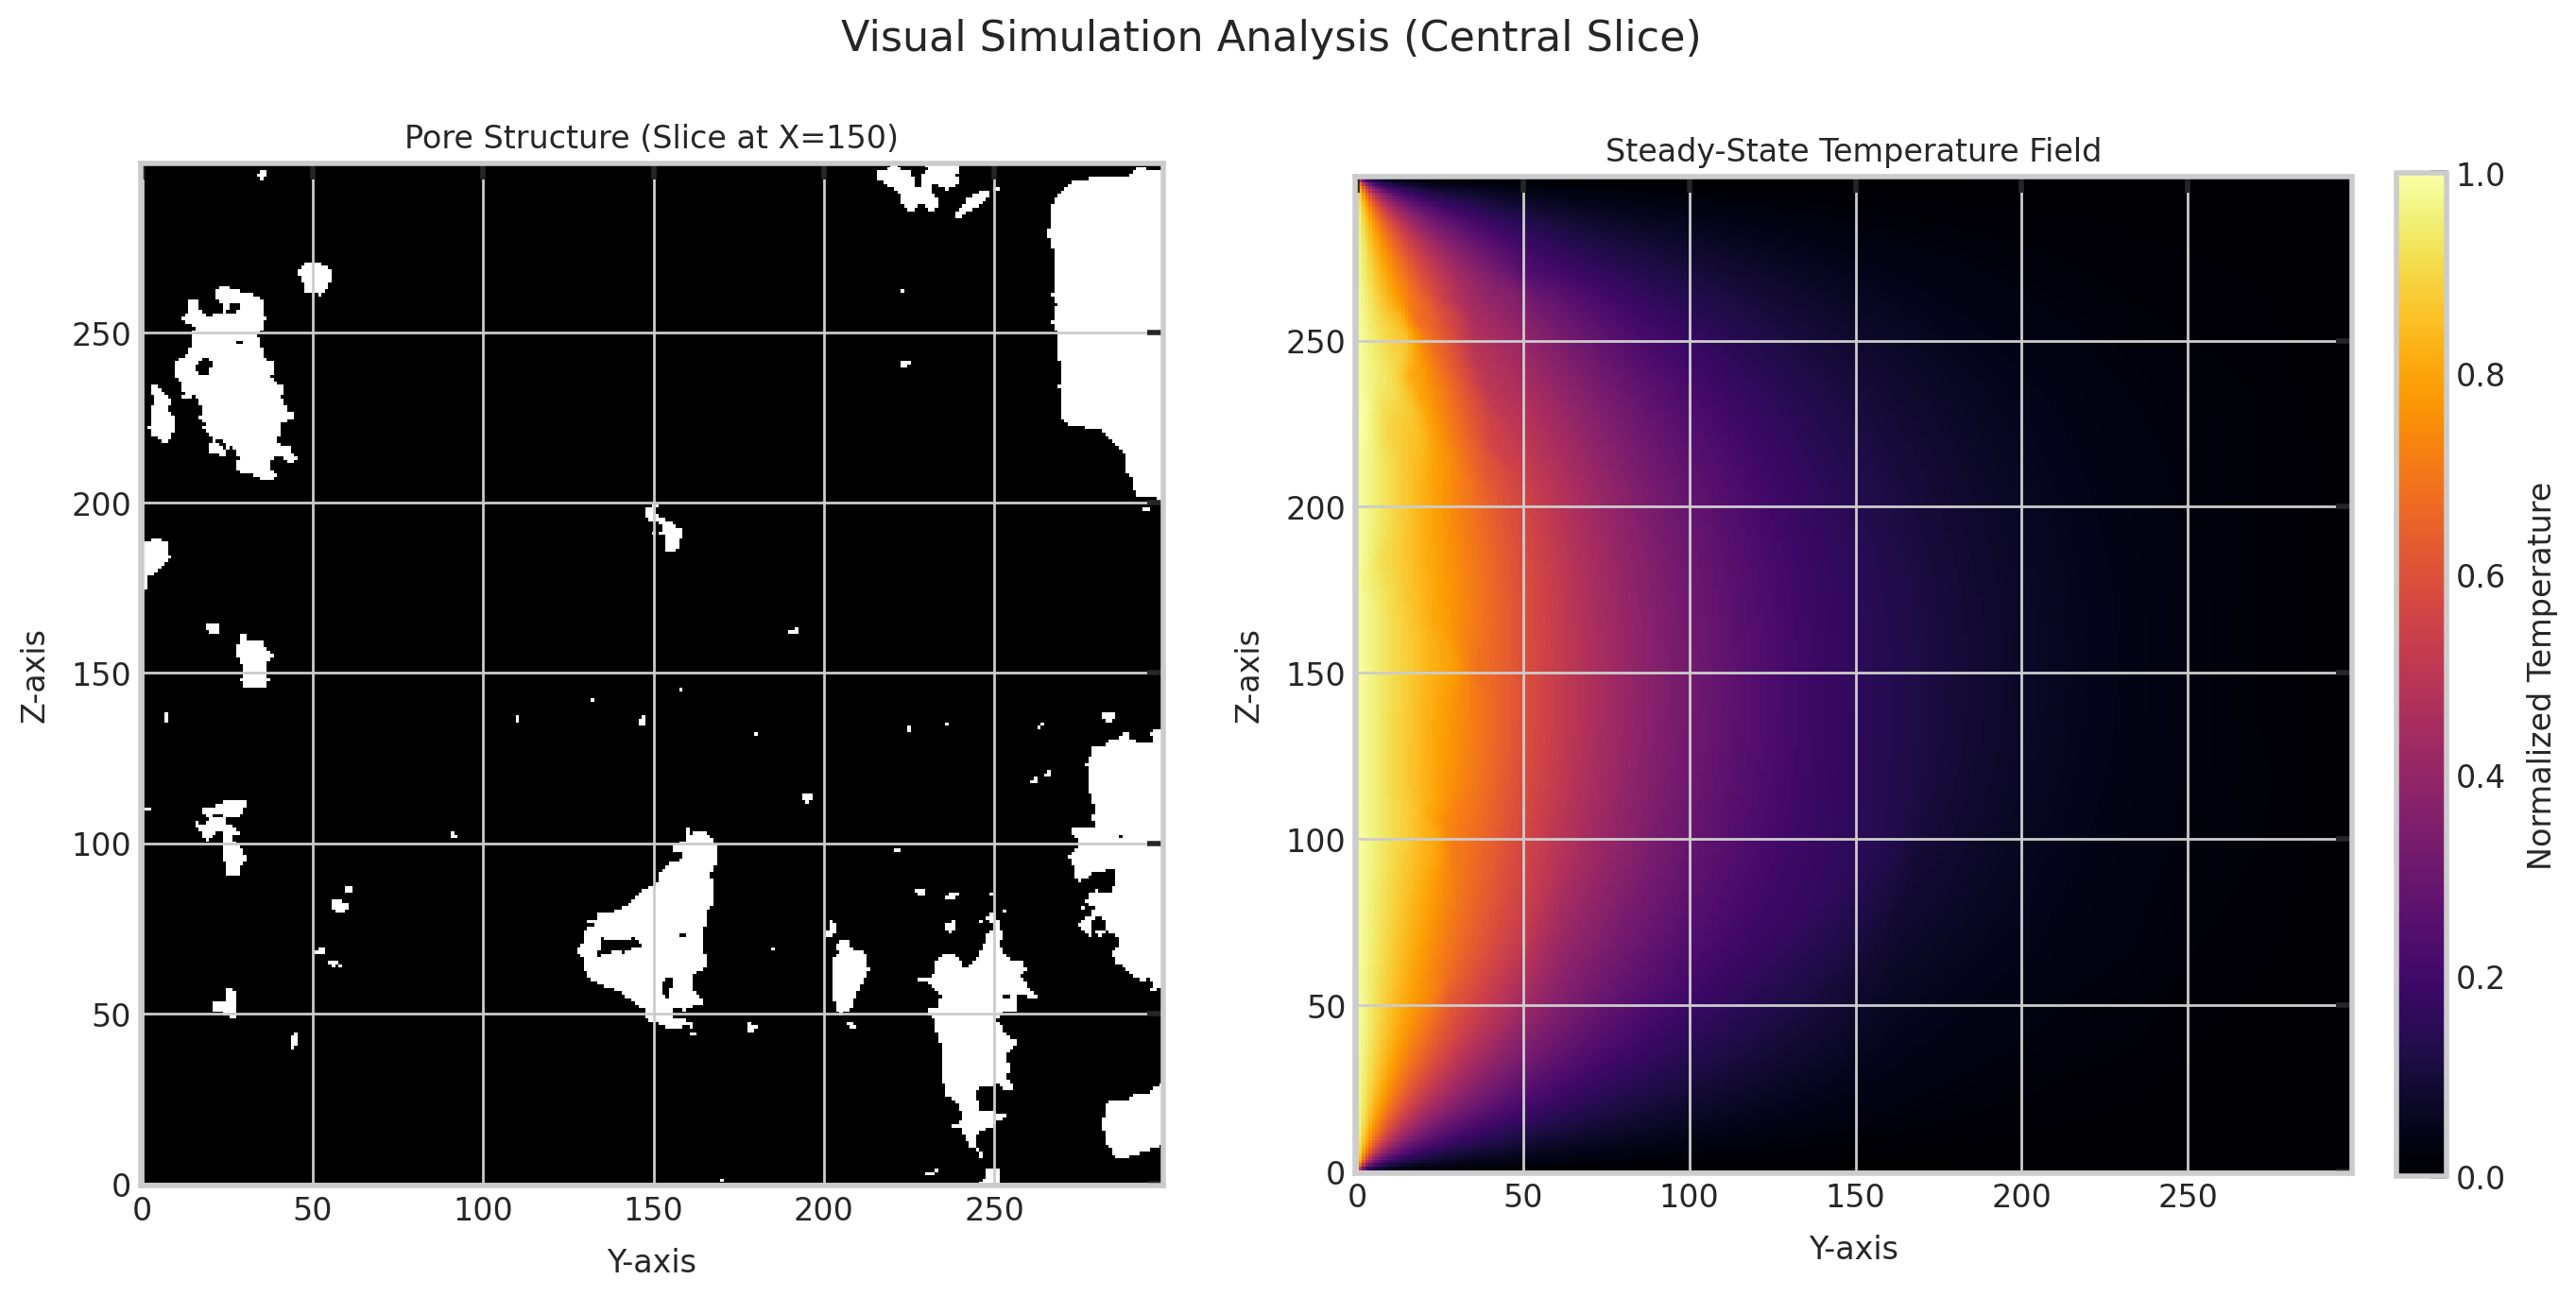

In [19]:
# =============================================================================
#
# SCRIPT FOR EFFECTIVE THERMAL CONDUCTIVITY CALCULATION
#         VIA A CUSTOM FINITE DIFFERENCE SOLVER
#
# METHODOLOGY:
# This script calculates the effective thermal conductivity (k_eff) of a 3D
# porous medium by numerically solving the steady-state heat conduction equation:
#
#                       ∇ ⋅ (k ∇T) = 0
#
# where k is the spatially varying thermal conductivity and T is the temperature.
#
# WORKFLOW:
#   1. System Setup: A 3D domain is created from the binarized image, where each
#      voxel is assigned the thermal conductivity of either the solid or fluid phase.
#      Dirichlet boundary conditions (fixed temperatures) are applied to two
#      opposing faces to induce a thermal gradient.
#
#   2. Numerical Solution: The governing partial differential equation is discretized
#      using the Finite Difference Method. The resulting system of linear equations
#      is solved iteratively using a Numba-accelerated Successive Over-Relaxation
#      (SOR) style solver until the temperature field (T) converges.
#
#   3. Post-Processing: Once the steady-state temperature field is known, the total
#      heat flux (Q) across a cross-section is calculated using a discrete form of
#      Fourier's Law.
#
#   4. Effective Property Calculation: The macroscopic form of Fourier's Law is
#      then used to calculate the effective thermal conductivity (k_eff) of the
#      entire medium from the total flux and the applied macroscopic gradient.
#
# OUTPUT:
# - The calculated effective thermal conductivity (k_eff) in the specified direction.
# - A visualization of the final temperature field on a central slice.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. DEPENDENCY INSTALLATION =====
!pip install numba -q
print("Dependencies checked/installed.")

# ===== 2. LIBRARY IMPORTS =====
import numpy as np
import numba
import matplotlib.pyplot as plt
import time
from typing import Tuple

# ===== 3. CORE FUNCTION DEFINITIONS =====

@numba.jit(nopython=True)
def _run_solver_numba(
    T: np.ndarray,
    k_map: np.ndarray,
    shape: Tuple[int, int, int],
    omega: float,
    max_iter: int,
    tolerance: float
) -> Tuple[np.ndarray, int, float]:
    """
    Executes the core iterative SOR solver for the Laplace equation.
    This function is JIT-compiled by Numba for maximum performance.

    Args:
        T (np.ndarray): The 3D temperature array (will be modified in-place).
        k_map (np.ndarray): The 3D thermal conductivity map.
        shape (Tuple[int, int, int]): The dimensions of the domain.
        omega (float): The Successive Over-Relaxation factor.
        max_iter (int): The maximum number of iterations.
        tolerance (float): The convergence criterion.

    Returns:
        Tuple[np.ndarray, int, float]: A tuple containing the final temperature
                                         field, the number of iterations performed,
                                         and the final error.
    """
    for it in range(max_iter):
        max_change = 0.0

        # Iterate over all interior nodes of the domain
        for k in range(1, shape[0] - 1):
            for j in range(1, shape[1] - 1):
                for i in range(1, shape[2] - 1):
                    T_before_update = T[k, j, i]

                    # Use harmonic mean for conductivity at cell interfaces for accuracy
                    k_w = 2 * k_map[k,j,i] * k_map[k,j,i-1] / (k_map[k,j,i] + k_map[k,j,i-1])
                    k_e = 2 * k_map[k,j,i] * k_map[k,j,i+1] / (k_map[k,j,i] + k_map[k,j,i+1])
                    k_s = 2 * k_map[k,j,i] * k_map[k,j-1,i] / (k_map[k,j,i] + k_map[k,j-1,i])
                    k_n = 2 * k_map[k,j,i] * k_map[k,j+1,i] / (k_map[k,j,i] + k_map[k,j+1,i])
                    k_b = 2 * k_map[k,j,i] * k_map[k-1,j,i] / (k_map[k,j,i] + k_map[k-1,j,i])
                    k_t = 2 * k_map[k,j,i] * k_map[k+1,j,i] / (k_map[k,j,i] + k_map[k+1,j,i])

                    numerator = (k_e*T[k,j,i+1] + k_w*T[k,j,i-1] +
                                 k_n*T[k,j+1,i] + k_s*T[k,j-1,i] +
                                 k_t*T[k+1,j,i] + k_b*T[k-1,j,i])

                    denominator = k_e + k_w + k_n + k_s + k_t + k_b

                    # Standard Gauss-Seidel update
                    T_gs = numerator / denominator

                    # Apply SOR relaxation
                    T_new = (1 - omega) * T_before_update + omega * T_gs
                    T[k, j, i] = T_new

                    change = abs(T_new - T_before_update)
                    if change > max_change:
                        max_change = change

        # Check for convergence
        if max_change < tolerance:
            return T, it + 1, max_change

    return T, max_iter, max_change

def calculate_effective_thermal_conductivity(
    pore_matrix: np.ndarray,
    k_solid: float,
    k_fluid: float,
    axis: int = 0,
    tolerance: float = 1e-6,
    max_iter: int = 5000,
    omega: float = 1.85
) -> Tuple[float, np.ndarray]:
    """
    Orchestrates the calculation of effective thermal conductivity.
    """
    if pore_matrix.ndim != 3:
        print("ERROR: Input matrix must be 3D.")
        return None, None

    print(f"\nInitiating effective thermal conductivity calculation for axis {axis}...")
    start_time = time.time()
    shape = pore_matrix.shape

    # 1. Create the thermal conductivity map
    print(" -> Mapping material properties onto the domain...")
    k_map = np.full(shape, k_solid, dtype=np.float64)
    k_map[pore_matrix] = k_fluid

    # 2. Initialize temperature field and apply boundary conditions
    T = np.zeros(shape, dtype=np.float64)
    T_hot, T_cold = 1.0, 0.0

    if axis == 0: T[0, :, :] = T_hot; T[-1, :, :] = T_cold
    elif axis == 1: T[:, 0, :] = T_hot; T[:, -1, :] = T_cold
    else: T[:, :, 0] = T_hot; T[:, :, -1] = T_cold

    # 3. Run the numerical solver
    print(f" -> Starting solver (Numba JIT) with omega={omega}...")
    print(f"    Sample dimensions: {shape}")
    print("    Calculation is in progress. Please await the completion message...")

    T_final, final_iter, final_error = _run_solver_numba(T, k_map, shape, omega, max_iter, tolerance)

    # Apply Neumann (no-flux) boundary conditions to the side walls
    if axis == 0:
        T_final[:, :, 0], T_final[:, :, -1] = T_final[:, :, 1], T_final[:, :, -2]
        T_final[:, 0, :], T_final[:, -1, :] = T_final[:, 1, :], T_final[:, -2, :]
    elif axis == 1:
        T_final[0, :, :], T_final[-1, :, :] = T_final[1, :, :], T_final[-2, :, :]
        T_final[:, :, 0], T_final[:, :, -1] = T_final[:, :, 1], T_final[:, :, -2]
    else:
        T_final[0, :, :], T_final[-1, :, :] = T_final[1, :, :], T_final[-2, :, :]
        T_final[:, 0, :], T_final[:, -1, :] = T_final[:, 1, :], T_final[:, -2, :]

    if final_error < tolerance:
        print(f"\n -> Convergence achieved in {final_iter} iterations (Final Error: {final_error:.4e})")
    else:
        print(f"\n -> WARNING: Maximum iterations ({max_iter}) reached (Final Error: {final_error:.4e})")

    # 4. Post-process to calculate effective conductivity
    print(" -> Post-processing: Calculating total flux and effective property...")

    # Use central differences on a mid-plane to calculate total flux
    if axis == 0:
        cross_sectional_area = shape[1] * shape[2]
        mid_plane = shape[0] // 2
        temp_gradient = T_final[mid_plane - 1, :, :] - T_final[mid_plane + 1, :, :]
        local_k = (k_map[mid_plane - 1, :, :] + k_map[mid_plane + 1, :, :]) / 2.0
    elif axis == 1:
        cross_sectional_area = shape[0] * shape[2]
        mid_plane = shape[1] // 2
        temp_gradient = T_final[:, mid_plane - 1, :] - T_final[:, mid_plane + 1, :]
        local_k = (k_map[:, mid_plane - 1, :] + k_map[:, mid_plane + 1, :]) / 2.0
    else:
        cross_sectional_area = shape[0] * shape[1]
        mid_plane = shape[2] // 2
        temp_gradient = T_final[:, :, mid_plane - 1] - T_final[:, :, mid_plane + 1]
        local_k = (k_map[:, :, mid_plane - 1] + k_map[:, :, mid_plane + 1]) / 2.0

    # Total flux Q = Σ(-k * ∇T), where ∇T is approximated over 2 voxels
    total_flux = np.sum(local_k * temp_gradient / 2.0)

    # Apply macroscopic Fourier's Law: k_eff = (Q / A) * (L / ΔT)
    length = shape[axis]
    delta_T = T_hot - T_cold
    k_effective = (total_flux / cross_sectional_area) * (length / delta_T)

    end_time = time.time()
    print(f" -> Calculation completed in {(end_time - start_time)/60:.2f} minutes.")

    return k_effective, T_final

# ===== 4. MAIN EXECUTION BLOCK =====
if __name__ == "__main__":
    if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

        # --- Configuration ---
        CONFIG = {
            'SOLID_CONDUCTIVITY': 3.0,   # [W/(m·K)]
            'FLUID_CONDUCTIVITY': 0.6,   # [W/(m·K)]
            'FLOW_AXIS': 0,              # 0 for Z, 1 for Y, 2 for X
            'MAX_ITERATIONS': 10000,
            'TOLERANCE': 1e-5,
            'OMEGA': 1.85                # SOR factor
        }

        # --- Data Preparation ---
        # The solver expects True for the pore/fluid phase.
        pore_space = ~binarized_3d_image
        porosity = np.mean(pore_space)
        print(f"Sample porosity calculated: {porosity:.4f}")

        # --- Simulation Execution ---
        print("\nInitiating simulation on the full image...")
        k_effective, temperature_field = calculate_effective_thermal_conductivity(
            pore_matrix=pore_space,
            k_solid=CONFIG['SOLID_CONDUCTIVITY'],
            k_fluid=CONFIG['FLUID_CONDUCTIVITY'],
            axis=CONFIG['FLOW_AXIS'],
            tolerance=CONFIG['TOLERANCE'],
            max_iter=CONFIG['MAX_ITERATIONS'],
            omega=CONFIG['OMEGA']
        )

        # --- Results Summary & Visualization ---
        if k_effective is not None:
            print("\n--- Final Results ---")
            print(f"   Domain Dimensions: {pore_space.shape}, Voxel Size: {voxel_size} µm")
            print(f"   k_solid: {CONFIG['SOLID_CONDUCTIVITY']:.2f} W/(m·K), k_fluid: {CONFIG['FLUID_CONDUCTIVITY']:.2f} W/(m·K)")

            axis_name = ('Z', 'Y', 'X')[CONFIG['FLOW_AXIS']]
            print(f"   Effective Thermal Conductivity (k_eff) along {axis_name}-axis: {k_effective:.4f} W/(m·K)")

            slice_index = temperature_field.shape[2] // 2
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))
            fig.suptitle('Visual Simulation Analysis (Central Slice)', fontsize=16)

            axes[0].imshow(pore_space[:, :, slice_index].T, cmap='binary_r', origin='lower')
            axes[0].set_title(f'Pore Structure (Slice at X={slice_index})')
            axes[0].set_xlabel('Y-axis'); axes[0].set_ylabel('Z-axis')

            im = axes[1].imshow(temperature_field[:, :, slice_index].T, cmap='inferno', origin='lower')
            axes[1].set_title(f'Steady-State Temperature Field')
            axes[1].set_xlabel('Y-axis'); axes[1].set_ylabel('Z-axis')
            fig.colorbar(im, ax=axes[1], label='Normalized Temperature', fraction=0.046, pad=0.04)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
    else:
        print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
        print("Please ensure the image processing script has been executed successfully prior to running this cell.")

# Propriedades de Fluxo Multifásico


[A] Preparing Data...
    -> Extracting a central subvolume of size 150^3 for analysis.
    -> Subvolume porosity: 0.0402

[1] Initiating capillary pressure curve calculation...
    -> Generating pore size map (Distance Transform)...
    -> Defining invasion inlet on the 'z' face...
    -> Simulating progressive drainage...
    -> Calculation completed in 13.29 seconds.

[B] Results Summary
   Sw         | Pc (kPa)
--------------------------
   0.9960     | 0.1179
   0.9960     | 0.1311
   0.9960     | 0.1496
   0.9960     | 0.1741
   0.9957     | 0.2083
   0.9949     | 0.2593
   0.9926     | 0.3432
   0.9863     | 0.5073
   0.9772     | 0.9723
   0.9621     | 11.6673


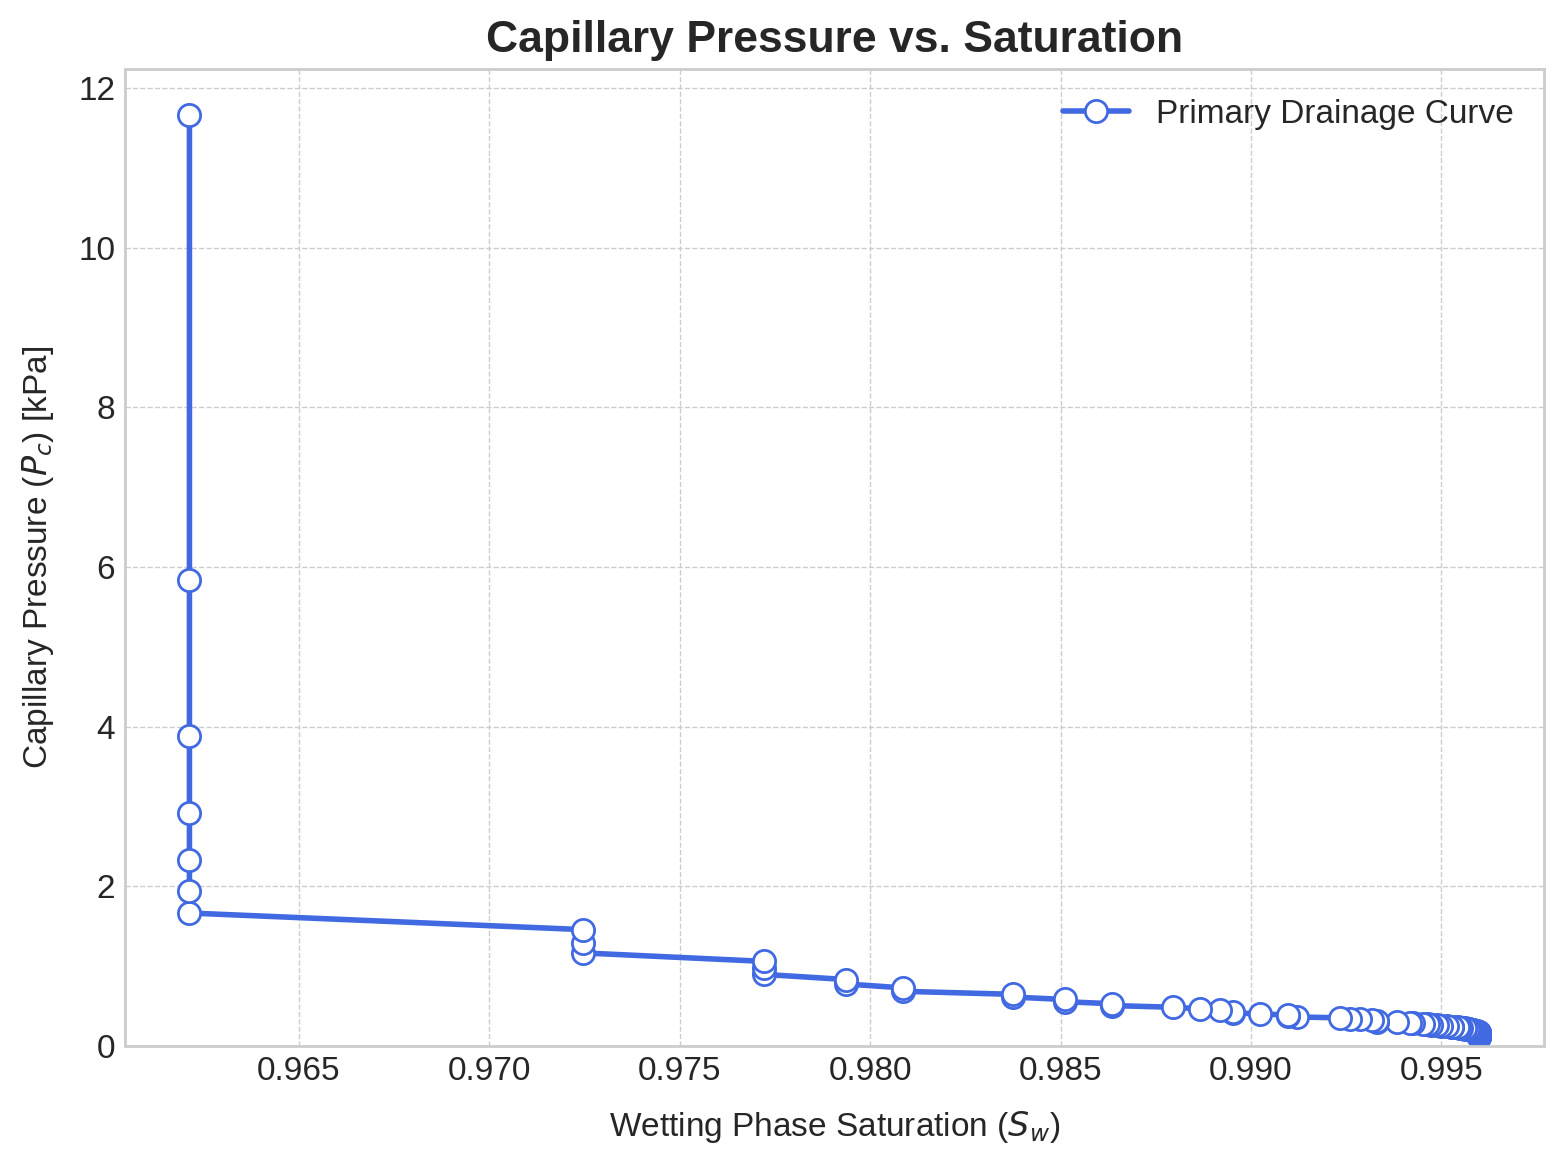

In [20]:
# =============================================================================
#
# SCRIPT FOR CAPILLARY PRESSURE CURVE (Pc-Sw) CALCULATION
#              VIA MORPHOLOGICAL POROSIMETRY
#
# METHODOLOGY:
# This script calculates the primary drainage capillary pressure curve of a 3D
# porous medium. The method is based on morphological image analysis and simulates
# the progressive invasion of a non-wetting fluid.
#
# The physical principle is the Young-Laplace equation, which relates the
# capillary pressure (Pc) required to invade a pore throat of radius (r) to the
# fluid properties:
#
#                           Pc = (2 * γ * cos(θ)) / r
#
# where γ is the interfacial tension and θ is the contact angle.
#
# WORKFLOW:
#   1. Pore Size Mapping: A 3D map of the local pore radius is generated using
#      the Euclidean Distance Transform on the pore space image.
#   2. Simulated Invasion: The script simulates drainage by iterating through a
#      series of decreasing pore radii (equivalent to increasing capillary
#      pressure). At each step, it identifies all pore voxels that are larger
#      than the current critical radius AND are connected to a specified
#      inlet face.
#   3. Saturation Calculation: For each pressure step, the volume of the invaded
#      pore space is calculated, from which the non-wetting and wetting phase
#      saturations are determined.
#   4. Curve Generation: The resulting pairs of (Pc, Sw) data are compiled
#      and plotted to form the final capillary pressure curve.
#
# OUTPUT:
# - A summary table of representative points on the Pc-Sw curve.
# - A plot of the full Capillary Pressure vs. Wetting Phase Saturation curve.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================

# ===== 1. LIBRARY IMPORTS =====
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import time
import gc
from typing import Tuple

# ===== 2. ANALYSIS WORKFLOW =====
# This workflow assumes that 'binarized_3d_image' and 'voxel_size' variables
# exist in the current runtime environment.

if 'binarized_3d_image' in locals() and 'voxel_size' in locals():

    # --- 2.1. Helper Function Definition ---
    def calculate_capillary_pressure_curve(
        pore_matrix: np.ndarray,
        voxel_size_m: float,
        gamma: float = 72e-3,
        theta_deg: float = 0,
        pressure_steps: int = 100,
        invasion_face: str = 'z'
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculates the Pc-Sw curve using the morphological porosimetry method.
        """
        print("\n[1] Initiating capillary pressure curve calculation...")
        start_time = time.time()

        if pore_matrix.ndim != 3:
            raise ValueError("Input matrix must be 3D.")

        # Step A: Generate pore radius map using the Euclidean Distance Transform
        print("    -> Generating pore size map (Distance Transform)...")
        radius_map = nd.distance_transform_edt(pore_matrix, sampling=voxel_size_m)

        total_pore_volume_m3 = np.sum(pore_matrix) * (voxel_size_m**3)
        if total_pore_volume_m3 == 0:
            print("WARNING: Sample has zero porosity.")
            return np.array([0]), np.array([1.0])

        # Step B: Define the inlet face for the invading fluid
        print(f"    -> Defining invasion inlet on the '{invasion_face}' face...")
        invasion_seed = np.zeros_like(pore_matrix, dtype=bool)
        if invasion_face == 'z':
            invasion_seed[0, :, :] = pore_matrix[0, :, :]
        elif invasion_face == 'y':
            invasion_seed[:, 0, :] = pore_matrix[:, 0, :]
        elif invasion_face == 'x':
            invasion_seed[:, :, 0] = pore_matrix[:, :, 0]
        else:
            raise ValueError("invasion_face must be one of 'x', 'y', or 'z'.")

        # Step C: Simulate the progressive drainage process
        print("    -> Simulating progressive drainage...")
        max_radius = np.max(radius_map)
        # Iterate from largest to smallest radius (lowest to highest pressure)
        test_radii = np.linspace(max_radius, 0, num=pressure_steps)

        saturations_wetting = []
        pressures_pascal = []
        laplace_factor = 2 * gamma * np.cos(np.deg2rad(theta_deg))

        for i, critical_radius in enumerate(test_radii):
            # Create a mask of all pores that are large enough to be invaded
            potential_mask = radius_map >= critical_radius

            # Find only those pores that are both large enough AND connected to the inlet
            invaded_mask = nd.binary_propagation(invasion_seed, mask=potential_mask)

            # Calculate saturations
            invaded_volume = np.sum(invaded_mask) * (voxel_size_m**3)
            saturation_nonwetting = invaded_volume / total_pore_volume_m3
            saturation_wetting = 1.0 - saturation_nonwetting

            # Calculate corresponding capillary pressure (handle r=0 case)
            capillary_pressure = laplace_factor / critical_radius if critical_radius > 0 else np.inf

            saturations_wetting.append(saturation_wetting)
            pressures_pascal.append(capillary_pressure)

        end_time = time.time()
        print(f"    -> Calculation completed in {end_time - start_time:.2f} seconds.")

        # Clean up and return finite results
        pressures_pascal = np.array(pressures_pascal)
        saturations_wetting = np.array(saturations_wetting)

        is_finite = np.isfinite(pressures_pascal)
        return pressures_pascal[is_finite], saturations_wetting[is_finite]

    # --- 2.2. Main Execution Block ---
    # --- Configuration ---
    CONFIG = {
        # Physical properties (example for an Oil-Water system)
        'INTERFACIAL_TENSION': 30e-3,  # [N/m]
        'CONTACT_ANGLE': 0,            # [degrees], 0 = perfectly water-wet
        # Simulation parameters
        'PRESSURE_STEPS': 100,
        'INVASION_FACE': 'z',          # Options: 'x', 'y', 'z'
        'SUBVOLUME_SIZE': 150          # Use a subvolume for faster execution
    }

    # --- Data Preparation ---
    print("\n[A] Preparing Data...")
    voxel_size_meters = voxel_size * 1e-6
    # The solver expects True for the pore phase.
    pore_space_full = ~binarized_3d_image

    # Crop a central subvolume for faster, memory-efficient analysis
    print(f"    -> Extracting a central subvolume of size {CONFIG['SUBVOLUME_SIZE']}^3 for analysis.")
    sz, sy, sx = pore_space_full.shape
    c = CONFIG['SUBVOLUME_SIZE']
    pore_matrix = pore_space_full[
        sz//2 - c//2 : sz//2 + c//2,
        sy//2 - c//2 : sy//2 + c//2,
        sx//2 - c//2 : sx//2 + c//2
    ]
    print(f"    -> Subvolume porosity: {np.mean(pore_matrix):.4f}")

    # --- Simulation Execution ---
    pressure, saturation = calculate_capillary_pressure_curve(
        pore_matrix,
        voxel_size_m=voxel_size_meters,
        gamma=CONFIG['INTERFACIAL_TENSION'],
        theta_deg=CONFIG['CONTACT_ANGLE'],
        pressure_steps=CONFIG['PRESSURE_STEPS'],
        invasion_face=CONFIG['INVASION_FACE']
    )

    # --- RAM Optimization ---
    del pore_matrix, pore_space_full
    gc.collect()

    # --- Results Visualization ---
    if pressure.size > 0:
        print("\n[B] Results Summary")
        print("   Sw         | Pc (kPa)")
        print("--------------------------")
        # Print 10 representative points from the curve
        for i in np.linspace(0, len(saturation)-1, 10, dtype=int):
            print(f"   {saturation[i]:.4f}     | {pressure[i]/1000:.4f}")

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(saturation, pressure / 1000, 'o-', color='royalblue', label='Primary Drainage Curve')
        ax.set_xlabel('Wetting Phase Saturation ($S_w$)', fontsize=12)
        ax.set_ylabel('Capillary Pressure ($P_c$) [kPa]', fontsize=12)
        ax.set_title('Capillary Pressure vs. Saturation', fontsize=16, fontweight='bold')
        ax.set_ylim(bottom=0)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        plt.tight_layout()
        plt.show()

else:
    print("CRITICAL ERROR: The variables 'binarized_3d_image' and/or 'voxel_size' were not found.")
    print("Please ensure the image processing script has been executed successfully prior to running this cell.")


Starting Pore Network Extraction from binary image using PoreSpy...
Image dimensions: (300, 300, 300)
19it [00:01,  9.49it/s]
24it [00:01, 16.09it/s]
29it [00:02, 13.54it/s]
33it [00:02, 13.58it/s]
35it [00:02, 12.59it/s]
37it [00:02, 12.90it/s]
15it [00:01, 15.39it/s]
39it [00:03, 12.25it/s]
41it [00:03, 12.58it/s]
44it [00:03, 15.91it/s]
48it [00:03, 16.58it/s]
51it [00:03, 19.04it/s]
54it [00:03, 21.56it/s]
57it [00:03, 20.47it/s]
60it [00:04, 15.69it/s]
63it [00:04, 17.96it/s]
66it [00:04, 19.58it/s]
69it [00:04, 20.43it/s]
49it [00:02, 21.51it/s]
72it [00:04, 18.39it/s]
80it [00:04, 25.74it/s]
83it [00:05, 23.65it/s]
86it [00:05, 24.35it/s]
89it [00:05, 21.15it/s]
92it [00:05, 22.13it/s]
95it [00:05, 23.52it/s]
98it [00:05, 24.60it/s]
105it [00:06, 24.75it/s]
108it [00:06, 25.59it/s]
115it [00:06, 25.26it/s]
119it [00:06, 25.15it/s]
124it [00:06, 29.69it/s]
129it [00:06, 33.17it/s]
134it [00:06, 34.57it/s]
100it [00:05, 22.34it/s]
138it [00:07, 29.57it/s]
142it [00:07, 26.12it/s]

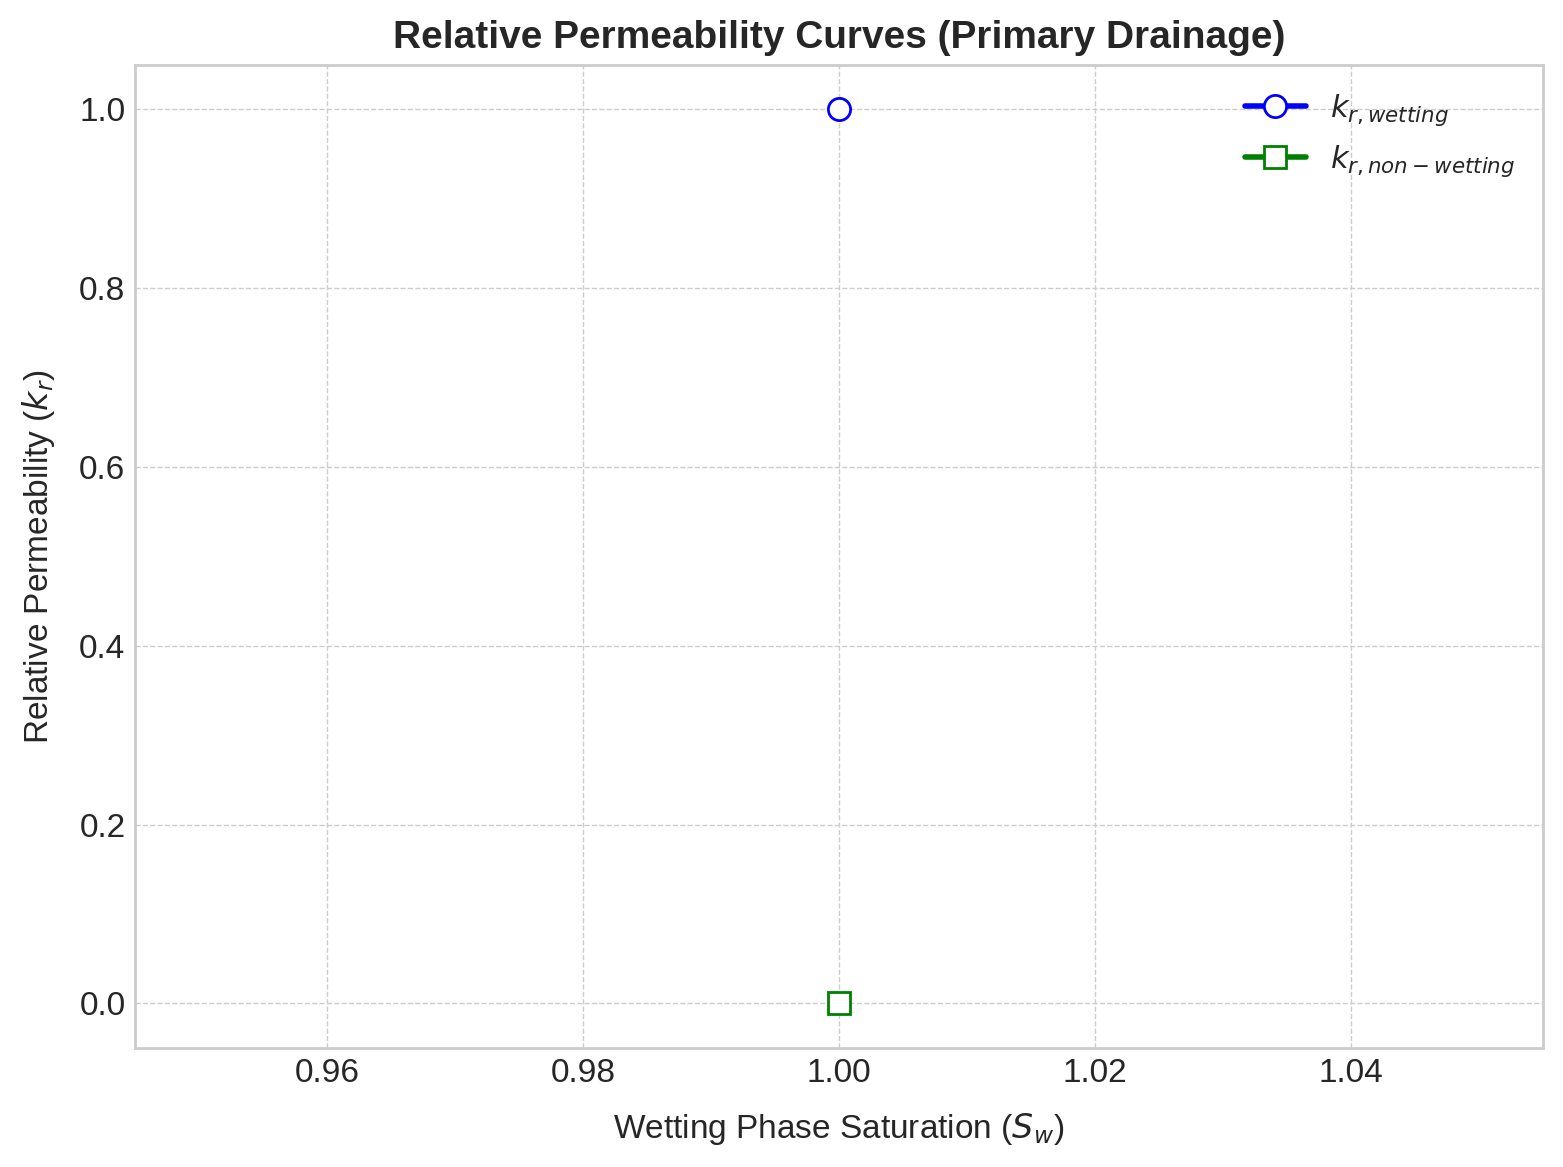

In [21]:
# =============================================================================
#
# SCRIPT FOR RELATIVE PERMEABILITY (kr) CALCULATION
#          VIA A PORE NETWORK MODEL (PNM) EXTRACTED FROM A 3D IMAGE
#
# METHODOLOGY:
#
#   1. Pore Network Extraction: A 3D binarized image of a porous medium
#      is analyzed using the PoreSpy library. The SNOW (Sub-Network of
#      Watersheds) algorithm identifies pores (nodes) and throats (connections),
#      generating a topologically and geometrically representative network.
#
#   2. Single-Phase Flow (Absolute Permeability): The absolute permeability
#      is determined by simulating the flow of a single fluid (e.g., water)
#      through the network. A pressure gradient is applied across the model,
#      and the resulting linear system of equations, derived from mass
#      conservation at each pore with conductances given by the Hagen-
#      Poiseuille equation, is solved to find the total flow rate.
#      Absolute permeability is then calculated using Darcy's law.
#
#   3. Drainage Simulation (Invasion Percolation): A primary drainage
#      process is simulated using an invasion percolation algorithm. The
#      non-wetting fluid invades the network starting from an inlet face,
#      sequentially entering the largest available throats connected to the
#      invaded cluster. This process determines the fluid occupancy of
#      pores and throats at incremental saturation steps.
#
#   4. Two-Phase Flow: At each saturation step defined by the drainage
#      simulation, the effective permeability of each phase (wetting and
#      non-wetting) is calculated. This is achieved by solving the same
#      linear system as in step 2, but now considering only the subset of
#      pores and throats occupied by the respective phase.
#
#   5. Relative Permeability (kr): The relative permeability for each phase
#      is calculated by normalizing its effective permeability by the
#      absolute permeability of the network. This process is repeated for
#      all saturation steps to generate the characteristic kr curves.
#
# Author: Jean Firmino Cardoso
# Date:   October 10, 2025
#
# =============================================================================


# =============================================================================
# 1. LIBRARY IMPORTS AND ENVIRONMENT SETUP
# =============================================================================
try:
    import porespy as ps
except ImportError:
    print("Installing PoreSpy library...")
    !pip install porespy -q --no-input
    import porespy as ps

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from typing import Dict, Tuple, List
import warnings

# Suppress warnings related to singular matrices, which are expected when a
# fluid phase becomes disconnected during the simulation.
from scipy.sparse import linalg
warnings.filterwarnings("ignore", category=linalg.MatrixRankWarning)


# =============================================================================
# 2. CORE FUNCTION DEFINITIONS
# =============================================================================

def calculate_relative_permeability_pnm(
    network: Dict[str, np.ndarray],
    throat_radii: np.ndarray,
    mu_wetting: float = 1e-3,
    mu_nonwetting: float = 2e-3
) -> Dict[str, np.ndarray]:
    """
    Calculates absolute and relative permeability curves for a primary drainage
    process on a given pore network model.

    This function has been optimized for memory efficiency by integrating the
    permeability calculations within the main drainage loop, thereby avoiding
    the storage of the entire fluid occupancy history.

    Args:
        network (Dict): A dictionary containing PNM data, requiring at least:
                        'pore_coords': (Np, 3) array of pore coordinates.
                        'throat_conns': (Nt, 2) array of throat connections.
        throat_radii (np.ndarray): An array of radii for each throat.
        mu_wetting (float): The viscosity of the wetting fluid (e.g., water)
                            in Pascal-seconds [Pa·s].
        mu_nonwetting (float): The viscosity of the non-wetting fluid
                               (e.g., oil) in Pascal-seconds [Pa·s].

    Returns:
        Dict: A dictionary containing the simulation results:
              "sw": Wetting phase saturation points.
              "kr_wetting": Corresponding wetting phase relative permeability.
              "kr_nonwetting": Corresponding non-wetting phase relative permeability.
    """
    print("Initiating relative permeability simulation on the pore network...")
    pore_coords = network['pore_coords']
    throat_conns = network['throat_conns']
    Np = pore_coords.shape[0]
    Nt = throat_conns.shape[0]

    # --- Pre-computation of constants ---
    # Hydraulic conductance (g) based on the Hagen-Poiseuille equation (g ~ r^4 / mu).
    # A factor of pi/8 is included for physical accuracy.
    g_w_const = (np.pi * throat_radii**4) / (8 * mu_wetting)
    g_nw_const = (np.pi * throat_radii**4) / (8 * mu_nonwetting)

    # --- 1. Absolute Permeability Calculation (Single-Phase Flow) ---
    print("\n[1] Calculating absolute permeability (k_abs)...")

    # Assemble the global conductance matrix 'A' for the wetting phase.
    A = sp.lil_matrix((Np, Np))
    for i, (p1, p2) in enumerate(throat_conns):
        g = g_w_const[i]
        A[p1, p1] -= g
        A[p2, p2] -= g
        A[p1, p2] += g
        A[p2, p1] += g

    # Define boundary conditions: pressure drop along the 0-axis (Z).
    inlet_pores = np.where(pore_coords[:, 0] == np.min(pore_coords[:, 0]))[0]
    outlet_pores = np.where(pore_coords[:, 0] == np.max(pore_coords[:, 0]))[0]
    interior_pores = np.setdiff1d(np.arange(Np), np.hstack([inlet_pores, outlet_pores]))

    # Solve the linear system Ap=b for the pressure field 'p'.
    A_int = A[np.ix_(interior_pores, interior_pores)].tocsc()
    b = -A[interior_pores][:, np.hstack([inlet_pores, outlet_pores])].sum(axis=1)

    p_int = np.zeros(interior_pores.shape)
    if A_int.shape[0] > 0:
        try:
            p_int = spla.spsolve(A_int, b)
        except linalg.MatrixRankWarning:
            print("  - Warning: Singular matrix encountered during absolute permeability calculation. The network may be disconnected.")
            # Fallback to a least-squares solution for disconnected networks
            p_int, _, _, _ = np.linalg.lstsq(A_int.toarray(), b, rcond=None)


    pressure = np.zeros(Np)
    pressure[inlet_pores] = 1.0  # Inlet pressure [Pa]
    pressure[outlet_pores] = 0.0 # Outlet pressure [Pa]
    pressure[interior_pores] = p_int

    # Calculate total single-phase flow rate (vectorized for performance).
    inlet_throats_mask = np.isin(throat_conns[:, 0], inlet_pores) | np.isin(throat_conns[:, 1], inlet_pores)
    p1 = throat_conns[inlet_throats_mask, 0]
    p2 = throat_conns[inlet_throats_mask, 1]
    delta_p = np.abs(pressure[p1] - pressure[p2])
    Q_abs = np.sum(g_w_const[inlet_throats_mask] * delta_p)

    # Normalize flow rate for non-wetting phase (for kr_nw calculation).
    Q_abs_nw = Q_abs * (mu_wetting / mu_nonwetting)

    print(f"  -> Absolute permeability calculation complete. Q_abs = {Q_abs:.2e}")
    if Q_abs == 0:
        print("  - CRITICAL: No flow path found. Permeability is zero. Aborting.")
        return {"sw": np.array([1.0, 0.0]), "kr_wetting": np.array([1.0, 0.0]), "kr_nonwetting": np.array([0.0, 0.0])}


    # --- 2. Integrated Drainage Simulation and Two-Phase Flow Calculation ---
    print("\n[2] Simulating primary drainage and calculating kr curves...")

    # Initialize data storage for results
    saturation_points = [1.0]
    kr_wetting_points = [1.0]
    kr_nonwetting_points = [0.0]

    # Setup for invasion percolation
    invasion_order = np.argsort(throat_radii)[::-1]  # Invade largest throats first
    throats_invaded_by_nw = np.zeros(Nt, dtype=bool)
    pores_invaded_by_nw = np.zeros(Np, dtype=bool)
    pores_invaded_by_nw[inlet_pores] = True

    # Simplified volumetric calculation for saturation (V ~ r^2)
    total_throat_volume = np.sum(throat_radii**2)

    # Main loop: invade one throat at a time and recalculate permeability
    for t_idx in invasion_order:
        p1, p2 = throat_conns[t_idx]

        # An invasion event occurs if one connecting pore is invaded and the other is not
        if pores_invaded_by_nw[p1] != pores_invaded_by_nw[p2]:
            throats_invaded_by_nw[t_idx] = True
            pores_invaded_by_nw[p1] = True
            pores_invaded_by_nw[p2] = True

            # --- Calculate current saturation ---
            wetting_phase_volume = np.sum(throat_radii[~throats_invaded_by_nw]**2)
            current_sw = wetting_phase_volume / total_throat_volume
            saturation_points.append(current_sw)

            # --- Calculate effective flow for each phase at this saturation ---
            Q_wetting, Q_nonwetting = 0.0, 0.0

            # Wetting Phase Permeability
            g_w_2p = g_w_const * (~throats_invaded_by_nw)
            if np.any(g_w_2p):
                Aw = sp.lil_matrix((Np, Np))
                for i, (p1_i, p2_i) in enumerate(throat_conns):
                    g = g_w_2p[i]
                    if g > 0:
                        Aw[p1_i, p1_i] -= g; Aw[p2_i, p2_i] -= g
                        Aw[p1_i, p2_i] += g; Aw[p2_i, p1_i] += g

                A_int_w = Aw[np.ix_(interior_pores, interior_pores)].tocsc()
                b_w = -Aw[interior_pores][:, np.hstack([inlet_pores, outlet_pores])].sum(axis=1)

                if A_int_w.nnz > 0 and np.any(b_w):
                    try:
                        p_int_w = spla.spsolve(A_int_w, b_w)
                        pw = np.zeros(Np); pw[inlet_pores] = 1.0; pw[interior_pores] = p_int_w

                        inlet_mask_w = inlet_throats_mask & (~throats_invaded_by_nw)
                        p1w = throat_conns[inlet_mask_w, 0]; p2w = throat_conns[inlet_mask_w, 1]
                        delta_pw = np.abs(pw[p1w] - pw[p2w])
                        Q_wetting = np.sum(g_w_2p[inlet_mask_w] * delta_pw)
                    except linalg.MatrixRankWarning:
                        Q_wetting = 0.0 # Phase is disconnected

            # Non-Wetting Phase Permeability
            g_nw_2p = g_nw_const * throats_invaded_by_nw
            if np.any(g_nw_2p):
                Anw = sp.lil_matrix((Np, Np))
                for i, (p1_i, p2_i) in enumerate(throat_conns):
                    g = g_nw_2p[i]
                    if g > 0:
                        Anw[p1_i, p1_i] -= g; Anw[p2_i, p2_i] -= g
                        Anw[p1_i, p2_i] += g; Anw[p2_i, p1_i] += g

                A_int_nw = Anw[np.ix_(interior_pores, interior_pores)].tocsc()
                b_nw = -Anw[interior_pores][:, np.hstack([inlet_pores, outlet_pores])].sum(axis=1)

                if A_int_nw.nnz > 0 and np.any(b_nw):
                    try:
                        p_int_nw = spla.spsolve(A_int_nw, b_nw)
                        pnw = np.zeros(Np); pnw[inlet_pores] = 1.0; pnw[interior_pores] = p_int_nw

                        inlet_mask_nw = inlet_throats_mask & throats_invaded_by_nw
                        p1nw = throat_conns[inlet_mask_nw, 0]; p2nw = throat_conns[inlet_mask_nw, 1]
                        delta_pnw = np.abs(pnw[p1nw] - pnw[p2nw])
                        Q_nonwetting = np.sum(g_nw_2p[inlet_mask_nw] * delta_pnw)
                    except linalg.MatrixRankWarning:
                        Q_nonwetting = 0.0 # Phase is disconnected

            kr_wetting_points.append(Q_wetting / Q_abs)
            kr_nonwetting_points.append(Q_nonwetting / Q_abs_nw)

    print("  -> Simulation complete.")

    # Ensure results are sorted by saturation for plotting
    sorted_indices = np.argsort(saturation_points)
    return {
        "sw": np.array(saturation_points)[sorted_indices],
        "kr_wetting": np.array(kr_wetting_points)[sorted_indices],
        "kr_nonwetting": np.array(kr_nonwetting_points)[sorted_indices]
    }

def generate_cubic_network(shape: Tuple[int, int, int]) -> Dict:
    """
    Generates a simple 3D cubic pore network. (UNUSED IN THIS SCRIPT)
    This function is retained for potential use in validation or testing.
    """
    Lz, Ly, Lx = shape
    pores, conns = [], []
    for k in range(Lz):
        for j in range(Ly):
            for i in range(Lx):
                p_idx = i + j * Lx + k * Lx * Ly
                pores.append([i, j, k])
                if i < Lx - 1: conns.append([p_idx, p_idx + 1])
                if j < Ly - 1: conns.append([p_idx, p_idx + Lx])
                if k < Lz - 1: conns.append([p_idx, p_idx + Lx * Ly])
    return {
        'pore_coords': np.array(pores, dtype=float),
        'throat_conns': np.array(conns)
    }


# =============================================================================
# 3. MAIN EXECUTION BLOCK
# =============================================================================
if __name__ == '__main__':

    # --- Simulation Configuration ---
    CONFIG = {
        'MU_WETTING': 1e-3,       # Viscosity of water [Pa·s]
        'MU_NONWETTING': 2e-3,    # Viscosity of oil [Pa·s]
    }

    # This script requires 'binarized_3d_image' and 'voxel_size' to be
    # pre-loaded into the environment, typically from a prior image
    # processing step. For demonstration, we will generate a sample image.
    if 'binarized_3d_image' not in locals() or 'voxel_size' not in locals():
        print("Generating a sample binarized image for demonstration...")
        # Create a sample binary image (e.g., Berea sandstone)
        binarized_3d_image = ps.generators.blobs(shape=[100, 100, 100], porosity=0.2, blobiness=1.5)
        voxel_size = 2.5  # Voxel size in micrometers [µm]
        print("Sample image generated.")


    # --- Step 1: Extract Pore Network from Binarized Image ---
    print("\nStarting Pore Network Extraction from binary image using PoreSpy...")
    print(f"Image dimensions: {binarized_3d_image.shape}")

    # PoreSpy's 'snow' algorithm expects the pore space to be 'True'.
    # The input image format may have 'False' for pores, so it must be inverted if necessary.
    # Assuming 'False' or '0' represents pores, we invert the image.
    if binarized_3d_image.dtype == bool:
        pore_space_image = ~binarized_3d_image
    else: # Assuming integer type (0 for pore, >0 for solid)
        pore_space_image = binarized_3d_image == 0


    # Convert voxel size from micrometers to meters for physical consistency.
    voxel_size_meters = voxel_size * 1e-6

    # Extract the network using the SNOW algorithm.
    # 'snow2' is an updated and robust version.
    network_extracted = ps.networks.snow2(
        phases=pore_space_image,
        voxel_size=voxel_size_meters
    )
    print("... Network extraction complete.")

    # --- Step 2: Prepare Network Data for Simulation ---
    net = network_extracted.network
    pnm_data = {
        'pore_coords': net['pore.coords'],
        'throat_conns': net['throat.conns']
    }
    # Using 'throat.equivalent_diameter' as it represents the diameter of the
    # largest sphere that can fit inside the throat.
    throat_radii_data = net['throat.equivalent_diameter'] / 2

    # --- Step 3: Execute Relative Permeability Simulation ---
    results = calculate_relative_permeability_pnm(
        network=pnm_data,
        throat_radii=throat_radii_data,
        mu_wetting=CONFIG['MU_WETTING'],
        mu_nonwetting=CONFIG['MU_NONWETTING']
    )

    # --- Step 4: Visualize Results ---
    print("\n--- Final Results ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    ax.plot(results['sw'], results['kr_wetting'], 'o-', color='blue', label='$k_{r, wetting}$')
    ax.plot(results['sw'], results['kr_nonwetting'], 's-', color='green', label='$k_{r, non-wetting}$')

    ax.set_xlabel('Wetting Phase Saturation ($S_w$)', fontsize=12)
    ax.set_ylabel('Relative Permeability ($k_r$)', fontsize=12)
    ax.set_title('Relative Permeability Curves (Primary Drainage)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()